In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, \
BatchNormalization, Dropout, Input, Dense, Flatten, Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

In [11]:
def build_generator(latent_input: Input):
    model = Sequential([
        Dense(7*7*256, use_bias=False,
             input_shape=latent_input.shape[1:]),
        BatchNormalization(),
        LeakyReLU(),
        Reshape((7, 7, 256)),
        
        Conv2DTranspose(filters=128, kernel_size=(5, 5), strides = (1, 1), padding='same',use_bias=False),
        BatchNormalization(),
        LeakyReLU(),
        
        Conv2DTranspose(filters=64, kernel_size=(5, 5), strides = (2, 2), padding="same", use_bias=False),
        BatchNormalization(),
        LeakyReLU(),
                
        Conv2DTranspose(filters=1, kernel_size=(5, 5), strides = (2, 2), padding='same', use_bias = False, activation='tanh'),
    ])
    
    generator = model(latent_input)
    return Model(z, generator)

In [7]:
def build_discriminator():
    model = Sequential([
        Conv2D(filters=64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1)),
        LeakyReLU(),
        Dropout(0.3),
        
        Conv2D(filters=128, kernel_size=(5, 5), strides=(2, 2), padding='same'),
        LeakyReLU(),
        Dropout(0.3),
        Flatten(),
        Dense(1, activation='sigmoid')
    ])
    
    image = Input(shape=(28, 28, 1))
    output = model(image)
    
    return Model(image, output)

In [14]:
def train(generator, discriminator, combined, steps, batch_size):
    (x_train, _), _ = mnist.load_data()
    
    ## Rescale in [-1, 1] interval
    x_train = (x_train.astype(np.float32) - 127.5) / 127.5
    x_train = np.expand_dims(x_train, axis=-1)
    
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    latent_dim = generator.input_shape[1]
    
    for step in range(steps):
        # Train the discriminator
        
        # Select a random batch of images
        real_images = x_train[np.random.randint(0, x_train.shape[0], batch_size)]
        
        # Random batch of noise
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        
        # Generate a batch of new images
        generated_images = generator.predict(noise)
        
        # train the discriminator
        discriminator_real_loss = discriminator.train_on_batch(real_images, real)
        discriminator_fake_loss = discriminator.train_on_batch(generated_images, fake)
        discriminator_loss = 0.5 * np.add(discriminator_real_loss, discriminator_fake_loss)
        
        # Train the generator
        # random latent vector z
        
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        
        # train the generator
        generator_loss = combined.train_on_batch(noise, real)
        
        # display progess
        print("%d [Discriminator Loss: %.4f%%, acc. %.2f%%] [Generator loss: %.4f%%]" % (step, discriminator_loss[0], 
                                                                                        100 * discriminator_loss[1],
                                                                                        generator_loss))

In [15]:
def plot_generated_images(generator):
    n = 10
    digit_size = 28
    
    # big array containing all images
    figure = np.zeros((digit_size * n, digit_size * n))
    
    latent_dim = generator.input_shape[1]
    noise = np.random.normal(0, 1, (n * n, latent_dim))
    
    # generate the images
    generated_images = generator.predict(noise)
    for i in range(n):
        for j in range(n):
            slice_i = slice(i * digit_size, (i + 1) * digit_size)
            slice_j = slice(j * digit_size, (j + 1) * digit_size)
            figure[slice_i, slice_j] = np.reshape(generated_images[i * n + j], (28, 28))
    
    plt.figure(figsize=(6, 5))
    plt.axis("off")
    plt.imshow(figure, cmap='gray')
    plt.show()

0 [Discriminator Loss: 0.7292%, acc. 6.00%] [Generator loss: 0.6872%]
1 [Discriminator Loss: 0.6457%, acc. 50.00%] [Generator loss: 0.6232%]
2 [Discriminator Loss: 0.5849%, acc. 50.00%] [Generator loss: 0.5527%]
3 [Discriminator Loss: 0.5256%, acc. 50.00%] [Generator loss: 0.4811%]
4 [Discriminator Loss: 0.4763%, acc. 50.00%] [Generator loss: 0.4198%]
5 [Discriminator Loss: 0.4351%, acc. 53.00%] [Generator loss: 0.3555%]
6 [Discriminator Loss: 0.4003%, acc. 80.00%] [Generator loss: 0.2940%]
7 [Discriminator Loss: 0.3790%, acc. 95.00%] [Generator loss: 0.2347%]
8 [Discriminator Loss: 0.3669%, acc. 93.00%] [Generator loss: 0.1838%]
9 [Discriminator Loss: 0.3644%, acc. 79.50%] [Generator loss: 0.1537%]
10 [Discriminator Loss: 0.3565%, acc. 94.00%] [Generator loss: 0.1484%]
11 [Discriminator Loss: 0.3407%, acc. 100.00%] [Generator loss: 0.1556%]
12 [Discriminator Loss: 0.3255%, acc. 100.00%] [Generator loss: 0.1588%]
13 [Discriminator Loss: 0.3170%, acc. 100.00%] [Generator loss: 0.1602%]


115 [Discriminator Loss: 0.0459%, acc. 100.00%] [Generator loss: 0.0015%]
116 [Discriminator Loss: 0.0320%, acc. 100.00%] [Generator loss: 0.0013%]
117 [Discriminator Loss: 0.0545%, acc. 100.00%] [Generator loss: 0.0015%]
118 [Discriminator Loss: 0.0619%, acc. 99.00%] [Generator loss: 0.0012%]
119 [Discriminator Loss: 0.0347%, acc. 100.00%] [Generator loss: 0.0014%]
120 [Discriminator Loss: 0.0603%, acc. 99.00%] [Generator loss: 0.0011%]
121 [Discriminator Loss: 0.0329%, acc. 100.00%] [Generator loss: 0.0011%]
122 [Discriminator Loss: 0.0427%, acc. 100.00%] [Generator loss: 0.0011%]
123 [Discriminator Loss: 0.0358%, acc. 100.00%] [Generator loss: 0.0009%]
124 [Discriminator Loss: 0.0330%, acc. 99.50%] [Generator loss: 0.0011%]
125 [Discriminator Loss: 0.0366%, acc. 100.00%] [Generator loss: 0.0014%]
126 [Discriminator Loss: 0.0326%, acc. 100.00%] [Generator loss: 0.0009%]
127 [Discriminator Loss: 0.0279%, acc. 100.00%] [Generator loss: 0.0010%]
128 [Discriminator Loss: 0.0355%, acc. 99

227 [Discriminator Loss: 0.0019%, acc. 100.00%] [Generator loss: 0.0001%]
228 [Discriminator Loss: 0.0018%, acc. 100.00%] [Generator loss: 0.0001%]
229 [Discriminator Loss: 0.0015%, acc. 100.00%] [Generator loss: 0.0001%]
230 [Discriminator Loss: 0.0017%, acc. 100.00%] [Generator loss: 0.0001%]
231 [Discriminator Loss: 0.0022%, acc. 100.00%] [Generator loss: 0.0001%]
232 [Discriminator Loss: 0.0036%, acc. 100.00%] [Generator loss: 0.0001%]
233 [Discriminator Loss: 0.0019%, acc. 100.00%] [Generator loss: 0.0001%]
234 [Discriminator Loss: 0.0024%, acc. 100.00%] [Generator loss: 0.0001%]
235 [Discriminator Loss: 0.0020%, acc. 100.00%] [Generator loss: 0.0001%]
236 [Discriminator Loss: 0.0018%, acc. 100.00%] [Generator loss: 0.0001%]
237 [Discriminator Loss: 0.0015%, acc. 100.00%] [Generator loss: 0.0001%]
238 [Discriminator Loss: 0.0021%, acc. 100.00%] [Generator loss: 0.0001%]
239 [Discriminator Loss: 0.0022%, acc. 100.00%] [Generator loss: 0.0001%]
240 [Discriminator Loss: 0.0025%, acc.

340 [Discriminator Loss: 0.0656%, acc. 99.50%] [Generator loss: 0.0044%]
341 [Discriminator Loss: 0.1062%, acc. 96.50%] [Generator loss: 0.0055%]
342 [Discriminator Loss: 0.0718%, acc. 97.50%] [Generator loss: 0.0041%]
343 [Discriminator Loss: 0.0602%, acc. 99.00%] [Generator loss: 0.0045%]
344 [Discriminator Loss: 0.0577%, acc. 98.50%] [Generator loss: 0.0036%]
345 [Discriminator Loss: 0.0431%, acc. 100.00%] [Generator loss: 0.0041%]
346 [Discriminator Loss: 0.0477%, acc. 99.00%] [Generator loss: 0.0037%]
347 [Discriminator Loss: 0.0401%, acc. 99.50%] [Generator loss: 0.0030%]
348 [Discriminator Loss: 0.0402%, acc. 100.00%] [Generator loss: 0.0036%]
349 [Discriminator Loss: 0.0314%, acc. 100.00%] [Generator loss: 0.0030%]
350 [Discriminator Loss: 0.0626%, acc. 98.00%] [Generator loss: 0.0026%]
351 [Discriminator Loss: 0.0355%, acc. 100.00%] [Generator loss: 0.0038%]
352 [Discriminator Loss: 0.0438%, acc. 99.50%] [Generator loss: 0.0033%]
353 [Discriminator Loss: 0.0522%, acc. 99.00%] 

454 [Discriminator Loss: 0.0399%, acc. 99.00%] [Generator loss: 0.0059%]
455 [Discriminator Loss: 0.0256%, acc. 99.00%] [Generator loss: 0.0068%]
456 [Discriminator Loss: 0.0173%, acc. 100.00%] [Generator loss: 0.0059%]
457 [Discriminator Loss: 0.0286%, acc. 100.00%] [Generator loss: 0.0053%]
458 [Discriminator Loss: 0.0231%, acc. 100.00%] [Generator loss: 0.0058%]
459 [Discriminator Loss: 0.0327%, acc. 99.50%] [Generator loss: 0.0066%]
460 [Discriminator Loss: 0.0132%, acc. 100.00%] [Generator loss: 0.0077%]
461 [Discriminator Loss: 0.0349%, acc. 99.00%] [Generator loss: 0.0073%]
462 [Discriminator Loss: 0.0242%, acc. 100.00%] [Generator loss: 0.0078%]
463 [Discriminator Loss: 0.0271%, acc. 100.00%] [Generator loss: 0.0085%]
464 [Discriminator Loss: 0.0344%, acc. 99.50%] [Generator loss: 0.0091%]
465 [Discriminator Loss: 0.0234%, acc. 100.00%] [Generator loss: 0.0099%]
466 [Discriminator Loss: 0.0312%, acc. 100.00%] [Generator loss: 0.0084%]
467 [Discriminator Loss: 0.0305%, acc. 99.5

565 [Discriminator Loss: 0.0130%, acc. 100.00%] [Generator loss: 0.0034%]
566 [Discriminator Loss: 0.0124%, acc. 100.00%] [Generator loss: 0.0034%]
567 [Discriminator Loss: 0.0144%, acc. 100.00%] [Generator loss: 0.0032%]
568 [Discriminator Loss: 0.0124%, acc. 100.00%] [Generator loss: 0.0031%]
569 [Discriminator Loss: 0.0146%, acc. 100.00%] [Generator loss: 0.0032%]
570 [Discriminator Loss: 0.0138%, acc. 100.00%] [Generator loss: 0.0041%]
571 [Discriminator Loss: 0.0180%, acc. 100.00%] [Generator loss: 0.0039%]
572 [Discriminator Loss: 0.0134%, acc. 100.00%] [Generator loss: 0.0032%]
573 [Discriminator Loss: 0.0146%, acc. 100.00%] [Generator loss: 0.0031%]
574 [Discriminator Loss: 0.0173%, acc. 100.00%] [Generator loss: 0.0027%]
575 [Discriminator Loss: 0.0241%, acc. 100.00%] [Generator loss: 0.0035%]
576 [Discriminator Loss: 0.0159%, acc. 100.00%] [Generator loss: 0.0035%]
577 [Discriminator Loss: 0.0146%, acc. 100.00%] [Generator loss: 0.0036%]
578 [Discriminator Loss: 0.0249%, acc.

679 [Discriminator Loss: 0.9259%, acc. 31.50%] [Generator loss: 0.6273%]
680 [Discriminator Loss: 0.9438%, acc. 25.00%] [Generator loss: 0.6150%]
681 [Discriminator Loss: 0.9125%, acc. 32.50%] [Generator loss: 0.6071%]
682 [Discriminator Loss: 0.9132%, acc. 29.00%] [Generator loss: 0.6372%]
683 [Discriminator Loss: 0.8853%, acc. 32.50%] [Generator loss: 0.6341%]
684 [Discriminator Loss: 0.9228%, acc. 25.00%] [Generator loss: 0.6138%]
685 [Discriminator Loss: 0.9074%, acc. 26.50%] [Generator loss: 0.6574%]
686 [Discriminator Loss: 0.8527%, acc. 31.00%] [Generator loss: 0.6275%]
687 [Discriminator Loss: 0.8586%, acc. 36.50%] [Generator loss: 0.6645%]
688 [Discriminator Loss: 0.8794%, acc. 31.50%] [Generator loss: 0.6492%]
689 [Discriminator Loss: 0.8592%, acc. 34.50%] [Generator loss: 0.6058%]
690 [Discriminator Loss: 0.8266%, acc. 35.50%] [Generator loss: 0.6276%]
691 [Discriminator Loss: 0.8701%, acc. 32.00%] [Generator loss: 0.6650%]
692 [Discriminator Loss: 0.8872%, acc. 29.00%] [Gen

794 [Discriminator Loss: 0.7776%, acc. 30.50%] [Generator loss: 0.7009%]
795 [Discriminator Loss: 0.7957%, acc. 30.50%] [Generator loss: 0.6920%]
796 [Discriminator Loss: 0.7647%, acc. 36.50%] [Generator loss: 0.6791%]
797 [Discriminator Loss: 0.7658%, acc. 31.50%] [Generator loss: 0.6691%]
798 [Discriminator Loss: 0.7529%, acc. 38.00%] [Generator loss: 0.6948%]
799 [Discriminator Loss: 0.7509%, acc. 37.50%] [Generator loss: 0.7249%]
800 [Discriminator Loss: 0.7733%, acc. 35.00%] [Generator loss: 0.6954%]
801 [Discriminator Loss: 0.7559%, acc. 31.00%] [Generator loss: 0.7234%]
802 [Discriminator Loss: 0.7737%, acc. 34.50%] [Generator loss: 0.7195%]
803 [Discriminator Loss: 0.7606%, acc. 33.00%] [Generator loss: 0.7078%]
804 [Discriminator Loss: 0.7486%, acc. 37.00%] [Generator loss: 0.7221%]
805 [Discriminator Loss: 0.7201%, acc. 46.00%] [Generator loss: 0.7281%]
806 [Discriminator Loss: 0.7545%, acc. 38.00%] [Generator loss: 0.7158%]
807 [Discriminator Loss: 0.7440%, acc. 40.50%] [Gen

909 [Discriminator Loss: 0.7239%, acc. 45.00%] [Generator loss: 0.7143%]
910 [Discriminator Loss: 0.7149%, acc. 50.00%] [Generator loss: 0.7321%]
911 [Discriminator Loss: 0.7075%, acc. 48.00%] [Generator loss: 0.6940%]
912 [Discriminator Loss: 0.7150%, acc. 47.50%] [Generator loss: 0.7028%]
913 [Discriminator Loss: 0.7344%, acc. 40.00%] [Generator loss: 0.6973%]
914 [Discriminator Loss: 0.7467%, acc. 39.50%] [Generator loss: 0.7139%]
915 [Discriminator Loss: 0.7194%, acc. 44.50%] [Generator loss: 0.7112%]
916 [Discriminator Loss: 0.7387%, acc. 35.50%] [Generator loss: 0.7226%]
917 [Discriminator Loss: 0.7621%, acc. 31.00%] [Generator loss: 0.7312%]
918 [Discriminator Loss: 0.7516%, acc. 34.00%] [Generator loss: 0.7432%]
919 [Discriminator Loss: 0.7139%, acc. 42.50%] [Generator loss: 0.7177%]
920 [Discriminator Loss: 0.7271%, acc. 39.50%] [Generator loss: 0.7551%]
921 [Discriminator Loss: 0.7313%, acc. 37.50%] [Generator loss: 0.7300%]
922 [Discriminator Loss: 0.7537%, acc. 35.00%] [Gen

1021 [Discriminator Loss: 0.6935%, acc. 52.50%] [Generator loss: 0.7075%]
1022 [Discriminator Loss: 0.6990%, acc. 53.50%] [Generator loss: 0.7218%]
1023 [Discriminator Loss: 0.7088%, acc. 49.50%] [Generator loss: 0.7032%]
1024 [Discriminator Loss: 0.7233%, acc. 47.50%] [Generator loss: 0.6702%]
1025 [Discriminator Loss: 0.7354%, acc. 38.00%] [Generator loss: 0.6974%]
1026 [Discriminator Loss: 0.7346%, acc. 40.50%] [Generator loss: 0.6985%]
1027 [Discriminator Loss: 0.7323%, acc. 41.00%] [Generator loss: 0.7147%]
1028 [Discriminator Loss: 0.7423%, acc. 33.50%] [Generator loss: 0.7171%]
1029 [Discriminator Loss: 0.7222%, acc. 41.00%] [Generator loss: 0.7400%]
1030 [Discriminator Loss: 0.7266%, acc. 34.50%] [Generator loss: 0.7539%]
1031 [Discriminator Loss: 0.7165%, acc. 47.00%] [Generator loss: 0.7743%]
1032 [Discriminator Loss: 0.7135%, acc. 47.50%] [Generator loss: 0.7823%]
1033 [Discriminator Loss: 0.6945%, acc. 49.50%] [Generator loss: 0.7643%]
1034 [Discriminator Loss: 0.7115%, acc

1134 [Discriminator Loss: 0.6811%, acc. 59.50%] [Generator loss: 0.7430%]
1135 [Discriminator Loss: 0.6734%, acc. 59.50%] [Generator loss: 0.7355%]
1136 [Discriminator Loss: 0.6917%, acc. 53.00%] [Generator loss: 0.7176%]
1137 [Discriminator Loss: 0.7056%, acc. 46.50%] [Generator loss: 0.7093%]
1138 [Discriminator Loss: 0.7295%, acc. 40.00%] [Generator loss: 0.7145%]
1139 [Discriminator Loss: 0.7430%, acc. 33.50%] [Generator loss: 0.7343%]
1140 [Discriminator Loss: 0.7277%, acc. 39.50%] [Generator loss: 0.7184%]
1141 [Discriminator Loss: 0.7283%, acc. 36.00%] [Generator loss: 0.7560%]
1142 [Discriminator Loss: 0.7284%, acc. 35.50%] [Generator loss: 0.7501%]
1143 [Discriminator Loss: 0.7043%, acc. 47.50%] [Generator loss: 0.7525%]
1144 [Discriminator Loss: 0.6843%, acc. 54.50%] [Generator loss: 0.7675%]
1145 [Discriminator Loss: 0.6764%, acc. 60.00%] [Generator loss: 0.7823%]
1146 [Discriminator Loss: 0.6816%, acc. 54.50%] [Generator loss: 0.7696%]
1147 [Discriminator Loss: 0.6786%, acc

1245 [Discriminator Loss: 0.6943%, acc. 52.00%] [Generator loss: 0.7409%]
1246 [Discriminator Loss: 0.7189%, acc. 39.50%] [Generator loss: 0.7475%]
1247 [Discriminator Loss: 0.7174%, acc. 40.50%] [Generator loss: 0.7389%]
1248 [Discriminator Loss: 0.7231%, acc. 40.50%] [Generator loss: 0.7334%]
1249 [Discriminator Loss: 0.7209%, acc. 39.00%] [Generator loss: 0.7428%]
1250 [Discriminator Loss: 0.6952%, acc. 52.50%] [Generator loss: 0.7692%]
1251 [Discriminator Loss: 0.6995%, acc. 46.50%] [Generator loss: 0.7655%]
1252 [Discriminator Loss: 0.6882%, acc. 59.50%] [Generator loss: 0.7702%]
1253 [Discriminator Loss: 0.6674%, acc. 63.00%] [Generator loss: 0.7670%]
1254 [Discriminator Loss: 0.6881%, acc. 55.00%] [Generator loss: 0.7454%]
1255 [Discriminator Loss: 0.6816%, acc. 55.50%] [Generator loss: 0.7508%]
1256 [Discriminator Loss: 0.6899%, acc. 56.00%] [Generator loss: 0.7562%]
1257 [Discriminator Loss: 0.6970%, acc. 48.00%] [Generator loss: 0.7482%]
1258 [Discriminator Loss: 0.7004%, acc

1358 [Discriminator Loss: 0.7041%, acc. 48.50%] [Generator loss: 0.7394%]
1359 [Discriminator Loss: 0.6898%, acc. 54.50%] [Generator loss: 0.7254%]
1360 [Discriminator Loss: 0.7067%, acc. 48.50%] [Generator loss: 0.7342%]
1361 [Discriminator Loss: 0.7111%, acc. 46.50%] [Generator loss: 0.7158%]
1362 [Discriminator Loss: 0.7109%, acc. 44.50%] [Generator loss: 0.7074%]
1363 [Discriminator Loss: 0.7265%, acc. 39.50%] [Generator loss: 0.7284%]
1364 [Discriminator Loss: 0.7045%, acc. 47.00%] [Generator loss: 0.7357%]
1365 [Discriminator Loss: 0.7081%, acc. 45.00%] [Generator loss: 0.7265%]
1366 [Discriminator Loss: 0.6931%, acc. 49.00%] [Generator loss: 0.7164%]
1367 [Discriminator Loss: 0.6966%, acc. 49.00%] [Generator loss: 0.7294%]
1368 [Discriminator Loss: 0.7008%, acc. 52.00%] [Generator loss: 0.7177%]
1369 [Discriminator Loss: 0.6816%, acc. 57.00%] [Generator loss: 0.6831%]
1370 [Discriminator Loss: 0.6967%, acc. 53.50%] [Generator loss: 0.7128%]
1371 [Discriminator Loss: 0.7076%, acc

1471 [Discriminator Loss: 0.6788%, acc. 60.00%] [Generator loss: 0.7506%]
1472 [Discriminator Loss: 0.6874%, acc. 55.50%] [Generator loss: 0.7563%]
1473 [Discriminator Loss: 0.6715%, acc. 57.50%] [Generator loss: 0.7349%]
1474 [Discriminator Loss: 0.6869%, acc. 51.00%] [Generator loss: 0.7294%]
1475 [Discriminator Loss: 0.6843%, acc. 54.00%] [Generator loss: 0.7331%]
1476 [Discriminator Loss: 0.7025%, acc. 49.00%] [Generator loss: 0.7055%]
1477 [Discriminator Loss: 0.7225%, acc. 41.00%] [Generator loss: 0.6693%]
1478 [Discriminator Loss: 0.7300%, acc. 38.50%] [Generator loss: 0.6756%]
1479 [Discriminator Loss: 0.7259%, acc. 41.50%] [Generator loss: 0.6967%]
1480 [Discriminator Loss: 0.7267%, acc. 41.50%] [Generator loss: 0.7039%]
1481 [Discriminator Loss: 0.7158%, acc. 43.00%] [Generator loss: 0.7167%]
1482 [Discriminator Loss: 0.6858%, acc. 55.50%] [Generator loss: 0.7712%]
1483 [Discriminator Loss: 0.6751%, acc. 58.50%] [Generator loss: 0.7909%]
1484 [Discriminator Loss: 0.6499%, acc

1585 [Discriminator Loss: 0.6975%, acc. 49.00%] [Generator loss: 0.7385%]
1586 [Discriminator Loss: 0.7315%, acc. 36.50%] [Generator loss: 0.7161%]
1587 [Discriminator Loss: 0.7199%, acc. 45.00%] [Generator loss: 0.7221%]
1588 [Discriminator Loss: 0.7044%, acc. 49.50%] [Generator loss: 0.7453%]
1589 [Discriminator Loss: 0.6932%, acc. 52.50%] [Generator loss: 0.7443%]
1590 [Discriminator Loss: 0.6817%, acc. 56.50%] [Generator loss: 0.7856%]
1591 [Discriminator Loss: 0.6804%, acc. 54.50%] [Generator loss: 0.7805%]
1592 [Discriminator Loss: 0.6738%, acc. 61.00%] [Generator loss: 0.8027%]
1593 [Discriminator Loss: 0.6573%, acc. 69.50%] [Generator loss: 0.7827%]
1594 [Discriminator Loss: 0.6555%, acc. 68.50%] [Generator loss: 0.7854%]
1595 [Discriminator Loss: 0.6575%, acc. 70.00%] [Generator loss: 0.7632%]
1596 [Discriminator Loss: 0.7041%, acc. 47.50%] [Generator loss: 0.7726%]
1597 [Discriminator Loss: 0.7013%, acc. 52.00%] [Generator loss: 0.7614%]
1598 [Discriminator Loss: 0.7005%, acc

1696 [Discriminator Loss: 0.6886%, acc. 51.50%] [Generator loss: 0.7723%]
1697 [Discriminator Loss: 0.6697%, acc. 58.00%] [Generator loss: 0.7832%]
1698 [Discriminator Loss: 0.6594%, acc. 64.50%] [Generator loss: 0.8055%]
1699 [Discriminator Loss: 0.6507%, acc. 69.00%] [Generator loss: 0.8170%]
1700 [Discriminator Loss: 0.6658%, acc. 63.50%] [Generator loss: 0.8038%]
1701 [Discriminator Loss: 0.6488%, acc. 66.00%] [Generator loss: 0.7941%]
1702 [Discriminator Loss: 0.6832%, acc. 58.00%] [Generator loss: 0.7844%]
1703 [Discriminator Loss: 0.7013%, acc. 51.00%] [Generator loss: 0.7530%]
1704 [Discriminator Loss: 0.7205%, acc. 47.00%] [Generator loss: 0.7541%]
1705 [Discriminator Loss: 0.6945%, acc. 49.00%] [Generator loss: 0.7218%]
1706 [Discriminator Loss: 0.7019%, acc. 47.00%] [Generator loss: 0.7423%]
1707 [Discriminator Loss: 0.7123%, acc. 43.00%] [Generator loss: 0.7101%]
1708 [Discriminator Loss: 0.7038%, acc. 48.50%] [Generator loss: 0.7138%]
1709 [Discriminator Loss: 0.6872%, acc

1807 [Discriminator Loss: 0.7018%, acc. 53.50%] [Generator loss: 0.7644%]
1808 [Discriminator Loss: 0.6818%, acc. 57.00%] [Generator loss: 0.7527%]
1809 [Discriminator Loss: 0.7142%, acc. 46.00%] [Generator loss: 0.7724%]
1810 [Discriminator Loss: 0.7102%, acc. 49.00%] [Generator loss: 0.7529%]
1811 [Discriminator Loss: 0.6954%, acc. 48.00%] [Generator loss: 0.7571%]
1812 [Discriminator Loss: 0.6932%, acc. 56.00%] [Generator loss: 0.7903%]
1813 [Discriminator Loss: 0.6739%, acc. 63.50%] [Generator loss: 0.7744%]
1814 [Discriminator Loss: 0.6742%, acc. 63.00%] [Generator loss: 0.7962%]
1815 [Discriminator Loss: 0.6470%, acc. 69.50%] [Generator loss: 0.7875%]
1816 [Discriminator Loss: 0.6691%, acc. 64.00%] [Generator loss: 0.7627%]
1817 [Discriminator Loss: 0.6542%, acc. 68.00%] [Generator loss: 0.7681%]
1818 [Discriminator Loss: 0.6508%, acc. 60.50%] [Generator loss: 0.7278%]
1819 [Discriminator Loss: 0.6879%, acc. 51.50%] [Generator loss: 0.7280%]
1820 [Discriminator Loss: 0.6879%, acc

1921 [Discriminator Loss: 0.6765%, acc. 58.00%] [Generator loss: 0.7225%]
1922 [Discriminator Loss: 0.6856%, acc. 54.50%] [Generator loss: 0.7053%]
1923 [Discriminator Loss: 0.7114%, acc. 47.00%] [Generator loss: 0.7094%]
1924 [Discriminator Loss: 0.7089%, acc. 44.00%] [Generator loss: 0.6822%]
1925 [Discriminator Loss: 0.7154%, acc. 42.50%] [Generator loss: 0.6731%]
1926 [Discriminator Loss: 0.7243%, acc. 46.50%] [Generator loss: 0.7025%]
1927 [Discriminator Loss: 0.6871%, acc. 56.50%] [Generator loss: 0.7343%]
1928 [Discriminator Loss: 0.6841%, acc. 53.50%] [Generator loss: 0.7774%]
1929 [Discriminator Loss: 0.6555%, acc. 64.00%] [Generator loss: 0.8057%]
1930 [Discriminator Loss: 0.6504%, acc. 70.00%] [Generator loss: 0.8144%]
1931 [Discriminator Loss: 0.6364%, acc. 73.00%] [Generator loss: 0.8080%]
1932 [Discriminator Loss: 0.6708%, acc. 59.00%] [Generator loss: 0.7922%]
1933 [Discriminator Loss: 0.6920%, acc. 56.00%] [Generator loss: 0.8023%]
1934 [Discriminator Loss: 0.6935%, acc

2032 [Discriminator Loss: 0.6507%, acc. 69.50%] [Generator loss: 0.7889%]
2033 [Discriminator Loss: 0.7181%, acc. 51.00%] [Generator loss: 0.7395%]
2034 [Discriminator Loss: 0.7103%, acc. 49.50%] [Generator loss: 0.7246%]
2035 [Discriminator Loss: 0.7039%, acc. 49.50%] [Generator loss: 0.7375%]
2036 [Discriminator Loss: 0.7060%, acc. 51.50%] [Generator loss: 0.7255%]
2037 [Discriminator Loss: 0.7102%, acc. 53.00%] [Generator loss: 0.7562%]
2038 [Discriminator Loss: 0.6812%, acc. 57.50%] [Generator loss: 0.7696%]
2039 [Discriminator Loss: 0.6834%, acc. 51.00%] [Generator loss: 0.7946%]
2040 [Discriminator Loss: 0.6755%, acc. 60.50%] [Generator loss: 0.7681%]
2041 [Discriminator Loss: 0.6685%, acc. 59.50%] [Generator loss: 0.7770%]
2042 [Discriminator Loss: 0.6679%, acc. 57.50%] [Generator loss: 0.7851%]
2043 [Discriminator Loss: 0.6870%, acc. 57.00%] [Generator loss: 0.7301%]
2044 [Discriminator Loss: 0.6909%, acc. 52.50%] [Generator loss: 0.7221%]
2045 [Discriminator Loss: 0.7114%, acc

2144 [Discriminator Loss: 0.6713%, acc. 60.00%] [Generator loss: 0.7505%]
2145 [Discriminator Loss: 0.6908%, acc. 54.00%] [Generator loss: 0.7184%]
2146 [Discriminator Loss: 0.7066%, acc. 48.00%] [Generator loss: 0.6941%]
2147 [Discriminator Loss: 0.7097%, acc. 47.50%] [Generator loss: 0.6899%]
2148 [Discriminator Loss: 0.7083%, acc. 52.00%] [Generator loss: 0.6837%]
2149 [Discriminator Loss: 0.7097%, acc. 45.50%] [Generator loss: 0.6959%]
2150 [Discriminator Loss: 0.7022%, acc. 51.00%] [Generator loss: 0.7445%]
2151 [Discriminator Loss: 0.6969%, acc. 51.50%] [Generator loss: 0.7800%]
2152 [Discriminator Loss: 0.6771%, acc. 58.00%] [Generator loss: 0.8156%]
2153 [Discriminator Loss: 0.6498%, acc. 70.50%] [Generator loss: 0.8459%]
2154 [Discriminator Loss: 0.6439%, acc. 65.50%] [Generator loss: 0.8563%]
2155 [Discriminator Loss: 0.6609%, acc. 64.00%] [Generator loss: 0.8567%]
2156 [Discriminator Loss: 0.6435%, acc. 65.50%] [Generator loss: 0.8242%]
2157 [Discriminator Loss: 0.6848%, acc

2257 [Discriminator Loss: 0.7006%, acc. 48.00%] [Generator loss: 0.7328%]
2258 [Discriminator Loss: 0.6949%, acc. 49.00%] [Generator loss: 0.7485%]
2259 [Discriminator Loss: 0.6998%, acc. 51.00%] [Generator loss: 0.7450%]
2260 [Discriminator Loss: 0.6819%, acc. 61.50%] [Generator loss: 0.7681%]
2261 [Discriminator Loss: 0.6615%, acc. 67.00%] [Generator loss: 0.7798%]
2262 [Discriminator Loss: 0.6746%, acc. 60.00%] [Generator loss: 0.7846%]
2263 [Discriminator Loss: 0.6738%, acc. 56.00%] [Generator loss: 0.7681%]
2264 [Discriminator Loss: 0.6788%, acc. 57.00%] [Generator loss: 0.7641%]
2265 [Discriminator Loss: 0.6805%, acc. 58.50%] [Generator loss: 0.7420%]
2266 [Discriminator Loss: 0.6884%, acc. 52.50%] [Generator loss: 0.7517%]
2267 [Discriminator Loss: 0.6920%, acc. 54.00%] [Generator loss: 0.7160%]
2268 [Discriminator Loss: 0.7086%, acc. 47.00%] [Generator loss: 0.6958%]
2269 [Discriminator Loss: 0.7243%, acc. 47.00%] [Generator loss: 0.7008%]
2270 [Discriminator Loss: 0.7394%, acc

2370 [Discriminator Loss: 0.6816%, acc. 57.00%] [Generator loss: 0.7498%]
2371 [Discriminator Loss: 0.6950%, acc. 51.00%] [Generator loss: 0.7530%]
2372 [Discriminator Loss: 0.7085%, acc. 52.00%] [Generator loss: 0.7358%]
2373 [Discriminator Loss: 0.7090%, acc. 49.00%] [Generator loss: 0.7086%]
2374 [Discriminator Loss: 0.7125%, acc. 48.00%] [Generator loss: 0.7214%]
2375 [Discriminator Loss: 0.7146%, acc. 50.50%] [Generator loss: 0.7181%]
2376 [Discriminator Loss: 0.7163%, acc. 45.00%] [Generator loss: 0.7321%]
2377 [Discriminator Loss: 0.6865%, acc. 53.50%] [Generator loss: 0.7645%]
2378 [Discriminator Loss: 0.6599%, acc. 67.50%] [Generator loss: 0.7539%]
2379 [Discriminator Loss: 0.6693%, acc. 60.00%] [Generator loss: 0.7617%]
2380 [Discriminator Loss: 0.6787%, acc. 57.50%] [Generator loss: 0.7803%]
2381 [Discriminator Loss: 0.6764%, acc. 57.50%] [Generator loss: 0.7346%]
2382 [Discriminator Loss: 0.6874%, acc. 58.00%] [Generator loss: 0.7316%]
2383 [Discriminator Loss: 0.6903%, acc

2481 [Discriminator Loss: 0.6811%, acc. 57.00%] [Generator loss: 0.7661%]
2482 [Discriminator Loss: 0.6993%, acc. 49.50%] [Generator loss: 0.7254%]
2483 [Discriminator Loss: 0.7053%, acc. 48.50%] [Generator loss: 0.7234%]
2484 [Discriminator Loss: 0.7132%, acc. 46.00%] [Generator loss: 0.7152%]
2485 [Discriminator Loss: 0.7075%, acc. 46.00%] [Generator loss: 0.7108%]
2486 [Discriminator Loss: 0.6891%, acc. 51.00%] [Generator loss: 0.7409%]
2487 [Discriminator Loss: 0.6839%, acc. 56.50%] [Generator loss: 0.7774%]
2488 [Discriminator Loss: 0.6709%, acc. 61.50%] [Generator loss: 0.7716%]
2489 [Discriminator Loss: 0.6530%, acc. 67.50%] [Generator loss: 0.7902%]
2490 [Discriminator Loss: 0.6510%, acc. 65.00%] [Generator loss: 0.7972%]
2491 [Discriminator Loss: 0.6704%, acc. 57.00%] [Generator loss: 0.7646%]
2492 [Discriminator Loss: 0.6671%, acc. 60.00%] [Generator loss: 0.7468%]
2493 [Discriminator Loss: 0.7012%, acc. 52.00%] [Generator loss: 0.6927%]
2494 [Discriminator Loss: 0.7196%, acc

2595 [Discriminator Loss: 0.6994%, acc. 51.50%] [Generator loss: 0.7272%]
2596 [Discriminator Loss: 0.6949%, acc. 52.00%] [Generator loss: 0.7315%]
2597 [Discriminator Loss: 0.6912%, acc. 55.50%] [Generator loss: 0.7345%]
2598 [Discriminator Loss: 0.6965%, acc. 55.50%] [Generator loss: 0.7425%]
2599 [Discriminator Loss: 0.7087%, acc. 46.00%] [Generator loss: 0.7425%]
2600 [Discriminator Loss: 0.6871%, acc. 57.00%] [Generator loss: 0.7671%]
2601 [Discriminator Loss: 0.6776%, acc. 56.50%] [Generator loss: 0.7460%]
2602 [Discriminator Loss: 0.6787%, acc. 60.00%] [Generator loss: 0.7749%]
2603 [Discriminator Loss: 0.6748%, acc. 61.00%] [Generator loss: 0.7523%]
2604 [Discriminator Loss: 0.6809%, acc. 57.00%] [Generator loss: 0.7409%]
2605 [Discriminator Loss: 0.6835%, acc. 54.00%] [Generator loss: 0.7501%]
2606 [Discriminator Loss: 0.6810%, acc. 55.00%] [Generator loss: 0.7412%]
2607 [Discriminator Loss: 0.7008%, acc. 49.50%] [Generator loss: 0.7223%]
2608 [Discriminator Loss: 0.6875%, acc

2709 [Discriminator Loss: 0.6797%, acc. 60.50%] [Generator loss: 0.7685%]
2710 [Discriminator Loss: 0.7002%, acc. 45.50%] [Generator loss: 0.7614%]
2711 [Discriminator Loss: 0.6897%, acc. 53.50%] [Generator loss: 0.7417%]
2712 [Discriminator Loss: 0.6996%, acc. 49.00%] [Generator loss: 0.7492%]
2713 [Discriminator Loss: 0.6951%, acc. 51.50%] [Generator loss: 0.7349%]
2714 [Discriminator Loss: 0.6964%, acc. 50.50%] [Generator loss: 0.7279%]
2715 [Discriminator Loss: 0.7008%, acc. 51.00%] [Generator loss: 0.7334%]
2716 [Discriminator Loss: 0.6977%, acc. 51.50%] [Generator loss: 0.7391%]
2717 [Discriminator Loss: 0.6855%, acc. 51.50%] [Generator loss: 0.7322%]
2718 [Discriminator Loss: 0.7087%, acc. 46.50%] [Generator loss: 0.7438%]
2719 [Discriminator Loss: 0.6964%, acc. 51.50%] [Generator loss: 0.7262%]
2720 [Discriminator Loss: 0.6954%, acc. 51.00%] [Generator loss: 0.7322%]
2721 [Discriminator Loss: 0.6947%, acc. 52.00%] [Generator loss: 0.7167%]
2722 [Discriminator Loss: 0.6993%, acc

2823 [Discriminator Loss: 0.7015%, acc. 51.50%] [Generator loss: 0.7363%]
2824 [Discriminator Loss: 0.6809%, acc. 57.00%] [Generator loss: 0.7660%]
2825 [Discriminator Loss: 0.6770%, acc. 57.50%] [Generator loss: 0.7789%]
2826 [Discriminator Loss: 0.6861%, acc. 54.00%] [Generator loss: 0.7546%]
2827 [Discriminator Loss: 0.6636%, acc. 68.50%] [Generator loss: 0.7963%]
2828 [Discriminator Loss: 0.6725%, acc. 60.50%] [Generator loss: 0.7718%]
2829 [Discriminator Loss: 0.6955%, acc. 51.50%] [Generator loss: 0.7332%]
2830 [Discriminator Loss: 0.6884%, acc. 57.50%] [Generator loss: 0.7297%]
2831 [Discriminator Loss: 0.7185%, acc. 48.00%] [Generator loss: 0.6977%]
2832 [Discriminator Loss: 0.6947%, acc. 51.50%] [Generator loss: 0.7180%]
2833 [Discriminator Loss: 0.6824%, acc. 57.50%] [Generator loss: 0.7404%]
2834 [Discriminator Loss: 0.6758%, acc. 58.00%] [Generator loss: 0.7563%]
2835 [Discriminator Loss: 0.6693%, acc. 58.50%] [Generator loss: 0.7845%]
2836 [Discriminator Loss: 0.6740%, acc

2935 [Discriminator Loss: 0.6926%, acc. 52.50%] [Generator loss: 0.7099%]
2936 [Discriminator Loss: 0.6944%, acc. 49.50%] [Generator loss: 0.7288%]
2937 [Discriminator Loss: 0.6971%, acc. 51.00%] [Generator loss: 0.7240%]
2938 [Discriminator Loss: 0.6936%, acc. 51.50%] [Generator loss: 0.7312%]
2939 [Discriminator Loss: 0.7011%, acc. 47.50%] [Generator loss: 0.7618%]
2940 [Discriminator Loss: 0.6892%, acc. 53.50%] [Generator loss: 0.7402%]
2941 [Discriminator Loss: 0.6854%, acc. 56.00%] [Generator loss: 0.7549%]
2942 [Discriminator Loss: 0.7043%, acc. 50.50%] [Generator loss: 0.7295%]
2943 [Discriminator Loss: 0.6794%, acc. 55.50%] [Generator loss: 0.7409%]
2944 [Discriminator Loss: 0.7005%, acc. 50.00%] [Generator loss: 0.7276%]
2945 [Discriminator Loss: 0.7035%, acc. 48.00%] [Generator loss: 0.7584%]
2946 [Discriminator Loss: 0.6892%, acc. 54.00%] [Generator loss: 0.7335%]
2947 [Discriminator Loss: 0.6867%, acc. 55.00%] [Generator loss: 0.7849%]
2948 [Discriminator Loss: 0.6666%, acc

3049 [Discriminator Loss: 0.7079%, acc. 52.00%] [Generator loss: 0.7481%]
3050 [Discriminator Loss: 0.6970%, acc. 51.00%] [Generator loss: 0.7498%]
3051 [Discriminator Loss: 0.6819%, acc. 60.00%] [Generator loss: 0.7427%]
3052 [Discriminator Loss: 0.6849%, acc. 59.00%] [Generator loss: 0.7575%]
3053 [Discriminator Loss: 0.6671%, acc. 64.00%] [Generator loss: 0.7704%]
3054 [Discriminator Loss: 0.6830%, acc. 52.50%] [Generator loss: 0.7699%]
3055 [Discriminator Loss: 0.6928%, acc. 53.50%] [Generator loss: 0.7427%]
3056 [Discriminator Loss: 0.6941%, acc. 51.50%] [Generator loss: 0.7580%]
3057 [Discriminator Loss: 0.7048%, acc. 47.50%] [Generator loss: 0.7362%]
3058 [Discriminator Loss: 0.7145%, acc. 44.50%] [Generator loss: 0.7092%]
3059 [Discriminator Loss: 0.6958%, acc. 51.00%] [Generator loss: 0.7237%]
3060 [Discriminator Loss: 0.6919%, acc. 52.00%] [Generator loss: 0.7327%]
3061 [Discriminator Loss: 0.6811%, acc. 56.00%] [Generator loss: 0.7294%]
3062 [Discriminator Loss: 0.6848%, acc

3161 [Discriminator Loss: 0.6827%, acc. 55.50%] [Generator loss: 0.7597%]
3162 [Discriminator Loss: 0.6811%, acc. 55.00%] [Generator loss: 0.7517%]
3163 [Discriminator Loss: 0.6938%, acc. 54.50%] [Generator loss: 0.7384%]
3164 [Discriminator Loss: 0.6934%, acc. 56.50%] [Generator loss: 0.7310%]
3165 [Discriminator Loss: 0.6850%, acc. 55.50%] [Generator loss: 0.7640%]
3166 [Discriminator Loss: 0.6712%, acc. 64.50%] [Generator loss: 0.7499%]
3167 [Discriminator Loss: 0.6826%, acc. 55.50%] [Generator loss: 0.7483%]
3168 [Discriminator Loss: 0.6682%, acc. 63.50%] [Generator loss: 0.7290%]
3169 [Discriminator Loss: 0.6863%, acc. 56.50%] [Generator loss: 0.7413%]
3170 [Discriminator Loss: 0.6837%, acc. 55.00%] [Generator loss: 0.7491%]
3171 [Discriminator Loss: 0.6888%, acc. 53.00%] [Generator loss: 0.7043%]
3172 [Discriminator Loss: 0.6885%, acc. 55.50%] [Generator loss: 0.7248%]
3173 [Discriminator Loss: 0.7023%, acc. 48.00%] [Generator loss: 0.7229%]
3174 [Discriminator Loss: 0.6812%, acc

3273 [Discriminator Loss: 0.6738%, acc. 61.50%] [Generator loss: 0.7459%]
3274 [Discriminator Loss: 0.6916%, acc. 53.50%] [Generator loss: 0.7331%]
3275 [Discriminator Loss: 0.6768%, acc. 58.50%] [Generator loss: 0.7477%]
3276 [Discriminator Loss: 0.6825%, acc. 54.50%] [Generator loss: 0.7086%]
3277 [Discriminator Loss: 0.7030%, acc. 52.50%] [Generator loss: 0.7101%]
3278 [Discriminator Loss: 0.6986%, acc. 51.00%] [Generator loss: 0.7170%]
3279 [Discriminator Loss: 0.6905%, acc. 52.00%] [Generator loss: 0.7296%]
3280 [Discriminator Loss: 0.6779%, acc. 56.00%] [Generator loss: 0.7386%]
3281 [Discriminator Loss: 0.6862%, acc. 54.00%] [Generator loss: 0.7726%]
3282 [Discriminator Loss: 0.6775%, acc. 58.00%] [Generator loss: 0.7733%]
3283 [Discriminator Loss: 0.6849%, acc. 51.00%] [Generator loss: 0.7833%]
3284 [Discriminator Loss: 0.6743%, acc. 58.00%] [Generator loss: 0.7944%]
3285 [Discriminator Loss: 0.6729%, acc. 57.50%] [Generator loss: 0.7905%]
3286 [Discriminator Loss: 0.6843%, acc

3385 [Discriminator Loss: 0.6714%, acc. 60.00%] [Generator loss: 0.7667%]
3386 [Discriminator Loss: 0.6816%, acc. 55.50%] [Generator loss: 0.7497%]
3387 [Discriminator Loss: 0.6699%, acc. 59.50%] [Generator loss: 0.7364%]
3388 [Discriminator Loss: 0.6963%, acc. 51.50%] [Generator loss: 0.7243%]
3389 [Discriminator Loss: 0.6867%, acc. 52.00%] [Generator loss: 0.7250%]
3390 [Discriminator Loss: 0.6892%, acc. 55.00%] [Generator loss: 0.7061%]
3391 [Discriminator Loss: 0.6863%, acc. 59.50%] [Generator loss: 0.7288%]
3392 [Discriminator Loss: 0.7004%, acc. 44.50%] [Generator loss: 0.7183%]
3393 [Discriminator Loss: 0.6661%, acc. 59.50%] [Generator loss: 0.7291%]
3394 [Discriminator Loss: 0.6773%, acc. 58.00%] [Generator loss: 0.7484%]
3395 [Discriminator Loss: 0.6741%, acc. 61.50%] [Generator loss: 0.7492%]
3396 [Discriminator Loss: 0.6704%, acc. 59.50%] [Generator loss: 0.7544%]
3397 [Discriminator Loss: 0.6759%, acc. 58.50%] [Generator loss: 0.7547%]
3398 [Discriminator Loss: 0.7014%, acc

3499 [Discriminator Loss: 0.7006%, acc. 46.50%] [Generator loss: 0.7216%]
3500 [Discriminator Loss: 0.6763%, acc. 59.50%] [Generator loss: 0.7474%]
3501 [Discriminator Loss: 0.6744%, acc. 60.50%] [Generator loss: 0.7577%]
3502 [Discriminator Loss: 0.6466%, acc. 69.50%] [Generator loss: 0.7527%]
3503 [Discriminator Loss: 0.6873%, acc. 55.50%] [Generator loss: 0.7584%]
3504 [Discriminator Loss: 0.7243%, acc. 47.00%] [Generator loss: 0.7108%]
3505 [Discriminator Loss: 0.6866%, acc. 54.00%] [Generator loss: 0.7312%]
3506 [Discriminator Loss: 0.7069%, acc. 45.50%] [Generator loss: 0.7191%]
3507 [Discriminator Loss: 0.6878%, acc. 55.50%] [Generator loss: 0.7304%]
3508 [Discriminator Loss: 0.6870%, acc. 52.00%] [Generator loss: 0.7530%]
3509 [Discriminator Loss: 0.6817%, acc. 56.50%] [Generator loss: 0.8028%]
3510 [Discriminator Loss: 0.6612%, acc. 64.00%] [Generator loss: 0.7995%]
3511 [Discriminator Loss: 0.6619%, acc. 64.00%] [Generator loss: 0.7855%]
3512 [Discriminator Loss: 0.6768%, acc

3613 [Discriminator Loss: 0.6818%, acc. 53.00%] [Generator loss: 0.7469%]
3614 [Discriminator Loss: 0.7038%, acc. 50.00%] [Generator loss: 0.7581%]
3615 [Discriminator Loss: 0.7045%, acc. 47.00%] [Generator loss: 0.7285%]
3616 [Discriminator Loss: 0.6884%, acc. 55.00%] [Generator loss: 0.7308%]
3617 [Discriminator Loss: 0.6937%, acc. 54.00%] [Generator loss: 0.7378%]
3618 [Discriminator Loss: 0.6992%, acc. 48.00%] [Generator loss: 0.7336%]
3619 [Discriminator Loss: 0.6881%, acc. 55.00%] [Generator loss: 0.7404%]
3620 [Discriminator Loss: 0.6901%, acc. 55.00%] [Generator loss: 0.7645%]
3621 [Discriminator Loss: 0.6707%, acc. 58.00%] [Generator loss: 0.7579%]
3622 [Discriminator Loss: 0.6973%, acc. 47.50%] [Generator loss: 0.7665%]
3623 [Discriminator Loss: 0.6981%, acc. 51.00%] [Generator loss: 0.7449%]
3624 [Discriminator Loss: 0.6728%, acc. 58.00%] [Generator loss: 0.7616%]
3625 [Discriminator Loss: 0.6881%, acc. 52.00%] [Generator loss: 0.7687%]
3626 [Discriminator Loss: 0.7092%, acc

3725 [Discriminator Loss: 0.6890%, acc. 52.00%] [Generator loss: 0.8057%]
3726 [Discriminator Loss: 0.6806%, acc. 58.50%] [Generator loss: 0.7811%]
3727 [Discriminator Loss: 0.6729%, acc. 58.00%] [Generator loss: 0.7787%]
3728 [Discriminator Loss: 0.6785%, acc. 60.00%] [Generator loss: 0.7815%]
3729 [Discriminator Loss: 0.6952%, acc. 59.50%] [Generator loss: 0.7382%]
3730 [Discriminator Loss: 0.6922%, acc. 53.00%] [Generator loss: 0.7226%]
3731 [Discriminator Loss: 0.7024%, acc. 48.00%] [Generator loss: 0.7239%]
3732 [Discriminator Loss: 0.7107%, acc. 47.00%] [Generator loss: 0.7215%]
3733 [Discriminator Loss: 0.6880%, acc. 58.00%] [Generator loss: 0.7414%]
3734 [Discriminator Loss: 0.6773%, acc. 61.50%] [Generator loss: 0.7532%]
3735 [Discriminator Loss: 0.6736%, acc. 59.50%] [Generator loss: 0.7946%]
3736 [Discriminator Loss: 0.6727%, acc. 60.50%] [Generator loss: 0.7794%]
3737 [Discriminator Loss: 0.6788%, acc. 52.50%] [Generator loss: 0.7719%]
3738 [Discriminator Loss: 0.6942%, acc

3836 [Discriminator Loss: 0.6847%, acc. 56.00%] [Generator loss: 0.7569%]
3837 [Discriminator Loss: 0.6614%, acc. 60.50%] [Generator loss: 0.7740%]
3838 [Discriminator Loss: 0.6817%, acc. 55.00%] [Generator loss: 0.7793%]
3839 [Discriminator Loss: 0.6825%, acc. 56.50%] [Generator loss: 0.7591%]
3840 [Discriminator Loss: 0.7037%, acc. 53.50%] [Generator loss: 0.7426%]
3841 [Discriminator Loss: 0.7143%, acc. 48.00%] [Generator loss: 0.7317%]
3842 [Discriminator Loss: 0.7030%, acc. 53.00%] [Generator loss: 0.7157%]
3843 [Discriminator Loss: 0.6875%, acc. 56.50%] [Generator loss: 0.7430%]
3844 [Discriminator Loss: 0.6900%, acc. 55.00%] [Generator loss: 0.7597%]
3845 [Discriminator Loss: 0.6729%, acc. 56.00%] [Generator loss: 0.7854%]
3846 [Discriminator Loss: 0.6772%, acc. 57.50%] [Generator loss: 0.7920%]
3847 [Discriminator Loss: 0.6823%, acc. 58.50%] [Generator loss: 0.7690%]
3848 [Discriminator Loss: 0.6673%, acc. 59.00%] [Generator loss: 0.7533%]
3849 [Discriminator Loss: 0.7061%, acc

3948 [Discriminator Loss: 0.6943%, acc. 55.00%] [Generator loss: 0.7616%]
3949 [Discriminator Loss: 0.6852%, acc. 59.00%] [Generator loss: 0.7476%]
3950 [Discriminator Loss: 0.6764%, acc. 57.00%] [Generator loss: 0.7409%]
3951 [Discriminator Loss: 0.6779%, acc. 59.50%] [Generator loss: 0.7538%]
3952 [Discriminator Loss: 0.6887%, acc. 54.50%] [Generator loss: 0.7631%]
3953 [Discriminator Loss: 0.6682%, acc. 62.00%] [Generator loss: 0.7696%]
3954 [Discriminator Loss: 0.6625%, acc. 60.00%] [Generator loss: 0.7458%]
3955 [Discriminator Loss: 0.6742%, acc. 59.50%] [Generator loss: 0.7657%]
3956 [Discriminator Loss: 0.6899%, acc. 56.00%] [Generator loss: 0.7511%]
3957 [Discriminator Loss: 0.6919%, acc. 54.00%] [Generator loss: 0.7582%]
3958 [Discriminator Loss: 0.6925%, acc. 48.50%] [Generator loss: 0.7360%]
3959 [Discriminator Loss: 0.7028%, acc. 47.50%] [Generator loss: 0.7171%]
3960 [Discriminator Loss: 0.6931%, acc. 54.50%] [Generator loss: 0.7297%]
3961 [Discriminator Loss: 0.6916%, acc

4059 [Discriminator Loss: 0.6795%, acc. 56.50%] [Generator loss: 0.7543%]
4060 [Discriminator Loss: 0.6949%, acc. 54.00%] [Generator loss: 0.7510%]
4061 [Discriminator Loss: 0.7056%, acc. 46.00%] [Generator loss: 0.7519%]
4062 [Discriminator Loss: 0.6966%, acc. 49.50%] [Generator loss: 0.7423%]
4063 [Discriminator Loss: 0.6991%, acc. 54.00%] [Generator loss: 0.7601%]
4064 [Discriminator Loss: 0.6905%, acc. 50.50%] [Generator loss: 0.7671%]
4065 [Discriminator Loss: 0.6791%, acc. 58.00%] [Generator loss: 0.7950%]
4066 [Discriminator Loss: 0.6727%, acc. 58.00%] [Generator loss: 0.7600%]
4067 [Discriminator Loss: 0.6708%, acc. 64.00%] [Generator loss: 0.7223%]
4068 [Discriminator Loss: 0.6726%, acc. 56.50%] [Generator loss: 0.7156%]
4069 [Discriminator Loss: 0.6992%, acc. 51.50%] [Generator loss: 0.7150%]
4070 [Discriminator Loss: 0.7052%, acc. 46.50%] [Generator loss: 0.7298%]
4071 [Discriminator Loss: 0.7038%, acc. 52.50%] [Generator loss: 0.7587%]
4072 [Discriminator Loss: 0.6700%, acc

4170 [Discriminator Loss: 0.6933%, acc. 50.50%] [Generator loss: 0.7596%]
4171 [Discriminator Loss: 0.6753%, acc. 60.00%] [Generator loss: 0.7806%]
4172 [Discriminator Loss: 0.6468%, acc. 69.00%] [Generator loss: 0.7838%]
4173 [Discriminator Loss: 0.6711%, acc. 60.50%] [Generator loss: 0.7716%]
4174 [Discriminator Loss: 0.6629%, acc. 59.00%] [Generator loss: 0.7712%]
4175 [Discriminator Loss: 0.6738%, acc. 60.00%] [Generator loss: 0.7761%]
4176 [Discriminator Loss: 0.6855%, acc. 57.00%] [Generator loss: 0.7542%]
4177 [Discriminator Loss: 0.6889%, acc. 53.50%] [Generator loss: 0.7158%]
4178 [Discriminator Loss: 0.7053%, acc. 46.50%] [Generator loss: 0.7126%]
4179 [Discriminator Loss: 0.7059%, acc. 47.50%] [Generator loss: 0.7396%]
4180 [Discriminator Loss: 0.6877%, acc. 55.50%] [Generator loss: 0.7723%]
4181 [Discriminator Loss: 0.6899%, acc. 53.00%] [Generator loss: 0.7666%]
4182 [Discriminator Loss: 0.6829%, acc. 55.00%] [Generator loss: 0.7864%]
4183 [Discriminator Loss: 0.6861%, acc

4282 [Discriminator Loss: 0.6884%, acc. 52.50%] [Generator loss: 0.7231%]
4283 [Discriminator Loss: 0.6877%, acc. 54.50%] [Generator loss: 0.7353%]
4284 [Discriminator Loss: 0.6807%, acc. 58.00%] [Generator loss: 0.7067%]
4285 [Discriminator Loss: 0.6971%, acc. 51.00%] [Generator loss: 0.7150%]
4286 [Discriminator Loss: 0.6831%, acc. 53.00%] [Generator loss: 0.7187%]
4287 [Discriminator Loss: 0.7023%, acc. 52.00%] [Generator loss: 0.7304%]
4288 [Discriminator Loss: 0.6830%, acc. 57.00%] [Generator loss: 0.7411%]
4289 [Discriminator Loss: 0.6787%, acc. 61.00%] [Generator loss: 0.7168%]
4290 [Discriminator Loss: 0.6978%, acc. 54.00%] [Generator loss: 0.7577%]
4291 [Discriminator Loss: 0.6759%, acc. 59.50%] [Generator loss: 0.7626%]
4292 [Discriminator Loss: 0.6858%, acc. 60.00%] [Generator loss: 0.7720%]
4293 [Discriminator Loss: 0.6784%, acc. 58.50%] [Generator loss: 0.7740%]
4294 [Discriminator Loss: 0.6821%, acc. 56.50%] [Generator loss: 0.7734%]
4295 [Discriminator Loss: 0.6737%, acc

4394 [Discriminator Loss: 0.6858%, acc. 54.00%] [Generator loss: 0.7404%]
4395 [Discriminator Loss: 0.6788%, acc. 56.00%] [Generator loss: 0.7432%]
4396 [Discriminator Loss: 0.6625%, acc. 60.00%] [Generator loss: 0.7613%]
4397 [Discriminator Loss: 0.6898%, acc. 54.00%] [Generator loss: 0.7715%]
4398 [Discriminator Loss: 0.6835%, acc. 56.00%] [Generator loss: 0.7327%]
4399 [Discriminator Loss: 0.6834%, acc. 52.50%] [Generator loss: 0.7333%]
4400 [Discriminator Loss: 0.7076%, acc. 49.00%] [Generator loss: 0.7186%]
4401 [Discriminator Loss: 0.6907%, acc. 54.00%] [Generator loss: 0.7405%]
4402 [Discriminator Loss: 0.6937%, acc. 53.00%] [Generator loss: 0.7360%]
4403 [Discriminator Loss: 0.6859%, acc. 55.00%] [Generator loss: 0.7416%]
4404 [Discriminator Loss: 0.6797%, acc. 57.00%] [Generator loss: 0.7852%]
4405 [Discriminator Loss: 0.6648%, acc. 59.00%] [Generator loss: 0.8071%]
4406 [Discriminator Loss: 0.6821%, acc. 59.00%] [Generator loss: 0.7594%]
4407 [Discriminator Loss: 0.6718%, acc

4506 [Discriminator Loss: 0.6768%, acc. 60.00%] [Generator loss: 0.8113%]
4507 [Discriminator Loss: 0.6541%, acc. 67.00%] [Generator loss: 0.8292%]
4508 [Discriminator Loss: 0.6476%, acc. 68.50%] [Generator loss: 0.7838%]
4509 [Discriminator Loss: 0.6578%, acc. 59.50%] [Generator loss: 0.7707%]
4510 [Discriminator Loss: 0.6716%, acc. 61.50%] [Generator loss: 0.7511%]
4511 [Discriminator Loss: 0.6815%, acc. 55.00%] [Generator loss: 0.7234%]
4512 [Discriminator Loss: 0.7131%, acc. 49.00%] [Generator loss: 0.7137%]
4513 [Discriminator Loss: 0.7016%, acc. 47.00%] [Generator loss: 0.7131%]
4514 [Discriminator Loss: 0.7022%, acc. 50.00%] [Generator loss: 0.7312%]
4515 [Discriminator Loss: 0.6954%, acc. 53.50%] [Generator loss: 0.7760%]
4516 [Discriminator Loss: 0.7087%, acc. 49.00%] [Generator loss: 0.7390%]
4517 [Discriminator Loss: 0.7149%, acc. 44.00%] [Generator loss: 0.7391%]
4518 [Discriminator Loss: 0.6872%, acc. 57.00%] [Generator loss: 0.7543%]
4519 [Discriminator Loss: 0.6801%, acc

4617 [Discriminator Loss: 0.6888%, acc. 56.00%] [Generator loss: 0.7495%]
4618 [Discriminator Loss: 0.7066%, acc. 49.50%] [Generator loss: 0.7353%]
4619 [Discriminator Loss: 0.6979%, acc. 52.50%] [Generator loss: 0.7389%]
4620 [Discriminator Loss: 0.7131%, acc. 41.00%] [Generator loss: 0.7323%]
4621 [Discriminator Loss: 0.6989%, acc. 53.50%] [Generator loss: 0.7651%]
4622 [Discriminator Loss: 0.6646%, acc. 60.50%] [Generator loss: 0.7830%]
4623 [Discriminator Loss: 0.6603%, acc. 59.00%] [Generator loss: 0.8389%]
4624 [Discriminator Loss: 0.6697%, acc. 61.00%] [Generator loss: 0.7974%]
4625 [Discriminator Loss: 0.6785%, acc. 55.00%] [Generator loss: 0.7563%]
4626 [Discriminator Loss: 0.6811%, acc. 58.50%] [Generator loss: 0.7439%]
4627 [Discriminator Loss: 0.6983%, acc. 49.00%] [Generator loss: 0.7280%]
4628 [Discriminator Loss: 0.6736%, acc. 58.00%] [Generator loss: 0.7720%]
4629 [Discriminator Loss: 0.6952%, acc. 53.00%] [Generator loss: 0.7782%]
4630 [Discriminator Loss: 0.6802%, acc

4729 [Discriminator Loss: 0.7018%, acc. 49.00%] [Generator loss: 0.7330%]
4730 [Discriminator Loss: 0.6738%, acc. 62.00%] [Generator loss: 0.7225%]
4731 [Discriminator Loss: 0.6867%, acc. 54.00%] [Generator loss: 0.7399%]
4732 [Discriminator Loss: 0.6826%, acc. 57.00%] [Generator loss: 0.7380%]
4733 [Discriminator Loss: 0.6772%, acc. 57.50%] [Generator loss: 0.7572%]
4734 [Discriminator Loss: 0.6841%, acc. 55.00%] [Generator loss: 0.7635%]
4735 [Discriminator Loss: 0.6922%, acc. 54.00%] [Generator loss: 0.7248%]
4736 [Discriminator Loss: 0.6933%, acc. 50.00%] [Generator loss: 0.7043%]
4737 [Discriminator Loss: 0.7019%, acc. 47.50%] [Generator loss: 0.7187%]
4738 [Discriminator Loss: 0.6811%, acc. 57.50%] [Generator loss: 0.7501%]
4739 [Discriminator Loss: 0.6939%, acc. 52.00%] [Generator loss: 0.7463%]
4740 [Discriminator Loss: 0.6684%, acc. 61.50%] [Generator loss: 0.7687%]
4741 [Discriminator Loss: 0.6792%, acc. 54.00%] [Generator loss: 0.7902%]
4742 [Discriminator Loss: 0.6699%, acc

4840 [Discriminator Loss: 0.6888%, acc. 51.00%] [Generator loss: 0.7364%]
4841 [Discriminator Loss: 0.6692%, acc. 60.50%] [Generator loss: 0.7530%]
4842 [Discriminator Loss: 0.6920%, acc. 54.50%] [Generator loss: 0.7374%]
4843 [Discriminator Loss: 0.6724%, acc. 59.50%] [Generator loss: 0.7370%]
4844 [Discriminator Loss: 0.6793%, acc. 56.00%] [Generator loss: 0.7305%]
4845 [Discriminator Loss: 0.6790%, acc. 57.50%] [Generator loss: 0.7382%]
4846 [Discriminator Loss: 0.6731%, acc. 57.50%] [Generator loss: 0.7469%]
4847 [Discriminator Loss: 0.6861%, acc. 54.50%] [Generator loss: 0.7875%]
4848 [Discriminator Loss: 0.6881%, acc. 56.50%] [Generator loss: 0.7552%]
4849 [Discriminator Loss: 0.6995%, acc. 48.50%] [Generator loss: 0.7340%]
4850 [Discriminator Loss: 0.6816%, acc. 56.50%] [Generator loss: 0.7473%]
4851 [Discriminator Loss: 0.6846%, acc. 57.00%] [Generator loss: 0.7684%]
4852 [Discriminator Loss: 0.6872%, acc. 56.00%] [Generator loss: 0.7574%]
4853 [Discriminator Loss: 0.6889%, acc

4952 [Discriminator Loss: 0.6770%, acc. 58.50%] [Generator loss: 0.7570%]
4953 [Discriminator Loss: 0.7006%, acc. 51.50%] [Generator loss: 0.7339%]
4954 [Discriminator Loss: 0.6856%, acc. 55.00%] [Generator loss: 0.7596%]
4955 [Discriminator Loss: 0.6902%, acc. 56.00%] [Generator loss: 0.7343%]
4956 [Discriminator Loss: 0.6869%, acc. 57.00%] [Generator loss: 0.7449%]
4957 [Discriminator Loss: 0.6750%, acc. 58.50%] [Generator loss: 0.7523%]
4958 [Discriminator Loss: 0.6785%, acc. 52.00%] [Generator loss: 0.7195%]
4959 [Discriminator Loss: 0.6887%, acc. 51.50%] [Generator loss: 0.7337%]
4960 [Discriminator Loss: 0.6771%, acc. 58.50%] [Generator loss: 0.7438%]
4961 [Discriminator Loss: 0.6870%, acc. 54.00%] [Generator loss: 0.7542%]
4962 [Discriminator Loss: 0.6843%, acc. 54.00%] [Generator loss: 0.7581%]
4963 [Discriminator Loss: 0.6835%, acc. 52.50%] [Generator loss: 0.7509%]
4964 [Discriminator Loss: 0.6714%, acc. 57.00%] [Generator loss: 0.7573%]
4965 [Discriminator Loss: 0.6867%, acc

5065 [Discriminator Loss: 0.6801%, acc. 59.50%] [Generator loss: 0.7632%]
5066 [Discriminator Loss: 0.7012%, acc. 49.50%] [Generator loss: 0.7570%]
5067 [Discriminator Loss: 0.6790%, acc. 56.50%] [Generator loss: 0.7590%]
5068 [Discriminator Loss: 0.6694%, acc. 58.00%] [Generator loss: 0.7612%]
5069 [Discriminator Loss: 0.6765%, acc. 57.50%] [Generator loss: 0.7637%]
5070 [Discriminator Loss: 0.6757%, acc. 56.00%] [Generator loss: 0.7410%]
5071 [Discriminator Loss: 0.6851%, acc. 52.50%] [Generator loss: 0.7381%]
5072 [Discriminator Loss: 0.6901%, acc. 54.50%] [Generator loss: 0.7488%]
5073 [Discriminator Loss: 0.6823%, acc. 56.50%] [Generator loss: 0.7562%]
5074 [Discriminator Loss: 0.6815%, acc. 60.00%] [Generator loss: 0.7728%]
5075 [Discriminator Loss: 0.6750%, acc. 57.00%] [Generator loss: 0.7971%]
5076 [Discriminator Loss: 0.6748%, acc. 54.50%] [Generator loss: 0.7716%]
5077 [Discriminator Loss: 0.6736%, acc. 58.50%] [Generator loss: 0.7680%]
5078 [Discriminator Loss: 0.6971%, acc

5176 [Discriminator Loss: 0.6825%, acc. 51.50%] [Generator loss: 0.7430%]
5177 [Discriminator Loss: 0.6707%, acc. 59.50%] [Generator loss: 0.7705%]
5178 [Discriminator Loss: 0.6740%, acc. 61.50%] [Generator loss: 0.7965%]
5179 [Discriminator Loss: 0.6875%, acc. 53.50%] [Generator loss: 0.7663%]
5180 [Discriminator Loss: 0.6790%, acc. 54.50%] [Generator loss: 0.7834%]
5181 [Discriminator Loss: 0.6908%, acc. 53.00%] [Generator loss: 0.7662%]
5182 [Discriminator Loss: 0.6691%, acc. 57.00%] [Generator loss: 0.7723%]
5183 [Discriminator Loss: 0.7008%, acc. 50.50%] [Generator loss: 0.7563%]
5184 [Discriminator Loss: 0.7005%, acc. 51.50%] [Generator loss: 0.7551%]
5185 [Discriminator Loss: 0.6828%, acc. 51.50%] [Generator loss: 0.7383%]
5186 [Discriminator Loss: 0.6685%, acc. 65.50%] [Generator loss: 0.7555%]
5187 [Discriminator Loss: 0.6813%, acc. 58.50%] [Generator loss: 0.7586%]
5188 [Discriminator Loss: 0.6731%, acc. 60.50%] [Generator loss: 0.7609%]
5189 [Discriminator Loss: 0.6984%, acc

5289 [Discriminator Loss: 0.6824%, acc. 58.50%] [Generator loss: 0.7669%]
5290 [Discriminator Loss: 0.6893%, acc. 54.00%] [Generator loss: 0.7517%]
5291 [Discriminator Loss: 0.6956%, acc. 51.00%] [Generator loss: 0.7491%]
5292 [Discriminator Loss: 0.6675%, acc. 63.00%] [Generator loss: 0.7180%]
5293 [Discriminator Loss: 0.6766%, acc. 58.50%] [Generator loss: 0.7572%]
5294 [Discriminator Loss: 0.6911%, acc. 53.00%] [Generator loss: 0.7725%]
5295 [Discriminator Loss: 0.6812%, acc. 53.50%] [Generator loss: 0.7687%]
5296 [Discriminator Loss: 0.6920%, acc. 52.50%] [Generator loss: 0.7403%]
5297 [Discriminator Loss: 0.6902%, acc. 53.50%] [Generator loss: 0.7296%]
5298 [Discriminator Loss: 0.6992%, acc. 48.50%] [Generator loss: 0.7469%]
5299 [Discriminator Loss: 0.6899%, acc. 52.00%] [Generator loss: 0.7553%]
5300 [Discriminator Loss: 0.6793%, acc. 58.00%] [Generator loss: 0.7871%]
5301 [Discriminator Loss: 0.6698%, acc. 59.50%] [Generator loss: 0.7782%]
5302 [Discriminator Loss: 0.6937%, acc

5403 [Discriminator Loss: 0.6811%, acc. 58.00%] [Generator loss: 0.7965%]
5404 [Discriminator Loss: 0.6704%, acc. 60.00%] [Generator loss: 0.7662%]
5405 [Discriminator Loss: 0.6905%, acc. 57.50%] [Generator loss: 0.7453%]
5406 [Discriminator Loss: 0.6873%, acc. 53.50%] [Generator loss: 0.7316%]
5407 [Discriminator Loss: 0.6961%, acc. 53.00%] [Generator loss: 0.7405%]
5408 [Discriminator Loss: 0.6819%, acc. 56.50%] [Generator loss: 0.7838%]
5409 [Discriminator Loss: 0.6727%, acc. 61.00%] [Generator loss: 0.7780%]
5410 [Discriminator Loss: 0.6742%, acc. 57.50%] [Generator loss: 0.7888%]
5411 [Discriminator Loss: 0.7137%, acc. 48.50%] [Generator loss: 0.7500%]
5412 [Discriminator Loss: 0.6697%, acc. 60.00%] [Generator loss: 0.7224%]
5413 [Discriminator Loss: 0.6862%, acc. 53.00%] [Generator loss: 0.7317%]
5414 [Discriminator Loss: 0.6774%, acc. 59.50%] [Generator loss: 0.7547%]
5415 [Discriminator Loss: 0.6925%, acc. 52.50%] [Generator loss: 0.7773%]
5416 [Discriminator Loss: 0.6679%, acc

5516 [Discriminator Loss: 0.6710%, acc. 58.00%] [Generator loss: 0.7527%]
5517 [Discriminator Loss: 0.6659%, acc. 60.00%] [Generator loss: 0.7787%]
5518 [Discriminator Loss: 0.6738%, acc. 60.00%] [Generator loss: 0.7679%]
5519 [Discriminator Loss: 0.6837%, acc. 56.00%] [Generator loss: 0.7438%]
5520 [Discriminator Loss: 0.6669%, acc. 64.00%] [Generator loss: 0.7740%]
5521 [Discriminator Loss: 0.6664%, acc. 58.50%] [Generator loss: 0.7544%]
5522 [Discriminator Loss: 0.6821%, acc. 55.00%] [Generator loss: 0.7416%]
5523 [Discriminator Loss: 0.6836%, acc. 58.50%] [Generator loss: 0.7534%]
5524 [Discriminator Loss: 0.6831%, acc. 57.00%] [Generator loss: 0.7415%]
5525 [Discriminator Loss: 0.6896%, acc. 52.50%] [Generator loss: 0.7503%]
5526 [Discriminator Loss: 0.6659%, acc. 63.50%] [Generator loss: 0.7468%]
5527 [Discriminator Loss: 0.6811%, acc. 59.50%] [Generator loss: 0.7524%]
5528 [Discriminator Loss: 0.6748%, acc. 55.50%] [Generator loss: 0.7752%]
5529 [Discriminator Loss: 0.6719%, acc

5630 [Discriminator Loss: 0.6725%, acc. 63.50%] [Generator loss: 0.7935%]
5631 [Discriminator Loss: 0.6990%, acc. 51.50%] [Generator loss: 0.7781%]
5632 [Discriminator Loss: 0.6962%, acc. 55.50%] [Generator loss: 0.7688%]
5633 [Discriminator Loss: 0.6873%, acc. 51.50%] [Generator loss: 0.7603%]
5634 [Discriminator Loss: 0.6632%, acc. 59.50%] [Generator loss: 0.7837%]
5635 [Discriminator Loss: 0.6723%, acc. 61.00%] [Generator loss: 0.8289%]
5636 [Discriminator Loss: 0.6583%, acc. 62.00%] [Generator loss: 0.7582%]
5637 [Discriminator Loss: 0.7078%, acc. 49.00%] [Generator loss: 0.7336%]
5638 [Discriminator Loss: 0.7101%, acc. 46.50%] [Generator loss: 0.6793%]
5639 [Discriminator Loss: 0.7027%, acc. 55.50%] [Generator loss: 0.7663%]
5640 [Discriminator Loss: 0.6771%, acc. 53.50%] [Generator loss: 0.7900%]
5641 [Discriminator Loss: 0.6641%, acc. 60.00%] [Generator loss: 0.8584%]
5642 [Discriminator Loss: 0.6335%, acc. 66.00%] [Generator loss: 0.8714%]
5643 [Discriminator Loss: 0.6748%, acc

5744 [Discriminator Loss: 0.7006%, acc. 53.00%] [Generator loss: 0.7696%]
5745 [Discriminator Loss: 0.6853%, acc. 58.50%] [Generator loss: 0.7656%]
5746 [Discriminator Loss: 0.6623%, acc. 65.00%] [Generator loss: 0.7495%]
5747 [Discriminator Loss: 0.6746%, acc. 59.00%] [Generator loss: 0.7546%]
5748 [Discriminator Loss: 0.6756%, acc. 56.00%] [Generator loss: 0.7715%]
5749 [Discriminator Loss: 0.6898%, acc. 53.00%] [Generator loss: 0.7553%]
5750 [Discriminator Loss: 0.6710%, acc. 61.00%] [Generator loss: 0.7490%]
5751 [Discriminator Loss: 0.6738%, acc. 60.50%] [Generator loss: 0.7606%]
5752 [Discriminator Loss: 0.6803%, acc. 56.50%] [Generator loss: 0.7600%]
5753 [Discriminator Loss: 0.6722%, acc. 62.00%] [Generator loss: 0.7579%]
5754 [Discriminator Loss: 0.6877%, acc. 53.00%] [Generator loss: 0.7635%]
5755 [Discriminator Loss: 0.6706%, acc. 61.50%] [Generator loss: 0.7804%]
5756 [Discriminator Loss: 0.6653%, acc. 61.00%] [Generator loss: 0.7779%]
5757 [Discriminator Loss: 0.6758%, acc

5856 [Discriminator Loss: 0.6760%, acc. 60.50%] [Generator loss: 0.7425%]
5857 [Discriminator Loss: 0.6790%, acc. 58.50%] [Generator loss: 0.7579%]
5858 [Discriminator Loss: 0.6714%, acc. 63.00%] [Generator loss: 0.7613%]
5859 [Discriminator Loss: 0.6706%, acc. 63.00%] [Generator loss: 0.7846%]
5860 [Discriminator Loss: 0.6738%, acc. 57.50%] [Generator loss: 0.7867%]
5861 [Discriminator Loss: 0.7001%, acc. 48.00%] [Generator loss: 0.7654%]
5862 [Discriminator Loss: 0.6728%, acc. 59.00%] [Generator loss: 0.7644%]
5863 [Discriminator Loss: 0.6662%, acc. 60.00%] [Generator loss: 0.7978%]
5864 [Discriminator Loss: 0.6717%, acc. 60.00%] [Generator loss: 0.7835%]
5865 [Discriminator Loss: 0.6742%, acc. 59.00%] [Generator loss: 0.7592%]
5866 [Discriminator Loss: 0.6864%, acc. 53.00%] [Generator loss: 0.7431%]
5867 [Discriminator Loss: 0.6939%, acc. 52.50%] [Generator loss: 0.7411%]
5868 [Discriminator Loss: 0.7035%, acc. 49.50%] [Generator loss: 0.7344%]
5869 [Discriminator Loss: 0.6951%, acc

5969 [Discriminator Loss: 0.6968%, acc. 50.50%] [Generator loss: 0.7725%]
5970 [Discriminator Loss: 0.6644%, acc. 61.00%] [Generator loss: 0.7562%]
5971 [Discriminator Loss: 0.6774%, acc. 57.00%] [Generator loss: 0.7513%]
5972 [Discriminator Loss: 0.6706%, acc. 59.50%] [Generator loss: 0.7631%]
5973 [Discriminator Loss: 0.6916%, acc. 54.50%] [Generator loss: 0.7568%]
5974 [Discriminator Loss: 0.6756%, acc. 60.50%] [Generator loss: 0.7427%]
5975 [Discriminator Loss: 0.6776%, acc. 56.50%] [Generator loss: 0.7446%]
5976 [Discriminator Loss: 0.6959%, acc. 49.00%] [Generator loss: 0.7565%]
5977 [Discriminator Loss: 0.6829%, acc. 56.50%] [Generator loss: 0.7502%]
5978 [Discriminator Loss: 0.6925%, acc. 52.50%] [Generator loss: 0.7375%]
5979 [Discriminator Loss: 0.6863%, acc. 54.50%] [Generator loss: 0.7416%]
5980 [Discriminator Loss: 0.6776%, acc. 56.00%] [Generator loss: 0.7478%]
5981 [Discriminator Loss: 0.7147%, acc. 45.00%] [Generator loss: 0.7393%]
5982 [Discriminator Loss: 0.6676%, acc

6081 [Discriminator Loss: 0.6799%, acc. 58.50%] [Generator loss: 0.7729%]
6082 [Discriminator Loss: 0.6863%, acc. 56.00%] [Generator loss: 0.7448%]
6083 [Discriminator Loss: 0.7013%, acc. 53.00%] [Generator loss: 0.7345%]
6084 [Discriminator Loss: 0.6826%, acc. 56.00%] [Generator loss: 0.7772%]
6085 [Discriminator Loss: 0.6911%, acc. 57.50%] [Generator loss: 0.7815%]
6086 [Discriminator Loss: 0.6520%, acc. 64.00%] [Generator loss: 0.8267%]
6087 [Discriminator Loss: 0.6808%, acc. 57.50%] [Generator loss: 0.8204%]
6088 [Discriminator Loss: 0.6737%, acc. 58.50%] [Generator loss: 0.8125%]
6089 [Discriminator Loss: 0.6855%, acc. 58.00%] [Generator loss: 0.7444%]
6090 [Discriminator Loss: 0.7105%, acc. 51.00%] [Generator loss: 0.7191%]
6091 [Discriminator Loss: 0.7010%, acc. 51.50%] [Generator loss: 0.7658%]
6092 [Discriminator Loss: 0.6690%, acc. 61.50%] [Generator loss: 0.8201%]
6093 [Discriminator Loss: 0.6670%, acc. 64.00%] [Generator loss: 0.8551%]
6094 [Discriminator Loss: 0.6686%, acc

6195 [Discriminator Loss: 0.6805%, acc. 55.00%] [Generator loss: 0.7404%]
6196 [Discriminator Loss: 0.6914%, acc. 54.50%] [Generator loss: 0.7511%]
6197 [Discriminator Loss: 0.6709%, acc. 57.50%] [Generator loss: 0.7634%]
6198 [Discriminator Loss: 0.6899%, acc. 51.00%] [Generator loss: 0.7406%]
6199 [Discriminator Loss: 0.6967%, acc. 52.50%] [Generator loss: 0.7511%]
6200 [Discriminator Loss: 0.6922%, acc. 53.00%] [Generator loss: 0.7468%]
6201 [Discriminator Loss: 0.6745%, acc. 59.00%] [Generator loss: 0.7446%]
6202 [Discriminator Loss: 0.6803%, acc. 57.50%] [Generator loss: 0.7401%]
6203 [Discriminator Loss: 0.6710%, acc. 56.50%] [Generator loss: 0.7671%]
6204 [Discriminator Loss: 0.6795%, acc. 56.00%] [Generator loss: 0.7536%]
6205 [Discriminator Loss: 0.7029%, acc. 46.50%] [Generator loss: 0.7453%]
6206 [Discriminator Loss: 0.6928%, acc. 52.50%] [Generator loss: 0.7489%]
6207 [Discriminator Loss: 0.6652%, acc. 57.50%] [Generator loss: 0.7677%]
6208 [Discriminator Loss: 0.6669%, acc

6306 [Discriminator Loss: 0.6801%, acc. 59.50%] [Generator loss: 0.7550%]
6307 [Discriminator Loss: 0.6937%, acc. 56.50%] [Generator loss: 0.7451%]
6308 [Discriminator Loss: 0.6827%, acc. 55.50%] [Generator loss: 0.7383%]
6309 [Discriminator Loss: 0.6818%, acc. 57.00%] [Generator loss: 0.7539%]
6310 [Discriminator Loss: 0.6809%, acc. 55.00%] [Generator loss: 0.7718%]
6311 [Discriminator Loss: 0.6889%, acc. 55.50%] [Generator loss: 0.7602%]
6312 [Discriminator Loss: 0.6730%, acc. 60.00%] [Generator loss: 0.7550%]
6313 [Discriminator Loss: 0.6754%, acc. 56.00%] [Generator loss: 0.7805%]
6314 [Discriminator Loss: 0.6923%, acc. 56.00%] [Generator loss: 0.7880%]
6315 [Discriminator Loss: 0.6651%, acc. 58.50%] [Generator loss: 0.7818%]
6316 [Discriminator Loss: 0.6786%, acc. 56.50%] [Generator loss: 0.7713%]
6317 [Discriminator Loss: 0.6774%, acc. 57.50%] [Generator loss: 0.7724%]
6318 [Discriminator Loss: 0.6715%, acc. 59.00%] [Generator loss: 0.7584%]
6319 [Discriminator Loss: 0.6749%, acc

6418 [Discriminator Loss: 0.6641%, acc. 61.50%] [Generator loss: 0.7513%]
6419 [Discriminator Loss: 0.6824%, acc. 57.50%] [Generator loss: 0.7525%]
6420 [Discriminator Loss: 0.7098%, acc. 48.50%] [Generator loss: 0.7560%]
6421 [Discriminator Loss: 0.6799%, acc. 55.00%] [Generator loss: 0.7603%]
6422 [Discriminator Loss: 0.6907%, acc. 58.00%] [Generator loss: 0.7357%]
6423 [Discriminator Loss: 0.6784%, acc. 58.50%] [Generator loss: 0.7732%]
6424 [Discriminator Loss: 0.6780%, acc. 56.00%] [Generator loss: 0.7563%]
6425 [Discriminator Loss: 0.6934%, acc. 53.00%] [Generator loss: 0.7942%]
6426 [Discriminator Loss: 0.6839%, acc. 54.00%] [Generator loss: 0.7585%]
6427 [Discriminator Loss: 0.6801%, acc. 56.50%] [Generator loss: 0.7822%]
6428 [Discriminator Loss: 0.6826%, acc. 55.00%] [Generator loss: 0.7552%]
6429 [Discriminator Loss: 0.6752%, acc. 58.00%] [Generator loss: 0.7415%]
6430 [Discriminator Loss: 0.6904%, acc. 54.50%] [Generator loss: 0.7777%]
6431 [Discriminator Loss: 0.6739%, acc

6530 [Discriminator Loss: 0.6779%, acc. 59.00%] [Generator loss: 0.7658%]
6531 [Discriminator Loss: 0.6840%, acc. 54.00%] [Generator loss: 0.7777%]
6532 [Discriminator Loss: 0.6920%, acc. 54.00%] [Generator loss: 0.7625%]
6533 [Discriminator Loss: 0.6569%, acc. 65.00%] [Generator loss: 0.7707%]
6534 [Discriminator Loss: 0.6513%, acc. 64.00%] [Generator loss: 0.8153%]
6535 [Discriminator Loss: 0.6880%, acc. 53.00%] [Generator loss: 0.7966%]
6536 [Discriminator Loss: 0.6786%, acc. 59.50%] [Generator loss: 0.7744%]
6537 [Discriminator Loss: 0.6688%, acc. 58.00%] [Generator loss: 0.7850%]
6538 [Discriminator Loss: 0.6971%, acc. 55.00%] [Generator loss: 0.7623%]
6539 [Discriminator Loss: 0.6800%, acc. 55.00%] [Generator loss: 0.7832%]
6540 [Discriminator Loss: 0.6540%, acc. 62.50%] [Generator loss: 0.8294%]
6541 [Discriminator Loss: 0.6578%, acc. 59.50%] [Generator loss: 0.8001%]
6542 [Discriminator Loss: 0.6801%, acc. 57.00%] [Generator loss: 0.7909%]
6543 [Discriminator Loss: 0.6742%, acc

6641 [Discriminator Loss: 0.6787%, acc. 52.00%] [Generator loss: 0.7754%]
6642 [Discriminator Loss: 0.6874%, acc. 55.50%] [Generator loss: 0.7572%]
6643 [Discriminator Loss: 0.6815%, acc. 54.00%] [Generator loss: 0.7331%]
6644 [Discriminator Loss: 0.6854%, acc. 55.50%] [Generator loss: 0.7287%]
6645 [Discriminator Loss: 0.6745%, acc. 58.00%] [Generator loss: 0.7538%]
6646 [Discriminator Loss: 0.6798%, acc. 55.50%] [Generator loss: 0.7623%]
6647 [Discriminator Loss: 0.6906%, acc. 51.00%] [Generator loss: 0.7508%]
6648 [Discriminator Loss: 0.6877%, acc. 54.50%] [Generator loss: 0.7647%]
6649 [Discriminator Loss: 0.6860%, acc. 59.50%] [Generator loss: 0.7677%]
6650 [Discriminator Loss: 0.6742%, acc. 57.00%] [Generator loss: 0.7500%]
6651 [Discriminator Loss: 0.6687%, acc. 60.00%] [Generator loss: 0.7690%]
6652 [Discriminator Loss: 0.6769%, acc. 57.50%] [Generator loss: 0.7533%]
6653 [Discriminator Loss: 0.6694%, acc. 61.00%] [Generator loss: 0.7392%]
6654 [Discriminator Loss: 0.6594%, acc

6752 [Discriminator Loss: 0.6749%, acc. 56.50%] [Generator loss: 0.7784%]
6753 [Discriminator Loss: 0.6869%, acc. 58.00%] [Generator loss: 0.7494%]
6754 [Discriminator Loss: 0.6785%, acc. 54.00%] [Generator loss: 0.7707%]
6755 [Discriminator Loss: 0.7020%, acc. 50.00%] [Generator loss: 0.7583%]
6756 [Discriminator Loss: 0.6931%, acc. 54.50%] [Generator loss: 0.7217%]
6757 [Discriminator Loss: 0.6840%, acc. 50.50%] [Generator loss: 0.7777%]
6758 [Discriminator Loss: 0.6717%, acc. 64.50%] [Generator loss: 0.7524%]
6759 [Discriminator Loss: 0.6753%, acc. 59.00%] [Generator loss: 0.7669%]
6760 [Discriminator Loss: 0.6803%, acc. 57.00%] [Generator loss: 0.7495%]
6761 [Discriminator Loss: 0.6948%, acc. 49.50%] [Generator loss: 0.7543%]
6762 [Discriminator Loss: 0.6958%, acc. 50.00%] [Generator loss: 0.7530%]
6763 [Discriminator Loss: 0.6553%, acc. 64.00%] [Generator loss: 0.7643%]
6764 [Discriminator Loss: 0.6845%, acc. 56.00%] [Generator loss: 0.8309%]
6765 [Discriminator Loss: 0.6784%, acc

6864 [Discriminator Loss: 0.6668%, acc. 60.00%] [Generator loss: 0.7469%]
6865 [Discriminator Loss: 0.6924%, acc. 52.00%] [Generator loss: 0.7941%]
6866 [Discriminator Loss: 0.6593%, acc. 66.00%] [Generator loss: 0.7798%]
6867 [Discriminator Loss: 0.6545%, acc. 63.00%] [Generator loss: 0.8100%]
6868 [Discriminator Loss: 0.6481%, acc. 64.50%] [Generator loss: 0.8262%]
6869 [Discriminator Loss: 0.6788%, acc. 55.00%] [Generator loss: 0.7613%]
6870 [Discriminator Loss: 0.6916%, acc. 56.00%] [Generator loss: 0.7874%]
6871 [Discriminator Loss: 0.7027%, acc. 53.00%] [Generator loss: 0.7354%]
6872 [Discriminator Loss: 0.6671%, acc. 62.00%] [Generator loss: 0.7739%]
6873 [Discriminator Loss: 0.6602%, acc. 63.50%] [Generator loss: 0.8129%]
6874 [Discriminator Loss: 0.6668%, acc. 59.50%] [Generator loss: 0.7837%]
6875 [Discriminator Loss: 0.7023%, acc. 50.50%] [Generator loss: 0.7341%]
6876 [Discriminator Loss: 0.7022%, acc. 51.00%] [Generator loss: 0.7596%]
6877 [Discriminator Loss: 0.6831%, acc

6976 [Discriminator Loss: 0.6721%, acc. 58.50%] [Generator loss: 0.7437%]
6977 [Discriminator Loss: 0.7018%, acc. 52.50%] [Generator loss: 0.7635%]
6978 [Discriminator Loss: 0.6741%, acc. 58.50%] [Generator loss: 0.7768%]
6979 [Discriminator Loss: 0.7126%, acc. 46.50%] [Generator loss: 0.7636%]
6980 [Discriminator Loss: 0.6820%, acc. 54.50%] [Generator loss: 0.7687%]
6981 [Discriminator Loss: 0.6915%, acc. 52.00%] [Generator loss: 0.7616%]
6982 [Discriminator Loss: 0.6800%, acc. 54.50%] [Generator loss: 0.7702%]
6983 [Discriminator Loss: 0.6721%, acc. 59.50%] [Generator loss: 0.7757%]
6984 [Discriminator Loss: 0.6618%, acc. 58.00%] [Generator loss: 0.7762%]
6985 [Discriminator Loss: 0.6656%, acc. 58.00%] [Generator loss: 0.7474%]
6986 [Discriminator Loss: 0.6644%, acc. 60.50%] [Generator loss: 0.7521%]
6987 [Discriminator Loss: 0.6680%, acc. 59.50%] [Generator loss: 0.7704%]
6988 [Discriminator Loss: 0.6809%, acc. 55.00%] [Generator loss: 0.7891%]
6989 [Discriminator Loss: 0.6810%, acc

7088 [Discriminator Loss: 0.6731%, acc. 57.50%] [Generator loss: 0.7735%]
7089 [Discriminator Loss: 0.6809%, acc. 53.00%] [Generator loss: 0.7591%]
7090 [Discriminator Loss: 0.6653%, acc. 63.00%] [Generator loss: 0.7682%]
7091 [Discriminator Loss: 0.6715%, acc. 58.00%] [Generator loss: 0.7878%]
7092 [Discriminator Loss: 0.6939%, acc. 50.00%] [Generator loss: 0.8118%]
7093 [Discriminator Loss: 0.6710%, acc. 62.00%] [Generator loss: 0.7532%]
7094 [Discriminator Loss: 0.6820%, acc. 56.00%] [Generator loss: 0.7564%]
7095 [Discriminator Loss: 0.6836%, acc. 57.00%] [Generator loss: 0.7689%]
7096 [Discriminator Loss: 0.6995%, acc. 48.00%] [Generator loss: 0.7583%]
7097 [Discriminator Loss: 0.6799%, acc. 57.50%] [Generator loss: 0.7808%]
7098 [Discriminator Loss: 0.6724%, acc. 62.00%] [Generator loss: 0.8041%]
7099 [Discriminator Loss: 0.6719%, acc. 53.50%] [Generator loss: 0.7859%]
7100 [Discriminator Loss: 0.6741%, acc. 61.50%] [Generator loss: 0.7761%]
7101 [Discriminator Loss: 0.7015%, acc

7199 [Discriminator Loss: 0.6634%, acc. 63.50%] [Generator loss: 0.7569%]
7200 [Discriminator Loss: 0.6599%, acc. 63.00%] [Generator loss: 0.7596%]
7201 [Discriminator Loss: 0.6675%, acc. 58.00%] [Generator loss: 0.7464%]
7202 [Discriminator Loss: 0.6717%, acc. 59.00%] [Generator loss: 0.7434%]
7203 [Discriminator Loss: 0.6697%, acc. 56.50%] [Generator loss: 0.7193%]
7204 [Discriminator Loss: 0.6621%, acc. 62.50%] [Generator loss: 0.7264%]
7205 [Discriminator Loss: 0.6808%, acc. 57.00%] [Generator loss: 0.7431%]
7206 [Discriminator Loss: 0.6806%, acc. 50.00%] [Generator loss: 0.7569%]
7207 [Discriminator Loss: 0.6801%, acc. 58.00%] [Generator loss: 0.7602%]
7208 [Discriminator Loss: 0.6607%, acc. 58.50%] [Generator loss: 0.7609%]
7209 [Discriminator Loss: 0.6765%, acc. 63.00%] [Generator loss: 0.7309%]
7210 [Discriminator Loss: 0.6686%, acc. 62.00%] [Generator loss: 0.7748%]
7211 [Discriminator Loss: 0.6697%, acc. 57.50%] [Generator loss: 0.7342%]
7212 [Discriminator Loss: 0.6553%, acc

7313 [Discriminator Loss: 0.6748%, acc. 53.50%] [Generator loss: 0.8365%]
7314 [Discriminator Loss: 0.7067%, acc. 49.50%] [Generator loss: 0.7829%]
7315 [Discriminator Loss: 0.6865%, acc. 50.50%] [Generator loss: 0.7809%]
7316 [Discriminator Loss: 0.6715%, acc. 56.50%] [Generator loss: 0.8063%]
7317 [Discriminator Loss: 0.6641%, acc. 65.00%] [Generator loss: 0.8489%]
7318 [Discriminator Loss: 0.6740%, acc. 60.00%] [Generator loss: 0.8180%]
7319 [Discriminator Loss: 0.6814%, acc. 57.00%] [Generator loss: 0.7424%]
7320 [Discriminator Loss: 0.6785%, acc. 56.00%] [Generator loss: 0.7227%]
7321 [Discriminator Loss: 0.7037%, acc. 53.00%] [Generator loss: 0.7555%]
7322 [Discriminator Loss: 0.6810%, acc. 58.00%] [Generator loss: 0.7611%]
7323 [Discriminator Loss: 0.6611%, acc. 62.00%] [Generator loss: 0.8460%]
7324 [Discriminator Loss: 0.6778%, acc. 59.50%] [Generator loss: 0.8437%]
7325 [Discriminator Loss: 0.6615%, acc. 61.00%] [Generator loss: 0.8219%]
7326 [Discriminator Loss: 0.6652%, acc

7427 [Discriminator Loss: 0.6737%, acc. 58.00%] [Generator loss: 0.7722%]
7428 [Discriminator Loss: 0.6907%, acc. 56.50%] [Generator loss: 0.7698%]
7429 [Discriminator Loss: 0.6874%, acc. 59.00%] [Generator loss: 0.7781%]
7430 [Discriminator Loss: 0.6815%, acc. 59.50%] [Generator loss: 0.7859%]
7431 [Discriminator Loss: 0.6800%, acc. 55.00%] [Generator loss: 0.7655%]
7432 [Discriminator Loss: 0.6707%, acc. 60.50%] [Generator loss: 0.7905%]
7433 [Discriminator Loss: 0.6564%, acc. 57.00%] [Generator loss: 0.7841%]
7434 [Discriminator Loss: 0.6765%, acc. 52.50%] [Generator loss: 0.7960%]
7435 [Discriminator Loss: 0.6870%, acc. 54.00%] [Generator loss: 0.7754%]
7436 [Discriminator Loss: 0.6600%, acc. 59.00%] [Generator loss: 0.7992%]
7437 [Discriminator Loss: 0.6648%, acc. 64.00%] [Generator loss: 0.7713%]
7438 [Discriminator Loss: 0.6726%, acc. 60.50%] [Generator loss: 0.7776%]
7439 [Discriminator Loss: 0.6812%, acc. 57.00%] [Generator loss: 0.7545%]
7440 [Discriminator Loss: 0.6687%, acc

7539 [Discriminator Loss: 0.6889%, acc. 57.00%] [Generator loss: 0.7793%]
7540 [Discriminator Loss: 0.6956%, acc. 51.50%] [Generator loss: 0.8031%]
7541 [Discriminator Loss: 0.6721%, acc. 57.50%] [Generator loss: 0.8030%]
7542 [Discriminator Loss: 0.6835%, acc. 57.50%] [Generator loss: 0.8245%]
7543 [Discriminator Loss: 0.6826%, acc. 55.50%] [Generator loss: 0.7919%]
7544 [Discriminator Loss: 0.7010%, acc. 53.00%] [Generator loss: 0.7730%]
7545 [Discriminator Loss: 0.6829%, acc. 57.50%] [Generator loss: 0.7323%]
7546 [Discriminator Loss: 0.6825%, acc. 59.50%] [Generator loss: 0.7588%]
7547 [Discriminator Loss: 0.6758%, acc. 62.00%] [Generator loss: 0.7773%]
7548 [Discriminator Loss: 0.6440%, acc. 66.00%] [Generator loss: 0.8178%]
7549 [Discriminator Loss: 0.6799%, acc. 58.50%] [Generator loss: 0.7765%]
7550 [Discriminator Loss: 0.6794%, acc. 56.00%] [Generator loss: 0.7372%]
7551 [Discriminator Loss: 0.6883%, acc. 52.00%] [Generator loss: 0.7741%]
7552 [Discriminator Loss: 0.6752%, acc

7653 [Discriminator Loss: 0.6914%, acc. 53.00%] [Generator loss: 0.7907%]
7654 [Discriminator Loss: 0.6775%, acc. 58.50%] [Generator loss: 0.7604%]
7655 [Discriminator Loss: 0.6895%, acc. 54.50%] [Generator loss: 0.7525%]
7656 [Discriminator Loss: 0.6741%, acc. 56.00%] [Generator loss: 0.7498%]
7657 [Discriminator Loss: 0.6836%, acc. 60.00%] [Generator loss: 0.7842%]
7658 [Discriminator Loss: 0.6779%, acc. 58.50%] [Generator loss: 0.7366%]
7659 [Discriminator Loss: 0.6686%, acc. 57.00%] [Generator loss: 0.7506%]
7660 [Discriminator Loss: 0.6735%, acc. 59.00%] [Generator loss: 0.7673%]
7661 [Discriminator Loss: 0.6696%, acc. 60.50%] [Generator loss: 0.7595%]
7662 [Discriminator Loss: 0.6888%, acc. 54.50%] [Generator loss: 0.7748%]
7663 [Discriminator Loss: 0.6728%, acc. 59.50%] [Generator loss: 0.7755%]
7664 [Discriminator Loss: 0.6761%, acc. 57.00%] [Generator loss: 0.7837%]
7665 [Discriminator Loss: 0.6733%, acc. 56.00%] [Generator loss: 0.7729%]
7666 [Discriminator Loss: 0.6772%, acc

7765 [Discriminator Loss: 0.6641%, acc. 60.50%] [Generator loss: 0.8001%]
7766 [Discriminator Loss: 0.6476%, acc. 63.50%] [Generator loss: 0.7996%]
7767 [Discriminator Loss: 0.6738%, acc. 56.00%] [Generator loss: 0.7936%]
7768 [Discriminator Loss: 0.7065%, acc. 54.00%] [Generator loss: 0.7614%]
7769 [Discriminator Loss: 0.7030%, acc. 51.00%] [Generator loss: 0.7496%]
7770 [Discriminator Loss: 0.6863%, acc. 56.50%] [Generator loss: 0.7838%]
7771 [Discriminator Loss: 0.6590%, acc. 61.00%] [Generator loss: 0.8589%]
7772 [Discriminator Loss: 0.6718%, acc. 59.00%] [Generator loss: 0.8561%]
7773 [Discriminator Loss: 0.6946%, acc. 53.00%] [Generator loss: 0.7772%]
7774 [Discriminator Loss: 0.6759%, acc. 59.00%] [Generator loss: 0.7557%]
7775 [Discriminator Loss: 0.6972%, acc. 50.00%] [Generator loss: 0.7365%]
7776 [Discriminator Loss: 0.6924%, acc. 54.50%] [Generator loss: 0.7485%]
7777 [Discriminator Loss: 0.6704%, acc. 63.00%] [Generator loss: 0.8254%]
7778 [Discriminator Loss: 0.6686%, acc

7878 [Discriminator Loss: 0.6763%, acc. 57.50%] [Generator loss: 0.7822%]
7879 [Discriminator Loss: 0.6601%, acc. 60.00%] [Generator loss: 0.7871%]
7880 [Discriminator Loss: 0.6795%, acc. 59.00%] [Generator loss: 0.7919%]
7881 [Discriminator Loss: 0.6763%, acc. 64.50%] [Generator loss: 0.7753%]
7882 [Discriminator Loss: 0.6777%, acc. 54.00%] [Generator loss: 0.7964%]
7883 [Discriminator Loss: 0.6626%, acc. 57.50%] [Generator loss: 0.7869%]
7884 [Discriminator Loss: 0.6705%, acc. 62.00%] [Generator loss: 0.7538%]
7885 [Discriminator Loss: 0.6907%, acc. 54.00%] [Generator loss: 0.7764%]
7886 [Discriminator Loss: 0.6760%, acc. 54.00%] [Generator loss: 0.7876%]
7887 [Discriminator Loss: 0.6775%, acc. 59.00%] [Generator loss: 0.7968%]
7888 [Discriminator Loss: 0.6634%, acc. 61.00%] [Generator loss: 0.7981%]
7889 [Discriminator Loss: 0.6650%, acc. 61.00%] [Generator loss: 0.7912%]
7890 [Discriminator Loss: 0.6864%, acc. 55.00%] [Generator loss: 0.7936%]
7891 [Discriminator Loss: 0.6624%, acc

7989 [Discriminator Loss: 0.6566%, acc. 66.00%] [Generator loss: 0.7616%]
7990 [Discriminator Loss: 0.6840%, acc. 58.50%] [Generator loss: 0.7632%]
7991 [Discriminator Loss: 0.6778%, acc. 55.50%] [Generator loss: 0.7628%]
7992 [Discriminator Loss: 0.6861%, acc. 52.00%] [Generator loss: 0.7920%]
7993 [Discriminator Loss: 0.6615%, acc. 62.00%] [Generator loss: 0.7704%]
7994 [Discriminator Loss: 0.6799%, acc. 55.50%] [Generator loss: 0.7516%]
7995 [Discriminator Loss: 0.6872%, acc. 53.00%] [Generator loss: 0.7661%]
7996 [Discriminator Loss: 0.6719%, acc. 59.00%] [Generator loss: 0.7437%]
7997 [Discriminator Loss: 0.6951%, acc. 52.50%] [Generator loss: 0.7476%]
7998 [Discriminator Loss: 0.6903%, acc. 52.00%] [Generator loss: 0.7510%]
7999 [Discriminator Loss: 0.6709%, acc. 59.00%] [Generator loss: 0.7423%]
8000 [Discriminator Loss: 0.6784%, acc. 60.00%] [Generator loss: 0.7651%]
8001 [Discriminator Loss: 0.6735%, acc. 63.50%] [Generator loss: 0.8062%]
8002 [Discriminator Loss: 0.6796%, acc

8101 [Discriminator Loss: 0.6816%, acc. 57.00%] [Generator loss: 0.8296%]
8102 [Discriminator Loss: 0.6965%, acc. 56.00%] [Generator loss: 0.7769%]
8103 [Discriminator Loss: 0.6625%, acc. 62.50%] [Generator loss: 0.7899%]
8104 [Discriminator Loss: 0.6843%, acc. 55.50%] [Generator loss: 0.7770%]
8105 [Discriminator Loss: 0.6774%, acc. 59.50%] [Generator loss: 0.7731%]
8106 [Discriminator Loss: 0.6749%, acc. 56.50%] [Generator loss: 0.7546%]
8107 [Discriminator Loss: 0.6727%, acc. 58.50%] [Generator loss: 0.7588%]
8108 [Discriminator Loss: 0.6749%, acc. 55.00%] [Generator loss: 0.7566%]
8109 [Discriminator Loss: 0.6579%, acc. 62.00%] [Generator loss: 0.7758%]
8110 [Discriminator Loss: 0.6770%, acc. 54.00%] [Generator loss: 0.7441%]
8111 [Discriminator Loss: 0.6764%, acc. 58.50%] [Generator loss: 0.7501%]
8112 [Discriminator Loss: 0.6649%, acc. 62.00%] [Generator loss: 0.7587%]
8113 [Discriminator Loss: 0.6755%, acc. 61.00%] [Generator loss: 0.7827%]
8114 [Discriminator Loss: 0.6727%, acc

8214 [Discriminator Loss: 0.6893%, acc. 59.50%] [Generator loss: 0.7435%]
8215 [Discriminator Loss: 0.7039%, acc. 50.00%] [Generator loss: 0.7965%]
8216 [Discriminator Loss: 0.6838%, acc. 58.00%] [Generator loss: 0.7526%]
8217 [Discriminator Loss: 0.6846%, acc. 58.50%] [Generator loss: 0.7329%]
8218 [Discriminator Loss: 0.6706%, acc. 58.00%] [Generator loss: 0.7942%]
8219 [Discriminator Loss: 0.7046%, acc. 49.00%] [Generator loss: 0.7973%]
8220 [Discriminator Loss: 0.6777%, acc. 58.00%] [Generator loss: 0.7633%]
8221 [Discriminator Loss: 0.6990%, acc. 54.00%] [Generator loss: 0.8145%]
8222 [Discriminator Loss: 0.6711%, acc. 58.00%] [Generator loss: 0.7555%]
8223 [Discriminator Loss: 0.6697%, acc. 61.00%] [Generator loss: 0.7326%]
8224 [Discriminator Loss: 0.6696%, acc. 62.50%] [Generator loss: 0.7707%]
8225 [Discriminator Loss: 0.6699%, acc. 56.50%] [Generator loss: 0.7888%]
8226 [Discriminator Loss: 0.6806%, acc. 61.00%] [Generator loss: 0.7608%]
8227 [Discriminator Loss: 0.6669%, acc

8328 [Discriminator Loss: 0.6741%, acc. 59.50%] [Generator loss: 0.7635%]
8329 [Discriminator Loss: 0.6919%, acc. 50.00%] [Generator loss: 0.7590%]
8330 [Discriminator Loss: 0.6653%, acc. 60.50%] [Generator loss: 0.7468%]
8331 [Discriminator Loss: 0.6773%, acc. 57.00%] [Generator loss: 0.7899%]
8332 [Discriminator Loss: 0.6622%, acc. 61.50%] [Generator loss: 0.8218%]
8333 [Discriminator Loss: 0.6676%, acc. 64.50%] [Generator loss: 0.8103%]
8334 [Discriminator Loss: 0.6463%, acc. 64.00%] [Generator loss: 0.7908%]
8335 [Discriminator Loss: 0.6798%, acc. 58.00%] [Generator loss: 0.7359%]
8336 [Discriminator Loss: 0.6762%, acc. 60.50%] [Generator loss: 0.7960%]
8337 [Discriminator Loss: 0.6806%, acc. 55.00%] [Generator loss: 0.8027%]
8338 [Discriminator Loss: 0.6545%, acc. 62.00%] [Generator loss: 0.8312%]
8339 [Discriminator Loss: 0.6986%, acc. 51.00%] [Generator loss: 0.8056%]
8340 [Discriminator Loss: 0.7085%, acc. 50.50%] [Generator loss: 0.7466%]
8341 [Discriminator Loss: 0.6873%, acc

8439 [Discriminator Loss: 0.6883%, acc. 54.00%] [Generator loss: 0.7458%]
8440 [Discriminator Loss: 0.6807%, acc. 63.00%] [Generator loss: 0.7938%]
8441 [Discriminator Loss: 0.6520%, acc. 63.00%] [Generator loss: 0.7911%]
8442 [Discriminator Loss: 0.6673%, acc. 60.50%] [Generator loss: 0.7776%]
8443 [Discriminator Loss: 0.6821%, acc. 55.00%] [Generator loss: 0.7952%]
8444 [Discriminator Loss: 0.6797%, acc. 54.00%] [Generator loss: 0.7627%]
8445 [Discriminator Loss: 0.6915%, acc. 55.00%] [Generator loss: 0.7353%]
8446 [Discriminator Loss: 0.6725%, acc. 58.00%] [Generator loss: 0.7527%]
8447 [Discriminator Loss: 0.6824%, acc. 56.50%] [Generator loss: 0.7840%]
8448 [Discriminator Loss: 0.6801%, acc. 57.00%] [Generator loss: 0.7793%]
8449 [Discriminator Loss: 0.6543%, acc. 63.00%] [Generator loss: 0.7800%]
8450 [Discriminator Loss: 0.6636%, acc. 60.50%] [Generator loss: 0.7729%]
8451 [Discriminator Loss: 0.6739%, acc. 59.50%] [Generator loss: 0.7740%]
8452 [Discriminator Loss: 0.6802%, acc

8550 [Discriminator Loss: 0.6885%, acc. 54.00%] [Generator loss: 0.7788%]
8551 [Discriminator Loss: 0.6723%, acc. 59.00%] [Generator loss: 0.7793%]
8552 [Discriminator Loss: 0.6755%, acc. 58.50%] [Generator loss: 0.7756%]
8553 [Discriminator Loss: 0.6829%, acc. 56.00%] [Generator loss: 0.7780%]
8554 [Discriminator Loss: 0.6733%, acc. 57.50%] [Generator loss: 0.7367%]
8555 [Discriminator Loss: 0.6687%, acc. 61.00%] [Generator loss: 0.7630%]
8556 [Discriminator Loss: 0.6855%, acc. 53.00%] [Generator loss: 0.7700%]
8557 [Discriminator Loss: 0.6718%, acc. 58.00%] [Generator loss: 0.8039%]
8558 [Discriminator Loss: 0.6630%, acc. 58.50%] [Generator loss: 0.7710%]
8559 [Discriminator Loss: 0.6826%, acc. 52.50%] [Generator loss: 0.7817%]
8560 [Discriminator Loss: 0.6588%, acc. 60.50%] [Generator loss: 0.7549%]
8561 [Discriminator Loss: 0.6859%, acc. 51.50%] [Generator loss: 0.7613%]
8562 [Discriminator Loss: 0.6512%, acc. 63.50%] [Generator loss: 0.7953%]
8563 [Discriminator Loss: 0.7027%, acc

8661 [Discriminator Loss: 0.6687%, acc. 56.00%] [Generator loss: 0.7626%]
8662 [Discriminator Loss: 0.7017%, acc. 54.00%] [Generator loss: 0.7489%]
8663 [Discriminator Loss: 0.6890%, acc. 56.00%] [Generator loss: 0.7654%]
8664 [Discriminator Loss: 0.6685%, acc. 57.00%] [Generator loss: 0.7795%]
8665 [Discriminator Loss: 0.6778%, acc. 57.50%] [Generator loss: 0.7779%]
8666 [Discriminator Loss: 0.6708%, acc. 58.00%] [Generator loss: 0.8076%]
8667 [Discriminator Loss: 0.6793%, acc. 58.00%] [Generator loss: 0.8079%]
8668 [Discriminator Loss: 0.6941%, acc. 53.00%] [Generator loss: 0.7667%]
8669 [Discriminator Loss: 0.6888%, acc. 52.50%] [Generator loss: 0.7684%]
8670 [Discriminator Loss: 0.6874%, acc. 57.50%] [Generator loss: 0.7567%]
8671 [Discriminator Loss: 0.6596%, acc. 61.50%] [Generator loss: 0.7679%]
8672 [Discriminator Loss: 0.6652%, acc. 62.00%] [Generator loss: 0.7800%]
8673 [Discriminator Loss: 0.6828%, acc. 52.50%] [Generator loss: 0.7852%]
8674 [Discriminator Loss: 0.6792%, acc

8772 [Discriminator Loss: 0.6759%, acc. 56.00%] [Generator loss: 0.7905%]
8773 [Discriminator Loss: 0.6863%, acc. 55.00%] [Generator loss: 0.7711%]
8774 [Discriminator Loss: 0.6660%, acc. 59.50%] [Generator loss: 0.7868%]
8775 [Discriminator Loss: 0.6866%, acc. 57.50%] [Generator loss: 0.7679%]
8776 [Discriminator Loss: 0.6694%, acc. 59.50%] [Generator loss: 0.7663%]
8777 [Discriminator Loss: 0.6940%, acc. 54.50%] [Generator loss: 0.7603%]
8778 [Discriminator Loss: 0.6772%, acc. 58.00%] [Generator loss: 0.7836%]
8779 [Discriminator Loss: 0.6856%, acc. 60.00%] [Generator loss: 0.7849%]
8780 [Discriminator Loss: 0.6778%, acc. 52.50%] [Generator loss: 0.7943%]
8781 [Discriminator Loss: 0.6848%, acc. 55.50%] [Generator loss: 0.7860%]
8782 [Discriminator Loss: 0.6781%, acc. 56.00%] [Generator loss: 0.7667%]
8783 [Discriminator Loss: 0.6709%, acc. 58.50%] [Generator loss: 0.7527%]
8784 [Discriminator Loss: 0.6840%, acc. 53.50%] [Generator loss: 0.7477%]
8785 [Discriminator Loss: 0.6647%, acc

8884 [Discriminator Loss: 0.6783%, acc. 61.50%] [Generator loss: 0.7956%]
8885 [Discriminator Loss: 0.6749%, acc. 59.00%] [Generator loss: 0.7673%]
8886 [Discriminator Loss: 0.6588%, acc. 65.00%] [Generator loss: 0.7715%]
8887 [Discriminator Loss: 0.6703%, acc. 63.00%] [Generator loss: 0.7904%]
8888 [Discriminator Loss: 0.6760%, acc. 56.00%] [Generator loss: 0.7726%]
8889 [Discriminator Loss: 0.6840%, acc. 57.00%] [Generator loss: 0.7921%]
8890 [Discriminator Loss: 0.6748%, acc. 57.00%] [Generator loss: 0.7710%]
8891 [Discriminator Loss: 0.6873%, acc. 52.50%] [Generator loss: 0.7901%]
8892 [Discriminator Loss: 0.6735%, acc. 56.00%] [Generator loss: 0.7936%]
8893 [Discriminator Loss: 0.6646%, acc. 61.00%] [Generator loss: 0.7601%]
8894 [Discriminator Loss: 0.6713%, acc. 61.00%] [Generator loss: 0.7697%]
8895 [Discriminator Loss: 0.6592%, acc. 62.00%] [Generator loss: 0.7271%]
8896 [Discriminator Loss: 0.6966%, acc. 52.50%] [Generator loss: 0.7652%]
8897 [Discriminator Loss: 0.6795%, acc

8996 [Discriminator Loss: 0.6588%, acc. 63.50%] [Generator loss: 0.7761%]
8997 [Discriminator Loss: 0.6767%, acc. 59.50%] [Generator loss: 0.7441%]
8998 [Discriminator Loss: 0.6824%, acc. 54.50%] [Generator loss: 0.7650%]
8999 [Discriminator Loss: 0.6635%, acc. 63.50%] [Generator loss: 0.7859%]
9000 [Discriminator Loss: 0.6638%, acc. 57.50%] [Generator loss: 0.8002%]
9001 [Discriminator Loss: 0.6544%, acc. 63.00%] [Generator loss: 0.7942%]
9002 [Discriminator Loss: 0.6719%, acc. 59.50%] [Generator loss: 0.8016%]
9003 [Discriminator Loss: 0.6729%, acc. 60.50%] [Generator loss: 0.7719%]
9004 [Discriminator Loss: 0.6856%, acc. 58.00%] [Generator loss: 0.7677%]
9005 [Discriminator Loss: 0.6793%, acc. 58.50%] [Generator loss: 0.8279%]
9006 [Discriminator Loss: 0.6655%, acc. 56.00%] [Generator loss: 0.8576%]
9007 [Discriminator Loss: 0.6890%, acc. 55.50%] [Generator loss: 0.8069%]
9008 [Discriminator Loss: 0.6640%, acc. 59.50%] [Generator loss: 0.7864%]
9009 [Discriminator Loss: 0.6919%, acc

9109 [Discriminator Loss: 0.6896%, acc. 52.50%] [Generator loss: 0.7733%]
9110 [Discriminator Loss: 0.6774%, acc. 56.50%] [Generator loss: 0.7533%]
9111 [Discriminator Loss: 0.6821%, acc. 56.00%] [Generator loss: 0.7473%]
9112 [Discriminator Loss: 0.6671%, acc. 57.50%] [Generator loss: 0.7395%]
9113 [Discriminator Loss: 0.7024%, acc. 49.00%] [Generator loss: 0.7886%]
9114 [Discriminator Loss: 0.6451%, acc. 66.50%] [Generator loss: 0.7539%]
9115 [Discriminator Loss: 0.6904%, acc. 53.50%] [Generator loss: 0.7857%]
9116 [Discriminator Loss: 0.6755%, acc. 59.00%] [Generator loss: 0.7544%]
9117 [Discriminator Loss: 0.6776%, acc. 57.00%] [Generator loss: 0.7779%]
9118 [Discriminator Loss: 0.6775%, acc. 58.00%] [Generator loss: 0.7387%]
9119 [Discriminator Loss: 0.6830%, acc. 57.00%] [Generator loss: 0.7609%]
9120 [Discriminator Loss: 0.6694%, acc. 56.50%] [Generator loss: 0.7636%]
9121 [Discriminator Loss: 0.6891%, acc. 51.50%] [Generator loss: 0.7400%]
9122 [Discriminator Loss: 0.6668%, acc

9223 [Discriminator Loss: 0.6984%, acc. 50.00%] [Generator loss: 0.7718%]
9224 [Discriminator Loss: 0.6583%, acc. 64.50%] [Generator loss: 0.7965%]
9225 [Discriminator Loss: 0.6753%, acc. 55.50%] [Generator loss: 0.7703%]
9226 [Discriminator Loss: 0.6625%, acc. 61.00%] [Generator loss: 0.7876%]
9227 [Discriminator Loss: 0.7117%, acc. 49.00%] [Generator loss: 0.7342%]
9228 [Discriminator Loss: 0.6983%, acc. 51.50%] [Generator loss: 0.7593%]
9229 [Discriminator Loss: 0.6695%, acc. 58.00%] [Generator loss: 0.7745%]
9230 [Discriminator Loss: 0.6746%, acc. 56.00%] [Generator loss: 0.8162%]
9231 [Discriminator Loss: 0.6703%, acc. 59.00%] [Generator loss: 0.7536%]
9232 [Discriminator Loss: 0.6776%, acc. 60.50%] [Generator loss: 0.7533%]
9233 [Discriminator Loss: 0.6734%, acc. 56.50%] [Generator loss: 0.7905%]
9234 [Discriminator Loss: 0.6744%, acc. 52.00%] [Generator loss: 0.7995%]
9235 [Discriminator Loss: 0.6911%, acc. 55.00%] [Generator loss: 0.7746%]
9236 [Discriminator Loss: 0.6812%, acc

9334 [Discriminator Loss: 0.6763%, acc. 57.50%] [Generator loss: 0.8180%]
9335 [Discriminator Loss: 0.6623%, acc. 59.50%] [Generator loss: 0.7816%]
9336 [Discriminator Loss: 0.6936%, acc. 49.50%] [Generator loss: 0.7657%]
9337 [Discriminator Loss: 0.6685%, acc. 60.00%] [Generator loss: 0.7784%]
9338 [Discriminator Loss: 0.6595%, acc. 60.50%] [Generator loss: 0.7855%]
9339 [Discriminator Loss: 0.6706%, acc. 59.00%] [Generator loss: 0.7869%]
9340 [Discriminator Loss: 0.6710%, acc. 58.50%] [Generator loss: 0.7654%]
9341 [Discriminator Loss: 0.6644%, acc. 56.00%] [Generator loss: 0.7959%]
9342 [Discriminator Loss: 0.6822%, acc. 54.50%] [Generator loss: 0.7823%]
9343 [Discriminator Loss: 0.6744%, acc. 55.50%] [Generator loss: 0.7603%]
9344 [Discriminator Loss: 0.6666%, acc. 55.00%] [Generator loss: 0.7708%]
9345 [Discriminator Loss: 0.6776%, acc. 56.50%] [Generator loss: 0.8015%]
9346 [Discriminator Loss: 0.6257%, acc. 71.50%] [Generator loss: 0.7828%]
9347 [Discriminator Loss: 0.6681%, acc

9446 [Discriminator Loss: 0.6833%, acc. 56.50%] [Generator loss: 0.7837%]
9447 [Discriminator Loss: 0.7082%, acc. 50.00%] [Generator loss: 0.7820%]
9448 [Discriminator Loss: 0.7001%, acc. 50.00%] [Generator loss: 0.7935%]
9449 [Discriminator Loss: 0.6752%, acc. 55.00%] [Generator loss: 0.8416%]
9450 [Discriminator Loss: 0.6627%, acc. 61.00%] [Generator loss: 0.8378%]
9451 [Discriminator Loss: 0.6627%, acc. 59.50%] [Generator loss: 0.8428%]
9452 [Discriminator Loss: 0.6715%, acc. 57.50%] [Generator loss: 0.7804%]
9453 [Discriminator Loss: 0.6953%, acc. 50.50%] [Generator loss: 0.7822%]
9454 [Discriminator Loss: 0.6584%, acc. 64.50%] [Generator loss: 0.7391%]
9455 [Discriminator Loss: 0.6769%, acc. 56.00%] [Generator loss: 0.7640%]
9456 [Discriminator Loss: 0.6781%, acc. 54.50%] [Generator loss: 0.8228%]
9457 [Discriminator Loss: 0.7004%, acc. 51.00%] [Generator loss: 0.7744%]
9458 [Discriminator Loss: 0.6978%, acc. 48.50%] [Generator loss: 0.7797%]
9459 [Discriminator Loss: 0.6837%, acc

9560 [Discriminator Loss: 0.6950%, acc. 52.00%] [Generator loss: 0.7662%]
9561 [Discriminator Loss: 0.6479%, acc. 62.50%] [Generator loss: 0.7714%]
9562 [Discriminator Loss: 0.6759%, acc. 53.50%] [Generator loss: 0.7844%]
9563 [Discriminator Loss: 0.6747%, acc. 58.50%] [Generator loss: 0.7616%]
9564 [Discriminator Loss: 0.6697%, acc. 61.50%] [Generator loss: 0.7741%]
9565 [Discriminator Loss: 0.6819%, acc. 57.00%] [Generator loss: 0.7782%]
9566 [Discriminator Loss: 0.6594%, acc. 65.50%] [Generator loss: 0.7753%]
9567 [Discriminator Loss: 0.6765%, acc. 55.00%] [Generator loss: 0.7583%]
9568 [Discriminator Loss: 0.6684%, acc. 59.00%] [Generator loss: 0.7599%]
9569 [Discriminator Loss: 0.6519%, acc. 66.50%] [Generator loss: 0.7459%]
9570 [Discriminator Loss: 0.6919%, acc. 55.50%] [Generator loss: 0.7313%]
9571 [Discriminator Loss: 0.6693%, acc. 56.50%] [Generator loss: 0.7839%]
9572 [Discriminator Loss: 0.6503%, acc. 64.50%] [Generator loss: 0.7599%]
9573 [Discriminator Loss: 0.6865%, acc

9673 [Discriminator Loss: 0.6812%, acc. 59.50%] [Generator loss: 0.8030%]
9674 [Discriminator Loss: 0.6620%, acc. 56.50%] [Generator loss: 0.7856%]
9675 [Discriminator Loss: 0.6797%, acc. 60.50%] [Generator loss: 0.7685%]
9676 [Discriminator Loss: 0.6743%, acc. 57.50%] [Generator loss: 0.7743%]
9677 [Discriminator Loss: 0.6716%, acc. 60.50%] [Generator loss: 0.8074%]
9678 [Discriminator Loss: 0.6857%, acc. 56.00%] [Generator loss: 0.7470%]
9679 [Discriminator Loss: 0.6625%, acc. 60.50%] [Generator loss: 0.7801%]
9680 [Discriminator Loss: 0.6816%, acc. 54.00%] [Generator loss: 0.7891%]
9681 [Discriminator Loss: 0.6772%, acc. 58.50%] [Generator loss: 0.7548%]
9682 [Discriminator Loss: 0.6801%, acc. 54.00%] [Generator loss: 0.7620%]
9683 [Discriminator Loss: 0.6815%, acc. 57.00%] [Generator loss: 0.7638%]
9684 [Discriminator Loss: 0.6753%, acc. 57.50%] [Generator loss: 0.7440%]
9685 [Discriminator Loss: 0.6836%, acc. 59.00%] [Generator loss: 0.7581%]
9686 [Discriminator Loss: 0.6555%, acc

9784 [Discriminator Loss: 0.6861%, acc. 56.50%] [Generator loss: 0.7675%]
9785 [Discriminator Loss: 0.6679%, acc. 61.50%] [Generator loss: 0.7813%]
9786 [Discriminator Loss: 0.6595%, acc. 60.00%] [Generator loss: 0.7451%]
9787 [Discriminator Loss: 0.6828%, acc. 58.00%] [Generator loss: 0.8021%]
9788 [Discriminator Loss: 0.6679%, acc. 61.50%] [Generator loss: 0.7681%]
9789 [Discriminator Loss: 0.6949%, acc. 56.00%] [Generator loss: 0.7821%]
9790 [Discriminator Loss: 0.6915%, acc. 54.50%] [Generator loss: 0.8059%]
9791 [Discriminator Loss: 0.6742%, acc. 58.00%] [Generator loss: 0.7896%]
9792 [Discriminator Loss: 0.6746%, acc. 58.50%] [Generator loss: 0.7742%]
9793 [Discriminator Loss: 0.6936%, acc. 55.00%] [Generator loss: 0.7842%]
9794 [Discriminator Loss: 0.7019%, acc. 51.00%] [Generator loss: 0.7803%]
9795 [Discriminator Loss: 0.6651%, acc. 58.50%] [Generator loss: 0.7849%]
9796 [Discriminator Loss: 0.6685%, acc. 61.00%] [Generator loss: 0.7837%]
9797 [Discriminator Loss: 0.6906%, acc

9896 [Discriminator Loss: 0.6626%, acc. 59.50%] [Generator loss: 0.7998%]
9897 [Discriminator Loss: 0.6972%, acc. 52.50%] [Generator loss: 0.7879%]
9898 [Discriminator Loss: 0.6639%, acc. 56.50%] [Generator loss: 0.7645%]
9899 [Discriminator Loss: 0.6789%, acc. 54.00%] [Generator loss: 0.8108%]
9900 [Discriminator Loss: 0.6735%, acc. 57.50%] [Generator loss: 0.8096%]
9901 [Discriminator Loss: 0.6851%, acc. 59.00%] [Generator loss: 0.8213%]
9902 [Discriminator Loss: 0.6901%, acc. 57.00%] [Generator loss: 0.8008%]
9903 [Discriminator Loss: 0.7054%, acc. 49.50%] [Generator loss: 0.7510%]
9904 [Discriminator Loss: 0.6920%, acc. 50.00%] [Generator loss: 0.7428%]
9905 [Discriminator Loss: 0.6756%, acc. 55.00%] [Generator loss: 0.7682%]
9906 [Discriminator Loss: 0.6761%, acc. 55.50%] [Generator loss: 0.8269%]
9907 [Discriminator Loss: 0.6598%, acc. 59.50%] [Generator loss: 0.7651%]
9908 [Discriminator Loss: 0.6750%, acc. 58.50%] [Generator loss: 0.8227%]
9909 [Discriminator Loss: 0.6768%, acc

10008 [Discriminator Loss: 0.6715%, acc. 62.00%] [Generator loss: 0.7973%]
10009 [Discriminator Loss: 0.6982%, acc. 55.00%] [Generator loss: 0.7496%]
10010 [Discriminator Loss: 0.6644%, acc. 59.50%] [Generator loss: 0.7815%]
10011 [Discriminator Loss: 0.6616%, acc. 61.50%] [Generator loss: 0.7541%]
10012 [Discriminator Loss: 0.6605%, acc. 57.00%] [Generator loss: 0.8105%]
10013 [Discriminator Loss: 0.6789%, acc. 56.50%] [Generator loss: 0.7916%]
10014 [Discriminator Loss: 0.6928%, acc. 52.00%] [Generator loss: 0.7832%]
10015 [Discriminator Loss: 0.6845%, acc. 55.50%] [Generator loss: 0.7813%]
10016 [Discriminator Loss: 0.6795%, acc. 55.50%] [Generator loss: 0.7818%]
10017 [Discriminator Loss: 0.6653%, acc. 54.00%] [Generator loss: 0.7837%]
10018 [Discriminator Loss: 0.6728%, acc. 59.00%] [Generator loss: 0.7489%]
10019 [Discriminator Loss: 0.7025%, acc. 52.50%] [Generator loss: 0.7714%]
10020 [Discriminator Loss: 0.6980%, acc. 51.00%] [Generator loss: 0.7696%]
10021 [Discriminator Loss

10118 [Discriminator Loss: 0.6658%, acc. 63.00%] [Generator loss: 0.8255%]
10119 [Discriminator Loss: 0.6866%, acc. 57.50%] [Generator loss: 0.7838%]
10120 [Discriminator Loss: 0.6711%, acc. 57.50%] [Generator loss: 0.7809%]
10121 [Discriminator Loss: 0.6813%, acc. 59.50%] [Generator loss: 0.7428%]
10122 [Discriminator Loss: 0.7015%, acc. 50.50%] [Generator loss: 0.7567%]
10123 [Discriminator Loss: 0.6411%, acc. 69.00%] [Generator loss: 0.8146%]
10124 [Discriminator Loss: 0.6576%, acc. 65.00%] [Generator loss: 0.8170%]
10125 [Discriminator Loss: 0.6720%, acc. 58.50%] [Generator loss: 0.7497%]
10126 [Discriminator Loss: 0.6746%, acc. 59.00%] [Generator loss: 0.7573%]
10127 [Discriminator Loss: 0.6896%, acc. 53.50%] [Generator loss: 0.7470%]
10128 [Discriminator Loss: 0.6602%, acc. 57.00%] [Generator loss: 0.7841%]
10129 [Discriminator Loss: 0.6667%, acc. 57.50%] [Generator loss: 0.8002%]
10130 [Discriminator Loss: 0.6669%, acc. 61.00%] [Generator loss: 0.7999%]
10131 [Discriminator Loss

10231 [Discriminator Loss: 0.6972%, acc. 55.00%] [Generator loss: 0.7395%]
10232 [Discriminator Loss: 0.7024%, acc. 49.50%] [Generator loss: 0.7586%]
10233 [Discriminator Loss: 0.6819%, acc. 57.00%] [Generator loss: 0.7781%]
10234 [Discriminator Loss: 0.6519%, acc. 64.50%] [Generator loss: 0.7691%]
10235 [Discriminator Loss: 0.6640%, acc. 62.50%] [Generator loss: 0.7773%]
10236 [Discriminator Loss: 0.7057%, acc. 49.00%] [Generator loss: 0.7313%]
10237 [Discriminator Loss: 0.6769%, acc. 55.50%] [Generator loss: 0.8044%]
10238 [Discriminator Loss: 0.6670%, acc. 57.50%] [Generator loss: 0.7968%]
10239 [Discriminator Loss: 0.6650%, acc. 60.50%] [Generator loss: 0.7583%]
10240 [Discriminator Loss: 0.6533%, acc. 62.00%] [Generator loss: 0.7502%]
10241 [Discriminator Loss: 0.6922%, acc. 51.50%] [Generator loss: 0.7759%]
10242 [Discriminator Loss: 0.6829%, acc. 56.00%] [Generator loss: 0.7735%]
10243 [Discriminator Loss: 0.6577%, acc. 62.50%] [Generator loss: 0.7971%]
10244 [Discriminator Loss

10343 [Discriminator Loss: 0.6718%, acc. 56.00%] [Generator loss: 0.7856%]
10344 [Discriminator Loss: 0.6913%, acc. 54.00%] [Generator loss: 0.7657%]
10345 [Discriminator Loss: 0.6758%, acc. 57.50%] [Generator loss: 0.7823%]
10346 [Discriminator Loss: 0.6909%, acc. 57.50%] [Generator loss: 0.7702%]
10347 [Discriminator Loss: 0.6878%, acc. 53.50%] [Generator loss: 0.7659%]
10348 [Discriminator Loss: 0.6511%, acc. 63.50%] [Generator loss: 0.8165%]
10349 [Discriminator Loss: 0.6906%, acc. 52.00%] [Generator loss: 0.7638%]
10350 [Discriminator Loss: 0.6937%, acc. 53.50%] [Generator loss: 0.8208%]
10351 [Discriminator Loss: 0.6582%, acc. 58.00%] [Generator loss: 0.8190%]
10352 [Discriminator Loss: 0.6792%, acc. 57.50%] [Generator loss: 0.7849%]
10353 [Discriminator Loss: 0.6957%, acc. 52.00%] [Generator loss: 0.7932%]
10354 [Discriminator Loss: 0.6708%, acc. 62.00%] [Generator loss: 0.7856%]
10355 [Discriminator Loss: 0.6885%, acc. 53.50%] [Generator loss: 0.7743%]
10356 [Discriminator Loss

10454 [Discriminator Loss: 0.6893%, acc. 55.00%] [Generator loss: 0.7751%]
10455 [Discriminator Loss: 0.6835%, acc. 60.00%] [Generator loss: 0.7995%]
10456 [Discriminator Loss: 0.6736%, acc. 59.50%] [Generator loss: 0.7994%]
10457 [Discriminator Loss: 0.6925%, acc. 54.50%] [Generator loss: 0.7905%]
10458 [Discriminator Loss: 0.6598%, acc. 61.50%] [Generator loss: 0.8136%]
10459 [Discriminator Loss: 0.6865%, acc. 53.50%] [Generator loss: 0.8200%]
10460 [Discriminator Loss: 0.6687%, acc. 58.50%] [Generator loss: 0.7822%]
10461 [Discriminator Loss: 0.6614%, acc. 61.50%] [Generator loss: 0.7962%]
10462 [Discriminator Loss: 0.6964%, acc. 53.50%] [Generator loss: 0.7454%]
10463 [Discriminator Loss: 0.6836%, acc. 55.00%] [Generator loss: 0.8309%]
10464 [Discriminator Loss: 0.6650%, acc. 63.00%] [Generator loss: 0.8194%]
10465 [Discriminator Loss: 0.6967%, acc. 52.00%] [Generator loss: 0.7863%]
10466 [Discriminator Loss: 0.6718%, acc. 57.50%] [Generator loss: 0.7588%]
10467 [Discriminator Loss

10565 [Discriminator Loss: 0.6725%, acc. 53.50%] [Generator loss: 0.7621%]
10566 [Discriminator Loss: 0.6642%, acc. 61.50%] [Generator loss: 0.7673%]
10567 [Discriminator Loss: 0.7001%, acc. 52.50%] [Generator loss: 0.7673%]
10568 [Discriminator Loss: 0.6664%, acc. 61.50%] [Generator loss: 0.7652%]
10569 [Discriminator Loss: 0.6871%, acc. 58.00%] [Generator loss: 0.7698%]
10570 [Discriminator Loss: 0.6654%, acc. 59.50%] [Generator loss: 0.7893%]
10571 [Discriminator Loss: 0.6542%, acc. 62.00%] [Generator loss: 0.7899%]
10572 [Discriminator Loss: 0.6771%, acc. 59.00%] [Generator loss: 0.8817%]
10573 [Discriminator Loss: 0.6719%, acc. 58.00%] [Generator loss: 0.8756%]
10574 [Discriminator Loss: 0.6840%, acc. 58.50%] [Generator loss: 0.7805%]
10575 [Discriminator Loss: 0.6894%, acc. 52.50%] [Generator loss: 0.7791%]
10576 [Discriminator Loss: 0.6912%, acc. 55.50%] [Generator loss: 0.7669%]
10577 [Discriminator Loss: 0.6610%, acc. 63.00%] [Generator loss: 0.8064%]
10578 [Discriminator Loss

10678 [Discriminator Loss: 0.6763%, acc. 56.50%] [Generator loss: 0.8223%]
10679 [Discriminator Loss: 0.6553%, acc. 62.50%] [Generator loss: 0.7732%]
10680 [Discriminator Loss: 0.6513%, acc. 61.50%] [Generator loss: 0.8066%]
10681 [Discriminator Loss: 0.6827%, acc. 56.50%] [Generator loss: 0.7711%]
10682 [Discriminator Loss: 0.6780%, acc. 59.00%] [Generator loss: 0.7960%]
10683 [Discriminator Loss: 0.6742%, acc. 56.50%] [Generator loss: 0.8438%]
10684 [Discriminator Loss: 0.6677%, acc. 57.50%] [Generator loss: 0.8518%]
10685 [Discriminator Loss: 0.6910%, acc. 56.50%] [Generator loss: 0.8039%]
10686 [Discriminator Loss: 0.6661%, acc. 61.50%] [Generator loss: 0.7600%]
10687 [Discriminator Loss: 0.6945%, acc. 50.50%] [Generator loss: 0.7756%]
10688 [Discriminator Loss: 0.6857%, acc. 60.00%] [Generator loss: 0.7756%]
10689 [Discriminator Loss: 0.6701%, acc. 59.50%] [Generator loss: 0.7814%]
10690 [Discriminator Loss: 0.6584%, acc. 61.00%] [Generator loss: 0.7777%]
10691 [Discriminator Loss

10791 [Discriminator Loss: 0.6812%, acc. 58.00%] [Generator loss: 0.7780%]
10792 [Discriminator Loss: 0.6690%, acc. 59.00%] [Generator loss: 0.8146%]
10793 [Discriminator Loss: 0.6646%, acc. 59.00%] [Generator loss: 0.8178%]
10794 [Discriminator Loss: 0.6790%, acc. 53.00%] [Generator loss: 0.7364%]
10795 [Discriminator Loss: 0.6995%, acc. 51.50%] [Generator loss: 0.7284%]
10796 [Discriminator Loss: 0.7122%, acc. 51.00%] [Generator loss: 0.7527%]
10797 [Discriminator Loss: 0.6875%, acc. 57.50%] [Generator loss: 0.8329%]
10798 [Discriminator Loss: 0.6720%, acc. 58.00%] [Generator loss: 0.8188%]
10799 [Discriminator Loss: 0.6650%, acc. 56.00%] [Generator loss: 0.7623%]
10800 [Discriminator Loss: 0.6827%, acc. 52.00%] [Generator loss: 0.7657%]
10801 [Discriminator Loss: 0.6857%, acc. 54.00%] [Generator loss: 0.7347%]
10802 [Discriminator Loss: 0.6738%, acc. 60.50%] [Generator loss: 0.7551%]
10803 [Discriminator Loss: 0.6812%, acc. 58.00%] [Generator loss: 0.7372%]
10804 [Discriminator Loss

10904 [Discriminator Loss: 0.6770%, acc. 57.00%] [Generator loss: 0.7899%]
10905 [Discriminator Loss: 0.6986%, acc. 49.50%] [Generator loss: 0.7831%]
10906 [Discriminator Loss: 0.6661%, acc. 57.00%] [Generator loss: 0.7513%]
10907 [Discriminator Loss: 0.6674%, acc. 59.00%] [Generator loss: 0.7888%]
10908 [Discriminator Loss: 0.6615%, acc. 63.00%] [Generator loss: 0.7685%]
10909 [Discriminator Loss: 0.6736%, acc. 60.00%] [Generator loss: 0.7484%]
10910 [Discriminator Loss: 0.6694%, acc. 60.50%] [Generator loss: 0.7941%]
10911 [Discriminator Loss: 0.6744%, acc. 56.00%] [Generator loss: 0.7437%]
10912 [Discriminator Loss: 0.6991%, acc. 52.00%] [Generator loss: 0.7762%]
10913 [Discriminator Loss: 0.6846%, acc. 55.00%] [Generator loss: 0.7693%]
10914 [Discriminator Loss: 0.6992%, acc. 48.00%] [Generator loss: 0.7914%]
10915 [Discriminator Loss: 0.6801%, acc. 57.50%] [Generator loss: 0.7605%]
10916 [Discriminator Loss: 0.6766%, acc. 53.50%] [Generator loss: 0.8066%]
10917 [Discriminator Loss

11017 [Discriminator Loss: 0.6765%, acc. 55.50%] [Generator loss: 0.7859%]
11018 [Discriminator Loss: 0.6778%, acc. 62.50%] [Generator loss: 0.7311%]
11019 [Discriminator Loss: 0.6667%, acc. 56.00%] [Generator loss: 0.7584%]
11020 [Discriminator Loss: 0.6696%, acc. 61.50%] [Generator loss: 0.7598%]
11021 [Discriminator Loss: 0.6671%, acc. 61.50%] [Generator loss: 0.7849%]
11022 [Discriminator Loss: 0.6921%, acc. 52.50%] [Generator loss: 0.7778%]
11023 [Discriminator Loss: 0.6857%, acc. 56.00%] [Generator loss: 0.7939%]
11024 [Discriminator Loss: 0.6615%, acc. 61.00%] [Generator loss: 0.7515%]
11025 [Discriminator Loss: 0.6639%, acc. 59.00%] [Generator loss: 0.7570%]
11026 [Discriminator Loss: 0.6844%, acc. 57.50%] [Generator loss: 0.7710%]
11027 [Discriminator Loss: 0.6846%, acc. 56.00%] [Generator loss: 0.7826%]
11028 [Discriminator Loss: 0.6676%, acc. 58.00%] [Generator loss: 0.7517%]
11029 [Discriminator Loss: 0.6867%, acc. 56.50%] [Generator loss: 0.7752%]
11030 [Discriminator Loss

11127 [Discriminator Loss: 0.6633%, acc. 62.50%] [Generator loss: 0.7923%]
11128 [Discriminator Loss: 0.6722%, acc. 58.50%] [Generator loss: 0.7776%]
11129 [Discriminator Loss: 0.6704%, acc. 58.50%] [Generator loss: 0.7695%]
11130 [Discriminator Loss: 0.6502%, acc. 60.50%] [Generator loss: 0.7932%]
11131 [Discriminator Loss: 0.6662%, acc. 60.50%] [Generator loss: 0.7643%]
11132 [Discriminator Loss: 0.7028%, acc. 53.50%] [Generator loss: 0.7746%]
11133 [Discriminator Loss: 0.6804%, acc. 54.00%] [Generator loss: 0.8129%]
11134 [Discriminator Loss: 0.6971%, acc. 53.50%] [Generator loss: 0.7648%]
11135 [Discriminator Loss: 0.6825%, acc. 55.50%] [Generator loss: 0.7823%]
11136 [Discriminator Loss: 0.6964%, acc. 53.00%] [Generator loss: 0.7951%]
11137 [Discriminator Loss: 0.6955%, acc. 56.50%] [Generator loss: 0.7649%]
11138 [Discriminator Loss: 0.6956%, acc. 48.50%] [Generator loss: 0.8034%]
11139 [Discriminator Loss: 0.7092%, acc. 52.00%] [Generator loss: 0.7863%]
11140 [Discriminator Loss

11239 [Discriminator Loss: 0.6791%, acc. 55.00%] [Generator loss: 0.7582%]
11240 [Discriminator Loss: 0.6869%, acc. 54.50%] [Generator loss: 0.7735%]
11241 [Discriminator Loss: 0.6621%, acc. 63.50%] [Generator loss: 0.7851%]
11242 [Discriminator Loss: 0.6820%, acc. 58.00%] [Generator loss: 0.7915%]
11243 [Discriminator Loss: 0.6821%, acc. 58.00%] [Generator loss: 0.7749%]
11244 [Discriminator Loss: 0.7008%, acc. 49.50%] [Generator loss: 0.7687%]
11245 [Discriminator Loss: 0.6432%, acc. 63.00%] [Generator loss: 0.7772%]
11246 [Discriminator Loss: 0.6508%, acc. 62.50%] [Generator loss: 0.8090%]
11247 [Discriminator Loss: 0.6907%, acc. 53.00%] [Generator loss: 0.7712%]
11248 [Discriminator Loss: 0.6892%, acc. 55.00%] [Generator loss: 0.7349%]
11249 [Discriminator Loss: 0.6863%, acc. 55.00%] [Generator loss: 0.7641%]
11250 [Discriminator Loss: 0.6885%, acc. 57.50%] [Generator loss: 0.7856%]
11251 [Discriminator Loss: 0.6430%, acc. 68.00%] [Generator loss: 0.8206%]
11252 [Discriminator Loss

11352 [Discriminator Loss: 0.6738%, acc. 59.00%] [Generator loss: 0.7838%]
11353 [Discriminator Loss: 0.6813%, acc. 54.50%] [Generator loss: 0.8055%]
11354 [Discriminator Loss: 0.6937%, acc. 52.50%] [Generator loss: 0.7781%]
11355 [Discriminator Loss: 0.6871%, acc. 55.00%] [Generator loss: 0.7788%]
11356 [Discriminator Loss: 0.6779%, acc. 56.50%] [Generator loss: 0.7684%]
11357 [Discriminator Loss: 0.6662%, acc. 59.50%] [Generator loss: 0.7680%]
11358 [Discriminator Loss: 0.6851%, acc. 56.00%] [Generator loss: 0.7923%]
11359 [Discriminator Loss: 0.6615%, acc. 58.00%] [Generator loss: 0.7658%]
11360 [Discriminator Loss: 0.6719%, acc. 60.50%] [Generator loss: 0.7926%]
11361 [Discriminator Loss: 0.6885%, acc. 58.50%] [Generator loss: 0.7844%]
11362 [Discriminator Loss: 0.6912%, acc. 56.00%] [Generator loss: 0.7925%]
11363 [Discriminator Loss: 0.6763%, acc. 57.00%] [Generator loss: 0.7648%]
11364 [Discriminator Loss: 0.6666%, acc. 60.00%] [Generator loss: 0.7818%]
11365 [Discriminator Loss

11462 [Discriminator Loss: 0.6579%, acc. 63.00%] [Generator loss: 0.7424%]
11463 [Discriminator Loss: 0.6623%, acc. 62.00%] [Generator loss: 0.7896%]
11464 [Discriminator Loss: 0.6795%, acc. 56.50%] [Generator loss: 0.7520%]
11465 [Discriminator Loss: 0.6675%, acc. 54.50%] [Generator loss: 0.8216%]
11466 [Discriminator Loss: 0.6854%, acc. 54.00%] [Generator loss: 0.8019%]
11467 [Discriminator Loss: 0.6928%, acc. 51.50%] [Generator loss: 0.7776%]
11468 [Discriminator Loss: 0.6846%, acc. 56.50%] [Generator loss: 0.8004%]
11469 [Discriminator Loss: 0.6947%, acc. 53.50%] [Generator loss: 0.7737%]
11470 [Discriminator Loss: 0.6665%, acc. 57.50%] [Generator loss: 0.7779%]
11471 [Discriminator Loss: 0.6958%, acc. 49.00%] [Generator loss: 0.7872%]
11472 [Discriminator Loss: 0.6780%, acc. 55.00%] [Generator loss: 0.7608%]
11473 [Discriminator Loss: 0.6784%, acc. 53.50%] [Generator loss: 0.7423%]
11474 [Discriminator Loss: 0.6728%, acc. 57.00%] [Generator loss: 0.7592%]
11475 [Discriminator Loss

11572 [Discriminator Loss: 0.6784%, acc. 58.00%] [Generator loss: 0.7858%]
11573 [Discriminator Loss: 0.6804%, acc. 55.50%] [Generator loss: 0.7957%]
11574 [Discriminator Loss: 0.6806%, acc. 56.50%] [Generator loss: 0.7529%]
11575 [Discriminator Loss: 0.6841%, acc. 55.00%] [Generator loss: 0.7758%]
11576 [Discriminator Loss: 0.6653%, acc. 60.50%] [Generator loss: 0.7765%]
11577 [Discriminator Loss: 0.6761%, acc. 59.00%] [Generator loss: 0.7789%]
11578 [Discriminator Loss: 0.6823%, acc. 59.00%] [Generator loss: 0.8014%]
11579 [Discriminator Loss: 0.6699%, acc. 60.50%] [Generator loss: 0.7958%]
11580 [Discriminator Loss: 0.6873%, acc. 54.00%] [Generator loss: 0.8106%]
11581 [Discriminator Loss: 0.7070%, acc. 51.00%] [Generator loss: 0.7688%]
11582 [Discriminator Loss: 0.6666%, acc. 57.00%] [Generator loss: 0.7732%]
11583 [Discriminator Loss: 0.6943%, acc. 51.50%] [Generator loss: 0.7746%]
11584 [Discriminator Loss: 0.6881%, acc. 55.00%] [Generator loss: 0.7829%]
11585 [Discriminator Loss

11684 [Discriminator Loss: 0.6622%, acc. 57.50%] [Generator loss: 0.7821%]
11685 [Discriminator Loss: 0.6825%, acc. 55.50%] [Generator loss: 0.7982%]
11686 [Discriminator Loss: 0.6717%, acc. 60.50%] [Generator loss: 0.7505%]
11687 [Discriminator Loss: 0.6633%, acc. 58.00%] [Generator loss: 0.7652%]
11688 [Discriminator Loss: 0.6886%, acc. 57.00%] [Generator loss: 0.7633%]
11689 [Discriminator Loss: 0.6893%, acc. 53.50%] [Generator loss: 0.7877%]
11690 [Discriminator Loss: 0.6492%, acc. 62.50%] [Generator loss: 0.7502%]
11691 [Discriminator Loss: 0.6728%, acc. 58.50%] [Generator loss: 0.7643%]
11692 [Discriminator Loss: 0.6925%, acc. 54.50%] [Generator loss: 0.7684%]
11693 [Discriminator Loss: 0.6805%, acc. 54.50%] [Generator loss: 0.7452%]
11694 [Discriminator Loss: 0.6815%, acc. 56.00%] [Generator loss: 0.7717%]
11695 [Discriminator Loss: 0.6637%, acc. 62.00%] [Generator loss: 0.7877%]
11696 [Discriminator Loss: 0.6858%, acc. 55.50%] [Generator loss: 0.7547%]
11697 [Discriminator Loss

11796 [Discriminator Loss: 0.6623%, acc. 57.00%] [Generator loss: 0.7911%]
11797 [Discriminator Loss: 0.6734%, acc. 59.50%] [Generator loss: 0.8149%]
11798 [Discriminator Loss: 0.6996%, acc. 51.50%] [Generator loss: 0.7705%]
11799 [Discriminator Loss: 0.6586%, acc. 61.50%] [Generator loss: 0.8068%]
11800 [Discriminator Loss: 0.6899%, acc. 52.50%] [Generator loss: 0.7871%]
11801 [Discriminator Loss: 0.6770%, acc. 59.00%] [Generator loss: 0.7637%]
11802 [Discriminator Loss: 0.6797%, acc. 61.00%] [Generator loss: 0.7865%]
11803 [Discriminator Loss: 0.6711%, acc. 54.00%] [Generator loss: 0.8087%]
11804 [Discriminator Loss: 0.6833%, acc. 58.50%] [Generator loss: 0.7606%]
11805 [Discriminator Loss: 0.6794%, acc. 57.00%] [Generator loss: 0.7747%]
11806 [Discriminator Loss: 0.6841%, acc. 58.00%] [Generator loss: 0.7799%]
11807 [Discriminator Loss: 0.6809%, acc. 54.00%] [Generator loss: 0.7643%]
11808 [Discriminator Loss: 0.6776%, acc. 56.00%] [Generator loss: 0.7730%]
11809 [Discriminator Loss

11908 [Discriminator Loss: 0.6839%, acc. 55.00%] [Generator loss: 0.7689%]
11909 [Discriminator Loss: 0.7103%, acc. 48.50%] [Generator loss: 0.7609%]
11910 [Discriminator Loss: 0.6845%, acc. 59.00%] [Generator loss: 0.7956%]
11911 [Discriminator Loss: 0.6707%, acc. 58.00%] [Generator loss: 0.7998%]
11912 [Discriminator Loss: 0.6716%, acc. 61.50%] [Generator loss: 0.7620%]
11913 [Discriminator Loss: 0.6679%, acc. 59.00%] [Generator loss: 0.7977%]
11914 [Discriminator Loss: 0.7061%, acc. 51.00%] [Generator loss: 0.7880%]
11915 [Discriminator Loss: 0.7049%, acc. 54.50%] [Generator loss: 0.7589%]
11916 [Discriminator Loss: 0.6792%, acc. 56.50%] [Generator loss: 0.7893%]
11917 [Discriminator Loss: 0.6759%, acc. 60.50%] [Generator loss: 0.8116%]
11918 [Discriminator Loss: 0.6721%, acc. 60.00%] [Generator loss: 0.8173%]
11919 [Discriminator Loss: 0.6757%, acc. 56.00%] [Generator loss: 0.7885%]
11920 [Discriminator Loss: 0.6983%, acc. 51.00%] [Generator loss: 0.7856%]
11921 [Discriminator Loss

12021 [Discriminator Loss: 0.6827%, acc. 55.00%] [Generator loss: 0.7700%]
12022 [Discriminator Loss: 0.6856%, acc. 55.00%] [Generator loss: 0.7724%]
12023 [Discriminator Loss: 0.6702%, acc. 60.00%] [Generator loss: 0.7551%]
12024 [Discriminator Loss: 0.6594%, acc. 60.50%] [Generator loss: 0.8085%]
12025 [Discriminator Loss: 0.6544%, acc. 58.50%] [Generator loss: 0.7879%]
12026 [Discriminator Loss: 0.7036%, acc. 48.50%] [Generator loss: 0.7492%]
12027 [Discriminator Loss: 0.7049%, acc. 50.00%] [Generator loss: 0.7663%]
12028 [Discriminator Loss: 0.6665%, acc. 60.00%] [Generator loss: 0.7870%]
12029 [Discriminator Loss: 0.6973%, acc. 51.00%] [Generator loss: 0.7655%]
12030 [Discriminator Loss: 0.6674%, acc. 57.50%] [Generator loss: 0.7800%]
12031 [Discriminator Loss: 0.6743%, acc. 56.00%] [Generator loss: 0.7532%]
12032 [Discriminator Loss: 0.6890%, acc. 52.50%] [Generator loss: 0.7849%]
12033 [Discriminator Loss: 0.6722%, acc. 52.00%] [Generator loss: 0.7643%]
12034 [Discriminator Loss

12134 [Discriminator Loss: 0.6784%, acc. 56.50%] [Generator loss: 0.7861%]
12135 [Discriminator Loss: 0.6946%, acc. 55.50%] [Generator loss: 0.7311%]
12136 [Discriminator Loss: 0.7053%, acc. 48.50%] [Generator loss: 0.7503%]
12137 [Discriminator Loss: 0.6902%, acc. 57.00%] [Generator loss: 0.8083%]
12138 [Discriminator Loss: 0.6699%, acc. 58.50%] [Generator loss: 0.8213%]
12139 [Discriminator Loss: 0.6881%, acc. 58.00%] [Generator loss: 0.7835%]
12140 [Discriminator Loss: 0.6780%, acc. 55.00%] [Generator loss: 0.7493%]
12141 [Discriminator Loss: 0.6970%, acc. 55.50%] [Generator loss: 0.7619%]
12142 [Discriminator Loss: 0.6863%, acc. 55.50%] [Generator loss: 0.7650%]
12143 [Discriminator Loss: 0.7049%, acc. 51.00%] [Generator loss: 0.7872%]
12144 [Discriminator Loss: 0.6866%, acc. 56.50%] [Generator loss: 0.8005%]
12145 [Discriminator Loss: 0.6563%, acc. 61.00%] [Generator loss: 0.7851%]
12146 [Discriminator Loss: 0.6827%, acc. 59.00%] [Generator loss: 0.7787%]
12147 [Discriminator Loss

12247 [Discriminator Loss: 0.6660%, acc. 59.00%] [Generator loss: 0.7595%]
12248 [Discriminator Loss: 0.6649%, acc. 60.50%] [Generator loss: 0.7897%]
12249 [Discriminator Loss: 0.6691%, acc. 59.50%] [Generator loss: 0.7589%]
12250 [Discriminator Loss: 0.6627%, acc. 62.00%] [Generator loss: 0.7652%]
12251 [Discriminator Loss: 0.6955%, acc. 55.50%] [Generator loss: 0.7999%]
12252 [Discriminator Loss: 0.6559%, acc. 61.00%] [Generator loss: 0.7830%]
12253 [Discriminator Loss: 0.6720%, acc. 62.50%] [Generator loss: 0.7643%]
12254 [Discriminator Loss: 0.6965%, acc. 54.00%] [Generator loss: 0.7512%]
12255 [Discriminator Loss: 0.6935%, acc. 50.00%] [Generator loss: 0.7459%]
12256 [Discriminator Loss: 0.6969%, acc. 54.00%] [Generator loss: 0.7720%]
12257 [Discriminator Loss: 0.6676%, acc. 58.00%] [Generator loss: 0.7759%]
12258 [Discriminator Loss: 0.6757%, acc. 59.00%] [Generator loss: 0.7973%]
12259 [Discriminator Loss: 0.6604%, acc. 60.00%] [Generator loss: 0.7804%]
12260 [Discriminator Loss

12361 [Discriminator Loss: 0.6710%, acc. 61.50%] [Generator loss: 0.7613%]
12362 [Discriminator Loss: 0.6615%, acc. 58.50%] [Generator loss: 0.7726%]
12363 [Discriminator Loss: 0.6714%, acc. 62.00%] [Generator loss: 0.7800%]
12364 [Discriminator Loss: 0.6659%, acc. 60.00%] [Generator loss: 0.7848%]
12365 [Discriminator Loss: 0.6958%, acc. 49.50%] [Generator loss: 0.7754%]
12366 [Discriminator Loss: 0.6613%, acc. 65.00%] [Generator loss: 0.7976%]
12367 [Discriminator Loss: 0.6835%, acc. 55.50%] [Generator loss: 0.7914%]
12368 [Discriminator Loss: 0.6898%, acc. 50.50%] [Generator loss: 0.7720%]
12369 [Discriminator Loss: 0.6622%, acc. 61.00%] [Generator loss: 0.7634%]
12370 [Discriminator Loss: 0.6880%, acc. 56.00%] [Generator loss: 0.7769%]
12371 [Discriminator Loss: 0.6712%, acc. 57.50%] [Generator loss: 0.8061%]
12372 [Discriminator Loss: 0.6837%, acc. 55.00%] [Generator loss: 0.8146%]
12373 [Discriminator Loss: 0.7011%, acc. 52.00%] [Generator loss: 0.7673%]
12374 [Discriminator Loss

12472 [Discriminator Loss: 0.6787%, acc. 55.50%] [Generator loss: 0.7520%]
12473 [Discriminator Loss: 0.6952%, acc. 54.00%] [Generator loss: 0.7688%]
12474 [Discriminator Loss: 0.6891%, acc. 56.00%] [Generator loss: 0.7972%]
12475 [Discriminator Loss: 0.7082%, acc. 50.00%] [Generator loss: 0.7931%]
12476 [Discriminator Loss: 0.6746%, acc. 60.50%] [Generator loss: 0.7922%]
12477 [Discriminator Loss: 0.6971%, acc. 52.00%] [Generator loss: 0.7667%]
12478 [Discriminator Loss: 0.6762%, acc. 59.00%] [Generator loss: 0.7640%]
12479 [Discriminator Loss: 0.6811%, acc. 57.00%] [Generator loss: 0.7563%]
12480 [Discriminator Loss: 0.6882%, acc. 55.00%] [Generator loss: 0.7929%]
12481 [Discriminator Loss: 0.6889%, acc. 54.50%] [Generator loss: 0.7858%]
12482 [Discriminator Loss: 0.6828%, acc. 56.50%] [Generator loss: 0.7879%]
12483 [Discriminator Loss: 0.6725%, acc. 55.50%] [Generator loss: 0.7692%]
12484 [Discriminator Loss: 0.6795%, acc. 57.00%] [Generator loss: 0.8046%]
12485 [Discriminator Loss

12585 [Discriminator Loss: 0.6739%, acc. 57.00%] [Generator loss: 0.7638%]
12586 [Discriminator Loss: 0.6610%, acc. 61.00%] [Generator loss: 0.7567%]
12587 [Discriminator Loss: 0.6651%, acc. 59.50%] [Generator loss: 0.7693%]
12588 [Discriminator Loss: 0.6578%, acc. 63.50%] [Generator loss: 0.7799%]
12589 [Discriminator Loss: 0.6819%, acc. 56.50%] [Generator loss: 0.7658%]
12590 [Discriminator Loss: 0.6774%, acc. 52.00%] [Generator loss: 0.7749%]
12591 [Discriminator Loss: 0.6903%, acc. 55.50%] [Generator loss: 0.7681%]
12592 [Discriminator Loss: 0.6727%, acc. 53.00%] [Generator loss: 0.7612%]
12593 [Discriminator Loss: 0.6793%, acc. 59.50%] [Generator loss: 0.7864%]
12594 [Discriminator Loss: 0.6711%, acc. 57.00%] [Generator loss: 0.7959%]
12595 [Discriminator Loss: 0.6792%, acc. 61.50%] [Generator loss: 0.8205%]
12596 [Discriminator Loss: 0.6769%, acc. 56.00%] [Generator loss: 0.7733%]
12597 [Discriminator Loss: 0.6685%, acc. 62.00%] [Generator loss: 0.7558%]
12598 [Discriminator Loss

12698 [Discriminator Loss: 0.6914%, acc. 56.00%] [Generator loss: 0.7501%]
12699 [Discriminator Loss: 0.6683%, acc. 58.50%] [Generator loss: 0.7930%]
12700 [Discriminator Loss: 0.6788%, acc. 57.50%] [Generator loss: 0.7533%]
12701 [Discriminator Loss: 0.6824%, acc. 55.00%] [Generator loss: 0.7922%]
12702 [Discriminator Loss: 0.6701%, acc. 58.50%] [Generator loss: 0.7669%]
12703 [Discriminator Loss: 0.6644%, acc. 61.00%] [Generator loss: 0.7762%]
12704 [Discriminator Loss: 0.6752%, acc. 59.00%] [Generator loss: 0.7542%]
12705 [Discriminator Loss: 0.6680%, acc. 58.00%] [Generator loss: 0.7625%]
12706 [Discriminator Loss: 0.6711%, acc. 57.00%] [Generator loss: 0.7769%]
12707 [Discriminator Loss: 0.6707%, acc. 60.50%] [Generator loss: 0.7801%]
12708 [Discriminator Loss: 0.6737%, acc. 60.00%] [Generator loss: 0.7766%]
12709 [Discriminator Loss: 0.6670%, acc. 58.00%] [Generator loss: 0.8011%]
12710 [Discriminator Loss: 0.6771%, acc. 61.00%] [Generator loss: 0.7500%]
12711 [Discriminator Loss

12810 [Discriminator Loss: 0.6924%, acc. 53.00%] [Generator loss: 0.7474%]
12811 [Discriminator Loss: 0.6874%, acc. 56.50%] [Generator loss: 0.7912%]
12812 [Discriminator Loss: 0.6767%, acc. 63.00%] [Generator loss: 0.7644%]
12813 [Discriminator Loss: 0.6690%, acc. 61.00%] [Generator loss: 0.7584%]
12814 [Discriminator Loss: 0.6683%, acc. 59.00%] [Generator loss: 0.7984%]
12815 [Discriminator Loss: 0.7035%, acc. 55.50%] [Generator loss: 0.8210%]
12816 [Discriminator Loss: 0.6694%, acc. 60.50%] [Generator loss: 0.8021%]
12817 [Discriminator Loss: 0.7014%, acc. 54.00%] [Generator loss: 0.8094%]
12818 [Discriminator Loss: 0.6840%, acc. 56.50%] [Generator loss: 0.7687%]
12819 [Discriminator Loss: 0.6681%, acc. 62.50%] [Generator loss: 0.7965%]
12820 [Discriminator Loss: 0.6592%, acc. 61.00%] [Generator loss: 0.8188%]
12821 [Discriminator Loss: 0.6772%, acc. 58.50%] [Generator loss: 0.7936%]
12822 [Discriminator Loss: 0.6828%, acc. 58.50%] [Generator loss: 0.8074%]
12823 [Discriminator Loss

12923 [Discriminator Loss: 0.6995%, acc. 51.00%] [Generator loss: 0.7893%]
12924 [Discriminator Loss: 0.6582%, acc. 60.50%] [Generator loss: 0.8151%]
12925 [Discriminator Loss: 0.6584%, acc. 64.00%] [Generator loss: 0.8210%]
12926 [Discriminator Loss: 0.6989%, acc. 54.50%] [Generator loss: 0.7969%]
12927 [Discriminator Loss: 0.7250%, acc. 48.50%] [Generator loss: 0.7599%]
12928 [Discriminator Loss: 0.6879%, acc. 53.50%] [Generator loss: 0.7570%]
12929 [Discriminator Loss: 0.6832%, acc. 60.50%] [Generator loss: 0.7506%]
12930 [Discriminator Loss: 0.6673%, acc. 61.00%] [Generator loss: 0.7648%]
12931 [Discriminator Loss: 0.6387%, acc. 66.50%] [Generator loss: 0.8203%]
12932 [Discriminator Loss: 0.7036%, acc. 54.50%] [Generator loss: 0.7765%]
12933 [Discriminator Loss: 0.6949%, acc. 56.00%] [Generator loss: 0.7783%]
12934 [Discriminator Loss: 0.6824%, acc. 54.50%] [Generator loss: 0.7743%]
12935 [Discriminator Loss: 0.6679%, acc. 58.00%] [Generator loss: 0.7621%]
12936 [Discriminator Loss

13034 [Discriminator Loss: 0.7018%, acc. 53.50%] [Generator loss: 0.7824%]
13035 [Discriminator Loss: 0.6749%, acc. 57.50%] [Generator loss: 0.7810%]
13036 [Discriminator Loss: 0.6973%, acc. 47.50%] [Generator loss: 0.7882%]
13037 [Discriminator Loss: 0.6730%, acc. 59.00%] [Generator loss: 0.8087%]
13038 [Discriminator Loss: 0.6755%, acc. 62.50%] [Generator loss: 0.7660%]
13039 [Discriminator Loss: 0.6556%, acc. 63.00%] [Generator loss: 0.7787%]
13040 [Discriminator Loss: 0.7047%, acc. 52.50%] [Generator loss: 0.8047%]
13041 [Discriminator Loss: 0.6897%, acc. 53.50%] [Generator loss: 0.7274%]
13042 [Discriminator Loss: 0.6702%, acc. 61.50%] [Generator loss: 0.7486%]
13043 [Discriminator Loss: 0.6732%, acc. 57.00%] [Generator loss: 0.7716%]
13044 [Discriminator Loss: 0.6738%, acc. 57.00%] [Generator loss: 0.7807%]
13045 [Discriminator Loss: 0.6761%, acc. 58.00%] [Generator loss: 0.7782%]
13046 [Discriminator Loss: 0.6693%, acc. 55.50%] [Generator loss: 0.7799%]
13047 [Discriminator Loss

13146 [Discriminator Loss: 0.6870%, acc. 55.00%] [Generator loss: 0.7848%]
13147 [Discriminator Loss: 0.6706%, acc. 57.50%] [Generator loss: 0.7842%]
13148 [Discriminator Loss: 0.6888%, acc. 53.50%] [Generator loss: 0.7756%]
13149 [Discriminator Loss: 0.6791%, acc. 57.50%] [Generator loss: 0.7756%]
13150 [Discriminator Loss: 0.6665%, acc. 59.50%] [Generator loss: 0.7573%]
13151 [Discriminator Loss: 0.6868%, acc. 52.50%] [Generator loss: 0.7785%]
13152 [Discriminator Loss: 0.6792%, acc. 53.50%] [Generator loss: 0.7647%]
13153 [Discriminator Loss: 0.6661%, acc. 63.00%] [Generator loss: 0.7555%]
13154 [Discriminator Loss: 0.6779%, acc. 58.50%] [Generator loss: 0.7667%]
13155 [Discriminator Loss: 0.6810%, acc. 58.00%] [Generator loss: 0.7690%]
13156 [Discriminator Loss: 0.6748%, acc. 60.00%] [Generator loss: 0.7524%]
13157 [Discriminator Loss: 0.6793%, acc. 55.50%] [Generator loss: 0.7688%]
13158 [Discriminator Loss: 0.6850%, acc. 54.00%] [Generator loss: 0.7592%]
13159 [Discriminator Loss

13259 [Discriminator Loss: 0.6914%, acc. 54.00%] [Generator loss: 0.7465%]
13260 [Discriminator Loss: 0.6722%, acc. 56.50%] [Generator loss: 0.7642%]
13261 [Discriminator Loss: 0.6896%, acc. 55.50%] [Generator loss: 0.7860%]
13262 [Discriminator Loss: 0.6556%, acc. 60.50%] [Generator loss: 0.7703%]
13263 [Discriminator Loss: 0.6920%, acc. 54.00%] [Generator loss: 0.7749%]
13264 [Discriminator Loss: 0.6766%, acc. 54.50%] [Generator loss: 0.7655%]
13265 [Discriminator Loss: 0.6747%, acc. 59.50%] [Generator loss: 0.7594%]
13266 [Discriminator Loss: 0.6803%, acc. 57.50%] [Generator loss: 0.7783%]
13267 [Discriminator Loss: 0.6930%, acc. 54.00%] [Generator loss: 0.7501%]
13268 [Discriminator Loss: 0.6648%, acc. 59.50%] [Generator loss: 0.7825%]
13269 [Discriminator Loss: 0.6707%, acc. 59.00%] [Generator loss: 0.8234%]
13270 [Discriminator Loss: 0.6800%, acc. 56.00%] [Generator loss: 0.7422%]
13271 [Discriminator Loss: 0.6735%, acc. 58.00%] [Generator loss: 0.7843%]
13272 [Discriminator Loss

13371 [Discriminator Loss: 0.6753%, acc. 57.00%] [Generator loss: 0.7434%]
13372 [Discriminator Loss: 0.6451%, acc. 62.00%] [Generator loss: 0.7556%]
13373 [Discriminator Loss: 0.6696%, acc. 58.00%] [Generator loss: 0.7660%]
13374 [Discriminator Loss: 0.6698%, acc. 61.50%] [Generator loss: 0.7739%]
13375 [Discriminator Loss: 0.6797%, acc. 56.00%] [Generator loss: 0.7731%]
13376 [Discriminator Loss: 0.6694%, acc. 61.00%] [Generator loss: 0.7668%]
13377 [Discriminator Loss: 0.6898%, acc. 54.50%] [Generator loss: 0.7595%]
13378 [Discriminator Loss: 0.6804%, acc. 55.50%] [Generator loss: 0.7649%]
13379 [Discriminator Loss: 0.6775%, acc. 57.00%] [Generator loss: 0.7908%]
13380 [Discriminator Loss: 0.6815%, acc. 54.00%] [Generator loss: 0.7715%]
13381 [Discriminator Loss: 0.6717%, acc. 56.50%] [Generator loss: 0.8008%]
13382 [Discriminator Loss: 0.6771%, acc. 60.00%] [Generator loss: 0.7637%]
13383 [Discriminator Loss: 0.6890%, acc. 54.50%] [Generator loss: 0.7936%]
13384 [Discriminator Loss

13481 [Discriminator Loss: 0.6712%, acc. 60.50%] [Generator loss: 0.7729%]
13482 [Discriminator Loss: 0.6921%, acc. 55.50%] [Generator loss: 0.8082%]
13483 [Discriminator Loss: 0.6697%, acc. 60.00%] [Generator loss: 0.8393%]
13484 [Discriminator Loss: 0.6970%, acc. 51.50%] [Generator loss: 0.7779%]
13485 [Discriminator Loss: 0.6917%, acc. 57.00%] [Generator loss: 0.7663%]
13486 [Discriminator Loss: 0.7107%, acc. 50.00%] [Generator loss: 0.7512%]
13487 [Discriminator Loss: 0.6512%, acc. 64.00%] [Generator loss: 0.7601%]
13488 [Discriminator Loss: 0.6671%, acc. 59.50%] [Generator loss: 0.8035%]
13489 [Discriminator Loss: 0.6560%, acc. 61.50%] [Generator loss: 0.7861%]
13490 [Discriminator Loss: 0.6705%, acc. 59.00%] [Generator loss: 0.7763%]
13491 [Discriminator Loss: 0.6768%, acc. 58.00%] [Generator loss: 0.7904%]
13492 [Discriminator Loss: 0.6720%, acc. 57.50%] [Generator loss: 0.7542%]
13493 [Discriminator Loss: 0.6799%, acc. 55.50%] [Generator loss: 0.7733%]
13494 [Discriminator Loss

13594 [Discriminator Loss: 0.6726%, acc. 56.50%] [Generator loss: 0.7726%]
13595 [Discriminator Loss: 0.6902%, acc. 53.50%] [Generator loss: 0.7934%]
13596 [Discriminator Loss: 0.6826%, acc. 53.00%] [Generator loss: 0.7673%]
13597 [Discriminator Loss: 0.6757%, acc. 56.50%] [Generator loss: 0.7567%]
13598 [Discriminator Loss: 0.6689%, acc. 60.50%] [Generator loss: 0.7633%]
13599 [Discriminator Loss: 0.6913%, acc. 52.00%] [Generator loss: 0.7740%]
13600 [Discriminator Loss: 0.6778%, acc. 57.00%] [Generator loss: 0.7653%]
13601 [Discriminator Loss: 0.6843%, acc. 56.00%] [Generator loss: 0.7870%]
13602 [Discriminator Loss: 0.6803%, acc. 55.00%] [Generator loss: 0.7790%]
13603 [Discriminator Loss: 0.6772%, acc. 58.00%] [Generator loss: 0.7803%]
13604 [Discriminator Loss: 0.6882%, acc. 59.00%] [Generator loss: 0.7760%]
13605 [Discriminator Loss: 0.6725%, acc. 58.50%] [Generator loss: 0.7815%]
13606 [Discriminator Loss: 0.6816%, acc. 58.00%] [Generator loss: 0.7819%]
13607 [Discriminator Loss

13706 [Discriminator Loss: 0.6948%, acc. 57.00%] [Generator loss: 0.7117%]
13707 [Discriminator Loss: 0.6727%, acc. 57.00%] [Generator loss: 0.7354%]
13708 [Discriminator Loss: 0.6764%, acc. 58.00%] [Generator loss: 0.7692%]
13709 [Discriminator Loss: 0.6886%, acc. 54.50%] [Generator loss: 0.7424%]
13710 [Discriminator Loss: 0.6993%, acc. 53.00%] [Generator loss: 0.7634%]
13711 [Discriminator Loss: 0.6837%, acc. 55.50%] [Generator loss: 0.8379%]
13712 [Discriminator Loss: 0.6865%, acc. 57.00%] [Generator loss: 0.7829%]
13713 [Discriminator Loss: 0.6890%, acc. 53.00%] [Generator loss: 0.7228%]
13714 [Discriminator Loss: 0.6947%, acc. 48.50%] [Generator loss: 0.7538%]
13715 [Discriminator Loss: 0.6955%, acc. 54.50%] [Generator loss: 0.7516%]
13716 [Discriminator Loss: 0.6647%, acc. 64.50%] [Generator loss: 0.7935%]
13717 [Discriminator Loss: 0.6969%, acc. 56.00%] [Generator loss: 0.7922%]
13718 [Discriminator Loss: 0.6871%, acc. 55.50%] [Generator loss: 0.7600%]
13719 [Discriminator Loss

13817 [Discriminator Loss: 0.6694%, acc. 59.50%] [Generator loss: 0.7797%]
13818 [Discriminator Loss: 0.6858%, acc. 58.00%] [Generator loss: 0.7570%]
13819 [Discriminator Loss: 0.6822%, acc. 59.50%] [Generator loss: 0.7593%]
13820 [Discriminator Loss: 0.6873%, acc. 52.50%] [Generator loss: 0.7758%]
13821 [Discriminator Loss: 0.6884%, acc. 54.50%] [Generator loss: 0.7985%]
13822 [Discriminator Loss: 0.6646%, acc. 59.50%] [Generator loss: 0.7840%]
13823 [Discriminator Loss: 0.6867%, acc. 55.50%] [Generator loss: 0.7820%]
13824 [Discriminator Loss: 0.6686%, acc. 60.00%] [Generator loss: 0.7542%]
13825 [Discriminator Loss: 0.6816%, acc. 60.00%] [Generator loss: 0.7649%]
13826 [Discriminator Loss: 0.7035%, acc. 52.50%] [Generator loss: 0.7682%]
13827 [Discriminator Loss: 0.6740%, acc. 59.50%] [Generator loss: 0.7812%]
13828 [Discriminator Loss: 0.6775%, acc. 56.00%] [Generator loss: 0.8073%]
13829 [Discriminator Loss: 0.6888%, acc. 55.00%] [Generator loss: 0.7687%]
13830 [Discriminator Loss

13931 [Discriminator Loss: 0.6882%, acc. 54.00%] [Generator loss: 0.7906%]
13932 [Discriminator Loss: 0.7133%, acc. 51.50%] [Generator loss: 0.7552%]
13933 [Discriminator Loss: 0.6697%, acc. 59.50%] [Generator loss: 0.7724%]
13934 [Discriminator Loss: 0.6622%, acc. 61.50%] [Generator loss: 0.7833%]
13935 [Discriminator Loss: 0.6947%, acc. 53.00%] [Generator loss: 0.8198%]
13936 [Discriminator Loss: 0.6519%, acc. 64.50%] [Generator loss: 0.7679%]
13937 [Discriminator Loss: 0.6852%, acc. 55.50%] [Generator loss: 0.7426%]
13938 [Discriminator Loss: 0.6742%, acc. 56.50%] [Generator loss: 0.7659%]
13939 [Discriminator Loss: 0.6552%, acc. 60.50%] [Generator loss: 0.7934%]
13940 [Discriminator Loss: 0.6681%, acc. 57.50%] [Generator loss: 0.7867%]
13941 [Discriminator Loss: 0.6815%, acc. 57.00%] [Generator loss: 0.7778%]
13942 [Discriminator Loss: 0.6842%, acc. 56.00%] [Generator loss: 0.7644%]
13943 [Discriminator Loss: 0.6885%, acc. 56.50%] [Generator loss: 0.8020%]
13944 [Discriminator Loss

14044 [Discriminator Loss: 0.6530%, acc. 64.00%] [Generator loss: 0.7860%]
14045 [Discriminator Loss: 0.6921%, acc. 54.50%] [Generator loss: 0.7692%]
14046 [Discriminator Loss: 0.6744%, acc. 62.00%] [Generator loss: 0.7317%]
14047 [Discriminator Loss: 0.6836%, acc. 56.50%] [Generator loss: 0.7663%]
14048 [Discriminator Loss: 0.6816%, acc. 54.00%] [Generator loss: 0.7805%]
14049 [Discriminator Loss: 0.6672%, acc. 58.00%] [Generator loss: 0.7715%]
14050 [Discriminator Loss: 0.6781%, acc. 57.50%] [Generator loss: 0.7635%]
14051 [Discriminator Loss: 0.6826%, acc. 58.00%] [Generator loss: 0.7618%]
14052 [Discriminator Loss: 0.6926%, acc. 52.50%] [Generator loss: 0.8064%]
14053 [Discriminator Loss: 0.6898%, acc. 51.50%] [Generator loss: 0.7755%]
14054 [Discriminator Loss: 0.6897%, acc. 54.50%] [Generator loss: 0.7746%]
14055 [Discriminator Loss: 0.7035%, acc. 51.00%] [Generator loss: 0.8043%]
14056 [Discriminator Loss: 0.6741%, acc. 57.00%] [Generator loss: 0.7899%]
14057 [Discriminator Loss

14157 [Discriminator Loss: 0.6590%, acc. 61.00%] [Generator loss: 0.8194%]
14158 [Discriminator Loss: 0.6809%, acc. 60.00%] [Generator loss: 0.8165%]
14159 [Discriminator Loss: 0.6801%, acc. 59.00%] [Generator loss: 0.7856%]
14160 [Discriminator Loss: 0.7081%, acc. 52.50%] [Generator loss: 0.7572%]
14161 [Discriminator Loss: 0.6633%, acc. 65.50%] [Generator loss: 0.8183%]
14162 [Discriminator Loss: 0.6603%, acc. 62.50%] [Generator loss: 0.8311%]
14163 [Discriminator Loss: 0.6561%, acc. 63.00%] [Generator loss: 0.8541%]
14164 [Discriminator Loss: 0.6656%, acc. 60.50%] [Generator loss: 0.7969%]
14165 [Discriminator Loss: 0.7071%, acc. 50.00%] [Generator loss: 0.7798%]
14166 [Discriminator Loss: 0.7043%, acc. 48.50%] [Generator loss: 0.7308%]
14167 [Discriminator Loss: 0.6724%, acc. 61.50%] [Generator loss: 0.8008%]
14168 [Discriminator Loss: 0.6637%, acc. 55.50%] [Generator loss: 0.8808%]
14169 [Discriminator Loss: 0.6445%, acc. 63.00%] [Generator loss: 0.8074%]
14170 [Discriminator Loss

14267 [Discriminator Loss: 0.6939%, acc. 52.00%] [Generator loss: 0.7823%]
14268 [Discriminator Loss: 0.6856%, acc. 51.50%] [Generator loss: 0.7526%]
14269 [Discriminator Loss: 0.6725%, acc. 61.00%] [Generator loss: 0.7843%]
14270 [Discriminator Loss: 0.6709%, acc. 61.50%] [Generator loss: 0.7955%]
14271 [Discriminator Loss: 0.6836%, acc. 63.50%] [Generator loss: 0.7990%]
14272 [Discriminator Loss: 0.6866%, acc. 55.50%] [Generator loss: 0.7750%]
14273 [Discriminator Loss: 0.6749%, acc. 57.00%] [Generator loss: 0.8095%]
14274 [Discriminator Loss: 0.6681%, acc. 57.50%] [Generator loss: 0.8153%]
14275 [Discriminator Loss: 0.6741%, acc. 56.50%] [Generator loss: 0.7770%]
14276 [Discriminator Loss: 0.6530%, acc. 66.50%] [Generator loss: 0.7907%]
14277 [Discriminator Loss: 0.6950%, acc. 53.50%] [Generator loss: 0.7615%]
14278 [Discriminator Loss: 0.6932%, acc. 55.00%] [Generator loss: 0.7665%]
14279 [Discriminator Loss: 0.6804%, acc. 53.00%] [Generator loss: 0.8036%]
14280 [Discriminator Loss

14379 [Discriminator Loss: 0.6698%, acc. 59.00%] [Generator loss: 0.8191%]
14380 [Discriminator Loss: 0.6690%, acc. 58.00%] [Generator loss: 0.7874%]
14381 [Discriminator Loss: 0.6901%, acc. 54.50%] [Generator loss: 0.7727%]
14382 [Discriminator Loss: 0.7204%, acc. 50.00%] [Generator loss: 0.7545%]
14383 [Discriminator Loss: 0.6810%, acc. 55.00%] [Generator loss: 0.8198%]
14384 [Discriminator Loss: 0.6641%, acc. 62.50%] [Generator loss: 0.8106%]
14385 [Discriminator Loss: 0.6552%, acc. 62.00%] [Generator loss: 0.8259%]
14386 [Discriminator Loss: 0.6601%, acc. 63.00%] [Generator loss: 0.8243%]
14387 [Discriminator Loss: 0.7011%, acc. 51.50%] [Generator loss: 0.7442%]
14388 [Discriminator Loss: 0.6643%, acc. 59.50%] [Generator loss: 0.7914%]
14389 [Discriminator Loss: 0.6881%, acc. 54.00%] [Generator loss: 0.7707%]
14390 [Discriminator Loss: 0.6803%, acc. 57.50%] [Generator loss: 0.8042%]
14391 [Discriminator Loss: 0.6725%, acc. 62.00%] [Generator loss: 0.7891%]
14392 [Discriminator Loss

14492 [Discriminator Loss: 0.6972%, acc. 49.50%] [Generator loss: 0.8004%]
14493 [Discriminator Loss: 0.6643%, acc. 60.50%] [Generator loss: 0.7816%]
14494 [Discriminator Loss: 0.6951%, acc. 57.00%] [Generator loss: 0.7643%]
14495 [Discriminator Loss: 0.6570%, acc. 58.00%] [Generator loss: 0.7617%]
14496 [Discriminator Loss: 0.6954%, acc. 53.50%] [Generator loss: 0.7522%]
14497 [Discriminator Loss: 0.7021%, acc. 51.00%] [Generator loss: 0.7653%]
14498 [Discriminator Loss: 0.6904%, acc. 52.50%] [Generator loss: 0.7789%]
14499 [Discriminator Loss: 0.6873%, acc. 56.50%] [Generator loss: 0.7956%]
14500 [Discriminator Loss: 0.6624%, acc. 61.00%] [Generator loss: 0.7735%]
14501 [Discriminator Loss: 0.6755%, acc. 59.00%] [Generator loss: 0.8087%]
14502 [Discriminator Loss: 0.6710%, acc. 60.00%] [Generator loss: 0.7838%]
14503 [Discriminator Loss: 0.6604%, acc. 59.50%] [Generator loss: 0.8108%]
14504 [Discriminator Loss: 0.6671%, acc. 60.00%] [Generator loss: 0.7650%]
14505 [Discriminator Loss

14602 [Discriminator Loss: 0.6843%, acc. 55.50%] [Generator loss: 0.7809%]
14603 [Discriminator Loss: 0.6884%, acc. 54.00%] [Generator loss: 0.7570%]
14604 [Discriminator Loss: 0.6675%, acc. 63.00%] [Generator loss: 0.7570%]
14605 [Discriminator Loss: 0.6704%, acc. 65.50%] [Generator loss: 0.7497%]
14606 [Discriminator Loss: 0.6865%, acc. 60.50%] [Generator loss: 0.7412%]
14607 [Discriminator Loss: 0.7070%, acc. 50.50%] [Generator loss: 0.7626%]
14608 [Discriminator Loss: 0.6782%, acc. 54.50%] [Generator loss: 0.8094%]
14609 [Discriminator Loss: 0.6758%, acc. 59.00%] [Generator loss: 0.7879%]
14610 [Discriminator Loss: 0.6605%, acc. 61.50%] [Generator loss: 0.8003%]
14611 [Discriminator Loss: 0.6840%, acc. 53.50%] [Generator loss: 0.7707%]
14612 [Discriminator Loss: 0.6754%, acc. 58.50%] [Generator loss: 0.7699%]
14613 [Discriminator Loss: 0.6930%, acc. 55.00%] [Generator loss: 0.7462%]
14614 [Discriminator Loss: 0.6892%, acc. 52.50%] [Generator loss: 0.7538%]
14615 [Discriminator Loss

14714 [Discriminator Loss: 0.6793%, acc. 56.50%] [Generator loss: 0.7819%]
14715 [Discriminator Loss: 0.6715%, acc. 58.50%] [Generator loss: 0.7869%]
14716 [Discriminator Loss: 0.6778%, acc. 54.50%] [Generator loss: 0.7767%]
14717 [Discriminator Loss: 0.7036%, acc. 53.50%] [Generator loss: 0.7521%]
14718 [Discriminator Loss: 0.6936%, acc. 50.50%] [Generator loss: 0.7799%]
14719 [Discriminator Loss: 0.6882%, acc. 51.00%] [Generator loss: 0.7486%]
14720 [Discriminator Loss: 0.6761%, acc. 58.50%] [Generator loss: 0.7692%]
14721 [Discriminator Loss: 0.6570%, acc. 65.00%] [Generator loss: 0.7602%]
14722 [Discriminator Loss: 0.6867%, acc. 55.50%] [Generator loss: 0.7640%]
14723 [Discriminator Loss: 0.6857%, acc. 51.50%] [Generator loss: 0.7403%]
14724 [Discriminator Loss: 0.6825%, acc. 58.50%] [Generator loss: 0.7603%]
14725 [Discriminator Loss: 0.6943%, acc. 50.00%] [Generator loss: 0.7232%]
14726 [Discriminator Loss: 0.6638%, acc. 58.50%] [Generator loss: 0.7439%]
14727 [Discriminator Loss

14826 [Discriminator Loss: 0.6591%, acc. 58.00%] [Generator loss: 0.8013%]
14827 [Discriminator Loss: 0.6831%, acc. 54.00%] [Generator loss: 0.7717%]
14828 [Discriminator Loss: 0.6651%, acc. 59.00%] [Generator loss: 0.7873%]
14829 [Discriminator Loss: 0.6748%, acc. 57.00%] [Generator loss: 0.7581%]
14830 [Discriminator Loss: 0.6771%, acc. 57.00%] [Generator loss: 0.7850%]
14831 [Discriminator Loss: 0.6658%, acc. 60.00%] [Generator loss: 0.7996%]
14832 [Discriminator Loss: 0.7003%, acc. 54.50%] [Generator loss: 0.7492%]
14833 [Discriminator Loss: 0.6862%, acc. 55.00%] [Generator loss: 0.7417%]
14834 [Discriminator Loss: 0.6851%, acc. 58.00%] [Generator loss: 0.7539%]
14835 [Discriminator Loss: 0.6726%, acc. 61.50%] [Generator loss: 0.7650%]
14836 [Discriminator Loss: 0.6727%, acc. 63.00%] [Generator loss: 0.7983%]
14837 [Discriminator Loss: 0.6879%, acc. 54.00%] [Generator loss: 0.7526%]
14838 [Discriminator Loss: 0.6797%, acc. 58.00%] [Generator loss: 0.7640%]
14839 [Discriminator Loss

14938 [Discriminator Loss: 0.6913%, acc. 52.50%] [Generator loss: 0.7566%]
14939 [Discriminator Loss: 0.6885%, acc. 52.00%] [Generator loss: 0.7791%]
14940 [Discriminator Loss: 0.6785%, acc. 55.50%] [Generator loss: 0.7990%]
14941 [Discriminator Loss: 0.6894%, acc. 53.50%] [Generator loss: 0.7639%]
14942 [Discriminator Loss: 0.6911%, acc. 55.00%] [Generator loss: 0.7320%]
14943 [Discriminator Loss: 0.6719%, acc. 55.00%] [Generator loss: 0.7584%]
14944 [Discriminator Loss: 0.6974%, acc. 54.00%] [Generator loss: 0.7749%]
14945 [Discriminator Loss: 0.6710%, acc. 53.50%] [Generator loss: 0.7920%]
14946 [Discriminator Loss: 0.6673%, acc. 58.50%] [Generator loss: 0.7726%]
14947 [Discriminator Loss: 0.6620%, acc. 60.50%] [Generator loss: 0.7500%]
14948 [Discriminator Loss: 0.6634%, acc. 58.00%] [Generator loss: 0.7603%]
14949 [Discriminator Loss: 0.6935%, acc. 55.00%] [Generator loss: 0.7549%]
14950 [Discriminator Loss: 0.6741%, acc. 59.00%] [Generator loss: 0.7557%]
14951 [Discriminator Loss

15050 [Discriminator Loss: 0.6919%, acc. 55.00%] [Generator loss: 0.7491%]
15051 [Discriminator Loss: 0.6877%, acc. 55.50%] [Generator loss: 0.7755%]
15052 [Discriminator Loss: 0.6694%, acc. 55.50%] [Generator loss: 0.7582%]
15053 [Discriminator Loss: 0.6973%, acc. 53.50%] [Generator loss: 0.7615%]
15054 [Discriminator Loss: 0.6754%, acc. 55.00%] [Generator loss: 0.7562%]
15055 [Discriminator Loss: 0.6885%, acc. 55.50%] [Generator loss: 0.7730%]
15056 [Discriminator Loss: 0.6654%, acc. 59.50%] [Generator loss: 0.7737%]
15057 [Discriminator Loss: 0.6522%, acc. 67.50%] [Generator loss: 0.8072%]
15058 [Discriminator Loss: 0.6811%, acc. 57.50%] [Generator loss: 0.7592%]
15059 [Discriminator Loss: 0.6767%, acc. 52.00%] [Generator loss: 0.7972%]
15060 [Discriminator Loss: 0.6906%, acc. 52.00%] [Generator loss: 0.7759%]
15061 [Discriminator Loss: 0.6838%, acc. 57.00%] [Generator loss: 0.7644%]
15062 [Discriminator Loss: 0.6962%, acc. 51.50%] [Generator loss: 0.7719%]
15063 [Discriminator Loss

15161 [Discriminator Loss: 0.6803%, acc. 59.00%] [Generator loss: 0.7718%]
15162 [Discriminator Loss: 0.6868%, acc. 52.00%] [Generator loss: 0.7834%]
15163 [Discriminator Loss: 0.6865%, acc. 55.50%] [Generator loss: 0.7880%]
15164 [Discriminator Loss: 0.6862%, acc. 53.50%] [Generator loss: 0.7609%]
15165 [Discriminator Loss: 0.7094%, acc. 49.50%] [Generator loss: 0.7910%]
15166 [Discriminator Loss: 0.6637%, acc. 65.00%] [Generator loss: 0.7345%]
15167 [Discriminator Loss: 0.6695%, acc. 57.00%] [Generator loss: 0.7428%]
15168 [Discriminator Loss: 0.6891%, acc. 58.00%] [Generator loss: 0.7546%]
15169 [Discriminator Loss: 0.6682%, acc. 60.00%] [Generator loss: 0.7874%]
15170 [Discriminator Loss: 0.6775%, acc. 55.00%] [Generator loss: 0.7556%]
15171 [Discriminator Loss: 0.6707%, acc. 59.00%] [Generator loss: 0.7651%]
15172 [Discriminator Loss: 0.6662%, acc. 61.50%] [Generator loss: 0.8067%]
15173 [Discriminator Loss: 0.6860%, acc. 54.00%] [Generator loss: 0.7759%]
15174 [Discriminator Loss

15273 [Discriminator Loss: 0.6770%, acc. 61.50%] [Generator loss: 0.7596%]
15274 [Discriminator Loss: 0.6759%, acc. 57.00%] [Generator loss: 0.7551%]
15275 [Discriminator Loss: 0.6989%, acc. 52.50%] [Generator loss: 0.7790%]
15276 [Discriminator Loss: 0.7066%, acc. 52.00%] [Generator loss: 0.7757%]
15277 [Discriminator Loss: 0.6489%, acc. 63.50%] [Generator loss: 0.7689%]
15278 [Discriminator Loss: 0.6774%, acc. 56.00%] [Generator loss: 0.7724%]
15279 [Discriminator Loss: 0.6849%, acc. 53.00%] [Generator loss: 0.7746%]
15280 [Discriminator Loss: 0.6820%, acc. 56.50%] [Generator loss: 0.7645%]
15281 [Discriminator Loss: 0.6764%, acc. 55.50%] [Generator loss: 0.7730%]
15282 [Discriminator Loss: 0.6756%, acc. 56.50%] [Generator loss: 0.7945%]
15283 [Discriminator Loss: 0.6800%, acc. 58.00%] [Generator loss: 0.7356%]
15284 [Discriminator Loss: 0.6766%, acc. 57.50%] [Generator loss: 0.7908%]
15285 [Discriminator Loss: 0.6789%, acc. 55.00%] [Generator loss: 0.7801%]
15286 [Discriminator Loss

15385 [Discriminator Loss: 0.6542%, acc. 64.00%] [Generator loss: 0.7457%]
15386 [Discriminator Loss: 0.6945%, acc. 57.00%] [Generator loss: 0.7650%]
15387 [Discriminator Loss: 0.6719%, acc. 58.50%] [Generator loss: 0.7662%]
15388 [Discriminator Loss: 0.6895%, acc. 52.50%] [Generator loss: 0.7444%]
15389 [Discriminator Loss: 0.7011%, acc. 52.00%] [Generator loss: 0.7561%]
15390 [Discriminator Loss: 0.6828%, acc. 54.00%] [Generator loss: 0.7444%]
15391 [Discriminator Loss: 0.7018%, acc. 53.50%] [Generator loss: 0.7445%]
15392 [Discriminator Loss: 0.6877%, acc. 53.50%] [Generator loss: 0.7845%]
15393 [Discriminator Loss: 0.6631%, acc. 58.50%] [Generator loss: 0.7586%]
15394 [Discriminator Loss: 0.6759%, acc. 57.00%] [Generator loss: 0.7610%]
15395 [Discriminator Loss: 0.6858%, acc. 55.00%] [Generator loss: 0.7669%]
15396 [Discriminator Loss: 0.6727%, acc. 60.00%] [Generator loss: 0.7608%]
15397 [Discriminator Loss: 0.6776%, acc. 55.50%] [Generator loss: 0.7183%]
15398 [Discriminator Loss

15496 [Discriminator Loss: 0.6983%, acc. 49.50%] [Generator loss: 0.7668%]
15497 [Discriminator Loss: 0.6975%, acc. 53.00%] [Generator loss: 0.7321%]
15498 [Discriminator Loss: 0.6777%, acc. 57.00%] [Generator loss: 0.7758%]
15499 [Discriminator Loss: 0.6831%, acc. 57.00%] [Generator loss: 0.7885%]
15500 [Discriminator Loss: 0.6768%, acc. 60.00%] [Generator loss: 0.7719%]
15501 [Discriminator Loss: 0.6890%, acc. 52.00%] [Generator loss: 0.7567%]
15502 [Discriminator Loss: 0.6973%, acc. 52.00%] [Generator loss: 0.7692%]
15503 [Discriminator Loss: 0.6739%, acc. 55.00%] [Generator loss: 0.7593%]
15504 [Discriminator Loss: 0.6802%, acc. 58.00%] [Generator loss: 0.7902%]
15505 [Discriminator Loss: 0.6673%, acc. 62.50%] [Generator loss: 0.7997%]
15506 [Discriminator Loss: 0.6858%, acc. 52.00%] [Generator loss: 0.7460%]
15507 [Discriminator Loss: 0.6760%, acc. 54.50%] [Generator loss: 0.7274%]
15508 [Discriminator Loss: 0.6971%, acc. 48.00%] [Generator loss: 0.7635%]
15509 [Discriminator Loss

15606 [Discriminator Loss: 0.6746%, acc. 60.50%] [Generator loss: 0.7553%]
15607 [Discriminator Loss: 0.6895%, acc. 56.50%] [Generator loss: 0.7764%]
15608 [Discriminator Loss: 0.6849%, acc. 58.50%] [Generator loss: 0.7585%]
15609 [Discriminator Loss: 0.6824%, acc. 55.00%] [Generator loss: 0.7652%]
15610 [Discriminator Loss: 0.6741%, acc. 55.00%] [Generator loss: 0.7804%]
15611 [Discriminator Loss: 0.6735%, acc. 58.00%] [Generator loss: 0.8088%]
15612 [Discriminator Loss: 0.6774%, acc. 55.00%] [Generator loss: 0.8185%]
15613 [Discriminator Loss: 0.7051%, acc. 55.50%] [Generator loss: 0.7684%]
15614 [Discriminator Loss: 0.6732%, acc. 59.00%] [Generator loss: 0.7638%]
15615 [Discriminator Loss: 0.6657%, acc. 61.50%] [Generator loss: 0.7855%]
15616 [Discriminator Loss: 0.6725%, acc. 56.50%] [Generator loss: 0.7877%]
15617 [Discriminator Loss: 0.6772%, acc. 56.50%] [Generator loss: 0.7885%]
15618 [Discriminator Loss: 0.6760%, acc. 57.50%] [Generator loss: 0.7403%]
15619 [Discriminator Loss

15719 [Discriminator Loss: 0.6745%, acc. 56.50%] [Generator loss: 0.7877%]
15720 [Discriminator Loss: 0.6742%, acc. 58.00%] [Generator loss: 0.7913%]
15721 [Discriminator Loss: 0.6686%, acc. 58.00%] [Generator loss: 0.7494%]
15722 [Discriminator Loss: 0.6827%, acc. 55.00%] [Generator loss: 0.7899%]
15723 [Discriminator Loss: 0.7138%, acc. 49.50%] [Generator loss: 0.7649%]
15724 [Discriminator Loss: 0.6646%, acc. 60.00%] [Generator loss: 0.7443%]
15725 [Discriminator Loss: 0.6811%, acc. 54.00%] [Generator loss: 0.7717%]
15726 [Discriminator Loss: 0.6838%, acc. 56.50%] [Generator loss: 0.7996%]
15727 [Discriminator Loss: 0.6943%, acc. 53.50%] [Generator loss: 0.8046%]
15728 [Discriminator Loss: 0.6726%, acc. 57.50%] [Generator loss: 0.7786%]
15729 [Discriminator Loss: 0.6648%, acc. 59.50%] [Generator loss: 0.7790%]
15730 [Discriminator Loss: 0.6795%, acc. 55.50%] [Generator loss: 0.7839%]
15731 [Discriminator Loss: 0.6682%, acc. 62.50%] [Generator loss: 0.7620%]
15732 [Discriminator Loss

15829 [Discriminator Loss: 0.6951%, acc. 53.50%] [Generator loss: 0.8079%]
15830 [Discriminator Loss: 0.6820%, acc. 56.50%] [Generator loss: 0.7705%]
15831 [Discriminator Loss: 0.6745%, acc. 57.00%] [Generator loss: 0.7763%]
15832 [Discriminator Loss: 0.6974%, acc. 53.00%] [Generator loss: 0.7663%]
15833 [Discriminator Loss: 0.7040%, acc. 51.00%] [Generator loss: 0.7535%]
15834 [Discriminator Loss: 0.6950%, acc. 50.50%] [Generator loss: 0.7608%]
15835 [Discriminator Loss: 0.6669%, acc. 64.00%] [Generator loss: 0.8119%]
15836 [Discriminator Loss: 0.6714%, acc. 57.00%] [Generator loss: 0.7750%]
15837 [Discriminator Loss: 0.6846%, acc. 56.50%] [Generator loss: 0.7610%]
15838 [Discriminator Loss: 0.6758%, acc. 60.00%] [Generator loss: 0.7430%]
15839 [Discriminator Loss: 0.6704%, acc. 58.50%] [Generator loss: 0.7740%]
15840 [Discriminator Loss: 0.6891%, acc. 56.00%] [Generator loss: 0.7563%]
15841 [Discriminator Loss: 0.6729%, acc. 61.50%] [Generator loss: 0.7587%]
15842 [Discriminator Loss

15940 [Discriminator Loss: 0.6808%, acc. 61.00%] [Generator loss: 0.7611%]
15941 [Discriminator Loss: 0.6886%, acc. 55.00%] [Generator loss: 0.7692%]
15942 [Discriminator Loss: 0.6659%, acc. 63.50%] [Generator loss: 0.7846%]
15943 [Discriminator Loss: 0.6893%, acc. 53.50%] [Generator loss: 0.7602%]
15944 [Discriminator Loss: 0.6783%, acc. 57.00%] [Generator loss: 0.7586%]
15945 [Discriminator Loss: 0.6710%, acc. 59.50%] [Generator loss: 0.7910%]
15946 [Discriminator Loss: 0.6643%, acc. 56.00%] [Generator loss: 0.7456%]
15947 [Discriminator Loss: 0.6879%, acc. 56.50%] [Generator loss: 0.7718%]
15948 [Discriminator Loss: 0.6833%, acc. 56.00%] [Generator loss: 0.7648%]
15949 [Discriminator Loss: 0.6982%, acc. 54.50%] [Generator loss: 0.7952%]
15950 [Discriminator Loss: 0.6814%, acc. 57.50%] [Generator loss: 0.7745%]
15951 [Discriminator Loss: 0.6825%, acc. 55.00%] [Generator loss: 0.8017%]
15952 [Discriminator Loss: 0.6963%, acc. 53.00%] [Generator loss: 0.7537%]
15953 [Discriminator Loss

16052 [Discriminator Loss: 0.6726%, acc. 58.00%] [Generator loss: 0.7596%]
16053 [Discriminator Loss: 0.6836%, acc. 56.00%] [Generator loss: 0.7200%]
16054 [Discriminator Loss: 0.6728%, acc. 60.00%] [Generator loss: 0.7718%]
16055 [Discriminator Loss: 0.6734%, acc. 60.00%] [Generator loss: 0.8009%]
16056 [Discriminator Loss: 0.6883%, acc. 57.50%] [Generator loss: 0.7865%]
16057 [Discriminator Loss: 0.6889%, acc. 55.50%] [Generator loss: 0.7760%]
16058 [Discriminator Loss: 0.6862%, acc. 55.00%] [Generator loss: 0.7579%]
16059 [Discriminator Loss: 0.6883%, acc. 56.00%] [Generator loss: 0.7745%]
16060 [Discriminator Loss: 0.6768%, acc. 54.50%] [Generator loss: 0.7537%]
16061 [Discriminator Loss: 0.6862%, acc. 57.00%] [Generator loss: 0.7893%]
16062 [Discriminator Loss: 0.6854%, acc. 55.50%] [Generator loss: 0.7630%]
16063 [Discriminator Loss: 0.6953%, acc. 53.00%] [Generator loss: 0.7465%]
16064 [Discriminator Loss: 0.6997%, acc. 52.00%] [Generator loss: 0.7592%]
16065 [Discriminator Loss

16162 [Discriminator Loss: 0.6953%, acc. 56.00%] [Generator loss: 0.7709%]
16163 [Discriminator Loss: 0.6794%, acc. 54.50%] [Generator loss: 0.7617%]
16164 [Discriminator Loss: 0.6851%, acc. 54.00%] [Generator loss: 0.7976%]
16165 [Discriminator Loss: 0.6811%, acc. 56.50%] [Generator loss: 0.7692%]
16166 [Discriminator Loss: 0.6588%, acc. 61.50%] [Generator loss: 0.7662%]
16167 [Discriminator Loss: 0.6771%, acc. 54.50%] [Generator loss: 0.7838%]
16168 [Discriminator Loss: 0.6885%, acc. 59.50%] [Generator loss: 0.7683%]
16169 [Discriminator Loss: 0.6649%, acc. 61.00%] [Generator loss: 0.7596%]
16170 [Discriminator Loss: 0.6726%, acc. 55.00%] [Generator loss: 0.7578%]
16171 [Discriminator Loss: 0.6667%, acc. 60.50%] [Generator loss: 0.7501%]
16172 [Discriminator Loss: 0.6915%, acc. 53.50%] [Generator loss: 0.7410%]
16173 [Discriminator Loss: 0.6886%, acc. 57.50%] [Generator loss: 0.7698%]
16174 [Discriminator Loss: 0.6908%, acc. 54.00%] [Generator loss: 0.7977%]
16175 [Discriminator Loss

16274 [Discriminator Loss: 0.6663%, acc. 62.50%] [Generator loss: 0.7898%]
16275 [Discriminator Loss: 0.7041%, acc. 52.50%] [Generator loss: 0.7485%]
16276 [Discriminator Loss: 0.6799%, acc. 53.50%] [Generator loss: 0.7610%]
16277 [Discriminator Loss: 0.6553%, acc. 60.50%] [Generator loss: 0.7897%]
16278 [Discriminator Loss: 0.6825%, acc. 58.00%] [Generator loss: 0.7897%]
16279 [Discriminator Loss: 0.6819%, acc. 55.50%] [Generator loss: 0.7882%]
16280 [Discriminator Loss: 0.6754%, acc. 60.50%] [Generator loss: 0.8011%]
16281 [Discriminator Loss: 0.7111%, acc. 46.50%] [Generator loss: 0.7567%]
16282 [Discriminator Loss: 0.6770%, acc. 57.50%] [Generator loss: 0.7563%]
16283 [Discriminator Loss: 0.6636%, acc. 60.00%] [Generator loss: 0.7952%]
16284 [Discriminator Loss: 0.6675%, acc. 60.00%] [Generator loss: 0.7902%]
16285 [Discriminator Loss: 0.6942%, acc. 52.00%] [Generator loss: 0.8165%]
16286 [Discriminator Loss: 0.6962%, acc. 53.00%] [Generator loss: 0.7695%]
16287 [Discriminator Loss

16387 [Discriminator Loss: 0.6898%, acc. 52.50%] [Generator loss: 0.7594%]
16388 [Discriminator Loss: 0.6831%, acc. 56.00%] [Generator loss: 0.7375%]
16389 [Discriminator Loss: 0.6815%, acc. 54.00%] [Generator loss: 0.7777%]
16390 [Discriminator Loss: 0.6980%, acc. 53.50%] [Generator loss: 0.7591%]
16391 [Discriminator Loss: 0.6744%, acc. 58.50%] [Generator loss: 0.7131%]
16392 [Discriminator Loss: 0.6786%, acc. 55.00%] [Generator loss: 0.7617%]
16393 [Discriminator Loss: 0.6930%, acc. 54.00%] [Generator loss: 0.8116%]
16394 [Discriminator Loss: 0.6592%, acc. 62.50%] [Generator loss: 0.7794%]
16395 [Discriminator Loss: 0.6604%, acc. 58.50%] [Generator loss: 0.7643%]
16396 [Discriminator Loss: 0.6711%, acc. 57.50%] [Generator loss: 0.7361%]
16397 [Discriminator Loss: 0.7054%, acc. 48.50%] [Generator loss: 0.7186%]
16398 [Discriminator Loss: 0.6818%, acc. 55.00%] [Generator loss: 0.7497%]
16399 [Discriminator Loss: 0.6723%, acc. 59.00%] [Generator loss: 0.7607%]
16400 [Discriminator Loss

16499 [Discriminator Loss: 0.7072%, acc. 53.00%] [Generator loss: 0.7756%]
16500 [Discriminator Loss: 0.6472%, acc. 63.50%] [Generator loss: 0.7739%]
16501 [Discriminator Loss: 0.6565%, acc. 61.00%] [Generator loss: 0.7096%]
16502 [Discriminator Loss: 0.6660%, acc. 63.00%] [Generator loss: 0.7543%]
16503 [Discriminator Loss: 0.6809%, acc. 56.50%] [Generator loss: 0.7487%]
16504 [Discriminator Loss: 0.6596%, acc. 61.00%] [Generator loss: 0.7601%]
16505 [Discriminator Loss: 0.6697%, acc. 61.50%] [Generator loss: 0.7647%]
16506 [Discriminator Loss: 0.6605%, acc. 65.50%] [Generator loss: 0.7674%]
16507 [Discriminator Loss: 0.6963%, acc. 55.50%] [Generator loss: 0.7625%]
16508 [Discriminator Loss: 0.6764%, acc. 58.50%] [Generator loss: 0.7981%]
16509 [Discriminator Loss: 0.6828%, acc. 56.50%] [Generator loss: 0.7663%]
16510 [Discriminator Loss: 0.6825%, acc. 58.00%] [Generator loss: 0.7717%]
16511 [Discriminator Loss: 0.6706%, acc. 60.00%] [Generator loss: 0.7711%]
16512 [Discriminator Loss

16610 [Discriminator Loss: 0.6872%, acc. 57.00%] [Generator loss: 0.7570%]
16611 [Discriminator Loss: 0.6753%, acc. 57.50%] [Generator loss: 0.7745%]
16612 [Discriminator Loss: 0.6894%, acc. 56.00%] [Generator loss: 0.7885%]
16613 [Discriminator Loss: 0.6623%, acc. 60.50%] [Generator loss: 0.7988%]
16614 [Discriminator Loss: 0.6712%, acc. 59.00%] [Generator loss: 0.7896%]
16615 [Discriminator Loss: 0.6917%, acc. 48.50%] [Generator loss: 0.7727%]
16616 [Discriminator Loss: 0.7048%, acc. 49.50%] [Generator loss: 0.7758%]
16617 [Discriminator Loss: 0.6713%, acc. 60.00%] [Generator loss: 0.7574%]
16618 [Discriminator Loss: 0.6734%, acc. 59.00%] [Generator loss: 0.7535%]
16619 [Discriminator Loss: 0.7068%, acc. 52.00%] [Generator loss: 0.8062%]
16620 [Discriminator Loss: 0.6821%, acc. 58.00%] [Generator loss: 0.7749%]
16621 [Discriminator Loss: 0.6801%, acc. 53.00%] [Generator loss: 0.7418%]
16622 [Discriminator Loss: 0.6751%, acc. 55.00%] [Generator loss: 0.7584%]
16623 [Discriminator Loss

16722 [Discriminator Loss: 0.6871%, acc. 55.50%] [Generator loss: 0.7445%]
16723 [Discriminator Loss: 0.6799%, acc. 55.50%] [Generator loss: 0.7518%]
16724 [Discriminator Loss: 0.6428%, acc. 64.50%] [Generator loss: 0.7734%]
16725 [Discriminator Loss: 0.6724%, acc. 58.50%] [Generator loss: 0.7816%]
16726 [Discriminator Loss: 0.6794%, acc. 55.50%] [Generator loss: 0.7418%]
16727 [Discriminator Loss: 0.6721%, acc. 56.50%] [Generator loss: 0.7519%]
16728 [Discriminator Loss: 0.6752%, acc. 59.50%] [Generator loss: 0.8088%]
16729 [Discriminator Loss: 0.6853%, acc. 56.50%] [Generator loss: 0.7825%]
16730 [Discriminator Loss: 0.6756%, acc. 57.50%] [Generator loss: 0.7561%]
16731 [Discriminator Loss: 0.6784%, acc. 56.00%] [Generator loss: 0.7790%]
16732 [Discriminator Loss: 0.6858%, acc. 56.00%] [Generator loss: 0.7584%]
16733 [Discriminator Loss: 0.6921%, acc. 54.00%] [Generator loss: 0.7509%]
16734 [Discriminator Loss: 0.6831%, acc. 54.50%] [Generator loss: 0.7632%]
16735 [Discriminator Loss

16833 [Discriminator Loss: 0.6808%, acc. 56.50%] [Generator loss: 0.7670%]
16834 [Discriminator Loss: 0.6769%, acc. 57.00%] [Generator loss: 0.7393%]
16835 [Discriminator Loss: 0.6890%, acc. 54.00%] [Generator loss: 0.7804%]
16836 [Discriminator Loss: 0.7008%, acc. 53.50%] [Generator loss: 0.8152%]
16837 [Discriminator Loss: 0.6701%, acc. 58.00%] [Generator loss: 0.7803%]
16838 [Discriminator Loss: 0.6827%, acc. 56.50%] [Generator loss: 0.7693%]
16839 [Discriminator Loss: 0.6758%, acc. 59.50%] [Generator loss: 0.7770%]
16840 [Discriminator Loss: 0.6735%, acc. 55.00%] [Generator loss: 0.7839%]
16841 [Discriminator Loss: 0.6910%, acc. 55.50%] [Generator loss: 0.7664%]
16842 [Discriminator Loss: 0.6914%, acc. 53.00%] [Generator loss: 0.7573%]
16843 [Discriminator Loss: 0.6694%, acc. 62.00%] [Generator loss: 0.7556%]
16844 [Discriminator Loss: 0.6785%, acc. 59.00%] [Generator loss: 0.7759%]
16845 [Discriminator Loss: 0.6863%, acc. 54.50%] [Generator loss: 0.7460%]
16846 [Discriminator Loss

16945 [Discriminator Loss: 0.6791%, acc. 57.00%] [Generator loss: 0.7762%]
16946 [Discriminator Loss: 0.6805%, acc. 59.00%] [Generator loss: 0.7648%]
16947 [Discriminator Loss: 0.6856%, acc. 54.50%] [Generator loss: 0.7946%]
16948 [Discriminator Loss: 0.6830%, acc. 58.50%] [Generator loss: 0.7559%]
16949 [Discriminator Loss: 0.6658%, acc. 59.50%] [Generator loss: 0.7411%]
16950 [Discriminator Loss: 0.6861%, acc. 53.00%] [Generator loss: 0.7639%]
16951 [Discriminator Loss: 0.7036%, acc. 50.00%] [Generator loss: 0.7650%]
16952 [Discriminator Loss: 0.6842%, acc. 57.00%] [Generator loss: 0.7879%]
16953 [Discriminator Loss: 0.6844%, acc. 52.50%] [Generator loss: 0.7750%]
16954 [Discriminator Loss: 0.6693%, acc. 59.00%] [Generator loss: 0.8155%]
16955 [Discriminator Loss: 0.6773%, acc. 60.50%] [Generator loss: 0.7818%]
16956 [Discriminator Loss: 0.6954%, acc. 53.50%] [Generator loss: 0.7493%]
16957 [Discriminator Loss: 0.6891%, acc. 54.50%] [Generator loss: 0.7699%]
16958 [Discriminator Loss

17057 [Discriminator Loss: 0.7043%, acc. 48.50%] [Generator loss: 0.7608%]
17058 [Discriminator Loss: 0.6901%, acc. 57.00%] [Generator loss: 0.7914%]
17059 [Discriminator Loss: 0.6878%, acc. 57.00%] [Generator loss: 0.7700%]
17060 [Discriminator Loss: 0.6737%, acc. 55.00%] [Generator loss: 0.7616%]
17061 [Discriminator Loss: 0.6870%, acc. 56.50%] [Generator loss: 0.7416%]
17062 [Discriminator Loss: 0.6772%, acc. 52.00%] [Generator loss: 0.7402%]
17063 [Discriminator Loss: 0.6782%, acc. 63.00%] [Generator loss: 0.7513%]
17064 [Discriminator Loss: 0.6896%, acc. 52.00%] [Generator loss: 0.7617%]
17065 [Discriminator Loss: 0.6865%, acc. 58.50%] [Generator loss: 0.7640%]
17066 [Discriminator Loss: 0.6886%, acc. 52.00%] [Generator loss: 0.7614%]
17067 [Discriminator Loss: 0.6722%, acc. 57.50%] [Generator loss: 0.7507%]
17068 [Discriminator Loss: 0.6733%, acc. 53.00%] [Generator loss: 0.7641%]
17069 [Discriminator Loss: 0.6686%, acc. 61.50%] [Generator loss: 0.7554%]
17070 [Discriminator Loss

17168 [Discriminator Loss: 0.6659%, acc. 59.50%] [Generator loss: 0.7547%]
17169 [Discriminator Loss: 0.6874%, acc. 57.50%] [Generator loss: 0.7771%]
17170 [Discriminator Loss: 0.7180%, acc. 50.00%] [Generator loss: 0.7598%]
17171 [Discriminator Loss: 0.6918%, acc. 52.50%] [Generator loss: 0.7716%]
17172 [Discriminator Loss: 0.6987%, acc. 48.50%] [Generator loss: 0.7822%]
17173 [Discriminator Loss: 0.6835%, acc. 58.50%] [Generator loss: 0.7761%]
17174 [Discriminator Loss: 0.6742%, acc. 55.00%] [Generator loss: 0.7330%]
17175 [Discriminator Loss: 0.6828%, acc. 58.00%] [Generator loss: 0.7497%]
17176 [Discriminator Loss: 0.6894%, acc. 53.00%] [Generator loss: 0.7531%]
17177 [Discriminator Loss: 0.6626%, acc. 59.50%] [Generator loss: 0.7556%]
17178 [Discriminator Loss: 0.6745%, acc. 55.00%] [Generator loss: 0.7570%]
17179 [Discriminator Loss: 0.6791%, acc. 58.50%] [Generator loss: 0.7638%]
17180 [Discriminator Loss: 0.6681%, acc. 57.50%] [Generator loss: 0.8004%]
17181 [Discriminator Loss

17279 [Discriminator Loss: 0.6682%, acc. 62.00%] [Generator loss: 0.7594%]
17280 [Discriminator Loss: 0.6709%, acc. 61.50%] [Generator loss: 0.7367%]
17281 [Discriminator Loss: 0.7074%, acc. 54.00%] [Generator loss: 0.7657%]
17282 [Discriminator Loss: 0.6819%, acc. 56.00%] [Generator loss: 0.7510%]
17283 [Discriminator Loss: 0.6691%, acc. 60.50%] [Generator loss: 0.7889%]
17284 [Discriminator Loss: 0.6706%, acc. 57.00%] [Generator loss: 0.7647%]
17285 [Discriminator Loss: 0.6799%, acc. 55.50%] [Generator loss: 0.7424%]
17286 [Discriminator Loss: 0.6926%, acc. 53.00%] [Generator loss: 0.7737%]
17287 [Discriminator Loss: 0.6912%, acc. 54.00%] [Generator loss: 0.7362%]
17288 [Discriminator Loss: 0.6879%, acc. 54.50%] [Generator loss: 0.7464%]
17289 [Discriminator Loss: 0.6880%, acc. 54.00%] [Generator loss: 0.7914%]
17290 [Discriminator Loss: 0.6729%, acc. 59.00%] [Generator loss: 0.7776%]
17291 [Discriminator Loss: 0.6760%, acc. 57.00%] [Generator loss: 0.7745%]
17292 [Discriminator Loss

17391 [Discriminator Loss: 0.6708%, acc. 57.00%] [Generator loss: 0.7325%]
17392 [Discriminator Loss: 0.6893%, acc. 54.50%] [Generator loss: 0.7676%]
17393 [Discriminator Loss: 0.6719%, acc. 64.00%] [Generator loss: 0.7730%]
17394 [Discriminator Loss: 0.6840%, acc. 58.00%] [Generator loss: 0.7896%]
17395 [Discriminator Loss: 0.6646%, acc. 59.50%] [Generator loss: 0.7662%]
17396 [Discriminator Loss: 0.6686%, acc. 63.50%] [Generator loss: 0.7636%]
17397 [Discriminator Loss: 0.6882%, acc. 55.00%] [Generator loss: 0.7722%]
17398 [Discriminator Loss: 0.6763%, acc. 56.00%] [Generator loss: 0.7449%]
17399 [Discriminator Loss: 0.6892%, acc. 55.00%] [Generator loss: 0.7859%]
17400 [Discriminator Loss: 0.6784%, acc. 58.50%] [Generator loss: 0.7633%]
17401 [Discriminator Loss: 0.6992%, acc. 50.50%] [Generator loss: 0.7457%]
17402 [Discriminator Loss: 0.6571%, acc. 61.00%] [Generator loss: 0.7678%]
17403 [Discriminator Loss: 0.6583%, acc. 65.00%] [Generator loss: 0.7937%]
17404 [Discriminator Loss

17503 [Discriminator Loss: 0.6822%, acc. 56.50%] [Generator loss: 0.7874%]
17504 [Discriminator Loss: 0.6811%, acc. 57.50%] [Generator loss: 0.7902%]
17505 [Discriminator Loss: 0.6977%, acc. 51.00%] [Generator loss: 0.7740%]
17506 [Discriminator Loss: 0.6622%, acc. 60.50%] [Generator loss: 0.7916%]
17507 [Discriminator Loss: 0.6998%, acc. 53.50%] [Generator loss: 0.7834%]
17508 [Discriminator Loss: 0.6771%, acc. 58.50%] [Generator loss: 0.7645%]
17509 [Discriminator Loss: 0.6756%, acc. 55.00%] [Generator loss: 0.7951%]
17510 [Discriminator Loss: 0.6884%, acc. 54.00%] [Generator loss: 0.7882%]
17511 [Discriminator Loss: 0.6807%, acc. 55.00%] [Generator loss: 0.7407%]
17512 [Discriminator Loss: 0.6833%, acc. 56.50%] [Generator loss: 0.7587%]
17513 [Discriminator Loss: 0.6646%, acc. 59.00%] [Generator loss: 0.7622%]
17514 [Discriminator Loss: 0.7064%, acc. 50.50%] [Generator loss: 0.7676%]
17515 [Discriminator Loss: 0.6942%, acc. 54.00%] [Generator loss: 0.7732%]
17516 [Discriminator Loss

17615 [Discriminator Loss: 0.6771%, acc. 57.00%] [Generator loss: 0.7693%]
17616 [Discriminator Loss: 0.6842%, acc. 54.00%] [Generator loss: 0.7838%]
17617 [Discriminator Loss: 0.7026%, acc. 47.50%] [Generator loss: 0.7286%]
17618 [Discriminator Loss: 0.6755%, acc. 57.50%] [Generator loss: 0.7433%]
17619 [Discriminator Loss: 0.6830%, acc. 58.00%] [Generator loss: 0.7520%]
17620 [Discriminator Loss: 0.6843%, acc. 53.00%] [Generator loss: 0.7361%]
17621 [Discriminator Loss: 0.6774%, acc. 60.50%] [Generator loss: 0.7909%]
17622 [Discriminator Loss: 0.6624%, acc. 63.50%] [Generator loss: 0.7891%]
17623 [Discriminator Loss: 0.6704%, acc. 55.50%] [Generator loss: 0.7456%]
17624 [Discriminator Loss: 0.6863%, acc. 59.00%] [Generator loss: 0.7404%]
17625 [Discriminator Loss: 0.6770%, acc. 57.00%] [Generator loss: 0.7631%]
17626 [Discriminator Loss: 0.6793%, acc. 56.00%] [Generator loss: 0.7658%]
17627 [Discriminator Loss: 0.6585%, acc. 59.50%] [Generator loss: 0.8024%]
17628 [Discriminator Loss

17727 [Discriminator Loss: 0.7022%, acc. 51.00%] [Generator loss: 0.7544%]
17728 [Discriminator Loss: 0.6835%, acc. 59.00%] [Generator loss: 0.7493%]
17729 [Discriminator Loss: 0.6746%, acc. 57.50%] [Generator loss: 0.7456%]
17730 [Discriminator Loss: 0.7010%, acc. 51.50%] [Generator loss: 0.7596%]
17731 [Discriminator Loss: 0.6666%, acc. 55.50%] [Generator loss: 0.7315%]
17732 [Discriminator Loss: 0.6630%, acc. 64.50%] [Generator loss: 0.7769%]
17733 [Discriminator Loss: 0.6670%, acc. 57.00%] [Generator loss: 0.7605%]
17734 [Discriminator Loss: 0.6598%, acc. 62.00%] [Generator loss: 0.7582%]
17735 [Discriminator Loss: 0.6771%, acc. 53.00%] [Generator loss: 0.8003%]
17736 [Discriminator Loss: 0.6749%, acc. 59.50%] [Generator loss: 0.7771%]
17737 [Discriminator Loss: 0.6936%, acc. 52.00%] [Generator loss: 0.7865%]
17738 [Discriminator Loss: 0.6646%, acc. 57.50%] [Generator loss: 0.7761%]
17739 [Discriminator Loss: 0.6643%, acc. 59.50%] [Generator loss: 0.7622%]
17740 [Discriminator Loss

17838 [Discriminator Loss: 0.7151%, acc. 47.00%] [Generator loss: 0.7516%]
17839 [Discriminator Loss: 0.6740%, acc. 58.50%] [Generator loss: 0.7809%]
17840 [Discriminator Loss: 0.6782%, acc. 60.00%] [Generator loss: 0.7853%]
17841 [Discriminator Loss: 0.6771%, acc. 58.50%] [Generator loss: 0.7699%]
17842 [Discriminator Loss: 0.6775%, acc. 56.00%] [Generator loss: 0.7415%]
17843 [Discriminator Loss: 0.6833%, acc. 55.50%] [Generator loss: 0.7687%]
17844 [Discriminator Loss: 0.6684%, acc. 57.50%] [Generator loss: 0.7717%]
17845 [Discriminator Loss: 0.6815%, acc. 59.00%] [Generator loss: 0.7391%]
17846 [Discriminator Loss: 0.7052%, acc. 50.00%] [Generator loss: 0.7471%]
17847 [Discriminator Loss: 0.6872%, acc. 59.50%] [Generator loss: 0.7533%]
17848 [Discriminator Loss: 0.6771%, acc. 54.50%] [Generator loss: 0.7898%]
17849 [Discriminator Loss: 0.7016%, acc. 54.50%] [Generator loss: 0.7947%]
17850 [Discriminator Loss: 0.6971%, acc. 52.00%] [Generator loss: 0.7587%]
17851 [Discriminator Loss

17949 [Discriminator Loss: 0.6613%, acc. 60.50%] [Generator loss: 0.7334%]
17950 [Discriminator Loss: 0.6976%, acc. 52.00%] [Generator loss: 0.7619%]
17951 [Discriminator Loss: 0.6908%, acc. 51.00%] [Generator loss: 0.7899%]
17952 [Discriminator Loss: 0.6590%, acc. 62.50%] [Generator loss: 0.8056%]
17953 [Discriminator Loss: 0.7130%, acc. 46.50%] [Generator loss: 0.7804%]
17954 [Discriminator Loss: 0.6873%, acc. 54.50%] [Generator loss: 0.7843%]
17955 [Discriminator Loss: 0.6907%, acc. 54.00%] [Generator loss: 0.7618%]
17956 [Discriminator Loss: 0.6941%, acc. 54.00%] [Generator loss: 0.8056%]
17957 [Discriminator Loss: 0.6985%, acc. 51.00%] [Generator loss: 0.7469%]
17958 [Discriminator Loss: 0.6846%, acc. 53.50%] [Generator loss: 0.7730%]
17959 [Discriminator Loss: 0.6671%, acc. 62.00%] [Generator loss: 0.7919%]
17960 [Discriminator Loss: 0.6923%, acc. 52.00%] [Generator loss: 0.7539%]
17961 [Discriminator Loss: 0.6761%, acc. 55.00%] [Generator loss: 0.7592%]
17962 [Discriminator Loss

18062 [Discriminator Loss: 0.6597%, acc. 61.00%] [Generator loss: 0.7734%]
18063 [Discriminator Loss: 0.6753%, acc. 57.00%] [Generator loss: 0.7725%]
18064 [Discriminator Loss: 0.6586%, acc. 62.50%] [Generator loss: 0.8417%]
18065 [Discriminator Loss: 0.6810%, acc. 58.00%] [Generator loss: 0.7970%]
18066 [Discriminator Loss: 0.7082%, acc. 52.50%] [Generator loss: 0.8028%]
18067 [Discriminator Loss: 0.6803%, acc. 56.50%] [Generator loss: 0.7344%]
18068 [Discriminator Loss: 0.6924%, acc. 54.00%] [Generator loss: 0.7498%]
18069 [Discriminator Loss: 0.6739%, acc. 59.00%] [Generator loss: 0.7745%]
18070 [Discriminator Loss: 0.6849%, acc. 53.50%] [Generator loss: 0.7683%]
18071 [Discriminator Loss: 0.6944%, acc. 52.00%] [Generator loss: 0.7552%]
18072 [Discriminator Loss: 0.6863%, acc. 54.00%] [Generator loss: 0.7410%]
18073 [Discriminator Loss: 0.6888%, acc. 51.50%] [Generator loss: 0.7513%]
18074 [Discriminator Loss: 0.7084%, acc. 51.50%] [Generator loss: 0.7575%]
18075 [Discriminator Loss

18175 [Discriminator Loss: 0.6683%, acc. 56.50%] [Generator loss: 0.7666%]
18176 [Discriminator Loss: 0.6995%, acc. 51.00%] [Generator loss: 0.7622%]
18177 [Discriminator Loss: 0.6766%, acc. 58.50%] [Generator loss: 0.7857%]
18178 [Discriminator Loss: 0.6690%, acc. 63.50%] [Generator loss: 0.8044%]
18179 [Discriminator Loss: 0.6799%, acc. 55.00%] [Generator loss: 0.8149%]
18180 [Discriminator Loss: 0.6689%, acc. 56.00%] [Generator loss: 0.7994%]
18181 [Discriminator Loss: 0.6823%, acc. 59.50%] [Generator loss: 0.7720%]
18182 [Discriminator Loss: 0.7017%, acc. 52.50%] [Generator loss: 0.7760%]
18183 [Discriminator Loss: 0.6964%, acc. 52.00%] [Generator loss: 0.7697%]
18184 [Discriminator Loss: 0.6908%, acc. 53.00%] [Generator loss: 0.7860%]
18185 [Discriminator Loss: 0.6701%, acc. 60.50%] [Generator loss: 0.8148%]
18186 [Discriminator Loss: 0.6827%, acc. 57.00%] [Generator loss: 0.8266%]
18187 [Discriminator Loss: 0.6478%, acc. 63.00%] [Generator loss: 0.7568%]
18188 [Discriminator Loss

18285 [Discriminator Loss: 0.6732%, acc. 57.00%] [Generator loss: 0.7605%]
18286 [Discriminator Loss: 0.6805%, acc. 58.50%] [Generator loss: 0.7673%]
18287 [Discriminator Loss: 0.6792%, acc. 59.00%] [Generator loss: 0.7476%]
18288 [Discriminator Loss: 0.6901%, acc. 57.50%] [Generator loss: 0.7494%]
18289 [Discriminator Loss: 0.6726%, acc. 54.50%] [Generator loss: 0.7674%]
18290 [Discriminator Loss: 0.6724%, acc. 58.50%] [Generator loss: 0.7618%]
18291 [Discriminator Loss: 0.6900%, acc. 54.50%] [Generator loss: 0.7334%]
18292 [Discriminator Loss: 0.6872%, acc. 53.50%] [Generator loss: 0.7808%]
18293 [Discriminator Loss: 0.6952%, acc. 52.50%] [Generator loss: 0.7519%]
18294 [Discriminator Loss: 0.6735%, acc. 56.50%] [Generator loss: 0.7453%]
18295 [Discriminator Loss: 0.6897%, acc. 52.50%] [Generator loss: 0.7770%]
18296 [Discriminator Loss: 0.6802%, acc. 58.00%] [Generator loss: 0.7535%]
18297 [Discriminator Loss: 0.6927%, acc. 55.00%] [Generator loss: 0.7466%]
18298 [Discriminator Loss

18395 [Discriminator Loss: 0.6725%, acc. 60.50%] [Generator loss: 0.7443%]
18396 [Discriminator Loss: 0.6808%, acc. 55.00%] [Generator loss: 0.7398%]
18397 [Discriminator Loss: 0.6723%, acc. 60.00%] [Generator loss: 0.7628%]
18398 [Discriminator Loss: 0.6903%, acc. 54.50%] [Generator loss: 0.7317%]
18399 [Discriminator Loss: 0.6918%, acc. 55.00%] [Generator loss: 0.7509%]
18400 [Discriminator Loss: 0.6770%, acc. 60.00%] [Generator loss: 0.7536%]
18401 [Discriminator Loss: 0.6761%, acc. 60.00%] [Generator loss: 0.7475%]
18402 [Discriminator Loss: 0.6753%, acc. 57.00%] [Generator loss: 0.7552%]
18403 [Discriminator Loss: 0.6735%, acc. 61.00%] [Generator loss: 0.7518%]
18404 [Discriminator Loss: 0.6749%, acc. 61.00%] [Generator loss: 0.7559%]
18405 [Discriminator Loss: 0.6819%, acc. 52.50%] [Generator loss: 0.7450%]
18406 [Discriminator Loss: 0.6791%, acc. 58.50%] [Generator loss: 0.7400%]
18407 [Discriminator Loss: 0.6807%, acc. 55.50%] [Generator loss: 0.7942%]
18408 [Discriminator Loss

18508 [Discriminator Loss: 0.6674%, acc. 57.00%] [Generator loss: 0.7567%]
18509 [Discriminator Loss: 0.6519%, acc. 62.50%] [Generator loss: 0.7691%]
18510 [Discriminator Loss: 0.6619%, acc. 60.50%] [Generator loss: 0.7595%]
18511 [Discriminator Loss: 0.6731%, acc. 57.50%] [Generator loss: 0.7212%]
18512 [Discriminator Loss: 0.7100%, acc. 50.50%] [Generator loss: 0.8042%]
18513 [Discriminator Loss: 0.6703%, acc. 58.50%] [Generator loss: 0.8120%]
18514 [Discriminator Loss: 0.6915%, acc. 57.50%] [Generator loss: 0.7927%]
18515 [Discriminator Loss: 0.6930%, acc. 55.50%] [Generator loss: 0.7685%]
18516 [Discriminator Loss: 0.6831%, acc. 58.50%] [Generator loss: 0.7672%]
18517 [Discriminator Loss: 0.6760%, acc. 55.50%] [Generator loss: 0.7577%]
18518 [Discriminator Loss: 0.6815%, acc. 55.50%] [Generator loss: 0.7914%]
18519 [Discriminator Loss: 0.6882%, acc. 53.00%] [Generator loss: 0.8145%]
18520 [Discriminator Loss: 0.7047%, acc. 52.50%] [Generator loss: 0.7822%]
18521 [Discriminator Loss

18620 [Discriminator Loss: 0.6764%, acc. 61.50%] [Generator loss: 0.7600%]
18621 [Discriminator Loss: 0.6891%, acc. 53.50%] [Generator loss: 0.8119%]
18622 [Discriminator Loss: 0.6601%, acc. 62.00%] [Generator loss: 0.7677%]
18623 [Discriminator Loss: 0.6982%, acc. 50.50%] [Generator loss: 0.7480%]
18624 [Discriminator Loss: 0.6972%, acc. 58.00%] [Generator loss: 0.7556%]
18625 [Discriminator Loss: 0.6852%, acc. 55.50%] [Generator loss: 0.7315%]
18626 [Discriminator Loss: 0.6585%, acc. 57.00%] [Generator loss: 0.7307%]
18627 [Discriminator Loss: 0.6603%, acc. 64.00%] [Generator loss: 0.7927%]
18628 [Discriminator Loss: 0.6742%, acc. 55.00%] [Generator loss: 0.8194%]
18629 [Discriminator Loss: 0.6614%, acc. 56.00%] [Generator loss: 0.8061%]
18630 [Discriminator Loss: 0.6714%, acc. 61.00%] [Generator loss: 0.7773%]
18631 [Discriminator Loss: 0.6910%, acc. 52.50%] [Generator loss: 0.7239%]
18632 [Discriminator Loss: 0.6713%, acc. 59.50%] [Generator loss: 0.7692%]
18633 [Discriminator Loss

18731 [Discriminator Loss: 0.6906%, acc. 54.00%] [Generator loss: 0.7666%]
18732 [Discriminator Loss: 0.6726%, acc. 58.00%] [Generator loss: 0.7333%]
18733 [Discriminator Loss: 0.6517%, acc. 61.00%] [Generator loss: 0.7678%]
18734 [Discriminator Loss: 0.6536%, acc. 62.00%] [Generator loss: 0.7626%]
18735 [Discriminator Loss: 0.6819%, acc. 57.00%] [Generator loss: 0.7985%]
18736 [Discriminator Loss: 0.6932%, acc. 53.00%] [Generator loss: 0.7426%]
18737 [Discriminator Loss: 0.6842%, acc. 56.00%] [Generator loss: 0.7924%]
18738 [Discriminator Loss: 0.6490%, acc. 65.50%] [Generator loss: 0.7508%]
18739 [Discriminator Loss: 0.6919%, acc. 54.00%] [Generator loss: 0.7479%]
18740 [Discriminator Loss: 0.6576%, acc. 65.00%] [Generator loss: 0.7558%]
18741 [Discriminator Loss: 0.6926%, acc. 53.00%] [Generator loss: 0.7572%]
18742 [Discriminator Loss: 0.6892%, acc. 55.50%] [Generator loss: 0.7598%]
18743 [Discriminator Loss: 0.6691%, acc. 60.00%] [Generator loss: 0.7538%]
18744 [Discriminator Loss

18844 [Discriminator Loss: 0.7007%, acc. 49.00%] [Generator loss: 0.7724%]
18845 [Discriminator Loss: 0.6723%, acc. 62.50%] [Generator loss: 0.7721%]
18846 [Discriminator Loss: 0.6739%, acc. 61.50%] [Generator loss: 0.7672%]
18847 [Discriminator Loss: 0.6762%, acc. 58.00%] [Generator loss: 0.7702%]
18848 [Discriminator Loss: 0.6727%, acc. 60.00%] [Generator loss: 0.8144%]
18849 [Discriminator Loss: 0.6982%, acc. 53.50%] [Generator loss: 0.7466%]
18850 [Discriminator Loss: 0.6860%, acc. 52.50%] [Generator loss: 0.7482%]
18851 [Discriminator Loss: 0.6761%, acc. 54.50%] [Generator loss: 0.7829%]
18852 [Discriminator Loss: 0.7039%, acc. 53.50%] [Generator loss: 0.7736%]
18853 [Discriminator Loss: 0.6917%, acc. 55.50%] [Generator loss: 0.7678%]
18854 [Discriminator Loss: 0.6949%, acc. 55.50%] [Generator loss: 0.7487%]
18855 [Discriminator Loss: 0.6831%, acc. 57.00%] [Generator loss: 0.7568%]
18856 [Discriminator Loss: 0.6938%, acc. 51.50%] [Generator loss: 0.7678%]
18857 [Discriminator Loss

18957 [Discriminator Loss: 0.6642%, acc. 62.00%] [Generator loss: 0.7633%]
18958 [Discriminator Loss: 0.6992%, acc. 53.00%] [Generator loss: 0.7797%]
18959 [Discriminator Loss: 0.6877%, acc. 56.00%] [Generator loss: 0.7834%]
18960 [Discriminator Loss: 0.6943%, acc. 51.50%] [Generator loss: 0.7771%]
18961 [Discriminator Loss: 0.6937%, acc. 50.50%] [Generator loss: 0.7598%]
18962 [Discriminator Loss: 0.6790%, acc. 59.50%] [Generator loss: 0.7604%]
18963 [Discriminator Loss: 0.6722%, acc. 56.00%] [Generator loss: 0.7600%]
18964 [Discriminator Loss: 0.6695%, acc. 57.50%] [Generator loss: 0.7669%]
18965 [Discriminator Loss: 0.6736%, acc. 57.50%] [Generator loss: 0.7826%]
18966 [Discriminator Loss: 0.6847%, acc. 54.00%] [Generator loss: 0.7412%]
18967 [Discriminator Loss: 0.6874%, acc. 56.50%] [Generator loss: 0.7692%]
18968 [Discriminator Loss: 0.6736%, acc. 57.50%] [Generator loss: 0.7446%]
18969 [Discriminator Loss: 0.6783%, acc. 59.50%] [Generator loss: 0.7490%]
18970 [Discriminator Loss

19067 [Discriminator Loss: 0.6841%, acc. 53.50%] [Generator loss: 0.7613%]
19068 [Discriminator Loss: 0.6942%, acc. 48.00%] [Generator loss: 0.7430%]
19069 [Discriminator Loss: 0.6797%, acc. 55.00%] [Generator loss: 0.7814%]
19070 [Discriminator Loss: 0.6684%, acc. 59.50%] [Generator loss: 0.7783%]
19071 [Discriminator Loss: 0.6990%, acc. 55.50%] [Generator loss: 0.7456%]
19072 [Discriminator Loss: 0.6861%, acc. 56.50%] [Generator loss: 0.7705%]
19073 [Discriminator Loss: 0.6974%, acc. 53.00%] [Generator loss: 0.7828%]
19074 [Discriminator Loss: 0.6998%, acc. 51.50%] [Generator loss: 0.7716%]
19075 [Discriminator Loss: 0.7142%, acc. 49.00%] [Generator loss: 0.7705%]
19076 [Discriminator Loss: 0.6835%, acc. 56.50%] [Generator loss: 0.7219%]
19077 [Discriminator Loss: 0.6805%, acc. 55.00%] [Generator loss: 0.7459%]
19078 [Discriminator Loss: 0.6815%, acc. 58.00%] [Generator loss: 0.7423%]
19079 [Discriminator Loss: 0.6738%, acc. 59.00%] [Generator loss: 0.7612%]
19080 [Discriminator Loss

19178 [Discriminator Loss: 0.6930%, acc. 55.50%] [Generator loss: 0.7401%]
19179 [Discriminator Loss: 0.6772%, acc. 59.00%] [Generator loss: 0.7590%]
19180 [Discriminator Loss: 0.6721%, acc. 62.50%] [Generator loss: 0.7471%]
19181 [Discriminator Loss: 0.6941%, acc. 54.50%] [Generator loss: 0.7717%]
19182 [Discriminator Loss: 0.6857%, acc. 54.50%] [Generator loss: 0.7770%]
19183 [Discriminator Loss: 0.6891%, acc. 55.00%] [Generator loss: 0.7196%]
19184 [Discriminator Loss: 0.6972%, acc. 53.50%] [Generator loss: 0.7640%]
19185 [Discriminator Loss: 0.6796%, acc. 59.00%] [Generator loss: 0.7937%]
19186 [Discriminator Loss: 0.6649%, acc. 58.50%] [Generator loss: 0.7414%]
19187 [Discriminator Loss: 0.7204%, acc. 48.50%] [Generator loss: 0.7583%]
19188 [Discriminator Loss: 0.6858%, acc. 52.00%] [Generator loss: 0.7783%]
19189 [Discriminator Loss: 0.6610%, acc. 63.50%] [Generator loss: 0.7717%]
19190 [Discriminator Loss: 0.6664%, acc. 55.50%] [Generator loss: 0.8231%]
19191 [Discriminator Loss

19290 [Discriminator Loss: 0.6728%, acc. 58.50%] [Generator loss: 0.7504%]
19291 [Discriminator Loss: 0.6503%, acc. 62.50%] [Generator loss: 0.8148%]
19292 [Discriminator Loss: 0.6862%, acc. 57.00%] [Generator loss: 0.7822%]
19293 [Discriminator Loss: 0.7070%, acc. 50.00%] [Generator loss: 0.7439%]
19294 [Discriminator Loss: 0.6743%, acc. 56.50%] [Generator loss: 0.7973%]
19295 [Discriminator Loss: 0.6878%, acc. 55.00%] [Generator loss: 0.7338%]
19296 [Discriminator Loss: 0.6605%, acc. 62.50%] [Generator loss: 0.7427%]
19297 [Discriminator Loss: 0.6519%, acc. 64.00%] [Generator loss: 0.7332%]
19298 [Discriminator Loss: 0.6758%, acc. 58.50%] [Generator loss: 0.7745%]
19299 [Discriminator Loss: 0.6517%, acc. 62.50%] [Generator loss: 0.7599%]
19300 [Discriminator Loss: 0.7038%, acc. 49.50%] [Generator loss: 0.7774%]
19301 [Discriminator Loss: 0.6772%, acc. 58.50%] [Generator loss: 0.7738%]
19302 [Discriminator Loss: 0.6669%, acc. 57.00%] [Generator loss: 0.7720%]
19303 [Discriminator Loss

19400 [Discriminator Loss: 0.6821%, acc. 55.50%] [Generator loss: 0.7490%]
19401 [Discriminator Loss: 0.7080%, acc. 47.50%] [Generator loss: 0.7476%]
19402 [Discriminator Loss: 0.6838%, acc. 55.50%] [Generator loss: 0.7652%]
19403 [Discriminator Loss: 0.6580%, acc. 64.00%] [Generator loss: 0.7854%]
19404 [Discriminator Loss: 0.6765%, acc. 55.50%] [Generator loss: 0.7636%]
19405 [Discriminator Loss: 0.6854%, acc. 53.00%] [Generator loss: 0.7618%]
19406 [Discriminator Loss: 0.6438%, acc. 64.50%] [Generator loss: 0.7782%]
19407 [Discriminator Loss: 0.6922%, acc. 54.00%] [Generator loss: 0.7716%]
19408 [Discriminator Loss: 0.6720%, acc. 55.50%] [Generator loss: 0.7933%]
19409 [Discriminator Loss: 0.6968%, acc. 55.00%] [Generator loss: 0.7598%]
19410 [Discriminator Loss: 0.6860%, acc. 56.50%] [Generator loss: 0.7304%]
19411 [Discriminator Loss: 0.6653%, acc. 57.50%] [Generator loss: 0.7765%]
19412 [Discriminator Loss: 0.6715%, acc. 57.50%] [Generator loss: 0.7244%]
19413 [Discriminator Loss

19513 [Discriminator Loss: 0.6884%, acc. 58.00%] [Generator loss: 0.7855%]
19514 [Discriminator Loss: 0.6880%, acc. 55.50%] [Generator loss: 0.7648%]
19515 [Discriminator Loss: 0.7046%, acc. 55.00%] [Generator loss: 0.7948%]
19516 [Discriminator Loss: 0.7032%, acc. 55.00%] [Generator loss: 0.7621%]
19517 [Discriminator Loss: 0.6561%, acc. 65.50%] [Generator loss: 0.8176%]
19518 [Discriminator Loss: 0.6547%, acc. 64.00%] [Generator loss: 0.7636%]
19519 [Discriminator Loss: 0.6802%, acc. 58.00%] [Generator loss: 0.7890%]
19520 [Discriminator Loss: 0.6875%, acc. 53.00%] [Generator loss: 0.7490%]
19521 [Discriminator Loss: 0.7001%, acc. 53.00%] [Generator loss: 0.7516%]
19522 [Discriminator Loss: 0.6953%, acc. 52.50%] [Generator loss: 0.7741%]
19523 [Discriminator Loss: 0.6871%, acc. 56.00%] [Generator loss: 0.7574%]
19524 [Discriminator Loss: 0.6853%, acc. 58.50%] [Generator loss: 0.7622%]
19525 [Discriminator Loss: 0.6671%, acc. 59.00%] [Generator loss: 0.7625%]
19526 [Discriminator Loss

19626 [Discriminator Loss: 0.6777%, acc. 57.50%] [Generator loss: 0.7678%]
19627 [Discriminator Loss: 0.7108%, acc. 48.00%] [Generator loss: 0.7522%]
19628 [Discriminator Loss: 0.6824%, acc. 57.50%] [Generator loss: 0.7928%]
19629 [Discriminator Loss: 0.6903%, acc. 54.50%] [Generator loss: 0.7226%]
19630 [Discriminator Loss: 0.6902%, acc. 52.00%] [Generator loss: 0.7813%]
19631 [Discriminator Loss: 0.6753%, acc. 56.00%] [Generator loss: 0.7598%]
19632 [Discriminator Loss: 0.6663%, acc. 60.50%] [Generator loss: 0.7465%]
19633 [Discriminator Loss: 0.7057%, acc. 53.00%] [Generator loss: 0.7501%]
19634 [Discriminator Loss: 0.6622%, acc. 61.50%] [Generator loss: 0.7699%]
19635 [Discriminator Loss: 0.6682%, acc. 61.00%] [Generator loss: 0.7693%]
19636 [Discriminator Loss: 0.6982%, acc. 53.50%] [Generator loss: 0.7766%]
19637 [Discriminator Loss: 0.6859%, acc. 55.00%] [Generator loss: 0.7580%]
19638 [Discriminator Loss: 0.6801%, acc. 55.00%] [Generator loss: 0.7550%]
19639 [Discriminator Loss

19737 [Discriminator Loss: 0.6678%, acc. 62.00%] [Generator loss: 0.7367%]
19738 [Discriminator Loss: 0.7005%, acc. 50.50%] [Generator loss: 0.7782%]
19739 [Discriminator Loss: 0.6719%, acc. 59.50%] [Generator loss: 0.7408%]
19740 [Discriminator Loss: 0.6698%, acc. 59.00%] [Generator loss: 0.7357%]
19741 [Discriminator Loss: 0.6748%, acc. 58.50%] [Generator loss: 0.7785%]
19742 [Discriminator Loss: 0.6805%, acc. 57.50%] [Generator loss: 0.7550%]
19743 [Discriminator Loss: 0.6902%, acc. 51.50%] [Generator loss: 0.7755%]
19744 [Discriminator Loss: 0.6676%, acc. 61.50%] [Generator loss: 0.7746%]
19745 [Discriminator Loss: 0.6654%, acc. 60.50%] [Generator loss: 0.7597%]
19746 [Discriminator Loss: 0.6819%, acc. 57.00%] [Generator loss: 0.7741%]
19747 [Discriminator Loss: 0.6954%, acc. 52.00%] [Generator loss: 0.7689%]
19748 [Discriminator Loss: 0.6719%, acc. 57.00%] [Generator loss: 0.7915%]
19749 [Discriminator Loss: 0.6802%, acc. 58.00%] [Generator loss: 0.7637%]
19750 [Discriminator Loss

19849 [Discriminator Loss: 0.6799%, acc. 56.00%] [Generator loss: 0.7908%]
19850 [Discriminator Loss: 0.6784%, acc. 58.00%] [Generator loss: 0.8000%]
19851 [Discriminator Loss: 0.6716%, acc. 56.00%] [Generator loss: 0.7585%]
19852 [Discriminator Loss: 0.6663%, acc. 61.00%] [Generator loss: 0.7715%]
19853 [Discriminator Loss: 0.6998%, acc. 48.00%] [Generator loss: 0.7581%]
19854 [Discriminator Loss: 0.6809%, acc. 55.50%] [Generator loss: 0.7518%]
19855 [Discriminator Loss: 0.6864%, acc. 55.50%] [Generator loss: 0.7287%]
19856 [Discriminator Loss: 0.6663%, acc. 59.50%] [Generator loss: 0.7678%]
19857 [Discriminator Loss: 0.6773%, acc. 59.50%] [Generator loss: 0.7739%]
19858 [Discriminator Loss: 0.6676%, acc. 58.00%] [Generator loss: 0.7281%]
19859 [Discriminator Loss: 0.6726%, acc. 60.50%] [Generator loss: 0.7866%]
19860 [Discriminator Loss: 0.6707%, acc. 60.50%] [Generator loss: 0.7564%]
19861 [Discriminator Loss: 0.6806%, acc. 60.00%] [Generator loss: 0.7528%]
19862 [Discriminator Loss

19961 [Discriminator Loss: 0.6927%, acc. 52.50%] [Generator loss: 0.7791%]
19962 [Discriminator Loss: 0.6608%, acc. 61.50%] [Generator loss: 0.7829%]
19963 [Discriminator Loss: 0.6897%, acc. 55.00%] [Generator loss: 0.7528%]
19964 [Discriminator Loss: 0.6921%, acc. 54.00%] [Generator loss: 0.7526%]
19965 [Discriminator Loss: 0.6806%, acc. 57.50%] [Generator loss: 0.7575%]
19966 [Discriminator Loss: 0.6687%, acc. 60.00%] [Generator loss: 0.7440%]
19967 [Discriminator Loss: 0.6943%, acc. 56.00%] [Generator loss: 0.8062%]
19968 [Discriminator Loss: 0.6728%, acc. 56.50%] [Generator loss: 0.7536%]
19969 [Discriminator Loss: 0.6767%, acc. 61.50%] [Generator loss: 0.7700%]
19970 [Discriminator Loss: 0.7078%, acc. 50.50%] [Generator loss: 0.7838%]
19971 [Discriminator Loss: 0.6906%, acc. 51.50%] [Generator loss: 0.7671%]
19972 [Discriminator Loss: 0.6784%, acc. 61.50%] [Generator loss: 0.7963%]
19973 [Discriminator Loss: 0.6985%, acc. 48.00%] [Generator loss: 0.7792%]
19974 [Discriminator Loss

20074 [Discriminator Loss: 0.7045%, acc. 49.50%] [Generator loss: 0.7496%]
20075 [Discriminator Loss: 0.6806%, acc. 53.00%] [Generator loss: 0.7522%]
20076 [Discriminator Loss: 0.6969%, acc. 51.50%] [Generator loss: 0.7849%]
20077 [Discriminator Loss: 0.6927%, acc. 54.00%] [Generator loss: 0.7673%]
20078 [Discriminator Loss: 0.6834%, acc. 54.00%] [Generator loss: 0.8143%]
20079 [Discriminator Loss: 0.6977%, acc. 49.00%] [Generator loss: 0.7570%]
20080 [Discriminator Loss: 0.6725%, acc. 55.50%] [Generator loss: 0.7510%]
20081 [Discriminator Loss: 0.6722%, acc. 59.50%] [Generator loss: 0.7545%]
20082 [Discriminator Loss: 0.6929%, acc. 54.00%] [Generator loss: 0.7759%]
20083 [Discriminator Loss: 0.6636%, acc. 57.50%] [Generator loss: 0.7757%]
20084 [Discriminator Loss: 0.6468%, acc. 63.00%] [Generator loss: 0.8265%]
20085 [Discriminator Loss: 0.6735%, acc. 60.00%] [Generator loss: 0.7728%]
20086 [Discriminator Loss: 0.6833%, acc. 54.50%] [Generator loss: 0.7529%]
20087 [Discriminator Loss

20185 [Discriminator Loss: 0.7076%, acc. 50.00%] [Generator loss: 0.7744%]
20186 [Discriminator Loss: 0.6802%, acc. 50.00%] [Generator loss: 0.7390%]
20187 [Discriminator Loss: 0.6883%, acc. 54.00%] [Generator loss: 0.7539%]
20188 [Discriminator Loss: 0.6690%, acc. 57.50%] [Generator loss: 0.7775%]
20189 [Discriminator Loss: 0.6878%, acc. 55.00%] [Generator loss: 0.7528%]
20190 [Discriminator Loss: 0.6805%, acc. 55.50%] [Generator loss: 0.7284%]
20191 [Discriminator Loss: 0.7076%, acc. 50.50%] [Generator loss: 0.7838%]
20192 [Discriminator Loss: 0.6731%, acc. 58.00%] [Generator loss: 0.7776%]
20193 [Discriminator Loss: 0.6893%, acc. 51.50%] [Generator loss: 0.7633%]
20194 [Discriminator Loss: 0.6818%, acc. 55.50%] [Generator loss: 0.7253%]
20195 [Discriminator Loss: 0.6704%, acc. 59.50%] [Generator loss: 0.7719%]
20196 [Discriminator Loss: 0.6725%, acc. 60.00%] [Generator loss: 0.7560%]
20197 [Discriminator Loss: 0.6775%, acc. 58.00%] [Generator loss: 0.7751%]
20198 [Discriminator Loss

20297 [Discriminator Loss: 0.6866%, acc. 54.50%] [Generator loss: 0.7510%]
20298 [Discriminator Loss: 0.6811%, acc. 55.00%] [Generator loss: 0.7615%]
20299 [Discriminator Loss: 0.6829%, acc. 55.00%] [Generator loss: 0.7765%]
20300 [Discriminator Loss: 0.6828%, acc. 57.50%] [Generator loss: 0.7531%]
20301 [Discriminator Loss: 0.6883%, acc. 53.50%] [Generator loss: 0.7724%]
20302 [Discriminator Loss: 0.6744%, acc. 57.50%] [Generator loss: 0.7471%]
20303 [Discriminator Loss: 0.6719%, acc. 59.50%] [Generator loss: 0.7569%]
20304 [Discriminator Loss: 0.6688%, acc. 61.50%] [Generator loss: 0.8063%]
20305 [Discriminator Loss: 0.6825%, acc. 52.00%] [Generator loss: 0.7732%]
20306 [Discriminator Loss: 0.6532%, acc. 62.50%] [Generator loss: 0.7930%]
20307 [Discriminator Loss: 0.6820%, acc. 54.50%] [Generator loss: 0.8247%]
20308 [Discriminator Loss: 0.6941%, acc. 53.00%] [Generator loss: 0.8021%]
20309 [Discriminator Loss: 0.6711%, acc. 57.50%] [Generator loss: 0.7488%]
20310 [Discriminator Loss

20407 [Discriminator Loss: 0.6715%, acc. 60.00%] [Generator loss: 0.7580%]
20408 [Discriminator Loss: 0.6732%, acc. 59.00%] [Generator loss: 0.7597%]
20409 [Discriminator Loss: 0.7019%, acc. 54.50%] [Generator loss: 0.7511%]
20410 [Discriminator Loss: 0.6688%, acc. 58.00%] [Generator loss: 0.7574%]
20411 [Discriminator Loss: 0.6961%, acc. 54.50%] [Generator loss: 0.7583%]
20412 [Discriminator Loss: 0.6845%, acc. 55.00%] [Generator loss: 0.7479%]
20413 [Discriminator Loss: 0.6871%, acc. 58.00%] [Generator loss: 0.7618%]
20414 [Discriminator Loss: 0.6432%, acc. 62.00%] [Generator loss: 0.7702%]
20415 [Discriminator Loss: 0.6930%, acc. 53.00%] [Generator loss: 0.7794%]
20416 [Discriminator Loss: 0.7022%, acc. 54.00%] [Generator loss: 0.7865%]
20417 [Discriminator Loss: 0.6935%, acc. 52.50%] [Generator loss: 0.7589%]
20418 [Discriminator Loss: 0.6742%, acc. 59.00%] [Generator loss: 0.7274%]
20419 [Discriminator Loss: 0.6762%, acc. 57.50%] [Generator loss: 0.7756%]
20420 [Discriminator Loss

20519 [Discriminator Loss: 0.6706%, acc. 60.00%] [Generator loss: 0.7906%]
20520 [Discriminator Loss: 0.7081%, acc. 45.50%] [Generator loss: 0.7589%]
20521 [Discriminator Loss: 0.7044%, acc. 52.00%] [Generator loss: 0.7466%]
20522 [Discriminator Loss: 0.6752%, acc. 58.00%] [Generator loss: 0.7467%]
20523 [Discriminator Loss: 0.6708%, acc. 59.50%] [Generator loss: 0.7640%]
20524 [Discriminator Loss: 0.6827%, acc. 55.00%] [Generator loss: 0.7446%]
20525 [Discriminator Loss: 0.6796%, acc. 57.00%] [Generator loss: 0.7762%]
20526 [Discriminator Loss: 0.6754%, acc. 55.50%] [Generator loss: 0.7834%]
20527 [Discriminator Loss: 0.6770%, acc. 60.00%] [Generator loss: 0.7647%]
20528 [Discriminator Loss: 0.6890%, acc. 54.00%] [Generator loss: 0.7882%]
20529 [Discriminator Loss: 0.6918%, acc. 57.00%] [Generator loss: 0.7602%]
20530 [Discriminator Loss: 0.6782%, acc. 57.50%] [Generator loss: 0.7472%]
20531 [Discriminator Loss: 0.6767%, acc. 57.50%] [Generator loss: 0.8063%]
20532 [Discriminator Loss

20631 [Discriminator Loss: 0.6975%, acc. 52.00%] [Generator loss: 0.7409%]
20632 [Discriminator Loss: 0.6926%, acc. 55.50%] [Generator loss: 0.7675%]
20633 [Discriminator Loss: 0.6934%, acc. 58.00%] [Generator loss: 0.7822%]
20634 [Discriminator Loss: 0.6778%, acc. 58.50%] [Generator loss: 0.7897%]
20635 [Discriminator Loss: 0.6702%, acc. 60.50%] [Generator loss: 0.7969%]
20636 [Discriminator Loss: 0.7159%, acc. 50.00%] [Generator loss: 0.7396%]
20637 [Discriminator Loss: 0.6840%, acc. 52.50%] [Generator loss: 0.7411%]
20638 [Discriminator Loss: 0.6806%, acc. 55.00%] [Generator loss: 0.7562%]
20639 [Discriminator Loss: 0.6636%, acc. 60.00%] [Generator loss: 0.7738%]
20640 [Discriminator Loss: 0.6768%, acc. 56.50%] [Generator loss: 0.7622%]
20641 [Discriminator Loss: 0.7002%, acc. 51.00%] [Generator loss: 0.7539%]
20642 [Discriminator Loss: 0.6870%, acc. 52.50%] [Generator loss: 0.7373%]
20643 [Discriminator Loss: 0.6585%, acc. 63.00%] [Generator loss: 0.7221%]
20644 [Discriminator Loss

20742 [Discriminator Loss: 0.6724%, acc. 58.50%] [Generator loss: 0.7619%]
20743 [Discriminator Loss: 0.6676%, acc. 63.50%] [Generator loss: 0.7408%]
20744 [Discriminator Loss: 0.6584%, acc. 63.00%] [Generator loss: 0.7807%]
20745 [Discriminator Loss: 0.6756%, acc. 58.50%] [Generator loss: 0.8211%]
20746 [Discriminator Loss: 0.6788%, acc. 54.50%] [Generator loss: 0.7613%]
20747 [Discriminator Loss: 0.6993%, acc. 52.00%] [Generator loss: 0.7584%]
20748 [Discriminator Loss: 0.6875%, acc. 55.50%] [Generator loss: 0.7372%]
20749 [Discriminator Loss: 0.6612%, acc. 60.00%] [Generator loss: 0.7444%]
20750 [Discriminator Loss: 0.6763%, acc. 56.50%] [Generator loss: 0.7540%]
20751 [Discriminator Loss: 0.6561%, acc. 59.00%] [Generator loss: 0.7859%]
20752 [Discriminator Loss: 0.6937%, acc. 53.00%] [Generator loss: 0.8120%]
20753 [Discriminator Loss: 0.6781%, acc. 55.50%] [Generator loss: 0.7810%]
20754 [Discriminator Loss: 0.6801%, acc. 57.50%] [Generator loss: 0.7570%]
20755 [Discriminator Loss

20854 [Discriminator Loss: 0.6698%, acc. 58.50%] [Generator loss: 0.7597%]
20855 [Discriminator Loss: 0.6702%, acc. 63.00%] [Generator loss: 0.7352%]
20856 [Discriminator Loss: 0.6891%, acc. 53.50%] [Generator loss: 0.7700%]
20857 [Discriminator Loss: 0.6836%, acc. 55.50%] [Generator loss: 0.7363%]
20858 [Discriminator Loss: 0.6868%, acc. 54.50%] [Generator loss: 0.7588%]
20859 [Discriminator Loss: 0.6785%, acc. 58.00%] [Generator loss: 0.7871%]
20860 [Discriminator Loss: 0.6748%, acc. 55.00%] [Generator loss: 0.7671%]
20861 [Discriminator Loss: 0.6529%, acc. 61.50%] [Generator loss: 0.7477%]
20862 [Discriminator Loss: 0.6612%, acc. 57.50%] [Generator loss: 0.7727%]
20863 [Discriminator Loss: 0.6873%, acc. 54.50%] [Generator loss: 0.7763%]
20864 [Discriminator Loss: 0.6875%, acc. 52.50%] [Generator loss: 0.7688%]
20865 [Discriminator Loss: 0.6469%, acc. 65.00%] [Generator loss: 0.7465%]
20866 [Discriminator Loss: 0.6679%, acc. 61.50%] [Generator loss: 0.7597%]
20867 [Discriminator Loss

20965 [Discriminator Loss: 0.6790%, acc. 60.50%] [Generator loss: 0.7983%]
20966 [Discriminator Loss: 0.6982%, acc. 48.50%] [Generator loss: 0.7624%]
20967 [Discriminator Loss: 0.6871%, acc. 54.00%] [Generator loss: 0.7910%]
20968 [Discriminator Loss: 0.6725%, acc. 58.00%] [Generator loss: 0.7687%]
20969 [Discriminator Loss: 0.6865%, acc. 56.00%] [Generator loss: 0.7456%]
20970 [Discriminator Loss: 0.6708%, acc. 56.00%] [Generator loss: 0.7563%]
20971 [Discriminator Loss: 0.6736%, acc. 61.00%] [Generator loss: 0.8055%]
20972 [Discriminator Loss: 0.6792%, acc. 55.00%] [Generator loss: 0.8359%]
20973 [Discriminator Loss: 0.6866%, acc. 55.50%] [Generator loss: 0.7875%]
20974 [Discriminator Loss: 0.7009%, acc. 52.00%] [Generator loss: 0.7504%]
20975 [Discriminator Loss: 0.7039%, acc. 53.00%] [Generator loss: 0.7759%]
20976 [Discriminator Loss: 0.6916%, acc. 51.00%] [Generator loss: 0.7461%]
20977 [Discriminator Loss: 0.6584%, acc. 60.50%] [Generator loss: 0.7884%]
20978 [Discriminator Loss

21078 [Discriminator Loss: 0.6902%, acc. 52.50%] [Generator loss: 0.7937%]
21079 [Discriminator Loss: 0.7110%, acc. 48.00%] [Generator loss: 0.7460%]
21080 [Discriminator Loss: 0.6665%, acc. 59.00%] [Generator loss: 0.7723%]
21081 [Discriminator Loss: 0.6674%, acc. 61.50%] [Generator loss: 0.7525%]
21082 [Discriminator Loss: 0.6868%, acc. 53.00%] [Generator loss: 0.7514%]
21083 [Discriminator Loss: 0.6779%, acc. 60.50%] [Generator loss: 0.7683%]
21084 [Discriminator Loss: 0.6886%, acc. 54.00%] [Generator loss: 0.7822%]
21085 [Discriminator Loss: 0.6894%, acc. 54.00%] [Generator loss: 0.7423%]
21086 [Discriminator Loss: 0.6743%, acc. 57.00%] [Generator loss: 0.7600%]
21087 [Discriminator Loss: 0.6503%, acc. 60.00%] [Generator loss: 0.7625%]
21088 [Discriminator Loss: 0.6905%, acc. 54.50%] [Generator loss: 0.7488%]
21089 [Discriminator Loss: 0.6614%, acc. 61.00%] [Generator loss: 0.7334%]
21090 [Discriminator Loss: 0.6777%, acc. 54.50%] [Generator loss: 0.7819%]
21091 [Discriminator Loss

21188 [Discriminator Loss: 0.6984%, acc. 54.50%] [Generator loss: 0.7625%]
21189 [Discriminator Loss: 0.7092%, acc. 47.50%] [Generator loss: 0.7544%]
21190 [Discriminator Loss: 0.6979%, acc. 49.00%] [Generator loss: 0.7575%]
21191 [Discriminator Loss: 0.6862%, acc. 60.50%] [Generator loss: 0.7698%]
21192 [Discriminator Loss: 0.7026%, acc. 53.00%] [Generator loss: 0.7839%]
21193 [Discriminator Loss: 0.6740%, acc. 57.00%] [Generator loss: 0.7939%]
21194 [Discriminator Loss: 0.6888%, acc. 55.00%] [Generator loss: 0.7739%]
21195 [Discriminator Loss: 0.7097%, acc. 49.50%] [Generator loss: 0.7739%]
21196 [Discriminator Loss: 0.6641%, acc. 59.50%] [Generator loss: 0.7667%]
21197 [Discriminator Loss: 0.6905%, acc. 53.00%] [Generator loss: 0.7302%]
21198 [Discriminator Loss: 0.6719%, acc. 60.00%] [Generator loss: 0.7668%]
21199 [Discriminator Loss: 0.6729%, acc. 57.00%] [Generator loss: 0.7733%]
21200 [Discriminator Loss: 0.6820%, acc. 59.50%] [Generator loss: 0.7425%]
21201 [Discriminator Loss

21300 [Discriminator Loss: 0.6932%, acc. 52.50%] [Generator loss: 0.7904%]
21301 [Discriminator Loss: 0.6749%, acc. 60.50%] [Generator loss: 0.7721%]
21302 [Discriminator Loss: 0.6918%, acc. 51.00%] [Generator loss: 0.7679%]
21303 [Discriminator Loss: 0.6824%, acc. 53.00%] [Generator loss: 0.7653%]
21304 [Discriminator Loss: 0.6859%, acc. 55.50%] [Generator loss: 0.7810%]
21305 [Discriminator Loss: 0.6814%, acc. 56.00%] [Generator loss: 0.7682%]
21306 [Discriminator Loss: 0.6857%, acc. 58.50%] [Generator loss: 0.7540%]
21307 [Discriminator Loss: 0.7075%, acc. 51.50%] [Generator loss: 0.7642%]
21308 [Discriminator Loss: 0.6948%, acc. 53.50%] [Generator loss: 0.7722%]
21309 [Discriminator Loss: 0.6896%, acc. 55.50%] [Generator loss: 0.7660%]
21310 [Discriminator Loss: 0.6537%, acc. 62.00%] [Generator loss: 0.7714%]
21311 [Discriminator Loss: 0.6935%, acc. 52.00%] [Generator loss: 0.7798%]
21312 [Discriminator Loss: 0.7068%, acc. 49.00%] [Generator loss: 0.7831%]
21313 [Discriminator Loss

21411 [Discriminator Loss: 0.7174%, acc. 48.00%] [Generator loss: 0.7704%]
21412 [Discriminator Loss: 0.6831%, acc. 57.50%] [Generator loss: 0.7454%]
21413 [Discriminator Loss: 0.6699%, acc. 59.00%] [Generator loss: 0.7541%]
21414 [Discriminator Loss: 0.6791%, acc. 56.00%] [Generator loss: 0.7787%]
21415 [Discriminator Loss: 0.6766%, acc. 52.00%] [Generator loss: 0.7726%]
21416 [Discriminator Loss: 0.6647%, acc. 58.00%] [Generator loss: 0.7386%]
21417 [Discriminator Loss: 0.6715%, acc. 61.00%] [Generator loss: 0.7490%]
21418 [Discriminator Loss: 0.6910%, acc. 52.50%] [Generator loss: 0.7662%]
21419 [Discriminator Loss: 0.7002%, acc. 52.50%] [Generator loss: 0.7622%]
21420 [Discriminator Loss: 0.6939%, acc. 51.00%] [Generator loss: 0.7754%]
21421 [Discriminator Loss: 0.6671%, acc. 57.00%] [Generator loss: 0.7489%]
21422 [Discriminator Loss: 0.6872%, acc. 52.50%] [Generator loss: 0.7811%]
21423 [Discriminator Loss: 0.6751%, acc. 57.50%] [Generator loss: 0.7625%]
21424 [Discriminator Loss

21524 [Discriminator Loss: 0.6955%, acc. 58.00%] [Generator loss: 0.7435%]
21525 [Discriminator Loss: 0.6769%, acc. 55.00%] [Generator loss: 0.7723%]
21526 [Discriminator Loss: 0.6727%, acc. 60.00%] [Generator loss: 0.7957%]
21527 [Discriminator Loss: 0.6571%, acc. 58.00%] [Generator loss: 0.8166%]
21528 [Discriminator Loss: 0.7056%, acc. 50.50%] [Generator loss: 0.7402%]
21529 [Discriminator Loss: 0.7414%, acc. 45.00%] [Generator loss: 0.7580%]
21530 [Discriminator Loss: 0.6811%, acc. 57.50%] [Generator loss: 0.7717%]
21531 [Discriminator Loss: 0.6835%, acc. 56.00%] [Generator loss: 0.7607%]
21532 [Discriminator Loss: 0.6788%, acc. 57.50%] [Generator loss: 0.7805%]
21533 [Discriminator Loss: 0.6862%, acc. 52.50%] [Generator loss: 0.7614%]
21534 [Discriminator Loss: 0.6882%, acc. 55.50%] [Generator loss: 0.7473%]
21535 [Discriminator Loss: 0.6917%, acc. 53.50%] [Generator loss: 0.7404%]
21536 [Discriminator Loss: 0.7017%, acc. 56.50%] [Generator loss: 0.7354%]
21537 [Discriminator Loss

21634 [Discriminator Loss: 0.7020%, acc. 48.00%] [Generator loss: 0.7427%]
21635 [Discriminator Loss: 0.6711%, acc. 63.50%] [Generator loss: 0.7596%]
21636 [Discriminator Loss: 0.6633%, acc. 63.50%] [Generator loss: 0.7623%]
21637 [Discriminator Loss: 0.6913%, acc. 51.00%] [Generator loss: 0.7864%]
21638 [Discriminator Loss: 0.6883%, acc. 55.00%] [Generator loss: 0.7620%]
21639 [Discriminator Loss: 0.6647%, acc. 61.00%] [Generator loss: 0.7671%]
21640 [Discriminator Loss: 0.6742%, acc. 57.00%] [Generator loss: 0.7351%]
21641 [Discriminator Loss: 0.7033%, acc. 51.50%] [Generator loss: 0.7504%]
21642 [Discriminator Loss: 0.6906%, acc. 54.50%] [Generator loss: 0.7439%]
21643 [Discriminator Loss: 0.6878%, acc. 51.50%] [Generator loss: 0.7481%]
21644 [Discriminator Loss: 0.6783%, acc. 56.50%] [Generator loss: 0.7699%]
21645 [Discriminator Loss: 0.6800%, acc. 56.50%] [Generator loss: 0.7408%]
21646 [Discriminator Loss: 0.6853%, acc. 58.00%] [Generator loss: 0.7786%]
21647 [Discriminator Loss

21746 [Discriminator Loss: 0.6729%, acc. 56.50%] [Generator loss: 0.7245%]
21747 [Discriminator Loss: 0.6963%, acc. 52.00%] [Generator loss: 0.7578%]
21748 [Discriminator Loss: 0.6895%, acc. 52.50%] [Generator loss: 0.7555%]
21749 [Discriminator Loss: 0.6916%, acc. 54.50%] [Generator loss: 0.7440%]
21750 [Discriminator Loss: 0.6721%, acc. 60.00%] [Generator loss: 0.7415%]
21751 [Discriminator Loss: 0.6655%, acc. 61.50%] [Generator loss: 0.7774%]
21752 [Discriminator Loss: 0.7055%, acc. 50.00%] [Generator loss: 0.7688%]
21753 [Discriminator Loss: 0.6834%, acc. 53.00%] [Generator loss: 0.7508%]
21754 [Discriminator Loss: 0.6860%, acc. 58.00%] [Generator loss: 0.7569%]
21755 [Discriminator Loss: 0.6877%, acc. 56.50%] [Generator loss: 0.7758%]
21756 [Discriminator Loss: 0.6764%, acc. 54.50%] [Generator loss: 0.7176%]
21757 [Discriminator Loss: 0.6771%, acc. 55.00%] [Generator loss: 0.7503%]
21758 [Discriminator Loss: 0.6768%, acc. 55.50%] [Generator loss: 0.7466%]
21759 [Discriminator Loss

21858 [Discriminator Loss: 0.6782%, acc. 56.50%] [Generator loss: 0.7444%]
21859 [Discriminator Loss: 0.6858%, acc. 61.00%] [Generator loss: 0.7274%]
21860 [Discriminator Loss: 0.6984%, acc. 51.50%] [Generator loss: 0.7362%]
21861 [Discriminator Loss: 0.6753%, acc. 58.00%] [Generator loss: 0.7636%]
21862 [Discriminator Loss: 0.6762%, acc. 59.50%] [Generator loss: 0.7381%]
21863 [Discriminator Loss: 0.7019%, acc. 52.00%] [Generator loss: 0.7603%]
21864 [Discriminator Loss: 0.6809%, acc. 56.00%] [Generator loss: 0.7612%]
21865 [Discriminator Loss: 0.6688%, acc. 55.50%] [Generator loss: 0.7414%]
21866 [Discriminator Loss: 0.6903%, acc. 56.00%] [Generator loss: 0.7465%]
21867 [Discriminator Loss: 0.6587%, acc. 63.00%] [Generator loss: 0.7567%]
21868 [Discriminator Loss: 0.6793%, acc. 54.00%] [Generator loss: 0.7702%]
21869 [Discriminator Loss: 0.6950%, acc. 54.00%] [Generator loss: 0.7560%]
21870 [Discriminator Loss: 0.6917%, acc. 57.50%] [Generator loss: 0.7802%]
21871 [Discriminator Loss

21968 [Discriminator Loss: 0.6807%, acc. 59.50%] [Generator loss: 0.7381%]
21969 [Discriminator Loss: 0.6791%, acc. 54.50%] [Generator loss: 0.7388%]
21970 [Discriminator Loss: 0.6895%, acc. 56.00%] [Generator loss: 0.7625%]
21971 [Discriminator Loss: 0.6850%, acc. 58.00%] [Generator loss: 0.7560%]
21972 [Discriminator Loss: 0.6732%, acc. 57.00%] [Generator loss: 0.7466%]
21973 [Discriminator Loss: 0.6760%, acc. 59.50%] [Generator loss: 0.7582%]
21974 [Discriminator Loss: 0.6726%, acc. 64.00%] [Generator loss: 0.7634%]
21975 [Discriminator Loss: 0.6715%, acc. 56.50%] [Generator loss: 0.7511%]
21976 [Discriminator Loss: 0.6738%, acc. 62.50%] [Generator loss: 0.7696%]
21977 [Discriminator Loss: 0.6891%, acc. 51.00%] [Generator loss: 0.7608%]
21978 [Discriminator Loss: 0.6755%, acc. 59.00%] [Generator loss: 0.7459%]
21979 [Discriminator Loss: 0.6545%, acc. 67.00%] [Generator loss: 0.7714%]
21980 [Discriminator Loss: 0.6940%, acc. 52.00%] [Generator loss: 0.7710%]
21981 [Discriminator Loss

22081 [Discriminator Loss: 0.6843%, acc. 60.00%] [Generator loss: 0.7984%]
22082 [Discriminator Loss: 0.6696%, acc. 62.00%] [Generator loss: 0.7763%]
22083 [Discriminator Loss: 0.7128%, acc. 50.50%] [Generator loss: 0.7589%]
22084 [Discriminator Loss: 0.6780%, acc. 56.50%] [Generator loss: 0.7595%]
22085 [Discriminator Loss: 0.6868%, acc. 57.00%] [Generator loss: 0.7786%]
22086 [Discriminator Loss: 0.6979%, acc. 52.00%] [Generator loss: 0.7985%]
22087 [Discriminator Loss: 0.6837%, acc. 53.00%] [Generator loss: 0.7342%]
22088 [Discriminator Loss: 0.6876%, acc. 56.50%] [Generator loss: 0.7507%]
22089 [Discriminator Loss: 0.6911%, acc. 55.00%] [Generator loss: 0.7559%]
22090 [Discriminator Loss: 0.6953%, acc. 53.00%] [Generator loss: 0.7500%]
22091 [Discriminator Loss: 0.6910%, acc. 55.00%] [Generator loss: 0.7503%]
22092 [Discriminator Loss: 0.6815%, acc. 54.00%] [Generator loss: 0.7869%]
22093 [Discriminator Loss: 0.6823%, acc. 55.00%] [Generator loss: 0.7630%]
22094 [Discriminator Loss

22193 [Discriminator Loss: 0.6918%, acc. 56.00%] [Generator loss: 0.7698%]
22194 [Discriminator Loss: 0.6816%, acc. 54.50%] [Generator loss: 0.7643%]
22195 [Discriminator Loss: 0.6728%, acc. 58.50%] [Generator loss: 0.7688%]
22196 [Discriminator Loss: 0.6667%, acc. 62.50%] [Generator loss: 0.7810%]
22197 [Discriminator Loss: 0.6722%, acc. 60.00%] [Generator loss: 0.7584%]
22198 [Discriminator Loss: 0.6732%, acc. 58.50%] [Generator loss: 0.7904%]
22199 [Discriminator Loss: 0.6897%, acc. 55.00%] [Generator loss: 0.7643%]
22200 [Discriminator Loss: 0.6936%, acc. 52.00%] [Generator loss: 0.7846%]
22201 [Discriminator Loss: 0.6761%, acc. 59.00%] [Generator loss: 0.7639%]
22202 [Discriminator Loss: 0.6644%, acc. 58.00%] [Generator loss: 0.7887%]
22203 [Discriminator Loss: 0.6817%, acc. 60.00%] [Generator loss: 0.7595%]
22204 [Discriminator Loss: 0.6853%, acc. 56.50%] [Generator loss: 0.7198%]
22205 [Discriminator Loss: 0.6729%, acc. 57.00%] [Generator loss: 0.7906%]
22206 [Discriminator Loss

22303 [Discriminator Loss: 0.6817%, acc. 58.50%] [Generator loss: 0.7457%]
22304 [Discriminator Loss: 0.6865%, acc. 53.50%] [Generator loss: 0.7390%]
22305 [Discriminator Loss: 0.6710%, acc. 56.50%] [Generator loss: 0.7369%]
22306 [Discriminator Loss: 0.6628%, acc. 58.50%] [Generator loss: 0.7589%]
22307 [Discriminator Loss: 0.6899%, acc. 53.50%] [Generator loss: 0.7410%]
22308 [Discriminator Loss: 0.6904%, acc. 52.50%] [Generator loss: 0.7565%]
22309 [Discriminator Loss: 0.6826%, acc. 57.00%] [Generator loss: 0.7568%]
22310 [Discriminator Loss: 0.6901%, acc. 52.00%] [Generator loss: 0.7653%]
22311 [Discriminator Loss: 0.6680%, acc. 61.50%] [Generator loss: 0.7548%]
22312 [Discriminator Loss: 0.6908%, acc. 51.50%] [Generator loss: 0.7835%]
22313 [Discriminator Loss: 0.6729%, acc. 57.50%] [Generator loss: 0.7657%]
22314 [Discriminator Loss: 0.6834%, acc. 59.00%] [Generator loss: 0.7629%]
22315 [Discriminator Loss: 0.6713%, acc. 58.50%] [Generator loss: 0.7690%]
22316 [Discriminator Loss

22413 [Discriminator Loss: 0.6892%, acc. 56.00%] [Generator loss: 0.7665%]
22414 [Discriminator Loss: 0.6922%, acc. 53.50%] [Generator loss: 0.7486%]
22415 [Discriminator Loss: 0.6955%, acc. 54.00%] [Generator loss: 0.7806%]
22416 [Discriminator Loss: 0.6997%, acc. 49.50%] [Generator loss: 0.7603%]
22417 [Discriminator Loss: 0.6685%, acc. 59.50%] [Generator loss: 0.7713%]
22418 [Discriminator Loss: 0.7025%, acc. 46.00%] [Generator loss: 0.7628%]
22419 [Discriminator Loss: 0.6731%, acc. 59.00%] [Generator loss: 0.7755%]
22420 [Discriminator Loss: 0.6672%, acc. 59.50%] [Generator loss: 0.7524%]
22421 [Discriminator Loss: 0.6868%, acc. 52.00%] [Generator loss: 0.7640%]
22422 [Discriminator Loss: 0.6820%, acc. 57.00%] [Generator loss: 0.7786%]
22423 [Discriminator Loss: 0.6767%, acc. 55.50%] [Generator loss: 0.7775%]
22424 [Discriminator Loss: 0.6926%, acc. 54.00%] [Generator loss: 0.7426%]
22425 [Discriminator Loss: 0.6761%, acc. 57.00%] [Generator loss: 0.7535%]
22426 [Discriminator Loss

22524 [Discriminator Loss: 0.6938%, acc. 51.00%] [Generator loss: 0.7957%]
22525 [Discriminator Loss: 0.6798%, acc. 57.50%] [Generator loss: 0.7746%]
22526 [Discriminator Loss: 0.6903%, acc. 52.50%] [Generator loss: 0.7650%]
22527 [Discriminator Loss: 0.6803%, acc. 56.00%] [Generator loss: 0.7512%]
22528 [Discriminator Loss: 0.6715%, acc. 59.00%] [Generator loss: 0.7767%]
22529 [Discriminator Loss: 0.6720%, acc. 60.50%] [Generator loss: 0.7649%]
22530 [Discriminator Loss: 0.6944%, acc. 54.00%] [Generator loss: 0.7484%]
22531 [Discriminator Loss: 0.6744%, acc. 54.50%] [Generator loss: 0.7876%]
22532 [Discriminator Loss: 0.6770%, acc. 61.00%] [Generator loss: 0.7702%]
22533 [Discriminator Loss: 0.6883%, acc. 53.00%] [Generator loss: 0.7739%]
22534 [Discriminator Loss: 0.6795%, acc. 57.00%] [Generator loss: 0.7603%]
22535 [Discriminator Loss: 0.6974%, acc. 53.00%] [Generator loss: 0.7457%]
22536 [Discriminator Loss: 0.6676%, acc. 57.50%] [Generator loss: 0.7547%]
22537 [Discriminator Loss

22634 [Discriminator Loss: 0.6683%, acc. 63.50%] [Generator loss: 0.7891%]
22635 [Discriminator Loss: 0.6772%, acc. 56.50%] [Generator loss: 0.7659%]
22636 [Discriminator Loss: 0.6950%, acc. 51.50%] [Generator loss: 0.7853%]
22637 [Discriminator Loss: 0.7037%, acc. 55.50%] [Generator loss: 0.7437%]
22638 [Discriminator Loss: 0.6755%, acc. 56.50%] [Generator loss: 0.7581%]
22639 [Discriminator Loss: 0.6819%, acc. 54.50%] [Generator loss: 0.7803%]
22640 [Discriminator Loss: 0.6706%, acc. 59.50%] [Generator loss: 0.8216%]
22641 [Discriminator Loss: 0.7085%, acc. 53.50%] [Generator loss: 0.8118%]
22642 [Discriminator Loss: 0.6723%, acc. 57.50%] [Generator loss: 0.7606%]
22643 [Discriminator Loss: 0.6761%, acc. 57.50%] [Generator loss: 0.7689%]
22644 [Discriminator Loss: 0.6735%, acc. 58.00%] [Generator loss: 0.7715%]
22645 [Discriminator Loss: 0.6642%, acc. 61.50%] [Generator loss: 0.7689%]
22646 [Discriminator Loss: 0.6973%, acc. 50.50%] [Generator loss: 0.7557%]
22647 [Discriminator Loss

22747 [Discriminator Loss: 0.6962%, acc. 56.50%] [Generator loss: 0.7930%]
22748 [Discriminator Loss: 0.6654%, acc. 55.00%] [Generator loss: 0.7870%]
22749 [Discriminator Loss: 0.7003%, acc. 53.00%] [Generator loss: 0.7665%]
22750 [Discriminator Loss: 0.6722%, acc. 61.00%] [Generator loss: 0.7441%]
22751 [Discriminator Loss: 0.6840%, acc. 57.50%] [Generator loss: 0.7743%]
22752 [Discriminator Loss: 0.6951%, acc. 52.50%] [Generator loss: 0.7543%]
22753 [Discriminator Loss: 0.6793%, acc. 57.00%] [Generator loss: 0.7764%]
22754 [Discriminator Loss: 0.6864%, acc. 54.00%] [Generator loss: 0.7628%]
22755 [Discriminator Loss: 0.6967%, acc. 54.50%] [Generator loss: 0.7602%]
22756 [Discriminator Loss: 0.6751%, acc. 60.50%] [Generator loss: 0.7803%]
22757 [Discriminator Loss: 0.6536%, acc. 64.50%] [Generator loss: 0.7512%]
22758 [Discriminator Loss: 0.6973%, acc. 52.50%] [Generator loss: 0.7249%]
22759 [Discriminator Loss: 0.6758%, acc. 59.00%] [Generator loss: 0.7661%]
22760 [Discriminator Loss

22857 [Discriminator Loss: 0.6901%, acc. 53.00%] [Generator loss: 0.7706%]
22858 [Discriminator Loss: 0.6832%, acc. 53.50%] [Generator loss: 0.7763%]
22859 [Discriminator Loss: 0.6824%, acc. 52.00%] [Generator loss: 0.7494%]
22860 [Discriminator Loss: 0.6842%, acc. 55.50%] [Generator loss: 0.7587%]
22861 [Discriminator Loss: 0.6661%, acc. 62.00%] [Generator loss: 0.7682%]
22862 [Discriminator Loss: 0.6676%, acc. 58.00%] [Generator loss: 0.7582%]
22863 [Discriminator Loss: 0.6798%, acc. 57.50%] [Generator loss: 0.7336%]
22864 [Discriminator Loss: 0.6707%, acc. 58.50%] [Generator loss: 0.7404%]
22865 [Discriminator Loss: 0.6765%, acc. 59.00%] [Generator loss: 0.7590%]
22866 [Discriminator Loss: 0.6922%, acc. 55.50%] [Generator loss: 0.7585%]
22867 [Discriminator Loss: 0.6767%, acc. 60.00%] [Generator loss: 0.7562%]
22868 [Discriminator Loss: 0.6796%, acc. 55.50%] [Generator loss: 0.7827%]
22869 [Discriminator Loss: 0.6861%, acc. 51.00%] [Generator loss: 0.7592%]
22870 [Discriminator Loss

22969 [Discriminator Loss: 0.6826%, acc. 54.50%] [Generator loss: 0.7683%]
22970 [Discriminator Loss: 0.6797%, acc. 56.50%] [Generator loss: 0.7566%]
22971 [Discriminator Loss: 0.6630%, acc. 64.00%] [Generator loss: 0.7579%]
22972 [Discriminator Loss: 0.6861%, acc. 54.50%] [Generator loss: 0.7708%]
22973 [Discriminator Loss: 0.6758%, acc. 58.00%] [Generator loss: 0.7363%]
22974 [Discriminator Loss: 0.6962%, acc. 52.50%] [Generator loss: 0.7650%]
22975 [Discriminator Loss: 0.7061%, acc. 51.50%] [Generator loss: 0.7311%]
22976 [Discriminator Loss: 0.6846%, acc. 59.50%] [Generator loss: 0.7523%]
22977 [Discriminator Loss: 0.6721%, acc. 58.50%] [Generator loss: 0.7967%]
22978 [Discriminator Loss: 0.6897%, acc. 51.50%] [Generator loss: 0.7867%]
22979 [Discriminator Loss: 0.6825%, acc. 53.50%] [Generator loss: 0.7479%]
22980 [Discriminator Loss: 0.6838%, acc. 58.50%] [Generator loss: 0.7999%]
22981 [Discriminator Loss: 0.6982%, acc. 49.50%] [Generator loss: 0.7411%]
22982 [Discriminator Loss

23079 [Discriminator Loss: 0.6627%, acc. 57.00%] [Generator loss: 0.7445%]
23080 [Discriminator Loss: 0.6888%, acc. 53.50%] [Generator loss: 0.7524%]
23081 [Discriminator Loss: 0.6784%, acc. 58.00%] [Generator loss: 0.7430%]
23082 [Discriminator Loss: 0.6766%, acc. 56.50%] [Generator loss: 0.7451%]
23083 [Discriminator Loss: 0.6925%, acc. 54.00%] [Generator loss: 0.7386%]
23084 [Discriminator Loss: 0.6702%, acc. 61.50%] [Generator loss: 0.7792%]
23085 [Discriminator Loss: 0.6968%, acc. 57.00%] [Generator loss: 0.7522%]
23086 [Discriminator Loss: 0.6862%, acc. 53.00%] [Generator loss: 0.7437%]
23087 [Discriminator Loss: 0.6624%, acc. 61.00%] [Generator loss: 0.7622%]
23088 [Discriminator Loss: 0.6993%, acc. 50.50%] [Generator loss: 0.7580%]
23089 [Discriminator Loss: 0.6929%, acc. 52.50%] [Generator loss: 0.7449%]
23090 [Discriminator Loss: 0.7046%, acc. 55.00%] [Generator loss: 0.7528%]
23091 [Discriminator Loss: 0.6758%, acc. 58.50%] [Generator loss: 0.7572%]
23092 [Discriminator Loss

23192 [Discriminator Loss: 0.6815%, acc. 58.50%] [Generator loss: 0.7690%]
23193 [Discriminator Loss: 0.6831%, acc. 56.00%] [Generator loss: 0.7532%]
23194 [Discriminator Loss: 0.6902%, acc. 53.00%] [Generator loss: 0.7575%]
23195 [Discriminator Loss: 0.6722%, acc. 58.50%] [Generator loss: 0.7621%]
23196 [Discriminator Loss: 0.7049%, acc. 52.50%] [Generator loss: 0.7487%]
23197 [Discriminator Loss: 0.7020%, acc. 51.50%] [Generator loss: 0.7705%]
23198 [Discriminator Loss: 0.7031%, acc. 48.00%] [Generator loss: 0.7510%]
23199 [Discriminator Loss: 0.6938%, acc. 56.00%] [Generator loss: 0.7160%]
23200 [Discriminator Loss: 0.6844%, acc. 57.50%] [Generator loss: 0.7689%]
23201 [Discriminator Loss: 0.6692%, acc. 62.00%] [Generator loss: 0.7473%]
23202 [Discriminator Loss: 0.6612%, acc. 56.50%] [Generator loss: 0.7696%]
23203 [Discriminator Loss: 0.6792%, acc. 56.50%] [Generator loss: 0.7503%]
23204 [Discriminator Loss: 0.6933%, acc. 52.50%] [Generator loss: 0.7622%]
23205 [Discriminator Loss

23304 [Discriminator Loss: 0.6791%, acc. 58.00%] [Generator loss: 0.7598%]
23305 [Discriminator Loss: 0.6902%, acc. 52.00%] [Generator loss: 0.7486%]
23306 [Discriminator Loss: 0.6827%, acc. 55.00%] [Generator loss: 0.7770%]
23307 [Discriminator Loss: 0.6756%, acc. 56.50%] [Generator loss: 0.7584%]
23308 [Discriminator Loss: 0.6978%, acc. 54.00%] [Generator loss: 0.7673%]
23309 [Discriminator Loss: 0.6781%, acc. 57.50%] [Generator loss: 0.7710%]
23310 [Discriminator Loss: 0.6690%, acc. 55.00%] [Generator loss: 0.7606%]
23311 [Discriminator Loss: 0.6865%, acc. 59.00%] [Generator loss: 0.7341%]
23312 [Discriminator Loss: 0.6782%, acc. 58.50%] [Generator loss: 0.7745%]
23313 [Discriminator Loss: 0.6673%, acc. 58.00%] [Generator loss: 0.7707%]
23314 [Discriminator Loss: 0.6912%, acc. 57.50%] [Generator loss: 0.7949%]
23315 [Discriminator Loss: 0.6759%, acc. 61.50%] [Generator loss: 0.7840%]
23316 [Discriminator Loss: 0.6920%, acc. 51.50%] [Generator loss: 0.7467%]
23317 [Discriminator Loss

23417 [Discriminator Loss: 0.6767%, acc. 58.50%] [Generator loss: 0.7593%]
23418 [Discriminator Loss: 0.6857%, acc. 52.50%] [Generator loss: 0.7255%]
23419 [Discriminator Loss: 0.6796%, acc. 57.00%] [Generator loss: 0.7400%]
23420 [Discriminator Loss: 0.6806%, acc. 61.00%] [Generator loss: 0.7198%]
23421 [Discriminator Loss: 0.7138%, acc. 48.50%] [Generator loss: 0.7770%]
23422 [Discriminator Loss: 0.6670%, acc. 59.00%] [Generator loss: 0.7341%]
23423 [Discriminator Loss: 0.6790%, acc. 56.50%] [Generator loss: 0.7835%]
23424 [Discriminator Loss: 0.6818%, acc. 55.50%] [Generator loss: 0.7782%]
23425 [Discriminator Loss: 0.6796%, acc. 59.50%] [Generator loss: 0.7329%]
23426 [Discriminator Loss: 0.6921%, acc. 53.50%] [Generator loss: 0.7610%]
23427 [Discriminator Loss: 0.6892%, acc. 57.00%] [Generator loss: 0.7300%]
23428 [Discriminator Loss: 0.6943%, acc. 53.00%] [Generator loss: 0.7781%]
23429 [Discriminator Loss: 0.6713%, acc. 57.50%] [Generator loss: 0.7668%]
23430 [Discriminator Loss

23528 [Discriminator Loss: 0.6727%, acc. 56.50%] [Generator loss: 0.7603%]
23529 [Discriminator Loss: 0.6863%, acc. 55.50%] [Generator loss: 0.7626%]
23530 [Discriminator Loss: 0.6777%, acc. 57.00%] [Generator loss: 0.7904%]
23531 [Discriminator Loss: 0.6948%, acc. 54.00%] [Generator loss: 0.7511%]
23532 [Discriminator Loss: 0.6837%, acc. 61.50%] [Generator loss: 0.7988%]
23533 [Discriminator Loss: 0.6555%, acc. 64.50%] [Generator loss: 0.7651%]
23534 [Discriminator Loss: 0.6845%, acc. 55.00%] [Generator loss: 0.7763%]
23535 [Discriminator Loss: 0.6781%, acc. 60.00%] [Generator loss: 0.7782%]
23536 [Discriminator Loss: 0.6905%, acc. 56.50%] [Generator loss: 0.7863%]
23537 [Discriminator Loss: 0.6886%, acc. 55.50%] [Generator loss: 0.7809%]
23538 [Discriminator Loss: 0.6713%, acc. 59.00%] [Generator loss: 0.7657%]
23539 [Discriminator Loss: 0.6933%, acc. 54.50%] [Generator loss: 0.7536%]
23540 [Discriminator Loss: 0.6872%, acc. 55.00%] [Generator loss: 0.7713%]
23541 [Discriminator Loss

23641 [Discriminator Loss: 0.6923%, acc. 53.50%] [Generator loss: 0.7453%]
23642 [Discriminator Loss: 0.7058%, acc. 52.50%] [Generator loss: 0.7477%]
23643 [Discriminator Loss: 0.6897%, acc. 52.50%] [Generator loss: 0.7497%]
23644 [Discriminator Loss: 0.6804%, acc. 59.50%] [Generator loss: 0.7262%]
23645 [Discriminator Loss: 0.6978%, acc. 52.50%] [Generator loss: 0.7848%]
23646 [Discriminator Loss: 0.6865%, acc. 48.50%] [Generator loss: 0.7813%]
23647 [Discriminator Loss: 0.6900%, acc. 57.50%] [Generator loss: 0.7858%]
23648 [Discriminator Loss: 0.6944%, acc. 53.50%] [Generator loss: 0.7500%]
23649 [Discriminator Loss: 0.6811%, acc. 54.00%] [Generator loss: 0.7538%]
23650 [Discriminator Loss: 0.6793%, acc. 55.00%] [Generator loss: 0.7862%]
23651 [Discriminator Loss: 0.6980%, acc. 50.50%] [Generator loss: 0.7728%]
23652 [Discriminator Loss: 0.6812%, acc. 55.50%] [Generator loss: 0.7551%]
23653 [Discriminator Loss: 0.6695%, acc. 59.00%] [Generator loss: 0.7549%]
23654 [Discriminator Loss

23752 [Discriminator Loss: 0.6812%, acc. 58.00%] [Generator loss: 0.8017%]
23753 [Discriminator Loss: 0.6772%, acc. 56.00%] [Generator loss: 0.7730%]
23754 [Discriminator Loss: 0.6866%, acc. 47.50%] [Generator loss: 0.7867%]
23755 [Discriminator Loss: 0.6814%, acc. 56.00%] [Generator loss: 0.7506%]
23756 [Discriminator Loss: 0.6920%, acc. 55.50%] [Generator loss: 0.7651%]
23757 [Discriminator Loss: 0.6926%, acc. 53.50%] [Generator loss: 0.7707%]
23758 [Discriminator Loss: 0.6811%, acc. 55.50%] [Generator loss: 0.7618%]
23759 [Discriminator Loss: 0.7105%, acc. 46.50%] [Generator loss: 0.7505%]
23760 [Discriminator Loss: 0.6784%, acc. 58.50%] [Generator loss: 0.7489%]
23761 [Discriminator Loss: 0.6777%, acc. 56.50%] [Generator loss: 0.7523%]
23762 [Discriminator Loss: 0.6713%, acc. 56.00%] [Generator loss: 0.7529%]
23763 [Discriminator Loss: 0.6883%, acc. 49.50%] [Generator loss: 0.7511%]
23764 [Discriminator Loss: 0.6856%, acc. 49.50%] [Generator loss: 0.7528%]
23765 [Discriminator Loss

23863 [Discriminator Loss: 0.6771%, acc. 56.00%] [Generator loss: 0.7953%]
23864 [Discriminator Loss: 0.6961%, acc. 51.00%] [Generator loss: 0.8182%]
23865 [Discriminator Loss: 0.6660%, acc. 57.00%] [Generator loss: 0.7823%]
23866 [Discriminator Loss: 0.6874%, acc. 55.50%] [Generator loss: 0.7692%]
23867 [Discriminator Loss: 0.6692%, acc. 58.00%] [Generator loss: 0.7514%]
23868 [Discriminator Loss: 0.6951%, acc. 56.50%] [Generator loss: 0.7500%]
23869 [Discriminator Loss: 0.6988%, acc. 50.00%] [Generator loss: 0.7797%]
23870 [Discriminator Loss: 0.6666%, acc. 57.50%] [Generator loss: 0.7584%]
23871 [Discriminator Loss: 0.6650%, acc. 62.50%] [Generator loss: 0.7702%]
23872 [Discriminator Loss: 0.6760%, acc. 56.50%] [Generator loss: 0.7634%]
23873 [Discriminator Loss: 0.7026%, acc. 50.50%] [Generator loss: 0.7431%]
23874 [Discriminator Loss: 0.6755%, acc. 60.00%] [Generator loss: 0.7640%]
23875 [Discriminator Loss: 0.6588%, acc. 64.00%] [Generator loss: 0.8191%]
23876 [Discriminator Loss

23973 [Discriminator Loss: 0.6806%, acc. 59.50%] [Generator loss: 0.7740%]
23974 [Discriminator Loss: 0.7111%, acc. 51.00%] [Generator loss: 0.7802%]
23975 [Discriminator Loss: 0.6601%, acc. 65.00%] [Generator loss: 0.7620%]
23976 [Discriminator Loss: 0.6706%, acc. 59.50%] [Generator loss: 0.7797%]
23977 [Discriminator Loss: 0.6713%, acc. 54.50%] [Generator loss: 0.7618%]
23978 [Discriminator Loss: 0.7014%, acc. 50.50%] [Generator loss: 0.7200%]
23979 [Discriminator Loss: 0.6884%, acc. 55.00%] [Generator loss: 0.7612%]
23980 [Discriminator Loss: 0.6781%, acc. 57.50%] [Generator loss: 0.7971%]
23981 [Discriminator Loss: 0.6995%, acc. 53.50%] [Generator loss: 0.7422%]
23982 [Discriminator Loss: 0.6791%, acc. 57.00%] [Generator loss: 0.7537%]
23983 [Discriminator Loss: 0.6687%, acc. 55.00%] [Generator loss: 0.7811%]
23984 [Discriminator Loss: 0.6864%, acc. 54.00%] [Generator loss: 0.7362%]
23985 [Discriminator Loss: 0.6840%, acc. 56.00%] [Generator loss: 0.7480%]
23986 [Discriminator Loss

24083 [Discriminator Loss: 0.6770%, acc. 56.00%] [Generator loss: 0.7376%]
24084 [Discriminator Loss: 0.6969%, acc. 49.50%] [Generator loss: 0.7458%]
24085 [Discriminator Loss: 0.6744%, acc. 59.50%] [Generator loss: 0.7894%]
24086 [Discriminator Loss: 0.6864%, acc. 51.00%] [Generator loss: 0.7706%]
24087 [Discriminator Loss: 0.6901%, acc. 53.00%] [Generator loss: 0.7182%]
24088 [Discriminator Loss: 0.6776%, acc. 57.00%] [Generator loss: 0.7630%]
24089 [Discriminator Loss: 0.6860%, acc. 55.00%] [Generator loss: 0.7611%]
24090 [Discriminator Loss: 0.6810%, acc. 58.00%] [Generator loss: 0.7341%]
24091 [Discriminator Loss: 0.6921%, acc. 52.50%] [Generator loss: 0.7516%]
24092 [Discriminator Loss: 0.6832%, acc. 57.00%] [Generator loss: 0.7568%]
24093 [Discriminator Loss: 0.6611%, acc. 59.00%] [Generator loss: 0.7803%]
24094 [Discriminator Loss: 0.6792%, acc. 55.50%] [Generator loss: 0.7757%]
24095 [Discriminator Loss: 0.6794%, acc. 57.00%] [Generator loss: 0.7673%]
24096 [Discriminator Loss

24195 [Discriminator Loss: 0.6702%, acc. 61.50%] [Generator loss: 0.7699%]
24196 [Discriminator Loss: 0.6785%, acc. 58.00%] [Generator loss: 0.7692%]
24197 [Discriminator Loss: 0.6619%, acc. 61.50%] [Generator loss: 0.7647%]
24198 [Discriminator Loss: 0.6682%, acc. 59.50%] [Generator loss: 0.7770%]
24199 [Discriminator Loss: 0.6745%, acc. 61.00%] [Generator loss: 0.7739%]
24200 [Discriminator Loss: 0.6902%, acc. 53.00%] [Generator loss: 0.7458%]
24201 [Discriminator Loss: 0.6680%, acc. 59.00%] [Generator loss: 0.7794%]
24202 [Discriminator Loss: 0.6646%, acc. 61.50%] [Generator loss: 0.7803%]
24203 [Discriminator Loss: 0.6872%, acc. 54.50%] [Generator loss: 0.7570%]
24204 [Discriminator Loss: 0.6738%, acc. 56.50%] [Generator loss: 0.7837%]
24205 [Discriminator Loss: 0.6857%, acc. 57.00%] [Generator loss: 0.7669%]
24206 [Discriminator Loss: 0.6589%, acc. 60.50%] [Generator loss: 0.7629%]
24207 [Discriminator Loss: 0.7009%, acc. 50.50%] [Generator loss: 0.7883%]
24208 [Discriminator Loss

24306 [Discriminator Loss: 0.6861%, acc. 53.50%] [Generator loss: 0.7295%]
24307 [Discriminator Loss: 0.6760%, acc. 59.00%] [Generator loss: 0.7964%]
24308 [Discriminator Loss: 0.6908%, acc. 53.00%] [Generator loss: 0.7708%]
24309 [Discriminator Loss: 0.6686%, acc. 62.00%] [Generator loss: 0.7780%]
24310 [Discriminator Loss: 0.6798%, acc. 56.50%] [Generator loss: 0.7609%]
24311 [Discriminator Loss: 0.6629%, acc. 60.00%] [Generator loss: 0.7628%]
24312 [Discriminator Loss: 0.6826%, acc. 53.50%] [Generator loss: 0.7377%]
24313 [Discriminator Loss: 0.6628%, acc. 60.00%] [Generator loss: 0.7545%]
24314 [Discriminator Loss: 0.6944%, acc. 51.00%] [Generator loss: 0.7874%]
24315 [Discriminator Loss: 0.6770%, acc. 54.50%] [Generator loss: 0.7614%]
24316 [Discriminator Loss: 0.6750%, acc. 57.00%] [Generator loss: 0.7919%]
24317 [Discriminator Loss: 0.6724%, acc. 60.50%] [Generator loss: 0.7905%]
24318 [Discriminator Loss: 0.6688%, acc. 59.00%] [Generator loss: 0.8525%]
24319 [Discriminator Loss

24418 [Discriminator Loss: 0.6787%, acc. 55.00%] [Generator loss: 0.7531%]
24419 [Discriminator Loss: 0.6844%, acc. 57.00%] [Generator loss: 0.7410%]
24420 [Discriminator Loss: 0.6488%, acc. 65.50%] [Generator loss: 0.7585%]
24421 [Discriminator Loss: 0.6912%, acc. 52.00%] [Generator loss: 0.7351%]
24422 [Discriminator Loss: 0.6786%, acc. 56.50%] [Generator loss: 0.7777%]
24423 [Discriminator Loss: 0.6732%, acc. 56.50%] [Generator loss: 0.7644%]
24424 [Discriminator Loss: 0.7026%, acc. 52.00%] [Generator loss: 0.7992%]
24425 [Discriminator Loss: 0.6668%, acc. 61.00%] [Generator loss: 0.7593%]
24426 [Discriminator Loss: 0.6645%, acc. 59.50%] [Generator loss: 0.7687%]
24427 [Discriminator Loss: 0.6698%, acc. 56.50%] [Generator loss: 0.7500%]
24428 [Discriminator Loss: 0.6639%, acc. 63.00%] [Generator loss: 0.7386%]
24429 [Discriminator Loss: 0.6894%, acc. 54.00%] [Generator loss: 0.7870%]
24430 [Discriminator Loss: 0.6992%, acc. 50.00%] [Generator loss: 0.7792%]
24431 [Discriminator Loss

24530 [Discriminator Loss: 0.6808%, acc. 57.50%] [Generator loss: 0.7335%]
24531 [Discriminator Loss: 0.7136%, acc. 51.50%] [Generator loss: 0.7222%]
24532 [Discriminator Loss: 0.6999%, acc. 53.50%] [Generator loss: 0.7550%]
24533 [Discriminator Loss: 0.6695%, acc. 58.50%] [Generator loss: 0.7627%]
24534 [Discriminator Loss: 0.6771%, acc. 57.00%] [Generator loss: 0.7730%]
24535 [Discriminator Loss: 0.6999%, acc. 51.00%] [Generator loss: 0.7560%]
24536 [Discriminator Loss: 0.6761%, acc. 58.50%] [Generator loss: 0.7404%]
24537 [Discriminator Loss: 0.6765%, acc. 57.50%] [Generator loss: 0.7646%]
24538 [Discriminator Loss: 0.6887%, acc. 55.00%] [Generator loss: 0.7550%]
24539 [Discriminator Loss: 0.6649%, acc. 58.50%] [Generator loss: 0.7626%]
24540 [Discriminator Loss: 0.7053%, acc. 52.50%] [Generator loss: 0.7474%]
24541 [Discriminator Loss: 0.6911%, acc. 56.50%] [Generator loss: 0.7560%]
24542 [Discriminator Loss: 0.6921%, acc. 54.00%] [Generator loss: 0.7625%]
24543 [Discriminator Loss

24642 [Discriminator Loss: 0.6793%, acc. 60.50%] [Generator loss: 0.7365%]
24643 [Discriminator Loss: 0.6929%, acc. 56.00%] [Generator loss: 0.8041%]
24644 [Discriminator Loss: 0.6856%, acc. 55.00%] [Generator loss: 0.7633%]
24645 [Discriminator Loss: 0.6840%, acc. 53.50%] [Generator loss: 0.7372%]
24646 [Discriminator Loss: 0.6822%, acc. 56.00%] [Generator loss: 0.7655%]
24647 [Discriminator Loss: 0.6706%, acc. 59.50%] [Generator loss: 0.7508%]
24648 [Discriminator Loss: 0.6992%, acc. 50.00%] [Generator loss: 0.7419%]
24649 [Discriminator Loss: 0.6585%, acc. 63.50%] [Generator loss: 0.7698%]
24650 [Discriminator Loss: 0.6637%, acc. 64.50%] [Generator loss: 0.7813%]
24651 [Discriminator Loss: 0.6687%, acc. 58.50%] [Generator loss: 0.7552%]
24652 [Discriminator Loss: 0.6901%, acc. 54.00%] [Generator loss: 0.7876%]
24653 [Discriminator Loss: 0.6823%, acc. 51.50%] [Generator loss: 0.7643%]
24654 [Discriminator Loss: 0.6968%, acc. 57.00%] [Generator loss: 0.7580%]
24655 [Discriminator Loss

24753 [Discriminator Loss: 0.6622%, acc. 64.00%] [Generator loss: 0.7747%]
24754 [Discriminator Loss: 0.6867%, acc. 56.50%] [Generator loss: 0.7896%]
24755 [Discriminator Loss: 0.6985%, acc. 52.00%] [Generator loss: 0.7674%]
24756 [Discriminator Loss: 0.6912%, acc. 56.00%] [Generator loss: 0.7600%]
24757 [Discriminator Loss: 0.6807%, acc. 56.00%] [Generator loss: 0.7470%]
24758 [Discriminator Loss: 0.7032%, acc. 49.50%] [Generator loss: 0.7685%]
24759 [Discriminator Loss: 0.6773%, acc. 59.00%] [Generator loss: 0.7345%]
24760 [Discriminator Loss: 0.6791%, acc. 56.00%] [Generator loss: 0.7537%]
24761 [Discriminator Loss: 0.6855%, acc. 54.50%] [Generator loss: 0.7671%]
24762 [Discriminator Loss: 0.6709%, acc. 62.00%] [Generator loss: 0.8004%]
24763 [Discriminator Loss: 0.6844%, acc. 56.00%] [Generator loss: 0.7638%]
24764 [Discriminator Loss: 0.6922%, acc. 59.50%] [Generator loss: 0.7484%]
24765 [Discriminator Loss: 0.6730%, acc. 59.50%] [Generator loss: 0.7692%]
24766 [Discriminator Loss

24865 [Discriminator Loss: 0.6577%, acc. 65.50%] [Generator loss: 0.7663%]
24866 [Discriminator Loss: 0.6853%, acc. 56.50%] [Generator loss: 0.7663%]
24867 [Discriminator Loss: 0.6729%, acc. 58.50%] [Generator loss: 0.7486%]
24868 [Discriminator Loss: 0.6673%, acc. 64.00%] [Generator loss: 0.7494%]
24869 [Discriminator Loss: 0.6820%, acc. 52.00%] [Generator loss: 0.7252%]
24870 [Discriminator Loss: 0.6960%, acc. 51.00%] [Generator loss: 0.7773%]
24871 [Discriminator Loss: 0.6585%, acc. 62.00%] [Generator loss: 0.7521%]
24872 [Discriminator Loss: 0.6922%, acc. 55.50%] [Generator loss: 0.7638%]
24873 [Discriminator Loss: 0.6707%, acc. 54.50%] [Generator loss: 0.7584%]
24874 [Discriminator Loss: 0.6807%, acc. 54.50%] [Generator loss: 0.7642%]
24875 [Discriminator Loss: 0.6899%, acc. 55.00%] [Generator loss: 0.7515%]
24876 [Discriminator Loss: 0.6896%, acc. 56.50%] [Generator loss: 0.7260%]
24877 [Discriminator Loss: 0.7074%, acc. 49.00%] [Generator loss: 0.7574%]
24878 [Discriminator Loss

24977 [Discriminator Loss: 0.7047%, acc. 46.00%] [Generator loss: 0.7541%]
24978 [Discriminator Loss: 0.6745%, acc. 56.00%] [Generator loss: 0.7528%]
24979 [Discriminator Loss: 0.6938%, acc. 54.50%] [Generator loss: 0.7748%]
24980 [Discriminator Loss: 0.6879%, acc. 52.50%] [Generator loss: 0.7998%]
24981 [Discriminator Loss: 0.6741%, acc. 55.50%] [Generator loss: 0.7656%]
24982 [Discriminator Loss: 0.6973%, acc. 53.50%] [Generator loss: 0.7689%]
24983 [Discriminator Loss: 0.6870%, acc. 58.00%] [Generator loss: 0.7599%]
24984 [Discriminator Loss: 0.6677%, acc. 59.00%] [Generator loss: 0.7555%]
24985 [Discriminator Loss: 0.6628%, acc. 56.50%] [Generator loss: 0.7932%]
24986 [Discriminator Loss: 0.7017%, acc. 52.00%] [Generator loss: 0.8068%]
24987 [Discriminator Loss: 0.6966%, acc. 53.00%] [Generator loss: 0.7745%]
24988 [Discriminator Loss: 0.6769%, acc. 56.00%] [Generator loss: 0.7629%]
24989 [Discriminator Loss: 0.6964%, acc. 52.00%] [Generator loss: 0.7279%]
24990 [Discriminator Loss

25087 [Discriminator Loss: 0.6828%, acc. 53.00%] [Generator loss: 0.7364%]
25088 [Discriminator Loss: 0.6957%, acc. 54.00%] [Generator loss: 0.7763%]
25089 [Discriminator Loss: 0.6752%, acc. 55.50%] [Generator loss: 0.7855%]
25090 [Discriminator Loss: 0.6768%, acc. 56.00%] [Generator loss: 0.7947%]
25091 [Discriminator Loss: 0.6797%, acc. 53.50%] [Generator loss: 0.8022%]
25092 [Discriminator Loss: 0.6768%, acc. 55.00%] [Generator loss: 0.7787%]
25093 [Discriminator Loss: 0.6929%, acc. 50.50%] [Generator loss: 0.7791%]
25094 [Discriminator Loss: 0.6534%, acc. 65.50%] [Generator loss: 0.7537%]
25095 [Discriminator Loss: 0.6783%, acc. 64.00%] [Generator loss: 0.7561%]
25096 [Discriminator Loss: 0.6773%, acc. 56.00%] [Generator loss: 0.7711%]
25097 [Discriminator Loss: 0.6846%, acc. 51.50%] [Generator loss: 0.7914%]
25098 [Discriminator Loss: 0.6871%, acc. 58.00%] [Generator loss: 0.7855%]
25099 [Discriminator Loss: 0.7004%, acc. 51.50%] [Generator loss: 0.7609%]
25100 [Discriminator Loss

25197 [Discriminator Loss: 0.6716%, acc. 61.00%] [Generator loss: 0.7333%]
25198 [Discriminator Loss: 0.6785%, acc. 55.00%] [Generator loss: 0.7358%]
25199 [Discriminator Loss: 0.6897%, acc. 56.00%] [Generator loss: 0.7711%]
25200 [Discriminator Loss: 0.6898%, acc. 54.50%] [Generator loss: 0.7888%]
25201 [Discriminator Loss: 0.6526%, acc. 62.50%] [Generator loss: 0.7824%]
25202 [Discriminator Loss: 0.6940%, acc. 56.50%] [Generator loss: 0.7551%]
25203 [Discriminator Loss: 0.6895%, acc. 53.00%] [Generator loss: 0.7649%]
25204 [Discriminator Loss: 0.6588%, acc. 62.00%] [Generator loss: 0.7558%]
25205 [Discriminator Loss: 0.6625%, acc. 61.50%] [Generator loss: 0.7637%]
25206 [Discriminator Loss: 0.6752%, acc. 55.00%] [Generator loss: 0.7797%]
25207 [Discriminator Loss: 0.6946%, acc. 49.00%] [Generator loss: 0.7498%]
25208 [Discriminator Loss: 0.6768%, acc. 55.00%] [Generator loss: 0.7595%]
25209 [Discriminator Loss: 0.6825%, acc. 55.00%] [Generator loss: 0.7630%]
25210 [Discriminator Loss

25309 [Discriminator Loss: 0.6830%, acc. 55.00%] [Generator loss: 0.7976%]
25310 [Discriminator Loss: 0.6948%, acc. 51.00%] [Generator loss: 0.7772%]
25311 [Discriminator Loss: 0.6861%, acc. 55.50%] [Generator loss: 0.7660%]
25312 [Discriminator Loss: 0.6802%, acc. 55.00%] [Generator loss: 0.7621%]
25313 [Discriminator Loss: 0.6867%, acc. 54.00%] [Generator loss: 0.7580%]
25314 [Discriminator Loss: 0.6624%, acc. 59.50%] [Generator loss: 0.7573%]
25315 [Discriminator Loss: 0.6767%, acc. 59.50%] [Generator loss: 0.7607%]
25316 [Discriminator Loss: 0.6716%, acc. 55.00%] [Generator loss: 0.7911%]
25317 [Discriminator Loss: 0.6623%, acc. 59.50%] [Generator loss: 0.7992%]
25318 [Discriminator Loss: 0.7038%, acc. 50.00%] [Generator loss: 0.7660%]
25319 [Discriminator Loss: 0.6827%, acc. 55.00%] [Generator loss: 0.7593%]
25320 [Discriminator Loss: 0.6793%, acc. 56.50%] [Generator loss: 0.7651%]
25321 [Discriminator Loss: 0.6824%, acc. 55.00%] [Generator loss: 0.7651%]
25322 [Discriminator Loss

25421 [Discriminator Loss: 0.6877%, acc. 52.00%] [Generator loss: 0.7668%]
25422 [Discriminator Loss: 0.6820%, acc. 57.00%] [Generator loss: 0.7317%]
25423 [Discriminator Loss: 0.6772%, acc. 58.50%] [Generator loss: 0.7503%]
25424 [Discriminator Loss: 0.6603%, acc. 59.00%] [Generator loss: 0.7588%]
25425 [Discriminator Loss: 0.6832%, acc. 55.00%] [Generator loss: 0.7248%]
25426 [Discriminator Loss: 0.6513%, acc. 62.00%] [Generator loss: 0.7825%]
25427 [Discriminator Loss: 0.6841%, acc. 54.00%] [Generator loss: 0.7565%]
25428 [Discriminator Loss: 0.6621%, acc. 62.00%] [Generator loss: 0.8124%]
25429 [Discriminator Loss: 0.6525%, acc. 64.00%] [Generator loss: 0.7947%]
25430 [Discriminator Loss: 0.6695%, acc. 60.00%] [Generator loss: 0.7494%]
25431 [Discriminator Loss: 0.7016%, acc. 50.50%] [Generator loss: 0.7218%]
25432 [Discriminator Loss: 0.6801%, acc. 57.00%] [Generator loss: 0.7910%]
25433 [Discriminator Loss: 0.6893%, acc. 55.00%] [Generator loss: 0.7497%]
25434 [Discriminator Loss

25531 [Discriminator Loss: 0.6730%, acc. 60.00%] [Generator loss: 0.7956%]
25532 [Discriminator Loss: 0.6706%, acc. 57.00%] [Generator loss: 0.7769%]
25533 [Discriminator Loss: 0.7035%, acc. 52.50%] [Generator loss: 0.7541%]
25534 [Discriminator Loss: 0.7219%, acc. 51.00%] [Generator loss: 0.7481%]
25535 [Discriminator Loss: 0.7006%, acc. 51.50%] [Generator loss: 0.7387%]
25536 [Discriminator Loss: 0.7078%, acc. 49.50%] [Generator loss: 0.7631%]
25537 [Discriminator Loss: 0.7000%, acc. 48.50%] [Generator loss: 0.7865%]
25538 [Discriminator Loss: 0.7039%, acc. 50.50%] [Generator loss: 0.7687%]
25539 [Discriminator Loss: 0.6703%, acc. 62.00%] [Generator loss: 0.8056%]
25540 [Discriminator Loss: 0.6953%, acc. 57.50%] [Generator loss: 0.7529%]
25541 [Discriminator Loss: 0.6863%, acc. 54.50%] [Generator loss: 0.7396%]
25542 [Discriminator Loss: 0.6790%, acc. 53.00%] [Generator loss: 0.7543%]
25543 [Discriminator Loss: 0.6892%, acc. 54.50%] [Generator loss: 0.7023%]
25544 [Discriminator Loss

25642 [Discriminator Loss: 0.6884%, acc. 58.50%] [Generator loss: 0.7489%]
25643 [Discriminator Loss: 0.6767%, acc. 56.50%] [Generator loss: 0.7711%]
25644 [Discriminator Loss: 0.6960%, acc. 50.50%] [Generator loss: 0.7501%]
25645 [Discriminator Loss: 0.6770%, acc. 55.50%] [Generator loss: 0.7408%]
25646 [Discriminator Loss: 0.6663%, acc. 64.00%] [Generator loss: 0.7699%]
25647 [Discriminator Loss: 0.6553%, acc. 63.50%] [Generator loss: 0.7536%]
25648 [Discriminator Loss: 0.6837%, acc. 51.00%] [Generator loss: 0.7609%]
25649 [Discriminator Loss: 0.6768%, acc. 57.00%] [Generator loss: 0.7840%]
25650 [Discriminator Loss: 0.6959%, acc. 49.00%] [Generator loss: 0.7383%]
25651 [Discriminator Loss: 0.7215%, acc. 49.00%] [Generator loss: 0.7329%]
25652 [Discriminator Loss: 0.6690%, acc. 59.00%] [Generator loss: 0.7431%]
25653 [Discriminator Loss: 0.6913%, acc. 53.00%] [Generator loss: 0.7762%]
25654 [Discriminator Loss: 0.6835%, acc. 56.50%] [Generator loss: 0.7726%]
25655 [Discriminator Loss

25755 [Discriminator Loss: 0.6861%, acc. 59.50%] [Generator loss: 0.7421%]
25756 [Discriminator Loss: 0.7053%, acc. 51.00%] [Generator loss: 0.7576%]
25757 [Discriminator Loss: 0.6817%, acc. 53.00%] [Generator loss: 0.7708%]
25758 [Discriminator Loss: 0.6741%, acc. 58.00%] [Generator loss: 0.8063%]
25759 [Discriminator Loss: 0.6892%, acc. 55.50%] [Generator loss: 0.7856%]
25760 [Discriminator Loss: 0.6898%, acc. 57.50%] [Generator loss: 0.7460%]
25761 [Discriminator Loss: 0.7003%, acc. 51.00%] [Generator loss: 0.7609%]
25762 [Discriminator Loss: 0.6995%, acc. 49.50%] [Generator loss: 0.7775%]
25763 [Discriminator Loss: 0.7113%, acc. 51.00%] [Generator loss: 0.7620%]
25764 [Discriminator Loss: 0.6662%, acc. 62.00%] [Generator loss: 0.7778%]
25765 [Discriminator Loss: 0.6807%, acc. 55.50%] [Generator loss: 0.7965%]
25766 [Discriminator Loss: 0.6602%, acc. 61.00%] [Generator loss: 0.7742%]
25767 [Discriminator Loss: 0.6989%, acc. 53.00%] [Generator loss: 0.8026%]
25768 [Discriminator Loss

25867 [Discriminator Loss: 0.7000%, acc. 49.50%] [Generator loss: 0.7462%]
25868 [Discriminator Loss: 0.6780%, acc. 54.50%] [Generator loss: 0.7709%]
25869 [Discriminator Loss: 0.6939%, acc. 53.00%] [Generator loss: 0.7845%]
25870 [Discriminator Loss: 0.6873%, acc. 55.50%] [Generator loss: 0.7522%]
25871 [Discriminator Loss: 0.6735%, acc. 57.50%] [Generator loss: 0.7584%]
25872 [Discriminator Loss: 0.6973%, acc. 52.50%] [Generator loss: 0.7822%]
25873 [Discriminator Loss: 0.6867%, acc. 53.00%] [Generator loss: 0.7593%]
25874 [Discriminator Loss: 0.6752%, acc. 57.00%] [Generator loss: 0.7537%]
25875 [Discriminator Loss: 0.6633%, acc. 60.00%] [Generator loss: 0.7537%]
25876 [Discriminator Loss: 0.6805%, acc. 50.00%] [Generator loss: 0.7500%]
25877 [Discriminator Loss: 0.6968%, acc. 50.50%] [Generator loss: 0.7823%]
25878 [Discriminator Loss: 0.6674%, acc. 61.50%] [Generator loss: 0.7577%]
25879 [Discriminator Loss: 0.6915%, acc. 55.50%] [Generator loss: 0.7550%]
25880 [Discriminator Loss

25980 [Discriminator Loss: 0.6948%, acc. 53.50%] [Generator loss: 0.7816%]
25981 [Discriminator Loss: 0.6804%, acc. 55.50%] [Generator loss: 0.7449%]
25982 [Discriminator Loss: 0.6893%, acc. 57.50%] [Generator loss: 0.7521%]
25983 [Discriminator Loss: 0.6784%, acc. 56.50%] [Generator loss: 0.7453%]
25984 [Discriminator Loss: 0.6876%, acc. 57.00%] [Generator loss: 0.7829%]
25985 [Discriminator Loss: 0.6676%, acc. 58.50%] [Generator loss: 0.7611%]
25986 [Discriminator Loss: 0.6762%, acc. 56.00%] [Generator loss: 0.7289%]
25987 [Discriminator Loss: 0.6897%, acc. 53.50%] [Generator loss: 0.7662%]
25988 [Discriminator Loss: 0.6861%, acc. 54.50%] [Generator loss: 0.7467%]
25989 [Discriminator Loss: 0.6809%, acc. 58.00%] [Generator loss: 0.7478%]
25990 [Discriminator Loss: 0.6786%, acc. 56.00%] [Generator loss: 0.7191%]
25991 [Discriminator Loss: 0.6704%, acc. 59.50%] [Generator loss: 0.7538%]
25992 [Discriminator Loss: 0.6977%, acc. 52.00%] [Generator loss: 0.7866%]
25993 [Discriminator Loss

26091 [Discriminator Loss: 0.7077%, acc. 48.00%] [Generator loss: 0.7674%]
26092 [Discriminator Loss: 0.6809%, acc. 55.50%] [Generator loss: 0.7661%]
26093 [Discriminator Loss: 0.6983%, acc. 51.50%] [Generator loss: 0.7634%]
26094 [Discriminator Loss: 0.7043%, acc. 48.00%] [Generator loss: 0.7820%]
26095 [Discriminator Loss: 0.6944%, acc. 53.00%] [Generator loss: 0.7527%]
26096 [Discriminator Loss: 0.6874%, acc. 57.00%] [Generator loss: 0.8327%]
26097 [Discriminator Loss: 0.7002%, acc. 52.00%] [Generator loss: 0.7645%]
26098 [Discriminator Loss: 0.6650%, acc. 60.00%] [Generator loss: 0.7602%]
26099 [Discriminator Loss: 0.7080%, acc. 54.00%] [Generator loss: 0.7524%]
26100 [Discriminator Loss: 0.7237%, acc. 51.00%] [Generator loss: 0.7377%]
26101 [Discriminator Loss: 0.6943%, acc. 51.50%] [Generator loss: 0.7463%]
26102 [Discriminator Loss: 0.7011%, acc. 51.00%] [Generator loss: 0.7700%]
26103 [Discriminator Loss: 0.6843%, acc. 54.00%] [Generator loss: 0.7625%]
26104 [Discriminator Loss

26203 [Discriminator Loss: 0.6693%, acc. 60.50%] [Generator loss: 0.7401%]
26204 [Discriminator Loss: 0.6849%, acc. 50.50%] [Generator loss: 0.7752%]
26205 [Discriminator Loss: 0.6851%, acc. 58.00%] [Generator loss: 0.7711%]
26206 [Discriminator Loss: 0.6838%, acc. 57.00%] [Generator loss: 0.7702%]
26207 [Discriminator Loss: 0.6947%, acc. 53.00%] [Generator loss: 0.7840%]
26208 [Discriminator Loss: 0.6844%, acc. 55.00%] [Generator loss: 0.7840%]
26209 [Discriminator Loss: 0.6727%, acc. 58.00%] [Generator loss: 0.7703%]
26210 [Discriminator Loss: 0.6920%, acc. 52.00%] [Generator loss: 0.7789%]
26211 [Discriminator Loss: 0.6818%, acc. 56.00%] [Generator loss: 0.7914%]
26212 [Discriminator Loss: 0.6796%, acc. 55.50%] [Generator loss: 0.7505%]
26213 [Discriminator Loss: 0.6873%, acc. 52.50%] [Generator loss: 0.7691%]
26214 [Discriminator Loss: 0.6812%, acc. 57.50%] [Generator loss: 0.7534%]
26215 [Discriminator Loss: 0.6869%, acc. 54.50%] [Generator loss: 0.7641%]
26216 [Discriminator Loss

26316 [Discriminator Loss: 0.6730%, acc. 59.00%] [Generator loss: 0.7675%]
26317 [Discriminator Loss: 0.6842%, acc. 56.00%] [Generator loss: 0.7654%]
26318 [Discriminator Loss: 0.6852%, acc. 52.50%] [Generator loss: 0.7606%]
26319 [Discriminator Loss: 0.6866%, acc. 56.50%] [Generator loss: 0.8013%]
26320 [Discriminator Loss: 0.6928%, acc. 53.50%] [Generator loss: 0.7815%]
26321 [Discriminator Loss: 0.7014%, acc. 53.00%] [Generator loss: 0.7751%]
26322 [Discriminator Loss: 0.7022%, acc. 52.00%] [Generator loss: 0.7414%]
26323 [Discriminator Loss: 0.6906%, acc. 55.50%] [Generator loss: 0.7601%]
26324 [Discriminator Loss: 0.6766%, acc. 60.00%] [Generator loss: 0.7380%]
26325 [Discriminator Loss: 0.7041%, acc. 48.50%] [Generator loss: 0.7527%]
26326 [Discriminator Loss: 0.6811%, acc. 55.50%] [Generator loss: 0.7705%]
26327 [Discriminator Loss: 0.6726%, acc. 59.50%] [Generator loss: 0.7767%]
26328 [Discriminator Loss: 0.6685%, acc. 58.50%] [Generator loss: 0.7742%]
26329 [Discriminator Loss

26428 [Discriminator Loss: 0.6728%, acc. 57.00%] [Generator loss: 0.7649%]
26429 [Discriminator Loss: 0.7073%, acc. 50.00%] [Generator loss: 0.7776%]
26430 [Discriminator Loss: 0.6790%, acc. 57.00%] [Generator loss: 0.7623%]
26431 [Discriminator Loss: 0.6900%, acc. 54.00%] [Generator loss: 0.7530%]
26432 [Discriminator Loss: 0.6733%, acc. 58.00%] [Generator loss: 0.7751%]
26433 [Discriminator Loss: 0.6958%, acc. 54.00%] [Generator loss: 0.7691%]
26434 [Discriminator Loss: 0.6844%, acc. 55.50%] [Generator loss: 0.7508%]
26435 [Discriminator Loss: 0.6927%, acc. 55.00%] [Generator loss: 0.7479%]
26436 [Discriminator Loss: 0.6948%, acc. 55.00%] [Generator loss: 0.7530%]
26437 [Discriminator Loss: 0.6829%, acc. 54.00%] [Generator loss: 0.7267%]
26438 [Discriminator Loss: 0.6817%, acc. 55.00%] [Generator loss: 0.7847%]
26439 [Discriminator Loss: 0.6806%, acc. 58.00%] [Generator loss: 0.7477%]
26440 [Discriminator Loss: 0.6703%, acc. 59.00%] [Generator loss: 0.7634%]
26441 [Discriminator Loss

26539 [Discriminator Loss: 0.6955%, acc. 52.00%] [Generator loss: 0.7758%]
26540 [Discriminator Loss: 0.6724%, acc. 59.00%] [Generator loss: 0.7692%]
26541 [Discriminator Loss: 0.6888%, acc. 52.50%] [Generator loss: 0.7727%]
26542 [Discriminator Loss: 0.7024%, acc. 47.50%] [Generator loss: 0.7559%]
26543 [Discriminator Loss: 0.6808%, acc. 56.00%] [Generator loss: 0.7341%]
26544 [Discriminator Loss: 0.6990%, acc. 52.50%] [Generator loss: 0.7658%]
26545 [Discriminator Loss: 0.6866%, acc. 57.00%] [Generator loss: 0.7860%]
26546 [Discriminator Loss: 0.6688%, acc. 61.00%] [Generator loss: 0.7754%]
26547 [Discriminator Loss: 0.6906%, acc. 51.50%] [Generator loss: 0.7508%]
26548 [Discriminator Loss: 0.6895%, acc. 53.50%] [Generator loss: 0.7515%]
26549 [Discriminator Loss: 0.6876%, acc. 57.00%] [Generator loss: 0.7698%]
26550 [Discriminator Loss: 0.6819%, acc. 58.00%] [Generator loss: 0.7853%]
26551 [Discriminator Loss: 0.6823%, acc. 55.00%] [Generator loss: 0.7624%]
26552 [Discriminator Loss

26652 [Discriminator Loss: 0.7027%, acc. 48.00%] [Generator loss: 0.7538%]
26653 [Discriminator Loss: 0.6800%, acc. 57.50%] [Generator loss: 0.7705%]
26654 [Discriminator Loss: 0.6874%, acc. 52.50%] [Generator loss: 0.7486%]
26655 [Discriminator Loss: 0.6806%, acc. 58.00%] [Generator loss: 0.7842%]
26656 [Discriminator Loss: 0.6888%, acc. 56.00%] [Generator loss: 0.7870%]
26657 [Discriminator Loss: 0.6974%, acc. 54.50%] [Generator loss: 0.7507%]
26658 [Discriminator Loss: 0.6940%, acc. 54.50%] [Generator loss: 0.7718%]
26659 [Discriminator Loss: 0.6838%, acc. 58.00%] [Generator loss: 0.7876%]
26660 [Discriminator Loss: 0.6758%, acc. 58.50%] [Generator loss: 0.7710%]
26661 [Discriminator Loss: 0.6706%, acc. 64.00%] [Generator loss: 0.7713%]
26662 [Discriminator Loss: 0.6819%, acc. 53.00%] [Generator loss: 0.7537%]
26663 [Discriminator Loss: 0.6876%, acc. 54.50%] [Generator loss: 0.7294%]
26664 [Discriminator Loss: 0.6842%, acc. 53.50%] [Generator loss: 0.7206%]
26665 [Discriminator Loss

26762 [Discriminator Loss: 0.6764%, acc. 54.50%] [Generator loss: 0.7610%]
26763 [Discriminator Loss: 0.6648%, acc. 60.50%] [Generator loss: 0.7562%]
26764 [Discriminator Loss: 0.6738%, acc. 57.00%] [Generator loss: 0.7573%]
26765 [Discriminator Loss: 0.6749%, acc. 59.50%] [Generator loss: 0.7604%]
26766 [Discriminator Loss: 0.6691%, acc. 61.50%] [Generator loss: 0.7332%]
26767 [Discriminator Loss: 0.6682%, acc. 59.00%] [Generator loss: 0.7930%]
26768 [Discriminator Loss: 0.6856%, acc. 54.50%] [Generator loss: 0.7947%]
26769 [Discriminator Loss: 0.6586%, acc. 61.00%] [Generator loss: 0.8057%]
26770 [Discriminator Loss: 0.6708%, acc. 58.50%] [Generator loss: 0.7993%]
26771 [Discriminator Loss: 0.6815%, acc. 53.50%] [Generator loss: 0.7614%]
26772 [Discriminator Loss: 0.6846%, acc. 52.50%] [Generator loss: 0.7673%]
26773 [Discriminator Loss: 0.6850%, acc. 54.00%] [Generator loss: 0.7813%]
26774 [Discriminator Loss: 0.6775%, acc. 57.00%] [Generator loss: 0.7733%]
26775 [Discriminator Loss

26875 [Discriminator Loss: 0.6860%, acc. 54.50%] [Generator loss: 0.7547%]
26876 [Discriminator Loss: 0.6915%, acc. 49.50%] [Generator loss: 0.7682%]
26877 [Discriminator Loss: 0.6797%, acc. 60.00%] [Generator loss: 0.7767%]
26878 [Discriminator Loss: 0.6984%, acc. 50.00%] [Generator loss: 0.7259%]
26879 [Discriminator Loss: 0.6715%, acc. 56.00%] [Generator loss: 0.7768%]
26880 [Discriminator Loss: 0.6844%, acc. 55.50%] [Generator loss: 0.7564%]
26881 [Discriminator Loss: 0.6883%, acc. 53.50%] [Generator loss: 0.7413%]
26882 [Discriminator Loss: 0.6841%, acc. 55.00%] [Generator loss: 0.7636%]
26883 [Discriminator Loss: 0.6743%, acc. 57.00%] [Generator loss: 0.7669%]
26884 [Discriminator Loss: 0.6491%, acc. 67.50%] [Generator loss: 0.8062%]
26885 [Discriminator Loss: 0.7023%, acc. 55.00%] [Generator loss: 0.7429%]
26886 [Discriminator Loss: 0.6832%, acc. 51.50%] [Generator loss: 0.7558%]
26887 [Discriminator Loss: 0.6676%, acc. 58.50%] [Generator loss: 0.7100%]
26888 [Discriminator Loss

26985 [Discriminator Loss: 0.6819%, acc. 55.00%] [Generator loss: 0.7774%]
26986 [Discriminator Loss: 0.7026%, acc. 55.00%] [Generator loss: 0.7209%]
26987 [Discriminator Loss: 0.6747%, acc. 55.50%] [Generator loss: 0.7480%]
26988 [Discriminator Loss: 0.6740%, acc. 61.00%] [Generator loss: 0.7472%]
26989 [Discriminator Loss: 0.6697%, acc. 57.50%] [Generator loss: 0.7308%]
26990 [Discriminator Loss: 0.6752%, acc. 58.00%] [Generator loss: 0.7574%]
26991 [Discriminator Loss: 0.6953%, acc. 54.00%] [Generator loss: 0.7341%]
26992 [Discriminator Loss: 0.7030%, acc. 50.00%] [Generator loss: 0.7746%]
26993 [Discriminator Loss: 0.6788%, acc. 54.00%] [Generator loss: 0.7988%]
26994 [Discriminator Loss: 0.6972%, acc. 50.50%] [Generator loss: 0.7546%]
26995 [Discriminator Loss: 0.6752%, acc. 57.50%] [Generator loss: 0.8006%]
26996 [Discriminator Loss: 0.6778%, acc. 56.00%] [Generator loss: 0.7419%]
26997 [Discriminator Loss: 0.7030%, acc. 52.50%] [Generator loss: 0.7405%]
26998 [Discriminator Loss

27098 [Discriminator Loss: 0.6702%, acc. 57.00%] [Generator loss: 0.7663%]
27099 [Discriminator Loss: 0.6829%, acc. 58.00%] [Generator loss: 0.7372%]
27100 [Discriminator Loss: 0.6923%, acc. 52.50%] [Generator loss: 0.7372%]
27101 [Discriminator Loss: 0.6667%, acc. 61.50%] [Generator loss: 0.7784%]
27102 [Discriminator Loss: 0.6663%, acc. 56.50%] [Generator loss: 0.7763%]
27103 [Discriminator Loss: 0.6829%, acc. 56.50%] [Generator loss: 0.7638%]
27104 [Discriminator Loss: 0.6658%, acc. 55.00%] [Generator loss: 0.7748%]
27105 [Discriminator Loss: 0.6922%, acc. 53.50%] [Generator loss: 0.7449%]
27106 [Discriminator Loss: 0.6920%, acc. 59.50%] [Generator loss: 0.7888%]
27107 [Discriminator Loss: 0.6779%, acc. 62.50%] [Generator loss: 0.7611%]
27108 [Discriminator Loss: 0.6672%, acc. 62.50%] [Generator loss: 0.7606%]
27109 [Discriminator Loss: 0.6896%, acc. 53.50%] [Generator loss: 0.7548%]
27110 [Discriminator Loss: 0.6840%, acc. 53.50%] [Generator loss: 0.7483%]
27111 [Discriminator Loss

27211 [Discriminator Loss: 0.6902%, acc. 50.00%] [Generator loss: 0.7952%]
27212 [Discriminator Loss: 0.6830%, acc. 54.00%] [Generator loss: 0.7492%]
27213 [Discriminator Loss: 0.6859%, acc. 56.00%] [Generator loss: 0.7622%]
27214 [Discriminator Loss: 0.6756%, acc. 58.50%] [Generator loss: 0.7484%]
27215 [Discriminator Loss: 0.7032%, acc. 52.50%] [Generator loss: 0.7390%]
27216 [Discriminator Loss: 0.6835%, acc. 55.50%] [Generator loss: 0.7484%]
27217 [Discriminator Loss: 0.6949%, acc. 53.00%] [Generator loss: 0.8210%]
27218 [Discriminator Loss: 0.6783%, acc. 59.50%] [Generator loss: 0.7792%]
27219 [Discriminator Loss: 0.6870%, acc. 53.00%] [Generator loss: 0.7790%]
27220 [Discriminator Loss: 0.6807%, acc. 56.00%] [Generator loss: 0.7530%]
27221 [Discriminator Loss: 0.6893%, acc. 54.50%] [Generator loss: 0.7591%]
27222 [Discriminator Loss: 0.7022%, acc. 49.50%] [Generator loss: 0.7268%]
27223 [Discriminator Loss: 0.6759%, acc. 56.50%] [Generator loss: 0.7476%]
27224 [Discriminator Loss

27323 [Discriminator Loss: 0.6847%, acc. 56.50%] [Generator loss: 0.7592%]
27324 [Discriminator Loss: 0.6822%, acc. 56.50%] [Generator loss: 0.7718%]
27325 [Discriminator Loss: 0.6909%, acc. 54.50%] [Generator loss: 0.7616%]
27326 [Discriminator Loss: 0.6659%, acc. 60.50%] [Generator loss: 0.7355%]
27327 [Discriminator Loss: 0.6925%, acc. 54.50%] [Generator loss: 0.7619%]
27328 [Discriminator Loss: 0.6846%, acc. 53.00%] [Generator loss: 0.7396%]
27329 [Discriminator Loss: 0.6852%, acc. 54.50%] [Generator loss: 0.7522%]
27330 [Discriminator Loss: 0.6727%, acc. 55.50%] [Generator loss: 0.7704%]
27331 [Discriminator Loss: 0.6991%, acc. 50.50%] [Generator loss: 0.7633%]
27332 [Discriminator Loss: 0.6882%, acc. 52.50%] [Generator loss: 0.7389%]
27333 [Discriminator Loss: 0.6841%, acc. 57.00%] [Generator loss: 0.7266%]
27334 [Discriminator Loss: 0.6979%, acc. 48.50%] [Generator loss: 0.7543%]
27335 [Discriminator Loss: 0.6935%, acc. 57.00%] [Generator loss: 0.7353%]
27336 [Discriminator Loss

27435 [Discriminator Loss: 0.6581%, acc. 62.00%] [Generator loss: 0.8186%]
27436 [Discriminator Loss: 0.6862%, acc. 57.00%] [Generator loss: 0.7445%]
27437 [Discriminator Loss: 0.6679%, acc. 59.00%] [Generator loss: 0.7093%]
27438 [Discriminator Loss: 0.6926%, acc. 54.00%] [Generator loss: 0.7396%]
27439 [Discriminator Loss: 0.6923%, acc. 54.00%] [Generator loss: 0.7405%]
27440 [Discriminator Loss: 0.6666%, acc. 60.00%] [Generator loss: 0.7418%]
27441 [Discriminator Loss: 0.6799%, acc. 55.50%] [Generator loss: 0.7367%]
27442 [Discriminator Loss: 0.6902%, acc. 55.00%] [Generator loss: 0.7441%]
27443 [Discriminator Loss: 0.7004%, acc. 53.50%] [Generator loss: 0.7623%]
27444 [Discriminator Loss: 0.7031%, acc. 51.50%] [Generator loss: 0.7627%]
27445 [Discriminator Loss: 0.6796%, acc. 58.50%] [Generator loss: 0.7564%]
27446 [Discriminator Loss: 0.6802%, acc. 56.50%] [Generator loss: 0.7332%]
27447 [Discriminator Loss: 0.6913%, acc. 55.50%] [Generator loss: 0.7869%]
27448 [Discriminator Loss

27547 [Discriminator Loss: 0.6608%, acc. 63.50%] [Generator loss: 0.7790%]
27548 [Discriminator Loss: 0.6746%, acc. 57.00%] [Generator loss: 0.7719%]
27549 [Discriminator Loss: 0.7050%, acc. 51.00%] [Generator loss: 0.7857%]
27550 [Discriminator Loss: 0.6882%, acc. 59.50%] [Generator loss: 0.7468%]
27551 [Discriminator Loss: 0.7134%, acc. 47.50%] [Generator loss: 0.7747%]
27552 [Discriminator Loss: 0.6741%, acc. 55.50%] [Generator loss: 0.7560%]
27553 [Discriminator Loss: 0.6701%, acc. 57.00%] [Generator loss: 0.8145%]
27554 [Discriminator Loss: 0.6765%, acc. 56.50%] [Generator loss: 0.7793%]
27555 [Discriminator Loss: 0.6862%, acc. 56.00%] [Generator loss: 0.7454%]
27556 [Discriminator Loss: 0.6586%, acc. 61.50%] [Generator loss: 0.7595%]
27557 [Discriminator Loss: 0.6805%, acc. 55.00%] [Generator loss: 0.7491%]
27558 [Discriminator Loss: 0.6809%, acc. 59.00%] [Generator loss: 0.7492%]
27559 [Discriminator Loss: 0.6904%, acc. 52.00%] [Generator loss: 0.7687%]
27560 [Discriminator Loss

27658 [Discriminator Loss: 0.6922%, acc. 59.00%] [Generator loss: 0.7832%]
27659 [Discriminator Loss: 0.6532%, acc. 61.50%] [Generator loss: 0.7403%]
27660 [Discriminator Loss: 0.6965%, acc. 54.00%] [Generator loss: 0.7393%]
27661 [Discriminator Loss: 0.6759%, acc. 59.00%] [Generator loss: 0.7859%]
27662 [Discriminator Loss: 0.6873%, acc. 51.50%] [Generator loss: 0.7717%]
27663 [Discriminator Loss: 0.7094%, acc. 49.50%] [Generator loss: 0.7724%]
27664 [Discriminator Loss: 0.6870%, acc. 54.50%] [Generator loss: 0.7420%]
27665 [Discriminator Loss: 0.6700%, acc. 60.00%] [Generator loss: 0.7499%]
27666 [Discriminator Loss: 0.6768%, acc. 57.50%] [Generator loss: 0.7190%]
27667 [Discriminator Loss: 0.6805%, acc. 55.50%] [Generator loss: 0.7586%]
27668 [Discriminator Loss: 0.6705%, acc. 60.50%] [Generator loss: 0.7713%]
27669 [Discriminator Loss: 0.6727%, acc. 57.50%] [Generator loss: 0.8138%]
27670 [Discriminator Loss: 0.6657%, acc. 58.00%] [Generator loss: 0.7699%]
27671 [Discriminator Loss

27769 [Discriminator Loss: 0.6774%, acc. 57.00%] [Generator loss: 0.7557%]
27770 [Discriminator Loss: 0.6675%, acc. 59.50%] [Generator loss: 0.7692%]
27771 [Discriminator Loss: 0.6810%, acc. 57.50%] [Generator loss: 0.7772%]
27772 [Discriminator Loss: 0.6754%, acc. 59.00%] [Generator loss: 0.7738%]
27773 [Discriminator Loss: 0.6771%, acc. 58.00%] [Generator loss: 0.7365%]
27774 [Discriminator Loss: 0.6942%, acc. 49.00%] [Generator loss: 0.7171%]
27775 [Discriminator Loss: 0.6723%, acc. 60.00%] [Generator loss: 0.7494%]
27776 [Discriminator Loss: 0.6875%, acc. 53.50%] [Generator loss: 0.7489%]
27777 [Discriminator Loss: 0.7006%, acc. 55.50%] [Generator loss: 0.7510%]
27778 [Discriminator Loss: 0.6603%, acc. 64.50%] [Generator loss: 0.7531%]
27779 [Discriminator Loss: 0.6842%, acc. 52.50%] [Generator loss: 0.7692%]
27780 [Discriminator Loss: 0.6823%, acc. 53.00%] [Generator loss: 0.7580%]
27781 [Discriminator Loss: 0.6930%, acc. 54.00%] [Generator loss: 0.7979%]
27782 [Discriminator Loss

27880 [Discriminator Loss: 0.6927%, acc. 48.00%] [Generator loss: 0.7625%]
27881 [Discriminator Loss: 0.6854%, acc. 53.50%] [Generator loss: 0.7393%]
27882 [Discriminator Loss: 0.6884%, acc. 56.50%] [Generator loss: 0.7433%]
27883 [Discriminator Loss: 0.7007%, acc. 51.50%] [Generator loss: 0.7490%]
27884 [Discriminator Loss: 0.6624%, acc. 61.00%] [Generator loss: 0.7603%]
27885 [Discriminator Loss: 0.6674%, acc. 57.00%] [Generator loss: 0.7699%]
27886 [Discriminator Loss: 0.6991%, acc. 48.00%] [Generator loss: 0.7546%]
27887 [Discriminator Loss: 0.6697%, acc. 61.50%] [Generator loss: 0.7270%]
27888 [Discriminator Loss: 0.6879%, acc. 53.50%] [Generator loss: 0.7688%]
27889 [Discriminator Loss: 0.6716%, acc. 62.00%] [Generator loss: 0.7610%]
27890 [Discriminator Loss: 0.6923%, acc. 53.00%] [Generator loss: 0.7677%]
27891 [Discriminator Loss: 0.6949%, acc. 54.50%] [Generator loss: 0.7456%]
27892 [Discriminator Loss: 0.6739%, acc. 59.50%] [Generator loss: 0.7482%]
27893 [Discriminator Loss

27992 [Discriminator Loss: 0.6829%, acc. 55.50%] [Generator loss: 0.7467%]
27993 [Discriminator Loss: 0.6790%, acc. 54.50%] [Generator loss: 0.7478%]
27994 [Discriminator Loss: 0.6762%, acc. 57.00%] [Generator loss: 0.7590%]
27995 [Discriminator Loss: 0.6802%, acc. 55.50%] [Generator loss: 0.7501%]
27996 [Discriminator Loss: 0.6952%, acc. 52.00%] [Generator loss: 0.7597%]
27997 [Discriminator Loss: 0.7009%, acc. 58.00%] [Generator loss: 0.7623%]
27998 [Discriminator Loss: 0.6594%, acc. 66.50%] [Generator loss: 0.7596%]
27999 [Discriminator Loss: 0.6875%, acc. 58.00%] [Generator loss: 0.7481%]
28000 [Discriminator Loss: 0.6673%, acc. 58.50%] [Generator loss: 0.7587%]
28001 [Discriminator Loss: 0.7234%, acc. 46.50%] [Generator loss: 0.7512%]
28002 [Discriminator Loss: 0.7023%, acc. 54.00%] [Generator loss: 0.7518%]
28003 [Discriminator Loss: 0.7034%, acc. 48.00%] [Generator loss: 0.7604%]
28004 [Discriminator Loss: 0.6849%, acc. 56.00%] [Generator loss: 0.7610%]
28005 [Discriminator Loss

28104 [Discriminator Loss: 0.6836%, acc. 55.50%] [Generator loss: 0.7445%]
28105 [Discriminator Loss: 0.6788%, acc. 60.00%] [Generator loss: 0.7487%]
28106 [Discriminator Loss: 0.6771%, acc. 56.50%] [Generator loss: 0.7641%]
28107 [Discriminator Loss: 0.6752%, acc. 58.50%] [Generator loss: 0.7863%]
28108 [Discriminator Loss: 0.6843%, acc. 55.50%] [Generator loss: 0.7654%]
28109 [Discriminator Loss: 0.6826%, acc. 56.00%] [Generator loss: 0.7548%]
28110 [Discriminator Loss: 0.6978%, acc. 49.00%] [Generator loss: 0.7318%]
28111 [Discriminator Loss: 0.6896%, acc. 51.50%] [Generator loss: 0.7548%]
28112 [Discriminator Loss: 0.7035%, acc. 49.50%] [Generator loss: 0.7439%]
28113 [Discriminator Loss: 0.6866%, acc. 55.50%] [Generator loss: 0.7535%]
28114 [Discriminator Loss: 0.7022%, acc. 50.50%] [Generator loss: 0.7699%]
28115 [Discriminator Loss: 0.6817%, acc. 54.00%] [Generator loss: 0.7623%]
28116 [Discriminator Loss: 0.6748%, acc. 55.50%] [Generator loss: 0.7755%]
28117 [Discriminator Loss

28215 [Discriminator Loss: 0.6790%, acc. 59.50%] [Generator loss: 0.7853%]
28216 [Discriminator Loss: 0.6884%, acc. 52.50%] [Generator loss: 0.7460%]
28217 [Discriminator Loss: 0.6699%, acc. 59.00%] [Generator loss: 0.7333%]
28218 [Discriminator Loss: 0.6630%, acc. 59.00%] [Generator loss: 0.7430%]
28219 [Discriminator Loss: 0.6720%, acc. 57.50%] [Generator loss: 0.7533%]
28220 [Discriminator Loss: 0.6911%, acc. 51.00%] [Generator loss: 0.7074%]
28221 [Discriminator Loss: 0.6490%, acc. 64.50%] [Generator loss: 0.7660%]
28222 [Discriminator Loss: 0.6679%, acc. 59.50%] [Generator loss: 0.7718%]
28223 [Discriminator Loss: 0.6565%, acc. 64.50%] [Generator loss: 0.7477%]
28224 [Discriminator Loss: 0.6866%, acc. 50.00%] [Generator loss: 0.7587%]
28225 [Discriminator Loss: 0.6770%, acc. 58.00%] [Generator loss: 0.7523%]
28226 [Discriminator Loss: 0.6777%, acc. 57.50%] [Generator loss: 0.7380%]
28227 [Discriminator Loss: 0.6900%, acc. 54.00%] [Generator loss: 0.7644%]
28228 [Discriminator Loss

28328 [Discriminator Loss: 0.6798%, acc. 57.00%] [Generator loss: 0.7717%]
28329 [Discriminator Loss: 0.6731%, acc. 56.00%] [Generator loss: 0.7592%]
28330 [Discriminator Loss: 0.6710%, acc. 57.00%] [Generator loss: 0.7703%]
28331 [Discriminator Loss: 0.6618%, acc. 58.00%] [Generator loss: 0.7419%]
28332 [Discriminator Loss: 0.6886%, acc. 54.50%] [Generator loss: 0.7280%]
28333 [Discriminator Loss: 0.6940%, acc. 54.00%] [Generator loss: 0.7571%]
28334 [Discriminator Loss: 0.6702%, acc. 63.50%] [Generator loss: 0.7398%]
28335 [Discriminator Loss: 0.6833%, acc. 57.00%] [Generator loss: 0.7400%]
28336 [Discriminator Loss: 0.6942%, acc. 57.00%] [Generator loss: 0.7558%]
28337 [Discriminator Loss: 0.7016%, acc. 51.00%] [Generator loss: 0.7790%]
28338 [Discriminator Loss: 0.7112%, acc. 49.50%] [Generator loss: 0.7427%]
28339 [Discriminator Loss: 0.6720%, acc. 58.50%] [Generator loss: 0.7377%]
28340 [Discriminator Loss: 0.6816%, acc. 56.50%] [Generator loss: 0.6956%]
28341 [Discriminator Loss

28439 [Discriminator Loss: 0.6685%, acc. 57.50%] [Generator loss: 0.7574%]
28440 [Discriminator Loss: 0.6529%, acc. 64.00%] [Generator loss: 0.7864%]
28441 [Discriminator Loss: 0.6848%, acc. 57.00%] [Generator loss: 0.7909%]
28442 [Discriminator Loss: 0.6971%, acc. 51.00%] [Generator loss: 0.7901%]
28443 [Discriminator Loss: 0.6669%, acc. 61.00%] [Generator loss: 0.7520%]
28444 [Discriminator Loss: 0.6685%, acc. 54.50%] [Generator loss: 0.7853%]
28445 [Discriminator Loss: 0.6881%, acc. 55.50%] [Generator loss: 0.7557%]
28446 [Discriminator Loss: 0.6943%, acc. 54.50%] [Generator loss: 0.7575%]
28447 [Discriminator Loss: 0.6789%, acc. 54.00%] [Generator loss: 0.7591%]
28448 [Discriminator Loss: 0.6789%, acc. 57.00%] [Generator loss: 0.7660%]
28449 [Discriminator Loss: 0.6604%, acc. 59.00%] [Generator loss: 0.7898%]
28450 [Discriminator Loss: 0.6713%, acc. 59.00%] [Generator loss: 0.8096%]
28451 [Discriminator Loss: 0.6729%, acc. 58.00%] [Generator loss: 0.8010%]
28452 [Discriminator Loss

28551 [Discriminator Loss: 0.6805%, acc. 57.50%] [Generator loss: 0.7710%]
28552 [Discriminator Loss: 0.6864%, acc. 54.50%] [Generator loss: 0.7693%]
28553 [Discriminator Loss: 0.6563%, acc. 63.50%] [Generator loss: 0.7780%]
28554 [Discriminator Loss: 0.6933%, acc. 53.00%] [Generator loss: 0.7494%]
28555 [Discriminator Loss: 0.6743%, acc. 60.50%] [Generator loss: 0.7610%]
28556 [Discriminator Loss: 0.6999%, acc. 53.00%] [Generator loss: 0.7557%]
28557 [Discriminator Loss: 0.6757%, acc. 53.50%] [Generator loss: 0.7647%]
28558 [Discriminator Loss: 0.6854%, acc. 52.50%] [Generator loss: 0.7541%]
28559 [Discriminator Loss: 0.6593%, acc. 58.00%] [Generator loss: 0.7860%]
28560 [Discriminator Loss: 0.6776%, acc. 58.00%] [Generator loss: 0.7717%]
28561 [Discriminator Loss: 0.6872%, acc. 54.00%] [Generator loss: 0.8003%]
28562 [Discriminator Loss: 0.6781%, acc. 60.50%] [Generator loss: 0.7848%]
28563 [Discriminator Loss: 0.6761%, acc. 55.50%] [Generator loss: 0.7654%]
28564 [Discriminator Loss

28663 [Discriminator Loss: 0.6407%, acc. 63.50%] [Generator loss: 0.7531%]
28664 [Discriminator Loss: 0.6836%, acc. 52.00%] [Generator loss: 0.7359%]
28665 [Discriminator Loss: 0.6829%, acc. 54.50%] [Generator loss: 0.7698%]
28666 [Discriminator Loss: 0.6771%, acc. 59.00%] [Generator loss: 0.7390%]
28667 [Discriminator Loss: 0.6994%, acc. 51.00%] [Generator loss: 0.7757%]
28668 [Discriminator Loss: 0.6862%, acc. 56.50%] [Generator loss: 0.7796%]
28669 [Discriminator Loss: 0.6658%, acc. 58.50%] [Generator loss: 0.7383%]
28670 [Discriminator Loss: 0.6862%, acc. 52.00%] [Generator loss: 0.7464%]
28671 [Discriminator Loss: 0.6871%, acc. 57.50%] [Generator loss: 0.7622%]
28672 [Discriminator Loss: 0.6816%, acc. 57.50%] [Generator loss: 0.7575%]
28673 [Discriminator Loss: 0.6811%, acc. 56.00%] [Generator loss: 0.7548%]
28674 [Discriminator Loss: 0.6606%, acc. 62.50%] [Generator loss: 0.7431%]
28675 [Discriminator Loss: 0.6821%, acc. 56.50%] [Generator loss: 0.7698%]
28676 [Discriminator Loss

28775 [Discriminator Loss: 0.6946%, acc. 52.50%] [Generator loss: 0.7643%]
28776 [Discriminator Loss: 0.6967%, acc. 52.50%] [Generator loss: 0.7798%]
28777 [Discriminator Loss: 0.6732%, acc. 59.00%] [Generator loss: 0.7965%]
28778 [Discriminator Loss: 0.6654%, acc. 60.00%] [Generator loss: 0.7600%]
28779 [Discriminator Loss: 0.6810%, acc. 57.00%] [Generator loss: 0.7780%]
28780 [Discriminator Loss: 0.6940%, acc. 55.00%] [Generator loss: 0.7722%]
28781 [Discriminator Loss: 0.6816%, acc. 55.00%] [Generator loss: 0.7142%]
28782 [Discriminator Loss: 0.6781%, acc. 55.00%] [Generator loss: 0.7866%]
28783 [Discriminator Loss: 0.6623%, acc. 63.50%] [Generator loss: 0.8163%]
28784 [Discriminator Loss: 0.6663%, acc. 58.00%] [Generator loss: 0.7928%]
28785 [Discriminator Loss: 0.6977%, acc. 49.50%] [Generator loss: 0.7325%]
28786 [Discriminator Loss: 0.7072%, acc. 50.50%] [Generator loss: 0.7445%]
28787 [Discriminator Loss: 0.7108%, acc. 47.00%] [Generator loss: 0.7567%]
28788 [Discriminator Loss

28886 [Discriminator Loss: 0.6912%, acc. 50.50%] [Generator loss: 0.7629%]
28887 [Discriminator Loss: 0.6788%, acc. 57.50%] [Generator loss: 0.7888%]
28888 [Discriminator Loss: 0.7081%, acc. 50.50%] [Generator loss: 0.7439%]
28889 [Discriminator Loss: 0.6742%, acc. 58.00%] [Generator loss: 0.7526%]
28890 [Discriminator Loss: 0.6939%, acc. 52.50%] [Generator loss: 0.7570%]
28891 [Discriminator Loss: 0.6789%, acc. 55.50%] [Generator loss: 0.7147%]
28892 [Discriminator Loss: 0.6838%, acc. 56.50%] [Generator loss: 0.7578%]
28893 [Discriminator Loss: 0.6849%, acc. 51.50%] [Generator loss: 0.7929%]
28894 [Discriminator Loss: 0.6992%, acc. 54.00%] [Generator loss: 0.7448%]
28895 [Discriminator Loss: 0.6981%, acc. 47.00%] [Generator loss: 0.7459%]
28896 [Discriminator Loss: 0.6983%, acc. 48.00%] [Generator loss: 0.7568%]
28897 [Discriminator Loss: 0.6970%, acc. 52.50%] [Generator loss: 0.7764%]
28898 [Discriminator Loss: 0.6915%, acc. 52.00%] [Generator loss: 0.7913%]
28899 [Discriminator Loss

28999 [Discriminator Loss: 0.6793%, acc. 55.50%] [Generator loss: 0.7638%]
29000 [Discriminator Loss: 0.6993%, acc. 51.00%] [Generator loss: 0.7505%]
29001 [Discriminator Loss: 0.6767%, acc. 55.00%] [Generator loss: 0.7665%]
29002 [Discriminator Loss: 0.6928%, acc. 54.00%] [Generator loss: 0.7793%]
29003 [Discriminator Loss: 0.6753%, acc. 56.50%] [Generator loss: 0.7648%]
29004 [Discriminator Loss: 0.6969%, acc. 49.00%] [Generator loss: 0.7722%]
29005 [Discriminator Loss: 0.6957%, acc. 47.50%] [Generator loss: 0.7548%]
29006 [Discriminator Loss: 0.6705%, acc. 59.00%] [Generator loss: 0.7822%]
29007 [Discriminator Loss: 0.6922%, acc. 54.00%] [Generator loss: 0.7861%]
29008 [Discriminator Loss: 0.6717%, acc. 59.00%] [Generator loss: 0.7212%]
29009 [Discriminator Loss: 0.7209%, acc. 49.00%] [Generator loss: 0.7493%]
29010 [Discriminator Loss: 0.6547%, acc. 65.50%] [Generator loss: 0.7967%]
29011 [Discriminator Loss: 0.6963%, acc. 50.50%] [Generator loss: 0.7462%]
29012 [Discriminator Loss

29109 [Discriminator Loss: 0.6832%, acc. 58.50%] [Generator loss: 0.7654%]
29110 [Discriminator Loss: 0.6832%, acc. 57.50%] [Generator loss: 0.7518%]
29111 [Discriminator Loss: 0.6764%, acc. 53.00%] [Generator loss: 0.7788%]
29112 [Discriminator Loss: 0.6884%, acc. 55.00%] [Generator loss: 0.7488%]
29113 [Discriminator Loss: 0.6842%, acc. 56.50%] [Generator loss: 0.7362%]
29114 [Discriminator Loss: 0.6888%, acc. 51.50%] [Generator loss: 0.7508%]
29115 [Discriminator Loss: 0.6835%, acc. 57.00%] [Generator loss: 0.7535%]
29116 [Discriminator Loss: 0.6869%, acc. 55.00%] [Generator loss: 0.7578%]
29117 [Discriminator Loss: 0.6860%, acc. 55.00%] [Generator loss: 0.7834%]
29118 [Discriminator Loss: 0.6911%, acc. 51.00%] [Generator loss: 0.7599%]
29119 [Discriminator Loss: 0.6786%, acc. 56.50%] [Generator loss: 0.7818%]
29120 [Discriminator Loss: 0.6645%, acc. 63.00%] [Generator loss: 0.7555%]
29121 [Discriminator Loss: 0.6735%, acc. 57.00%] [Generator loss: 0.7542%]
29122 [Discriminator Loss

29221 [Discriminator Loss: 0.6720%, acc. 60.50%] [Generator loss: 0.7795%]
29222 [Discriminator Loss: 0.6829%, acc. 55.50%] [Generator loss: 0.7771%]
29223 [Discriminator Loss: 0.6742%, acc. 59.00%] [Generator loss: 0.7484%]
29224 [Discriminator Loss: 0.6904%, acc. 58.00%] [Generator loss: 0.7519%]
29225 [Discriminator Loss: 0.6971%, acc. 48.50%] [Generator loss: 0.7590%]
29226 [Discriminator Loss: 0.6823%, acc. 56.00%] [Generator loss: 0.7615%]
29227 [Discriminator Loss: 0.7059%, acc. 53.50%] [Generator loss: 0.7634%]
29228 [Discriminator Loss: 0.6911%, acc. 51.50%] [Generator loss: 0.7762%]
29229 [Discriminator Loss: 0.6778%, acc. 55.00%] [Generator loss: 0.7719%]
29230 [Discriminator Loss: 0.6603%, acc. 60.50%] [Generator loss: 0.7257%]
29231 [Discriminator Loss: 0.6805%, acc. 57.50%] [Generator loss: 0.7394%]
29232 [Discriminator Loss: 0.6770%, acc. 63.00%] [Generator loss: 0.7517%]
29233 [Discriminator Loss: 0.7013%, acc. 51.00%] [Generator loss: 0.7699%]
29234 [Discriminator Loss

29332 [Discriminator Loss: 0.6789%, acc. 58.50%] [Generator loss: 0.7531%]
29333 [Discriminator Loss: 0.6812%, acc. 57.50%] [Generator loss: 0.7701%]
29334 [Discriminator Loss: 0.6994%, acc. 51.00%] [Generator loss: 0.7655%]
29335 [Discriminator Loss: 0.6950%, acc. 52.00%] [Generator loss: 0.7692%]
29336 [Discriminator Loss: 0.6761%, acc. 58.50%] [Generator loss: 0.7700%]
29337 [Discriminator Loss: 0.6871%, acc. 54.00%] [Generator loss: 0.7365%]
29338 [Discriminator Loss: 0.7022%, acc. 51.50%] [Generator loss: 0.7424%]
29339 [Discriminator Loss: 0.6632%, acc. 61.00%] [Generator loss: 0.7613%]
29340 [Discriminator Loss: 0.7070%, acc. 51.50%] [Generator loss: 0.7558%]
29341 [Discriminator Loss: 0.7018%, acc. 54.00%] [Generator loss: 0.7383%]
29342 [Discriminator Loss: 0.7182%, acc. 45.50%] [Generator loss: 0.7672%]
29343 [Discriminator Loss: 0.6821%, acc. 56.50%] [Generator loss: 0.7585%]
29344 [Discriminator Loss: 0.6834%, acc. 52.50%] [Generator loss: 0.7879%]
29345 [Discriminator Loss

29444 [Discriminator Loss: 0.6905%, acc. 58.00%] [Generator loss: 0.7558%]
29445 [Discriminator Loss: 0.6685%, acc. 58.50%] [Generator loss: 0.7496%]
29446 [Discriminator Loss: 0.6600%, acc. 65.00%] [Generator loss: 0.7399%]
29447 [Discriminator Loss: 0.6863%, acc. 57.00%] [Generator loss: 0.7582%]
29448 [Discriminator Loss: 0.6984%, acc. 53.50%] [Generator loss: 0.7524%]
29449 [Discriminator Loss: 0.6957%, acc. 54.00%] [Generator loss: 0.7382%]
29450 [Discriminator Loss: 0.6945%, acc. 52.00%] [Generator loss: 0.7353%]
29451 [Discriminator Loss: 0.6751%, acc. 59.00%] [Generator loss: 0.7259%]
29452 [Discriminator Loss: 0.6914%, acc. 53.50%] [Generator loss: 0.7540%]
29453 [Discriminator Loss: 0.6894%, acc. 53.50%] [Generator loss: 0.7653%]
29454 [Discriminator Loss: 0.6712%, acc. 58.00%] [Generator loss: 0.7875%]
29455 [Discriminator Loss: 0.6875%, acc. 54.00%] [Generator loss: 0.7345%]
29456 [Discriminator Loss: 0.6948%, acc. 54.00%] [Generator loss: 0.7483%]
29457 [Discriminator Loss

29555 [Discriminator Loss: 0.6708%, acc. 57.00%] [Generator loss: 0.7609%]
29556 [Discriminator Loss: 0.7175%, acc. 48.50%] [Generator loss: 0.7400%]
29557 [Discriminator Loss: 0.6804%, acc. 57.50%] [Generator loss: 0.7339%]
29558 [Discriminator Loss: 0.6724%, acc. 59.00%] [Generator loss: 0.7603%]
29559 [Discriminator Loss: 0.6960%, acc. 53.50%] [Generator loss: 0.7334%]
29560 [Discriminator Loss: 0.6995%, acc. 50.00%] [Generator loss: 0.7679%]
29561 [Discriminator Loss: 0.6832%, acc. 56.50%] [Generator loss: 0.7590%]
29562 [Discriminator Loss: 0.6818%, acc. 59.00%] [Generator loss: 0.7605%]
29563 [Discriminator Loss: 0.6712%, acc. 59.50%] [Generator loss: 0.7348%]
29564 [Discriminator Loss: 0.6900%, acc. 50.00%] [Generator loss: 0.7666%]
29565 [Discriminator Loss: 0.6882%, acc. 56.00%] [Generator loss: 0.7741%]
29566 [Discriminator Loss: 0.6803%, acc. 58.50%] [Generator loss: 0.7290%]
29567 [Discriminator Loss: 0.6930%, acc. 49.50%] [Generator loss: 0.7632%]
29568 [Discriminator Loss

29667 [Discriminator Loss: 0.6760%, acc. 59.00%] [Generator loss: 0.7397%]
29668 [Discriminator Loss: 0.6899%, acc. 55.00%] [Generator loss: 0.7592%]
29669 [Discriminator Loss: 0.6817%, acc. 54.00%] [Generator loss: 0.7743%]
29670 [Discriminator Loss: 0.6964%, acc. 51.50%] [Generator loss: 0.7403%]
29671 [Discriminator Loss: 0.7077%, acc. 50.50%] [Generator loss: 0.7627%]
29672 [Discriminator Loss: 0.6690%, acc. 62.50%] [Generator loss: 0.7382%]
29673 [Discriminator Loss: 0.6766%, acc. 60.50%] [Generator loss: 0.7474%]
29674 [Discriminator Loss: 0.6885%, acc. 53.50%] [Generator loss: 0.7622%]
29675 [Discriminator Loss: 0.6786%, acc. 58.00%] [Generator loss: 0.7540%]
29676 [Discriminator Loss: 0.6864%, acc. 53.00%] [Generator loss: 0.7686%]
29677 [Discriminator Loss: 0.6835%, acc. 59.00%] [Generator loss: 0.7602%]
29678 [Discriminator Loss: 0.6819%, acc. 55.00%] [Generator loss: 0.7647%]
29679 [Discriminator Loss: 0.6831%, acc. 55.00%] [Generator loss: 0.7557%]
29680 [Discriminator Loss

29779 [Discriminator Loss: 0.7064%, acc. 49.00%] [Generator loss: 0.7447%]
29780 [Discriminator Loss: 0.6691%, acc. 62.50%] [Generator loss: 0.7256%]
29781 [Discriminator Loss: 0.6803%, acc. 54.50%] [Generator loss: 0.7658%]
29782 [Discriminator Loss: 0.6779%, acc. 50.50%] [Generator loss: 0.7726%]
29783 [Discriminator Loss: 0.6692%, acc. 59.50%] [Generator loss: 0.7787%]
29784 [Discriminator Loss: 0.6794%, acc. 53.50%] [Generator loss: 0.7338%]
29785 [Discriminator Loss: 0.6722%, acc. 61.00%] [Generator loss: 0.7293%]
29786 [Discriminator Loss: 0.7112%, acc. 48.50%] [Generator loss: 0.7481%]
29787 [Discriminator Loss: 0.6537%, acc. 60.50%] [Generator loss: 0.7818%]
29788 [Discriminator Loss: 0.6550%, acc. 59.50%] [Generator loss: 0.8048%]
29789 [Discriminator Loss: 0.7161%, acc. 52.00%] [Generator loss: 0.7441%]
29790 [Discriminator Loss: 0.7079%, acc. 52.50%] [Generator loss: 0.7676%]
29791 [Discriminator Loss: 0.7190%, acc. 44.00%] [Generator loss: 0.7219%]
29792 [Discriminator Loss

29891 [Discriminator Loss: 0.6878%, acc. 54.00%] [Generator loss: 0.7330%]
29892 [Discriminator Loss: 0.6734%, acc. 58.00%] [Generator loss: 0.7634%]
29893 [Discriminator Loss: 0.6816%, acc. 55.00%] [Generator loss: 0.7640%]
29894 [Discriminator Loss: 0.6615%, acc. 60.50%] [Generator loss: 0.7807%]
29895 [Discriminator Loss: 0.6575%, acc. 65.00%] [Generator loss: 0.7884%]
29896 [Discriminator Loss: 0.6918%, acc. 54.50%] [Generator loss: 0.7907%]
29897 [Discriminator Loss: 0.6859%, acc. 58.00%] [Generator loss: 0.7333%]
29898 [Discriminator Loss: 0.6805%, acc. 56.50%] [Generator loss: 0.7790%]
29899 [Discriminator Loss: 0.6822%, acc. 53.50%] [Generator loss: 0.7471%]
29900 [Discriminator Loss: 0.6919%, acc. 51.00%] [Generator loss: 0.7535%]
29901 [Discriminator Loss: 0.7032%, acc. 50.00%] [Generator loss: 0.7927%]
29902 [Discriminator Loss: 0.6848%, acc. 55.00%] [Generator loss: 0.7455%]
29903 [Discriminator Loss: 0.6623%, acc. 66.00%] [Generator loss: 0.7424%]
29904 [Discriminator Loss

30003 [Discriminator Loss: 0.6811%, acc. 54.50%] [Generator loss: 0.7770%]
30004 [Discriminator Loss: 0.6761%, acc. 61.00%] [Generator loss: 0.7556%]
30005 [Discriminator Loss: 0.6708%, acc. 57.50%] [Generator loss: 0.7515%]
30006 [Discriminator Loss: 0.6974%, acc. 51.50%] [Generator loss: 0.7785%]
30007 [Discriminator Loss: 0.6955%, acc. 50.00%] [Generator loss: 0.7857%]
30008 [Discriminator Loss: 0.6717%, acc. 58.50%] [Generator loss: 0.7565%]
30009 [Discriminator Loss: 0.6658%, acc. 58.00%] [Generator loss: 0.7743%]
30010 [Discriminator Loss: 0.6769%, acc. 57.00%] [Generator loss: 0.7700%]
30011 [Discriminator Loss: 0.6881%, acc. 59.00%] [Generator loss: 0.7373%]
30012 [Discriminator Loss: 0.6818%, acc. 59.00%] [Generator loss: 0.7655%]
30013 [Discriminator Loss: 0.6831%, acc. 56.00%] [Generator loss: 0.7458%]
30014 [Discriminator Loss: 0.6760%, acc. 59.00%] [Generator loss: 0.7323%]
30015 [Discriminator Loss: 0.6540%, acc. 61.00%] [Generator loss: 0.7589%]
30016 [Discriminator Loss

30113 [Discriminator Loss: 0.6840%, acc. 58.00%] [Generator loss: 0.7617%]
30114 [Discriminator Loss: 0.6769%, acc. 54.50%] [Generator loss: 0.7630%]
30115 [Discriminator Loss: 0.6813%, acc. 55.00%] [Generator loss: 0.7598%]
30116 [Discriminator Loss: 0.7023%, acc. 51.50%] [Generator loss: 0.7375%]
30117 [Discriminator Loss: 0.6782%, acc. 55.00%] [Generator loss: 0.7730%]
30118 [Discriminator Loss: 0.6678%, acc. 62.00%] [Generator loss: 0.7631%]
30119 [Discriminator Loss: 0.6905%, acc. 57.50%] [Generator loss: 0.7250%]
30120 [Discriminator Loss: 0.7026%, acc. 52.50%] [Generator loss: 0.7560%]
30121 [Discriminator Loss: 0.6708%, acc. 56.00%] [Generator loss: 0.7710%]
30122 [Discriminator Loss: 0.6807%, acc. 56.50%] [Generator loss: 0.7416%]
30123 [Discriminator Loss: 0.6909%, acc. 53.50%] [Generator loss: 0.7740%]
30124 [Discriminator Loss: 0.6836%, acc. 57.50%] [Generator loss: 0.7087%]
30125 [Discriminator Loss: 0.6794%, acc. 55.50%] [Generator loss: 0.7534%]
30126 [Discriminator Loss

30225 [Discriminator Loss: 0.6569%, acc. 61.50%] [Generator loss: 0.7536%]
30226 [Discriminator Loss: 0.6837%, acc. 56.00%] [Generator loss: 0.7394%]
30227 [Discriminator Loss: 0.6876%, acc. 54.50%] [Generator loss: 0.7594%]
30228 [Discriminator Loss: 0.6723%, acc. 58.50%] [Generator loss: 0.7466%]
30229 [Discriminator Loss: 0.6758%, acc. 58.50%] [Generator loss: 0.7763%]
30230 [Discriminator Loss: 0.6992%, acc. 56.50%] [Generator loss: 0.7560%]
30231 [Discriminator Loss: 0.6817%, acc. 55.00%] [Generator loss: 0.7426%]
30232 [Discriminator Loss: 0.6931%, acc. 54.50%] [Generator loss: 0.7471%]
30233 [Discriminator Loss: 0.6930%, acc. 50.00%] [Generator loss: 0.7532%]
30234 [Discriminator Loss: 0.6679%, acc. 60.00%] [Generator loss: 0.7891%]
30235 [Discriminator Loss: 0.6959%, acc. 51.50%] [Generator loss: 0.7908%]
30236 [Discriminator Loss: 0.6529%, acc. 62.50%] [Generator loss: 0.7292%]
30237 [Discriminator Loss: 0.6820%, acc. 55.50%] [Generator loss: 0.7754%]
30238 [Discriminator Loss

30336 [Discriminator Loss: 0.6893%, acc. 56.50%] [Generator loss: 0.7872%]
30337 [Discriminator Loss: 0.6997%, acc. 48.50%] [Generator loss: 0.7737%]
30338 [Discriminator Loss: 0.6660%, acc. 59.50%] [Generator loss: 0.7793%]
30339 [Discriminator Loss: 0.6840%, acc. 55.50%] [Generator loss: 0.7829%]
30340 [Discriminator Loss: 0.6971%, acc. 53.50%] [Generator loss: 0.7461%]
30341 [Discriminator Loss: 0.6669%, acc. 59.00%] [Generator loss: 0.7423%]
30342 [Discriminator Loss: 0.7035%, acc. 54.00%] [Generator loss: 0.7689%]
30343 [Discriminator Loss: 0.6679%, acc. 60.50%] [Generator loss: 0.7686%]
30344 [Discriminator Loss: 0.6690%, acc. 56.50%] [Generator loss: 0.8175%]
30345 [Discriminator Loss: 0.6925%, acc. 51.50%] [Generator loss: 0.8093%]
30346 [Discriminator Loss: 0.6740%, acc. 59.50%] [Generator loss: 0.7645%]
30347 [Discriminator Loss: 0.6954%, acc. 54.00%] [Generator loss: 0.7672%]
30348 [Discriminator Loss: 0.6732%, acc. 58.50%] [Generator loss: 0.7566%]
30349 [Discriminator Loss

30447 [Discriminator Loss: 0.6954%, acc. 47.50%] [Generator loss: 0.7255%]
30448 [Discriminator Loss: 0.6765%, acc. 61.50%] [Generator loss: 0.6948%]
30449 [Discriminator Loss: 0.6888%, acc. 52.50%] [Generator loss: 0.7454%]
30450 [Discriminator Loss: 0.6811%, acc. 55.50%] [Generator loss: 0.7516%]
30451 [Discriminator Loss: 0.6811%, acc. 52.50%] [Generator loss: 0.7353%]
30452 [Discriminator Loss: 0.6746%, acc. 59.50%] [Generator loss: 0.7350%]
30453 [Discriminator Loss: 0.6912%, acc. 54.00%] [Generator loss: 0.7492%]
30454 [Discriminator Loss: 0.6899%, acc. 51.00%] [Generator loss: 0.7436%]
30455 [Discriminator Loss: 0.6750%, acc. 58.00%] [Generator loss: 0.7689%]
30456 [Discriminator Loss: 0.6916%, acc. 56.00%] [Generator loss: 0.7650%]
30457 [Discriminator Loss: 0.6677%, acc. 61.00%] [Generator loss: 0.7561%]
30458 [Discriminator Loss: 0.6837%, acc. 55.50%] [Generator loss: 0.7846%]
30459 [Discriminator Loss: 0.6861%, acc. 57.00%] [Generator loss: 0.7655%]
30460 [Discriminator Loss

30559 [Discriminator Loss: 0.6812%, acc. 55.00%] [Generator loss: 0.7764%]
30560 [Discriminator Loss: 0.6528%, acc. 62.50%] [Generator loss: 0.7969%]
30561 [Discriminator Loss: 0.6725%, acc. 54.50%] [Generator loss: 0.8083%]
30562 [Discriminator Loss: 0.6753%, acc. 58.50%] [Generator loss: 0.8146%]
30563 [Discriminator Loss: 0.7002%, acc. 54.50%] [Generator loss: 0.7851%]
30564 [Discriminator Loss: 0.6928%, acc. 50.50%] [Generator loss: 0.7570%]
30565 [Discriminator Loss: 0.6849%, acc. 55.00%] [Generator loss: 0.7612%]
30566 [Discriminator Loss: 0.6827%, acc. 58.00%] [Generator loss: 0.7742%]
30567 [Discriminator Loss: 0.6632%, acc. 63.50%] [Generator loss: 0.7763%]
30568 [Discriminator Loss: 0.6909%, acc. 53.00%] [Generator loss: 0.7673%]
30569 [Discriminator Loss: 0.6558%, acc. 63.50%] [Generator loss: 0.7334%]
30570 [Discriminator Loss: 0.6879%, acc. 53.50%] [Generator loss: 0.7391%]
30571 [Discriminator Loss: 0.6668%, acc. 61.50%] [Generator loss: 0.7737%]
30572 [Discriminator Loss

30669 [Discriminator Loss: 0.6968%, acc. 51.50%] [Generator loss: 0.7543%]
30670 [Discriminator Loss: 0.7011%, acc. 51.00%] [Generator loss: 0.7569%]
30671 [Discriminator Loss: 0.6731%, acc. 59.50%] [Generator loss: 0.7685%]
30672 [Discriminator Loss: 0.6807%, acc. 57.50%] [Generator loss: 0.7320%]
30673 [Discriminator Loss: 0.6811%, acc. 53.00%] [Generator loss: 0.7482%]
30674 [Discriminator Loss: 0.6823%, acc. 57.00%] [Generator loss: 0.7541%]
30675 [Discriminator Loss: 0.6766%, acc. 58.00%] [Generator loss: 0.7461%]
30676 [Discriminator Loss: 0.6715%, acc. 60.00%] [Generator loss: 0.7522%]
30677 [Discriminator Loss: 0.6874%, acc. 54.00%] [Generator loss: 0.7612%]
30678 [Discriminator Loss: 0.6716%, acc. 58.00%] [Generator loss: 0.7662%]
30679 [Discriminator Loss: 0.6700%, acc. 59.50%] [Generator loss: 0.7427%]
30680 [Discriminator Loss: 0.7128%, acc. 48.50%] [Generator loss: 0.7444%]
30681 [Discriminator Loss: 0.7083%, acc. 51.50%] [Generator loss: 0.7653%]
30682 [Discriminator Loss

30779 [Discriminator Loss: 0.7004%, acc. 50.50%] [Generator loss: 0.7535%]
30780 [Discriminator Loss: 0.6790%, acc. 56.00%] [Generator loss: 0.7388%]
30781 [Discriminator Loss: 0.6653%, acc. 63.50%] [Generator loss: 0.7590%]
30782 [Discriminator Loss: 0.6974%, acc. 55.50%] [Generator loss: 0.7395%]
30783 [Discriminator Loss: 0.6901%, acc. 55.50%] [Generator loss: 0.7720%]
30784 [Discriminator Loss: 0.6571%, acc. 60.50%] [Generator loss: 0.7701%]
30785 [Discriminator Loss: 0.6666%, acc. 60.00%] [Generator loss: 0.7914%]
30786 [Discriminator Loss: 0.6816%, acc. 60.50%] [Generator loss: 0.7821%]
30787 [Discriminator Loss: 0.6950%, acc. 54.50%] [Generator loss: 0.7508%]
30788 [Discriminator Loss: 0.6909%, acc. 56.00%] [Generator loss: 0.7739%]
30789 [Discriminator Loss: 0.6869%, acc. 52.50%] [Generator loss: 0.7968%]
30790 [Discriminator Loss: 0.6856%, acc. 51.00%] [Generator loss: 0.7509%]
30791 [Discriminator Loss: 0.6785%, acc. 56.50%] [Generator loss: 0.7657%]
30792 [Discriminator Loss

30891 [Discriminator Loss: 0.6701%, acc. 57.00%] [Generator loss: 0.7512%]
30892 [Discriminator Loss: 0.6754%, acc. 56.50%] [Generator loss: 0.7888%]
30893 [Discriminator Loss: 0.6744%, acc. 59.50%] [Generator loss: 0.7453%]
30894 [Discriminator Loss: 0.6729%, acc. 60.00%] [Generator loss: 0.7682%]
30895 [Discriminator Loss: 0.6833%, acc. 56.00%] [Generator loss: 0.7357%]
30896 [Discriminator Loss: 0.6929%, acc. 53.50%] [Generator loss: 0.7387%]
30897 [Discriminator Loss: 0.6740%, acc. 57.00%] [Generator loss: 0.7516%]
30898 [Discriminator Loss: 0.6859%, acc. 54.50%] [Generator loss: 0.7898%]
30899 [Discriminator Loss: 0.6739%, acc. 57.50%] [Generator loss: 0.7613%]
30900 [Discriminator Loss: 0.6753%, acc. 60.50%] [Generator loss: 0.7331%]
30901 [Discriminator Loss: 0.6765%, acc. 57.00%] [Generator loss: 0.7292%]
30902 [Discriminator Loss: 0.6916%, acc. 50.50%] [Generator loss: 0.7879%]
30903 [Discriminator Loss: 0.6804%, acc. 60.50%] [Generator loss: 0.7539%]
30904 [Discriminator Loss

31002 [Discriminator Loss: 0.6897%, acc. 51.50%] [Generator loss: 0.7704%]
31003 [Discriminator Loss: 0.6811%, acc. 55.50%] [Generator loss: 0.7366%]
31004 [Discriminator Loss: 0.6990%, acc. 53.50%] [Generator loss: 0.7452%]
31005 [Discriminator Loss: 0.6777%, acc. 58.50%] [Generator loss: 0.7592%]
31006 [Discriminator Loss: 0.6836%, acc. 55.00%] [Generator loss: 0.7407%]
31007 [Discriminator Loss: 0.6805%, acc. 54.50%] [Generator loss: 0.7773%]
31008 [Discriminator Loss: 0.6880%, acc. 56.50%] [Generator loss: 0.7730%]
31009 [Discriminator Loss: 0.6786%, acc. 54.50%] [Generator loss: 0.7604%]
31010 [Discriminator Loss: 0.6958%, acc. 49.50%] [Generator loss: 0.7615%]
31011 [Discriminator Loss: 0.6749%, acc. 54.50%] [Generator loss: 0.7655%]
31012 [Discriminator Loss: 0.6725%, acc. 55.50%] [Generator loss: 0.7577%]
31013 [Discriminator Loss: 0.6868%, acc. 56.00%] [Generator loss: 0.7548%]
31014 [Discriminator Loss: 0.6571%, acc. 58.50%] [Generator loss: 0.7532%]
31015 [Discriminator Loss

31112 [Discriminator Loss: 0.6856%, acc. 54.50%] [Generator loss: 0.7803%]
31113 [Discriminator Loss: 0.6939%, acc. 53.00%] [Generator loss: 0.7668%]
31114 [Discriminator Loss: 0.6944%, acc. 49.00%] [Generator loss: 0.7442%]
31115 [Discriminator Loss: 0.6692%, acc. 58.50%] [Generator loss: 0.7573%]
31116 [Discriminator Loss: 0.6815%, acc. 56.00%] [Generator loss: 0.7601%]
31117 [Discriminator Loss: 0.6942%, acc. 53.50%] [Generator loss: 0.7651%]
31118 [Discriminator Loss: 0.6965%, acc. 52.00%] [Generator loss: 0.7613%]
31119 [Discriminator Loss: 0.6774%, acc. 60.50%] [Generator loss: 0.7873%]
31120 [Discriminator Loss: 0.6879%, acc. 55.00%] [Generator loss: 0.7437%]
31121 [Discriminator Loss: 0.6966%, acc. 57.00%] [Generator loss: 0.7570%]
31122 [Discriminator Loss: 0.6973%, acc. 51.50%] [Generator loss: 0.7565%]
31123 [Discriminator Loss: 0.6736%, acc. 55.50%] [Generator loss: 0.7802%]
31124 [Discriminator Loss: 0.6858%, acc. 53.00%] [Generator loss: 0.7712%]
31125 [Discriminator Loss

31224 [Discriminator Loss: 0.6652%, acc. 58.50%] [Generator loss: 0.7565%]
31225 [Discriminator Loss: 0.6890%, acc. 52.00%] [Generator loss: 0.7427%]
31226 [Discriminator Loss: 0.6781%, acc. 56.50%] [Generator loss: 0.7348%]
31227 [Discriminator Loss: 0.6870%, acc. 55.50%] [Generator loss: 0.7470%]
31228 [Discriminator Loss: 0.6833%, acc. 58.50%] [Generator loss: 0.7452%]
31229 [Discriminator Loss: 0.6846%, acc. 49.50%] [Generator loss: 0.7343%]
31230 [Discriminator Loss: 0.6798%, acc. 56.50%] [Generator loss: 0.7411%]
31231 [Discriminator Loss: 0.6785%, acc. 60.00%] [Generator loss: 0.7586%]
31232 [Discriminator Loss: 0.6874%, acc. 53.50%] [Generator loss: 0.7206%]
31233 [Discriminator Loss: 0.6807%, acc. 54.00%] [Generator loss: 0.7520%]
31234 [Discriminator Loss: 0.6823%, acc. 54.00%] [Generator loss: 0.7134%]
31235 [Discriminator Loss: 0.6738%, acc. 60.00%] [Generator loss: 0.7770%]
31236 [Discriminator Loss: 0.6742%, acc. 61.00%] [Generator loss: 0.7619%]
31237 [Discriminator Loss

31335 [Discriminator Loss: 0.6874%, acc. 56.00%] [Generator loss: 0.7804%]
31336 [Discriminator Loss: 0.6852%, acc. 53.00%] [Generator loss: 0.7436%]
31337 [Discriminator Loss: 0.6952%, acc. 52.00%] [Generator loss: 0.7631%]
31338 [Discriminator Loss: 0.6797%, acc. 56.50%] [Generator loss: 0.7844%]
31339 [Discriminator Loss: 0.6860%, acc. 53.00%] [Generator loss: 0.7367%]
31340 [Discriminator Loss: 0.6788%, acc. 56.50%] [Generator loss: 0.7510%]
31341 [Discriminator Loss: 0.6595%, acc. 64.00%] [Generator loss: 0.7353%]
31342 [Discriminator Loss: 0.7057%, acc. 50.50%] [Generator loss: 0.7445%]
31343 [Discriminator Loss: 0.6801%, acc. 52.00%] [Generator loss: 0.7321%]
31344 [Discriminator Loss: 0.6819%, acc. 57.50%] [Generator loss: 0.7633%]
31345 [Discriminator Loss: 0.6648%, acc. 60.50%] [Generator loss: 0.7655%]
31346 [Discriminator Loss: 0.6958%, acc. 53.00%] [Generator loss: 0.7806%]
31347 [Discriminator Loss: 0.6842%, acc. 57.50%] [Generator loss: 0.7668%]
31348 [Discriminator Loss

31447 [Discriminator Loss: 0.6998%, acc. 53.00%] [Generator loss: 0.7780%]
31448 [Discriminator Loss: 0.6871%, acc. 51.50%] [Generator loss: 0.7302%]
31449 [Discriminator Loss: 0.6684%, acc. 58.00%] [Generator loss: 0.7758%]
31450 [Discriminator Loss: 0.6944%, acc. 52.00%] [Generator loss: 0.7162%]
31451 [Discriminator Loss: 0.6807%, acc. 53.50%] [Generator loss: 0.7717%]
31452 [Discriminator Loss: 0.6952%, acc. 54.00%] [Generator loss: 0.7590%]
31453 [Discriminator Loss: 0.7030%, acc. 51.50%] [Generator loss: 0.7717%]
31454 [Discriminator Loss: 0.6722%, acc. 54.50%] [Generator loss: 0.7476%]
31455 [Discriminator Loss: 0.6872%, acc. 54.50%] [Generator loss: 0.7641%]
31456 [Discriminator Loss: 0.6998%, acc. 55.00%] [Generator loss: 0.7569%]
31457 [Discriminator Loss: 0.6940%, acc. 54.00%] [Generator loss: 0.7361%]
31458 [Discriminator Loss: 0.6927%, acc. 53.00%] [Generator loss: 0.7413%]
31459 [Discriminator Loss: 0.6950%, acc. 52.50%] [Generator loss: 0.7717%]
31460 [Discriminator Loss

31557 [Discriminator Loss: 0.6886%, acc. 50.50%] [Generator loss: 0.7809%]
31558 [Discriminator Loss: 0.6912%, acc. 53.50%] [Generator loss: 0.7650%]
31559 [Discriminator Loss: 0.6794%, acc. 60.00%] [Generator loss: 0.7491%]
31560 [Discriminator Loss: 0.6972%, acc. 53.50%] [Generator loss: 0.7572%]
31561 [Discriminator Loss: 0.6927%, acc. 54.00%] [Generator loss: 0.7773%]
31562 [Discriminator Loss: 0.6918%, acc. 54.50%] [Generator loss: 0.8046%]
31563 [Discriminator Loss: 0.6713%, acc. 56.50%] [Generator loss: 0.7696%]
31564 [Discriminator Loss: 0.6703%, acc. 57.50%] [Generator loss: 0.7489%]
31565 [Discriminator Loss: 0.6812%, acc. 57.50%] [Generator loss: 0.7729%]
31566 [Discriminator Loss: 0.6826%, acc. 58.50%] [Generator loss: 0.7634%]
31567 [Discriminator Loss: 0.6946%, acc. 56.50%] [Generator loss: 0.7683%]
31568 [Discriminator Loss: 0.6714%, acc. 57.50%] [Generator loss: 0.7427%]
31569 [Discriminator Loss: 0.6592%, acc. 61.50%] [Generator loss: 0.7850%]
31570 [Discriminator Loss

31670 [Discriminator Loss: 0.6804%, acc. 54.50%] [Generator loss: 0.7672%]
31671 [Discriminator Loss: 0.6805%, acc. 56.00%] [Generator loss: 0.7678%]
31672 [Discriminator Loss: 0.6673%, acc. 56.50%] [Generator loss: 0.7489%]
31673 [Discriminator Loss: 0.6657%, acc. 60.00%] [Generator loss: 0.7689%]
31674 [Discriminator Loss: 0.6708%, acc. 57.00%] [Generator loss: 0.7420%]
31675 [Discriminator Loss: 0.6917%, acc. 53.50%] [Generator loss: 0.7418%]
31676 [Discriminator Loss: 0.6725%, acc. 58.00%] [Generator loss: 0.7407%]
31677 [Discriminator Loss: 0.6797%, acc. 55.50%] [Generator loss: 0.7659%]
31678 [Discriminator Loss: 0.6721%, acc. 62.00%] [Generator loss: 0.7639%]
31679 [Discriminator Loss: 0.6726%, acc. 62.50%] [Generator loss: 0.7562%]
31680 [Discriminator Loss: 0.6435%, acc. 68.00%] [Generator loss: 0.7675%]
31681 [Discriminator Loss: 0.6803%, acc. 56.50%] [Generator loss: 0.7704%]
31682 [Discriminator Loss: 0.6740%, acc. 57.00%] [Generator loss: 0.7791%]
31683 [Discriminator Loss

31782 [Discriminator Loss: 0.6927%, acc. 54.00%] [Generator loss: 0.7817%]
31783 [Discriminator Loss: 0.6758%, acc. 56.50%] [Generator loss: 0.7562%]
31784 [Discriminator Loss: 0.6701%, acc. 56.50%] [Generator loss: 0.7333%]
31785 [Discriminator Loss: 0.6882%, acc. 58.50%] [Generator loss: 0.7298%]
31786 [Discriminator Loss: 0.7078%, acc. 51.00%] [Generator loss: 0.7610%]
31787 [Discriminator Loss: 0.6714%, acc. 61.50%] [Generator loss: 0.7802%]
31788 [Discriminator Loss: 0.6755%, acc. 59.50%] [Generator loss: 0.7700%]
31789 [Discriminator Loss: 0.6918%, acc. 51.00%] [Generator loss: 0.7833%]
31790 [Discriminator Loss: 0.6917%, acc. 58.50%] [Generator loss: 0.7574%]
31791 [Discriminator Loss: 0.6749%, acc. 58.50%] [Generator loss: 0.7694%]
31792 [Discriminator Loss: 0.6789%, acc. 58.00%] [Generator loss: 0.7705%]
31793 [Discriminator Loss: 0.6885%, acc. 54.50%] [Generator loss: 0.7139%]
31794 [Discriminator Loss: 0.6855%, acc. 54.00%] [Generator loss: 0.7812%]
31795 [Discriminator Loss

31894 [Discriminator Loss: 0.6881%, acc. 55.50%] [Generator loss: 0.7726%]
31895 [Discriminator Loss: 0.6816%, acc. 51.00%] [Generator loss: 0.7515%]
31896 [Discriminator Loss: 0.6787%, acc. 58.00%] [Generator loss: 0.7607%]
31897 [Discriminator Loss: 0.6987%, acc. 53.50%] [Generator loss: 0.7694%]
31898 [Discriminator Loss: 0.6773%, acc. 56.50%] [Generator loss: 0.7747%]
31899 [Discriminator Loss: 0.6978%, acc. 49.00%] [Generator loss: 0.7626%]
31900 [Discriminator Loss: 0.6771%, acc. 54.50%] [Generator loss: 0.7636%]
31901 [Discriminator Loss: 0.6785%, acc. 58.00%] [Generator loss: 0.7669%]
31902 [Discriminator Loss: 0.6824%, acc. 55.00%] [Generator loss: 0.7817%]
31903 [Discriminator Loss: 0.6638%, acc. 61.00%] [Generator loss: 0.7666%]
31904 [Discriminator Loss: 0.6783%, acc. 54.00%] [Generator loss: 0.7674%]
31905 [Discriminator Loss: 0.6893%, acc. 51.50%] [Generator loss: 0.7476%]
31906 [Discriminator Loss: 0.6792%, acc. 57.50%] [Generator loss: 0.7737%]
31907 [Discriminator Loss

32006 [Discriminator Loss: 0.6876%, acc. 55.00%] [Generator loss: 0.7462%]
32007 [Discriminator Loss: 0.6792%, acc. 57.00%] [Generator loss: 0.7502%]
32008 [Discriminator Loss: 0.6846%, acc. 54.50%] [Generator loss: 0.7178%]
32009 [Discriminator Loss: 0.6933%, acc. 58.50%] [Generator loss: 0.7277%]
32010 [Discriminator Loss: 0.6625%, acc. 63.00%] [Generator loss: 0.7634%]
32011 [Discriminator Loss: 0.6936%, acc. 54.50%] [Generator loss: 0.7387%]
32012 [Discriminator Loss: 0.6853%, acc. 52.50%] [Generator loss: 0.7790%]
32013 [Discriminator Loss: 0.6664%, acc. 59.00%] [Generator loss: 0.7401%]
32014 [Discriminator Loss: 0.7043%, acc. 50.00%] [Generator loss: 0.7542%]
32015 [Discriminator Loss: 0.6814%, acc. 49.50%] [Generator loss: 0.7545%]
32016 [Discriminator Loss: 0.6994%, acc. 51.50%] [Generator loss: 0.7604%]
32017 [Discriminator Loss: 0.6616%, acc. 64.50%] [Generator loss: 0.7658%]
32018 [Discriminator Loss: 0.6770%, acc. 56.00%] [Generator loss: 0.7751%]
32019 [Discriminator Loss

32117 [Discriminator Loss: 0.6969%, acc. 49.00%] [Generator loss: 0.7664%]
32118 [Discriminator Loss: 0.6635%, acc. 60.50%] [Generator loss: 0.7820%]
32119 [Discriminator Loss: 0.6866%, acc. 56.00%] [Generator loss: 0.7672%]
32120 [Discriminator Loss: 0.6987%, acc. 51.00%] [Generator loss: 0.7426%]
32121 [Discriminator Loss: 0.6810%, acc. 55.00%] [Generator loss: 0.7763%]
32122 [Discriminator Loss: 0.6837%, acc. 53.50%] [Generator loss: 0.7534%]
32123 [Discriminator Loss: 0.6764%, acc. 54.50%] [Generator loss: 0.7871%]
32124 [Discriminator Loss: 0.6811%, acc. 54.00%] [Generator loss: 0.7432%]
32125 [Discriminator Loss: 0.6742%, acc. 62.50%] [Generator loss: 0.7599%]
32126 [Discriminator Loss: 0.6903%, acc. 50.00%] [Generator loss: 0.7810%]
32127 [Discriminator Loss: 0.6843%, acc. 52.50%] [Generator loss: 0.8153%]
32128 [Discriminator Loss: 0.6928%, acc. 53.00%] [Generator loss: 0.7526%]
32129 [Discriminator Loss: 0.6753%, acc. 54.50%] [Generator loss: 0.7181%]
32130 [Discriminator Loss

32229 [Discriminator Loss: 0.6681%, acc. 58.00%] [Generator loss: 0.7750%]
32230 [Discriminator Loss: 0.6853%, acc. 56.50%] [Generator loss: 0.7601%]
32231 [Discriminator Loss: 0.6991%, acc. 55.00%] [Generator loss: 0.7677%]
32232 [Discriminator Loss: 0.6729%, acc. 62.50%] [Generator loss: 0.7393%]
32233 [Discriminator Loss: 0.6751%, acc. 56.00%] [Generator loss: 0.7697%]
32234 [Discriminator Loss: 0.6680%, acc. 58.00%] [Generator loss: 0.8367%]
32235 [Discriminator Loss: 0.6932%, acc. 54.00%] [Generator loss: 0.7939%]
32236 [Discriminator Loss: 0.7147%, acc. 49.00%] [Generator loss: 0.7616%]
32237 [Discriminator Loss: 0.6784%, acc. 56.00%] [Generator loss: 0.7562%]
32238 [Discriminator Loss: 0.6803%, acc. 54.50%] [Generator loss: 0.7743%]
32239 [Discriminator Loss: 0.6789%, acc. 60.50%] [Generator loss: 0.7282%]
32240 [Discriminator Loss: 0.6607%, acc. 64.50%] [Generator loss: 0.7426%]
32241 [Discriminator Loss: 0.6583%, acc. 65.00%] [Generator loss: 0.7877%]
32242 [Discriminator Loss

32339 [Discriminator Loss: 0.6999%, acc. 51.00%] [Generator loss: 0.7813%]
32340 [Discriminator Loss: 0.7107%, acc. 49.50%] [Generator loss: 0.7522%]
32341 [Discriminator Loss: 0.6859%, acc. 53.50%] [Generator loss: 0.7541%]
32342 [Discriminator Loss: 0.6916%, acc. 49.00%] [Generator loss: 0.7421%]
32343 [Discriminator Loss: 0.6885%, acc. 53.50%] [Generator loss: 0.7743%]
32344 [Discriminator Loss: 0.6762%, acc. 57.00%] [Generator loss: 0.7841%]
32345 [Discriminator Loss: 0.6941%, acc. 52.50%] [Generator loss: 0.7434%]
32346 [Discriminator Loss: 0.6768%, acc. 56.50%] [Generator loss: 0.7664%]
32347 [Discriminator Loss: 0.6825%, acc. 56.00%] [Generator loss: 0.7746%]
32348 [Discriminator Loss: 0.6953%, acc. 48.50%] [Generator loss: 0.7529%]
32349 [Discriminator Loss: 0.6760%, acc. 56.50%] [Generator loss: 0.7467%]
32350 [Discriminator Loss: 0.6662%, acc. 62.00%] [Generator loss: 0.7671%]
32351 [Discriminator Loss: 0.6783%, acc. 57.00%] [Generator loss: 0.7556%]
32352 [Discriminator Loss

32452 [Discriminator Loss: 0.6700%, acc. 63.00%] [Generator loss: 0.7472%]
32453 [Discriminator Loss: 0.6826%, acc. 56.50%] [Generator loss: 0.7860%]
32454 [Discriminator Loss: 0.6899%, acc. 52.00%] [Generator loss: 0.7845%]
32455 [Discriminator Loss: 0.6782%, acc. 54.50%] [Generator loss: 0.7767%]
32456 [Discriminator Loss: 0.6878%, acc. 55.50%] [Generator loss: 0.7468%]
32457 [Discriminator Loss: 0.6872%, acc. 54.00%] [Generator loss: 0.7592%]
32458 [Discriminator Loss: 0.6813%, acc. 54.50%] [Generator loss: 0.7328%]
32459 [Discriminator Loss: 0.6864%, acc. 56.00%] [Generator loss: 0.7412%]
32460 [Discriminator Loss: 0.7058%, acc. 47.50%] [Generator loss: 0.7492%]
32461 [Discriminator Loss: 0.6931%, acc. 49.50%] [Generator loss: 0.7732%]
32462 [Discriminator Loss: 0.6767%, acc. 58.00%] [Generator loss: 0.7375%]
32463 [Discriminator Loss: 0.6933%, acc. 53.00%] [Generator loss: 0.7593%]
32464 [Discriminator Loss: 0.6694%, acc. 59.00%] [Generator loss: 0.7450%]
32465 [Discriminator Loss

32564 [Discriminator Loss: 0.6787%, acc. 56.50%] [Generator loss: 0.7668%]
32565 [Discriminator Loss: 0.6767%, acc. 55.00%] [Generator loss: 0.8011%]
32566 [Discriminator Loss: 0.6693%, acc. 59.50%] [Generator loss: 0.7693%]
32567 [Discriminator Loss: 0.6739%, acc. 54.00%] [Generator loss: 0.7809%]
32568 [Discriminator Loss: 0.7151%, acc. 50.00%] [Generator loss: 0.7771%]
32569 [Discriminator Loss: 0.6702%, acc. 61.50%] [Generator loss: 0.7448%]
32570 [Discriminator Loss: 0.7036%, acc. 49.00%] [Generator loss: 0.7521%]
32571 [Discriminator Loss: 0.6888%, acc. 55.00%] [Generator loss: 0.7623%]
32572 [Discriminator Loss: 0.6831%, acc. 53.00%] [Generator loss: 0.7577%]
32573 [Discriminator Loss: 0.6759%, acc. 53.00%] [Generator loss: 0.7519%]
32574 [Discriminator Loss: 0.6763%, acc. 55.50%] [Generator loss: 0.7418%]
32575 [Discriminator Loss: 0.6833%, acc. 57.00%] [Generator loss: 0.7869%]
32576 [Discriminator Loss: 0.7198%, acc. 47.50%] [Generator loss: 0.7291%]
32577 [Discriminator Loss

32675 [Discriminator Loss: 0.6880%, acc. 55.50%] [Generator loss: 0.7584%]
32676 [Discriminator Loss: 0.6799%, acc. 56.50%] [Generator loss: 0.7701%]
32677 [Discriminator Loss: 0.7034%, acc. 49.50%] [Generator loss: 0.7430%]
32678 [Discriminator Loss: 0.6816%, acc. 53.50%] [Generator loss: 0.7656%]
32679 [Discriminator Loss: 0.6958%, acc. 52.00%] [Generator loss: 0.7359%]
32680 [Discriminator Loss: 0.6906%, acc. 54.50%] [Generator loss: 0.7303%]
32681 [Discriminator Loss: 0.6848%, acc. 56.50%] [Generator loss: 0.7594%]
32682 [Discriminator Loss: 0.6837%, acc. 55.00%] [Generator loss: 0.7592%]
32683 [Discriminator Loss: 0.6777%, acc. 58.50%] [Generator loss: 0.7405%]
32684 [Discriminator Loss: 0.6761%, acc. 58.50%] [Generator loss: 0.7624%]
32685 [Discriminator Loss: 0.6907%, acc. 53.50%] [Generator loss: 0.7371%]
32686 [Discriminator Loss: 0.6703%, acc. 60.00%] [Generator loss: 0.7737%]
32687 [Discriminator Loss: 0.6604%, acc. 60.00%] [Generator loss: 0.7431%]
32688 [Discriminator Loss

32786 [Discriminator Loss: 0.7054%, acc. 48.50%] [Generator loss: 0.7848%]
32787 [Discriminator Loss: 0.6897%, acc. 54.00%] [Generator loss: 0.7686%]
32788 [Discriminator Loss: 0.6909%, acc. 53.00%] [Generator loss: 0.7426%]
32789 [Discriminator Loss: 0.6830%, acc. 57.00%] [Generator loss: 0.7337%]
32790 [Discriminator Loss: 0.6757%, acc. 56.50%] [Generator loss: 0.7688%]
32791 [Discriminator Loss: 0.6866%, acc. 54.00%] [Generator loss: 0.7423%]
32792 [Discriminator Loss: 0.6959%, acc. 54.00%] [Generator loss: 0.7544%]
32793 [Discriminator Loss: 0.6861%, acc. 53.50%] [Generator loss: 0.7819%]
32794 [Discriminator Loss: 0.6892%, acc. 57.50%] [Generator loss: 0.7613%]
32795 [Discriminator Loss: 0.6886%, acc. 56.00%] [Generator loss: 0.7761%]
32796 [Discriminator Loss: 0.6782%, acc. 57.50%] [Generator loss: 0.7706%]
32797 [Discriminator Loss: 0.6725%, acc. 61.50%] [Generator loss: 0.7424%]
32798 [Discriminator Loss: 0.6749%, acc. 59.00%] [Generator loss: 0.7644%]
32799 [Discriminator Loss

32898 [Discriminator Loss: 0.6942%, acc. 51.00%] [Generator loss: 0.7690%]
32899 [Discriminator Loss: 0.6803%, acc. 53.50%] [Generator loss: 0.7455%]
32900 [Discriminator Loss: 0.6853%, acc. 55.50%] [Generator loss: 0.7504%]
32901 [Discriminator Loss: 0.6845%, acc. 53.00%] [Generator loss: 0.7555%]
32902 [Discriminator Loss: 0.6780%, acc. 54.50%] [Generator loss: 0.7540%]
32903 [Discriminator Loss: 0.6814%, acc. 56.50%] [Generator loss: 0.7741%]
32904 [Discriminator Loss: 0.6733%, acc. 59.50%] [Generator loss: 0.7618%]
32905 [Discriminator Loss: 0.6862%, acc. 53.50%] [Generator loss: 0.7436%]
32906 [Discriminator Loss: 0.6861%, acc. 53.50%] [Generator loss: 0.7228%]
32907 [Discriminator Loss: 0.6916%, acc. 56.50%] [Generator loss: 0.7422%]
32908 [Discriminator Loss: 0.6748%, acc. 59.00%] [Generator loss: 0.7759%]
32909 [Discriminator Loss: 0.6889%, acc. 59.50%] [Generator loss: 0.7552%]
32910 [Discriminator Loss: 0.6636%, acc. 60.00%] [Generator loss: 0.7665%]
32911 [Discriminator Loss

33009 [Discriminator Loss: 0.6774%, acc. 56.50%] [Generator loss: 0.7549%]
33010 [Discriminator Loss: 0.6783%, acc. 58.50%] [Generator loss: 0.7781%]
33011 [Discriminator Loss: 0.6869%, acc. 52.50%] [Generator loss: 0.7682%]
33012 [Discriminator Loss: 0.6953%, acc. 49.50%] [Generator loss: 0.7479%]
33013 [Discriminator Loss: 0.6890%, acc. 56.00%] [Generator loss: 0.7360%]
33014 [Discriminator Loss: 0.6741%, acc. 57.00%] [Generator loss: 0.7272%]
33015 [Discriminator Loss: 0.7031%, acc. 52.50%] [Generator loss: 0.7392%]
33016 [Discriminator Loss: 0.6888%, acc. 55.50%] [Generator loss: 0.7544%]
33017 [Discriminator Loss: 0.6979%, acc. 53.00%] [Generator loss: 0.7529%]
33018 [Discriminator Loss: 0.7134%, acc. 45.50%] [Generator loss: 0.7507%]
33019 [Discriminator Loss: 0.7011%, acc. 52.50%] [Generator loss: 0.7496%]
33020 [Discriminator Loss: 0.6738%, acc. 57.00%] [Generator loss: 0.7390%]
33021 [Discriminator Loss: 0.6973%, acc. 53.00%] [Generator loss: 0.7679%]
33022 [Discriminator Loss

33121 [Discriminator Loss: 0.6637%, acc. 60.00%] [Generator loss: 0.7189%]
33122 [Discriminator Loss: 0.6832%, acc. 56.50%] [Generator loss: 0.7487%]
33123 [Discriminator Loss: 0.6855%, acc. 52.50%] [Generator loss: 0.7220%]
33124 [Discriminator Loss: 0.6937%, acc. 51.50%] [Generator loss: 0.7158%]
33125 [Discriminator Loss: 0.6839%, acc. 55.50%] [Generator loss: 0.7354%]
33126 [Discriminator Loss: 0.6879%, acc. 53.00%] [Generator loss: 0.7387%]
33127 [Discriminator Loss: 0.6757%, acc. 57.50%] [Generator loss: 0.7506%]
33128 [Discriminator Loss: 0.6723%, acc. 59.50%] [Generator loss: 0.7591%]
33129 [Discriminator Loss: 0.6929%, acc. 54.00%] [Generator loss: 0.7553%]
33130 [Discriminator Loss: 0.6843%, acc. 58.00%] [Generator loss: 0.7523%]
33131 [Discriminator Loss: 0.6726%, acc. 58.00%] [Generator loss: 0.7556%]
33132 [Discriminator Loss: 0.6682%, acc. 57.50%] [Generator loss: 0.7642%]
33133 [Discriminator Loss: 0.6806%, acc. 57.50%] [Generator loss: 0.7633%]
33134 [Discriminator Loss

33233 [Discriminator Loss: 0.6995%, acc. 50.50%] [Generator loss: 0.7753%]
33234 [Discriminator Loss: 0.6813%, acc. 57.00%] [Generator loss: 0.7548%]
33235 [Discriminator Loss: 0.6787%, acc. 54.00%] [Generator loss: 0.7559%]
33236 [Discriminator Loss: 0.6834%, acc. 53.50%] [Generator loss: 0.7662%]
33237 [Discriminator Loss: 0.7018%, acc. 51.50%] [Generator loss: 0.7383%]
33238 [Discriminator Loss: 0.6794%, acc. 54.00%] [Generator loss: 0.7374%]
33239 [Discriminator Loss: 0.6832%, acc. 55.00%] [Generator loss: 0.7104%]
33240 [Discriminator Loss: 0.6850%, acc. 54.50%] [Generator loss: 0.7690%]
33241 [Discriminator Loss: 0.6913%, acc. 54.50%] [Generator loss: 0.7466%]
33242 [Discriminator Loss: 0.6893%, acc. 54.50%] [Generator loss: 0.7651%]
33243 [Discriminator Loss: 0.6950%, acc. 57.00%] [Generator loss: 0.7457%]
33244 [Discriminator Loss: 0.6967%, acc. 52.50%] [Generator loss: 0.7664%]
33245 [Discriminator Loss: 0.6538%, acc. 62.00%] [Generator loss: 0.7671%]
33246 [Discriminator Loss

33345 [Discriminator Loss: 0.6785%, acc. 58.00%] [Generator loss: 0.7540%]
33346 [Discriminator Loss: 0.6947%, acc. 54.50%] [Generator loss: 0.7527%]
33347 [Discriminator Loss: 0.6821%, acc. 55.00%] [Generator loss: 0.7696%]
33348 [Discriminator Loss: 0.6600%, acc. 61.50%] [Generator loss: 0.7821%]
33349 [Discriminator Loss: 0.6885%, acc. 56.00%] [Generator loss: 0.7601%]
33350 [Discriminator Loss: 0.6875%, acc. 52.50%] [Generator loss: 0.7397%]
33351 [Discriminator Loss: 0.6697%, acc. 57.00%] [Generator loss: 0.7294%]
33352 [Discriminator Loss: 0.6764%, acc. 58.50%] [Generator loss: 0.7267%]
33353 [Discriminator Loss: 0.6797%, acc. 56.50%] [Generator loss: 0.7665%]
33354 [Discriminator Loss: 0.6867%, acc. 52.50%] [Generator loss: 0.7044%]
33355 [Discriminator Loss: 0.6708%, acc. 59.00%] [Generator loss: 0.7511%]
33356 [Discriminator Loss: 0.6713%, acc. 60.00%] [Generator loss: 0.7782%]
33357 [Discriminator Loss: 0.6899%, acc. 52.50%] [Generator loss: 0.7556%]
33358 [Discriminator Loss

33456 [Discriminator Loss: 0.6900%, acc. 55.00%] [Generator loss: 0.7597%]
33457 [Discriminator Loss: 0.6809%, acc. 58.50%] [Generator loss: 0.7526%]
33458 [Discriminator Loss: 0.6734%, acc. 60.50%] [Generator loss: 0.7677%]
33459 [Discriminator Loss: 0.6877%, acc. 57.00%] [Generator loss: 0.7426%]
33460 [Discriminator Loss: 0.6976%, acc. 51.50%] [Generator loss: 0.7573%]
33461 [Discriminator Loss: 0.6775%, acc. 59.50%] [Generator loss: 0.7834%]
33462 [Discriminator Loss: 0.6778%, acc. 59.50%] [Generator loss: 0.7902%]
33463 [Discriminator Loss: 0.6923%, acc. 51.50%] [Generator loss: 0.7886%]
33464 [Discriminator Loss: 0.6822%, acc. 56.50%] [Generator loss: 0.7454%]
33465 [Discriminator Loss: 0.6785%, acc. 52.00%] [Generator loss: 0.7603%]
33466 [Discriminator Loss: 0.6862%, acc. 54.00%] [Generator loss: 0.7532%]
33467 [Discriminator Loss: 0.6960%, acc. 55.50%] [Generator loss: 0.7514%]
33468 [Discriminator Loss: 0.6716%, acc. 57.00%] [Generator loss: 0.7358%]
33469 [Discriminator Loss

33568 [Discriminator Loss: 0.6807%, acc. 57.50%] [Generator loss: 0.7575%]
33569 [Discriminator Loss: 0.6852%, acc. 51.00%] [Generator loss: 0.7951%]
33570 [Discriminator Loss: 0.6806%, acc. 55.00%] [Generator loss: 0.7550%]
33571 [Discriminator Loss: 0.6861%, acc. 52.50%] [Generator loss: 0.7544%]
33572 [Discriminator Loss: 0.6990%, acc. 49.00%] [Generator loss: 0.7704%]
33573 [Discriminator Loss: 0.6694%, acc. 59.50%] [Generator loss: 0.7795%]
33574 [Discriminator Loss: 0.6700%, acc. 59.50%] [Generator loss: 0.7637%]
33575 [Discriminator Loss: 0.6673%, acc. 57.00%] [Generator loss: 0.7673%]
33576 [Discriminator Loss: 0.6650%, acc. 56.50%] [Generator loss: 0.7709%]
33577 [Discriminator Loss: 0.7050%, acc. 50.50%] [Generator loss: 0.7530%]
33578 [Discriminator Loss: 0.6766%, acc. 57.00%] [Generator loss: 0.7528%]
33579 [Discriminator Loss: 0.6924%, acc. 53.50%] [Generator loss: 0.7632%]
33580 [Discriminator Loss: 0.6815%, acc. 58.00%] [Generator loss: 0.7601%]
33581 [Discriminator Loss

33679 [Discriminator Loss: 0.6967%, acc. 54.50%] [Generator loss: 0.7376%]
33680 [Discriminator Loss: 0.6722%, acc. 57.00%] [Generator loss: 0.7566%]
33681 [Discriminator Loss: 0.6908%, acc. 55.00%] [Generator loss: 0.7417%]
33682 [Discriminator Loss: 0.7030%, acc. 51.00%] [Generator loss: 0.7413%]
33683 [Discriminator Loss: 0.6756%, acc. 56.00%] [Generator loss: 0.7493%]
33684 [Discriminator Loss: 0.6896%, acc. 53.50%] [Generator loss: 0.7453%]
33685 [Discriminator Loss: 0.6810%, acc. 55.00%] [Generator loss: 0.7602%]
33686 [Discriminator Loss: 0.6939%, acc. 59.00%] [Generator loss: 0.7337%]
33687 [Discriminator Loss: 0.6913%, acc. 54.00%] [Generator loss: 0.7483%]
33688 [Discriminator Loss: 0.7156%, acc. 48.00%] [Generator loss: 0.7683%]
33689 [Discriminator Loss: 0.7011%, acc. 56.50%] [Generator loss: 0.7537%]
33690 [Discriminator Loss: 0.6879%, acc. 50.50%] [Generator loss: 0.7692%]
33691 [Discriminator Loss: 0.6997%, acc. 51.50%] [Generator loss: 0.7803%]
33692 [Discriminator Loss

33791 [Discriminator Loss: 0.6622%, acc. 62.00%] [Generator loss: 0.7542%]
33792 [Discriminator Loss: 0.6825%, acc. 55.50%] [Generator loss: 0.7279%]
33793 [Discriminator Loss: 0.6576%, acc. 59.00%] [Generator loss: 0.7673%]
33794 [Discriminator Loss: 0.6906%, acc. 54.50%] [Generator loss: 0.7384%]
33795 [Discriminator Loss: 0.6879%, acc. 51.50%] [Generator loss: 0.7539%]
33796 [Discriminator Loss: 0.6818%, acc. 57.50%] [Generator loss: 0.7922%]
33797 [Discriminator Loss: 0.6829%, acc. 53.00%] [Generator loss: 0.7737%]
33798 [Discriminator Loss: 0.6814%, acc. 57.50%] [Generator loss: 0.8176%]
33799 [Discriminator Loss: 0.7037%, acc. 53.50%] [Generator loss: 0.8030%]
33800 [Discriminator Loss: 0.6828%, acc. 58.50%] [Generator loss: 0.7817%]
33801 [Discriminator Loss: 0.6812%, acc. 56.50%] [Generator loss: 0.7378%]
33802 [Discriminator Loss: 0.6787%, acc. 56.50%] [Generator loss: 0.7720%]
33803 [Discriminator Loss: 0.6854%, acc. 55.00%] [Generator loss: 0.7577%]
33804 [Discriminator Loss

33902 [Discriminator Loss: 0.7004%, acc. 54.50%] [Generator loss: 0.7750%]
33903 [Discriminator Loss: 0.6892%, acc. 56.00%] [Generator loss: 0.7662%]
33904 [Discriminator Loss: 0.6779%, acc. 57.50%] [Generator loss: 0.8392%]
33905 [Discriminator Loss: 0.7147%, acc. 45.50%] [Generator loss: 0.7679%]
33906 [Discriminator Loss: 0.6873%, acc. 55.50%] [Generator loss: 0.7543%]
33907 [Discriminator Loss: 0.6823%, acc. 59.00%] [Generator loss: 0.7587%]
33908 [Discriminator Loss: 0.7053%, acc. 56.00%] [Generator loss: 0.7361%]
33909 [Discriminator Loss: 0.6872%, acc. 58.00%] [Generator loss: 0.7712%]
33910 [Discriminator Loss: 0.6788%, acc. 55.00%] [Generator loss: 0.7799%]
33911 [Discriminator Loss: 0.6840%, acc. 57.50%] [Generator loss: 0.8006%]
33912 [Discriminator Loss: 0.6795%, acc. 55.00%] [Generator loss: 0.7597%]
33913 [Discriminator Loss: 0.6901%, acc. 55.00%] [Generator loss: 0.7530%]
33914 [Discriminator Loss: 0.6851%, acc. 61.00%] [Generator loss: 0.7357%]
33915 [Discriminator Loss

34014 [Discriminator Loss: 0.6968%, acc. 54.50%] [Generator loss: 0.7161%]
34015 [Discriminator Loss: 0.6877%, acc. 56.00%] [Generator loss: 0.7402%]
34016 [Discriminator Loss: 0.6961%, acc. 51.50%] [Generator loss: 0.7265%]
34017 [Discriminator Loss: 0.6924%, acc. 52.00%] [Generator loss: 0.7486%]
34018 [Discriminator Loss: 0.6724%, acc. 57.00%] [Generator loss: 0.7698%]
34019 [Discriminator Loss: 0.6789%, acc. 53.50%] [Generator loss: 0.7376%]
34020 [Discriminator Loss: 0.6862%, acc. 59.00%] [Generator loss: 0.7387%]
34021 [Discriminator Loss: 0.6935%, acc. 53.00%] [Generator loss: 0.7376%]
34022 [Discriminator Loss: 0.6811%, acc. 58.50%] [Generator loss: 0.7878%]
34023 [Discriminator Loss: 0.7104%, acc. 47.00%] [Generator loss: 0.7788%]
34024 [Discriminator Loss: 0.6662%, acc. 60.50%] [Generator loss: 0.7708%]
34025 [Discriminator Loss: 0.6924%, acc. 53.00%] [Generator loss: 0.7325%]
34026 [Discriminator Loss: 0.6913%, acc. 57.00%] [Generator loss: 0.7688%]
34027 [Discriminator Loss

34126 [Discriminator Loss: 0.6737%, acc. 54.00%] [Generator loss: 0.7668%]
34127 [Discriminator Loss: 0.6897%, acc. 55.50%] [Generator loss: 0.7379%]
34128 [Discriminator Loss: 0.6936%, acc. 49.50%] [Generator loss: 0.7646%]
34129 [Discriminator Loss: 0.6964%, acc. 52.00%] [Generator loss: 0.7785%]
34130 [Discriminator Loss: 0.6868%, acc. 56.50%] [Generator loss: 0.7680%]
34131 [Discriminator Loss: 0.6860%, acc. 54.00%] [Generator loss: 0.7447%]
34132 [Discriminator Loss: 0.6690%, acc. 55.00%] [Generator loss: 0.7724%]
34133 [Discriminator Loss: 0.6837%, acc. 55.00%] [Generator loss: 0.7463%]
34134 [Discriminator Loss: 0.6760%, acc. 57.00%] [Generator loss: 0.7601%]
34135 [Discriminator Loss: 0.7016%, acc. 49.50%] [Generator loss: 0.7523%]
34136 [Discriminator Loss: 0.6855%, acc. 56.50%] [Generator loss: 0.7361%]
34137 [Discriminator Loss: 0.6999%, acc. 53.50%] [Generator loss: 0.7452%]
34138 [Discriminator Loss: 0.6788%, acc. 55.50%] [Generator loss: 0.7697%]
34139 [Discriminator Loss

34237 [Discriminator Loss: 0.6654%, acc. 61.00%] [Generator loss: 0.7898%]
34238 [Discriminator Loss: 0.6790%, acc. 53.50%] [Generator loss: 0.7300%]
34239 [Discriminator Loss: 0.6710%, acc. 58.50%] [Generator loss: 0.7682%]
34240 [Discriminator Loss: 0.6841%, acc. 55.50%] [Generator loss: 0.7763%]
34241 [Discriminator Loss: 0.6825%, acc. 56.00%] [Generator loss: 0.7389%]
34242 [Discriminator Loss: 0.6871%, acc. 53.50%] [Generator loss: 0.7808%]
34243 [Discriminator Loss: 0.6816%, acc. 55.50%] [Generator loss: 0.7478%]
34244 [Discriminator Loss: 0.6713%, acc. 56.50%] [Generator loss: 0.7300%]
34245 [Discriminator Loss: 0.7120%, acc. 48.00%] [Generator loss: 0.7779%]
34246 [Discriminator Loss: 0.6732%, acc. 56.50%] [Generator loss: 0.7664%]
34247 [Discriminator Loss: 0.6988%, acc. 56.00%] [Generator loss: 0.7630%]
34248 [Discriminator Loss: 0.6959%, acc. 53.50%] [Generator loss: 0.7267%]
34249 [Discriminator Loss: 0.6745%, acc. 56.50%] [Generator loss: 0.7505%]
34250 [Discriminator Loss

34349 [Discriminator Loss: 0.6866%, acc. 51.50%] [Generator loss: 0.7220%]
34350 [Discriminator Loss: 0.6941%, acc. 55.50%] [Generator loss: 0.7539%]
34351 [Discriminator Loss: 0.7063%, acc. 51.00%] [Generator loss: 0.7710%]
34352 [Discriminator Loss: 0.6753%, acc. 58.00%] [Generator loss: 0.7833%]
34353 [Discriminator Loss: 0.6867%, acc. 52.50%] [Generator loss: 0.7508%]
34354 [Discriminator Loss: 0.6702%, acc. 58.00%] [Generator loss: 0.7625%]
34355 [Discriminator Loss: 0.6931%, acc. 55.00%] [Generator loss: 0.7343%]
34356 [Discriminator Loss: 0.6614%, acc. 62.00%] [Generator loss: 0.7423%]
34357 [Discriminator Loss: 0.7006%, acc. 48.00%] [Generator loss: 0.7463%]
34358 [Discriminator Loss: 0.6879%, acc. 54.50%] [Generator loss: 0.7238%]
34359 [Discriminator Loss: 0.6755%, acc. 57.00%] [Generator loss: 0.7536%]
34360 [Discriminator Loss: 0.6884%, acc. 52.00%] [Generator loss: 0.7595%]
34361 [Discriminator Loss: 0.6729%, acc. 56.00%] [Generator loss: 0.7373%]
34362 [Discriminator Loss

34460 [Discriminator Loss: 0.6994%, acc. 54.50%] [Generator loss: 0.7608%]
34461 [Discriminator Loss: 0.6728%, acc. 57.50%] [Generator loss: 0.7524%]
34462 [Discriminator Loss: 0.6976%, acc. 51.50%] [Generator loss: 0.7630%]
34463 [Discriminator Loss: 0.6882%, acc. 55.50%] [Generator loss: 0.7792%]
34464 [Discriminator Loss: 0.6706%, acc. 59.00%] [Generator loss: 0.7909%]
34465 [Discriminator Loss: 0.6765%, acc. 57.00%] [Generator loss: 0.7526%]
34466 [Discriminator Loss: 0.6844%, acc. 56.00%] [Generator loss: 0.7857%]
34467 [Discriminator Loss: 0.6802%, acc. 55.50%] [Generator loss: 0.7458%]
34468 [Discriminator Loss: 0.7039%, acc. 52.50%] [Generator loss: 0.7662%]
34469 [Discriminator Loss: 0.6759%, acc. 58.50%] [Generator loss: 0.7678%]
34470 [Discriminator Loss: 0.6636%, acc. 58.50%] [Generator loss: 0.7607%]
34471 [Discriminator Loss: 0.7000%, acc. 50.00%] [Generator loss: 0.7245%]
34472 [Discriminator Loss: 0.6843%, acc. 56.00%] [Generator loss: 0.7484%]
34473 [Discriminator Loss

34571 [Discriminator Loss: 0.6815%, acc. 58.00%] [Generator loss: 0.7685%]
34572 [Discriminator Loss: 0.7004%, acc. 51.00%] [Generator loss: 0.7610%]
34573 [Discriminator Loss: 0.7011%, acc. 49.50%] [Generator loss: 0.7765%]
34574 [Discriminator Loss: 0.6574%, acc. 65.50%] [Generator loss: 0.7441%]
34575 [Discriminator Loss: 0.6934%, acc. 52.00%] [Generator loss: 0.7297%]
34576 [Discriminator Loss: 0.6828%, acc. 55.00%] [Generator loss: 0.7661%]
34577 [Discriminator Loss: 0.6802%, acc. 52.50%] [Generator loss: 0.7596%]
34578 [Discriminator Loss: 0.6753%, acc. 57.00%] [Generator loss: 0.7376%]
34579 [Discriminator Loss: 0.6933%, acc. 52.00%] [Generator loss: 0.7382%]
34580 [Discriminator Loss: 0.6771%, acc. 57.00%] [Generator loss: 0.7662%]
34581 [Discriminator Loss: 0.6660%, acc. 57.50%] [Generator loss: 0.7733%]
34582 [Discriminator Loss: 0.7031%, acc. 52.00%] [Generator loss: 0.7188%]
34583 [Discriminator Loss: 0.6724%, acc. 59.00%] [Generator loss: 0.7438%]
34584 [Discriminator Loss

34683 [Discriminator Loss: 0.6867%, acc. 55.00%] [Generator loss: 0.7566%]
34684 [Discriminator Loss: 0.6992%, acc. 52.50%] [Generator loss: 0.7502%]
34685 [Discriminator Loss: 0.6762%, acc. 58.00%] [Generator loss: 0.7630%]
34686 [Discriminator Loss: 0.7001%, acc. 53.50%] [Generator loss: 0.7269%]
34687 [Discriminator Loss: 0.6921%, acc. 52.50%] [Generator loss: 0.7272%]
34688 [Discriminator Loss: 0.6782%, acc. 57.50%] [Generator loss: 0.7616%]
34689 [Discriminator Loss: 0.6627%, acc. 64.00%] [Generator loss: 0.7306%]
34690 [Discriminator Loss: 0.6924%, acc. 51.00%] [Generator loss: 0.7463%]
34691 [Discriminator Loss: 0.6940%, acc. 49.50%] [Generator loss: 0.7579%]
34692 [Discriminator Loss: 0.6682%, acc. 61.00%] [Generator loss: 0.7476%]
34693 [Discriminator Loss: 0.6834%, acc. 54.50%] [Generator loss: 0.7589%]
34694 [Discriminator Loss: 0.6983%, acc. 50.00%] [Generator loss: 0.7568%]
34695 [Discriminator Loss: 0.6570%, acc. 61.50%] [Generator loss: 0.7606%]
34696 [Discriminator Loss

34795 [Discriminator Loss: 0.7030%, acc. 54.00%] [Generator loss: 0.7600%]
34796 [Discriminator Loss: 0.7031%, acc. 51.50%] [Generator loss: 0.7619%]
34797 [Discriminator Loss: 0.6772%, acc. 58.00%] [Generator loss: 0.7719%]
34798 [Discriminator Loss: 0.6987%, acc. 49.50%] [Generator loss: 0.7857%]
34799 [Discriminator Loss: 0.6804%, acc. 56.00%] [Generator loss: 0.7776%]
34800 [Discriminator Loss: 0.6799%, acc. 56.50%] [Generator loss: 0.7184%]
34801 [Discriminator Loss: 0.6805%, acc. 60.50%] [Generator loss: 0.7634%]
34802 [Discriminator Loss: 0.6914%, acc. 52.00%] [Generator loss: 0.7484%]
34803 [Discriminator Loss: 0.6878%, acc. 53.00%] [Generator loss: 0.7307%]
34804 [Discriminator Loss: 0.6617%, acc. 60.00%] [Generator loss: 0.7505%]
34805 [Discriminator Loss: 0.6742%, acc. 57.00%] [Generator loss: 0.7655%]
34806 [Discriminator Loss: 0.6881%, acc. 56.00%] [Generator loss: 0.7620%]
34807 [Discriminator Loss: 0.6664%, acc. 58.50%] [Generator loss: 0.7769%]
34808 [Discriminator Loss

34906 [Discriminator Loss: 0.6575%, acc. 63.50%] [Generator loss: 0.7614%]
34907 [Discriminator Loss: 0.7003%, acc. 54.00%] [Generator loss: 0.7494%]
34908 [Discriminator Loss: 0.6679%, acc. 59.00%] [Generator loss: 0.7731%]
34909 [Discriminator Loss: 0.6865%, acc. 55.50%] [Generator loss: 0.7731%]
34910 [Discriminator Loss: 0.6896%, acc. 56.00%] [Generator loss: 0.7397%]
34911 [Discriminator Loss: 0.6870%, acc. 54.50%] [Generator loss: 0.7170%]
34912 [Discriminator Loss: 0.6817%, acc. 53.50%] [Generator loss: 0.7699%]
34913 [Discriminator Loss: 0.6976%, acc. 51.50%] [Generator loss: 0.7748%]
34914 [Discriminator Loss: 0.6830%, acc. 51.00%] [Generator loss: 0.7634%]
34915 [Discriminator Loss: 0.6965%, acc. 51.50%] [Generator loss: 0.7634%]
34916 [Discriminator Loss: 0.6894%, acc. 53.00%] [Generator loss: 0.7408%]
34917 [Discriminator Loss: 0.6640%, acc. 60.50%] [Generator loss: 0.7610%]
34918 [Discriminator Loss: 0.6742%, acc. 58.50%] [Generator loss: 0.7371%]
34919 [Discriminator Loss

35018 [Discriminator Loss: 0.6802%, acc. 58.00%] [Generator loss: 0.7619%]
35019 [Discriminator Loss: 0.6700%, acc. 56.50%] [Generator loss: 0.7494%]
35020 [Discriminator Loss: 0.6692%, acc. 59.50%] [Generator loss: 0.7462%]
35021 [Discriminator Loss: 0.6817%, acc. 59.00%] [Generator loss: 0.7409%]
35022 [Discriminator Loss: 0.6921%, acc. 56.00%] [Generator loss: 0.7099%]
35023 [Discriminator Loss: 0.6741%, acc. 58.00%] [Generator loss: 0.7794%]
35024 [Discriminator Loss: 0.6910%, acc. 56.50%] [Generator loss: 0.7739%]
35025 [Discriminator Loss: 0.6856%, acc. 58.00%] [Generator loss: 0.7503%]
35026 [Discriminator Loss: 0.7064%, acc. 50.50%] [Generator loss: 0.7592%]
35027 [Discriminator Loss: 0.6910%, acc. 53.50%] [Generator loss: 0.7325%]
35028 [Discriminator Loss: 0.6970%, acc. 54.50%] [Generator loss: 0.7233%]
35029 [Discriminator Loss: 0.6867%, acc. 53.50%] [Generator loss: 0.7664%]
35030 [Discriminator Loss: 0.6791%, acc. 57.00%] [Generator loss: 0.7404%]
35031 [Discriminator Loss

35128 [Discriminator Loss: 0.6839%, acc. 53.00%] [Generator loss: 0.7754%]
35129 [Discriminator Loss: 0.6770%, acc. 57.50%] [Generator loss: 0.7619%]
35130 [Discriminator Loss: 0.6800%, acc. 53.50%] [Generator loss: 0.7416%]
35131 [Discriminator Loss: 0.7145%, acc. 46.50%] [Generator loss: 0.7648%]
35132 [Discriminator Loss: 0.7029%, acc. 48.00%] [Generator loss: 0.7444%]
35133 [Discriminator Loss: 0.6740%, acc. 58.00%] [Generator loss: 0.7221%]
35134 [Discriminator Loss: 0.6977%, acc. 52.00%] [Generator loss: 0.7500%]
35135 [Discriminator Loss: 0.7008%, acc. 49.00%] [Generator loss: 0.7707%]
35136 [Discriminator Loss: 0.6957%, acc. 56.50%] [Generator loss: 0.7325%]
35137 [Discriminator Loss: 0.6916%, acc. 54.50%] [Generator loss: 0.7666%]
35138 [Discriminator Loss: 0.6667%, acc. 60.50%] [Generator loss: 0.7540%]
35139 [Discriminator Loss: 0.6930%, acc. 57.50%] [Generator loss: 0.7488%]
35140 [Discriminator Loss: 0.6807%, acc. 58.50%] [Generator loss: 0.7686%]
35141 [Discriminator Loss

35241 [Discriminator Loss: 0.6603%, acc. 61.00%] [Generator loss: 0.7578%]
35242 [Discriminator Loss: 0.6690%, acc. 61.00%] [Generator loss: 0.7705%]
35243 [Discriminator Loss: 0.6741%, acc. 57.50%] [Generator loss: 0.7465%]
35244 [Discriminator Loss: 0.6934%, acc. 50.50%] [Generator loss: 0.7661%]
35245 [Discriminator Loss: 0.6770%, acc. 57.00%] [Generator loss: 0.7656%]
35246 [Discriminator Loss: 0.6809%, acc. 56.00%] [Generator loss: 0.7344%]
35247 [Discriminator Loss: 0.6792%, acc. 56.00%] [Generator loss: 0.7622%]
35248 [Discriminator Loss: 0.6781%, acc. 57.00%] [Generator loss: 0.7314%]
35249 [Discriminator Loss: 0.7004%, acc. 51.50%] [Generator loss: 0.7560%]
35250 [Discriminator Loss: 0.6691%, acc. 61.50%] [Generator loss: 0.7682%]
35251 [Discriminator Loss: 0.6866%, acc. 53.00%] [Generator loss: 0.7646%]
35252 [Discriminator Loss: 0.6740%, acc. 58.00%] [Generator loss: 0.7240%]
35253 [Discriminator Loss: 0.6763%, acc. 55.50%] [Generator loss: 0.7593%]
35254 [Discriminator Loss

35353 [Discriminator Loss: 0.6882%, acc. 53.50%] [Generator loss: 0.7492%]
35354 [Discriminator Loss: 0.7004%, acc. 52.50%] [Generator loss: 0.7568%]
35355 [Discriminator Loss: 0.6668%, acc. 61.50%] [Generator loss: 0.7615%]
35356 [Discriminator Loss: 0.6911%, acc. 52.00%] [Generator loss: 0.7832%]
35357 [Discriminator Loss: 0.6730%, acc. 59.00%] [Generator loss: 0.7755%]
35358 [Discriminator Loss: 0.6996%, acc. 51.00%] [Generator loss: 0.7688%]
35359 [Discriminator Loss: 0.7032%, acc. 48.00%] [Generator loss: 0.7732%]
35360 [Discriminator Loss: 0.6740%, acc. 61.50%] [Generator loss: 0.7638%]
35361 [Discriminator Loss: 0.6761%, acc. 58.50%] [Generator loss: 0.7719%]
35362 [Discriminator Loss: 0.6856%, acc. 58.00%] [Generator loss: 0.7734%]
35363 [Discriminator Loss: 0.6941%, acc. 55.00%] [Generator loss: 0.7393%]
35364 [Discriminator Loss: 0.6839%, acc. 54.00%] [Generator loss: 0.7361%]
35365 [Discriminator Loss: 0.6941%, acc. 50.50%] [Generator loss: 0.7506%]
35366 [Discriminator Loss

35464 [Discriminator Loss: 0.6965%, acc. 53.50%] [Generator loss: 0.7626%]
35465 [Discriminator Loss: 0.6746%, acc. 59.00%] [Generator loss: 0.7714%]
35466 [Discriminator Loss: 0.6988%, acc. 54.00%] [Generator loss: 0.7521%]
35467 [Discriminator Loss: 0.6961%, acc. 52.00%] [Generator loss: 0.7449%]
35468 [Discriminator Loss: 0.6863%, acc. 56.50%] [Generator loss: 0.7625%]
35469 [Discriminator Loss: 0.6950%, acc. 57.00%] [Generator loss: 0.7595%]
35470 [Discriminator Loss: 0.6855%, acc. 56.00%] [Generator loss: 0.7641%]
35471 [Discriminator Loss: 0.6777%, acc. 60.50%] [Generator loss: 0.7576%]
35472 [Discriminator Loss: 0.6858%, acc. 52.00%] [Generator loss: 0.7894%]
35473 [Discriminator Loss: 0.6796%, acc. 56.00%] [Generator loss: 0.7563%]
35474 [Discriminator Loss: 0.6697%, acc. 59.50%] [Generator loss: 0.7531%]
35475 [Discriminator Loss: 0.6827%, acc. 56.50%] [Generator loss: 0.7761%]
35476 [Discriminator Loss: 0.6841%, acc. 56.50%] [Generator loss: 0.7681%]
35477 [Discriminator Loss

35576 [Discriminator Loss: 0.6817%, acc. 57.50%] [Generator loss: 0.7572%]
35577 [Discriminator Loss: 0.6900%, acc. 48.50%] [Generator loss: 0.7581%]
35578 [Discriminator Loss: 0.6606%, acc. 62.50%] [Generator loss: 0.7416%]
35579 [Discriminator Loss: 0.7012%, acc. 52.50%] [Generator loss: 0.7631%]
35580 [Discriminator Loss: 0.6819%, acc. 56.50%] [Generator loss: 0.7491%]
35581 [Discriminator Loss: 0.6729%, acc. 59.50%] [Generator loss: 0.7513%]
35582 [Discriminator Loss: 0.6890%, acc. 57.00%] [Generator loss: 0.7637%]
35583 [Discriminator Loss: 0.6781%, acc. 58.00%] [Generator loss: 0.7747%]
35584 [Discriminator Loss: 0.6773%, acc. 58.50%] [Generator loss: 0.7885%]
35585 [Discriminator Loss: 0.6895%, acc. 51.50%] [Generator loss: 0.7642%]
35586 [Discriminator Loss: 0.6659%, acc. 59.00%] [Generator loss: 0.7680%]
35587 [Discriminator Loss: 0.6981%, acc. 49.50%] [Generator loss: 0.7645%]
35588 [Discriminator Loss: 0.6789%, acc. 60.50%] [Generator loss: 0.7340%]
35589 [Discriminator Loss

35687 [Discriminator Loss: 0.6877%, acc. 53.00%] [Generator loss: 0.7482%]
35688 [Discriminator Loss: 0.7049%, acc. 50.00%] [Generator loss: 0.7317%]
35689 [Discriminator Loss: 0.7113%, acc. 45.50%] [Generator loss: 0.7192%]
35690 [Discriminator Loss: 0.6733%, acc. 59.00%] [Generator loss: 0.7403%]
35691 [Discriminator Loss: 0.6979%, acc. 52.00%] [Generator loss: 0.7650%]
35692 [Discriminator Loss: 0.6683%, acc. 58.00%] [Generator loss: 0.7404%]
35693 [Discriminator Loss: 0.6592%, acc. 57.50%] [Generator loss: 0.7706%]
35694 [Discriminator Loss: 0.6899%, acc. 52.50%] [Generator loss: 0.7493%]
35695 [Discriminator Loss: 0.6797%, acc. 54.00%] [Generator loss: 0.7974%]
35696 [Discriminator Loss: 0.6850%, acc. 55.00%] [Generator loss: 0.7620%]
35697 [Discriminator Loss: 0.7037%, acc. 51.00%] [Generator loss: 0.7744%]
35698 [Discriminator Loss: 0.6889%, acc. 53.50%] [Generator loss: 0.7269%]
35699 [Discriminator Loss: 0.6797%, acc. 61.50%] [Generator loss: 0.7577%]
35700 [Discriminator Loss

35799 [Discriminator Loss: 0.6741%, acc. 61.50%] [Generator loss: 0.7435%]
35800 [Discriminator Loss: 0.6778%, acc. 58.50%] [Generator loss: 0.7563%]
35801 [Discriminator Loss: 0.6799%, acc. 57.00%] [Generator loss: 0.7680%]
35802 [Discriminator Loss: 0.6856%, acc. 55.00%] [Generator loss: 0.7736%]
35803 [Discriminator Loss: 0.6925%, acc. 53.50%] [Generator loss: 0.7473%]
35804 [Discriminator Loss: 0.6956%, acc. 52.50%] [Generator loss: 0.7636%]
35805 [Discriminator Loss: 0.6793%, acc. 56.50%] [Generator loss: 0.7478%]
35806 [Discriminator Loss: 0.6819%, acc. 56.00%] [Generator loss: 0.7707%]
35807 [Discriminator Loss: 0.6866%, acc. 54.50%] [Generator loss: 0.7387%]
35808 [Discriminator Loss: 0.6801%, acc. 57.00%] [Generator loss: 0.7332%]
35809 [Discriminator Loss: 0.6754%, acc. 58.00%] [Generator loss: 0.7294%]
35810 [Discriminator Loss: 0.6824%, acc. 50.00%] [Generator loss: 0.7615%]
35811 [Discriminator Loss: 0.6849%, acc. 55.50%] [Generator loss: 0.7484%]
35812 [Discriminator Loss

35911 [Discriminator Loss: 0.6875%, acc. 54.00%] [Generator loss: 0.7420%]
35912 [Discriminator Loss: 0.6960%, acc. 49.00%] [Generator loss: 0.7718%]
35913 [Discriminator Loss: 0.6765%, acc. 59.50%] [Generator loss: 0.7777%]
35914 [Discriminator Loss: 0.6831%, acc. 54.00%] [Generator loss: 0.7632%]
35915 [Discriminator Loss: 0.6990%, acc. 52.50%] [Generator loss: 0.7562%]
35916 [Discriminator Loss: 0.6883%, acc. 58.00%] [Generator loss: 0.7693%]
35917 [Discriminator Loss: 0.7010%, acc. 50.50%] [Generator loss: 0.7394%]
35918 [Discriminator Loss: 0.7093%, acc. 49.50%] [Generator loss: 0.7546%]
35919 [Discriminator Loss: 0.6832%, acc. 52.50%] [Generator loss: 0.7502%]
35920 [Discriminator Loss: 0.6847%, acc. 53.00%] [Generator loss: 0.7549%]
35921 [Discriminator Loss: 0.6832%, acc. 54.50%] [Generator loss: 0.7658%]
35922 [Discriminator Loss: 0.6829%, acc. 54.50%] [Generator loss: 0.8122%]
35923 [Discriminator Loss: 0.6839%, acc. 58.00%] [Generator loss: 0.7662%]
35924 [Discriminator Loss

36022 [Discriminator Loss: 0.7119%, acc. 48.00%] [Generator loss: 0.7689%]
36023 [Discriminator Loss: 0.7041%, acc. 48.00%] [Generator loss: 0.7390%]
36024 [Discriminator Loss: 0.6901%, acc. 54.00%] [Generator loss: 0.7320%]
36025 [Discriminator Loss: 0.6771%, acc. 56.00%] [Generator loss: 0.7479%]
36026 [Discriminator Loss: 0.6666%, acc. 55.50%] [Generator loss: 0.7523%]
36027 [Discriminator Loss: 0.6730%, acc. 62.50%] [Generator loss: 0.7555%]
36028 [Discriminator Loss: 0.6728%, acc. 57.50%] [Generator loss: 0.7321%]
36029 [Discriminator Loss: 0.6856%, acc. 56.50%] [Generator loss: 0.7440%]
36030 [Discriminator Loss: 0.7041%, acc. 49.00%] [Generator loss: 0.7285%]
36031 [Discriminator Loss: 0.6724%, acc. 57.50%] [Generator loss: 0.7764%]
36032 [Discriminator Loss: 0.6724%, acc. 55.00%] [Generator loss: 0.7617%]
36033 [Discriminator Loss: 0.6848%, acc. 56.00%] [Generator loss: 0.7723%]
36034 [Discriminator Loss: 0.7100%, acc. 49.00%] [Generator loss: 0.8058%]
36035 [Discriminator Loss

36134 [Discriminator Loss: 0.6718%, acc. 58.00%] [Generator loss: 0.7518%]
36135 [Discriminator Loss: 0.6700%, acc. 56.50%] [Generator loss: 0.7562%]
36136 [Discriminator Loss: 0.6818%, acc. 56.00%] [Generator loss: 0.7561%]
36137 [Discriminator Loss: 0.6805%, acc. 57.00%] [Generator loss: 0.7641%]
36138 [Discriminator Loss: 0.6777%, acc. 60.50%] [Generator loss: 0.7495%]
36139 [Discriminator Loss: 0.6842%, acc. 55.00%] [Generator loss: 0.7379%]
36140 [Discriminator Loss: 0.6809%, acc. 57.50%] [Generator loss: 0.7762%]
36141 [Discriminator Loss: 0.6762%, acc. 58.50%] [Generator loss: 0.7867%]
36142 [Discriminator Loss: 0.6751%, acc. 58.50%] [Generator loss: 0.7428%]
36143 [Discriminator Loss: 0.6836%, acc. 52.00%] [Generator loss: 0.7398%]
36144 [Discriminator Loss: 0.6696%, acc. 63.50%] [Generator loss: 0.7381%]
36145 [Discriminator Loss: 0.6829%, acc. 53.00%] [Generator loss: 0.7682%]
36146 [Discriminator Loss: 0.6691%, acc. 58.00%] [Generator loss: 0.7675%]
36147 [Discriminator Loss

36245 [Discriminator Loss: 0.6815%, acc. 53.50%] [Generator loss: 0.7865%]
36246 [Discriminator Loss: 0.6707%, acc. 63.50%] [Generator loss: 0.7469%]
36247 [Discriminator Loss: 0.6694%, acc. 59.50%] [Generator loss: 0.7718%]
36248 [Discriminator Loss: 0.6804%, acc. 56.00%] [Generator loss: 0.7243%]
36249 [Discriminator Loss: 0.6880%, acc. 53.50%] [Generator loss: 0.7493%]
36250 [Discriminator Loss: 0.6951%, acc. 55.00%] [Generator loss: 0.7494%]
36251 [Discriminator Loss: 0.6967%, acc. 50.50%] [Generator loss: 0.7515%]
36252 [Discriminator Loss: 0.6684%, acc. 60.50%] [Generator loss: 0.7629%]
36253 [Discriminator Loss: 0.6770%, acc. 56.50%] [Generator loss: 0.7436%]
36254 [Discriminator Loss: 0.6768%, acc. 58.00%] [Generator loss: 0.7363%]
36255 [Discriminator Loss: 0.6853%, acc. 53.50%] [Generator loss: 0.7590%]
36256 [Discriminator Loss: 0.6813%, acc. 53.50%] [Generator loss: 0.7464%]
36257 [Discriminator Loss: 0.6642%, acc. 58.50%] [Generator loss: 0.7299%]
36258 [Discriminator Loss

36357 [Discriminator Loss: 0.6631%, acc. 57.00%] [Generator loss: 0.7390%]
36358 [Discriminator Loss: 0.6643%, acc. 60.50%] [Generator loss: 0.7838%]
36359 [Discriminator Loss: 0.6788%, acc. 56.00%] [Generator loss: 0.8113%]
36360 [Discriminator Loss: 0.6732%, acc. 57.50%] [Generator loss: 0.7631%]
36361 [Discriminator Loss: 0.6869%, acc. 54.00%] [Generator loss: 0.7485%]
36362 [Discriminator Loss: 0.6752%, acc. 57.50%] [Generator loss: 0.7581%]
36363 [Discriminator Loss: 0.6871%, acc. 53.00%] [Generator loss: 0.7378%]
36364 [Discriminator Loss: 0.6706%, acc. 60.00%] [Generator loss: 0.7697%]
36365 [Discriminator Loss: 0.6759%, acc. 58.50%] [Generator loss: 0.7944%]
36366 [Discriminator Loss: 0.6697%, acc. 59.50%] [Generator loss: 0.7796%]
36367 [Discriminator Loss: 0.6722%, acc. 54.00%] [Generator loss: 0.7322%]
36368 [Discriminator Loss: 0.6686%, acc. 60.00%] [Generator loss: 0.7563%]
36369 [Discriminator Loss: 0.7010%, acc. 47.50%] [Generator loss: 0.7458%]
36370 [Discriminator Loss

36468 [Discriminator Loss: 0.6886%, acc. 55.00%] [Generator loss: 0.7944%]
36469 [Discriminator Loss: 0.6766%, acc. 57.50%] [Generator loss: 0.7560%]
36470 [Discriminator Loss: 0.6713%, acc. 60.50%] [Generator loss: 0.7426%]
36471 [Discriminator Loss: 0.6887%, acc. 54.50%] [Generator loss: 0.7815%]
36472 [Discriminator Loss: 0.6919%, acc. 52.50%] [Generator loss: 0.7612%]
36473 [Discriminator Loss: 0.6542%, acc. 63.50%] [Generator loss: 0.8131%]
36474 [Discriminator Loss: 0.6906%, acc. 55.50%] [Generator loss: 0.7674%]
36475 [Discriminator Loss: 0.7099%, acc. 52.50%] [Generator loss: 0.7796%]
36476 [Discriminator Loss: 0.7123%, acc. 48.50%] [Generator loss: 0.7064%]
36477 [Discriminator Loss: 0.7053%, acc. 50.50%] [Generator loss: 0.7719%]
36478 [Discriminator Loss: 0.6813%, acc. 51.00%] [Generator loss: 0.7778%]
36479 [Discriminator Loss: 0.6703%, acc. 63.00%] [Generator loss: 0.7960%]
36480 [Discriminator Loss: 0.6658%, acc. 60.00%] [Generator loss: 0.8228%]
36481 [Discriminator Loss

36580 [Discriminator Loss: 0.7012%, acc. 53.00%] [Generator loss: 0.7625%]
36581 [Discriminator Loss: 0.6904%, acc. 52.00%] [Generator loss: 0.7371%]
36582 [Discriminator Loss: 0.6664%, acc. 61.00%] [Generator loss: 0.7664%]
36583 [Discriminator Loss: 0.6821%, acc. 58.00%] [Generator loss: 0.7512%]
36584 [Discriminator Loss: 0.6878%, acc. 56.50%] [Generator loss: 0.7293%]
36585 [Discriminator Loss: 0.6825%, acc. 55.00%] [Generator loss: 0.7269%]
36586 [Discriminator Loss: 0.6911%, acc. 54.50%] [Generator loss: 0.7583%]
36587 [Discriminator Loss: 0.6688%, acc. 62.00%] [Generator loss: 0.7652%]
36588 [Discriminator Loss: 0.7048%, acc. 50.50%] [Generator loss: 0.7650%]
36589 [Discriminator Loss: 0.6906%, acc. 55.50%] [Generator loss: 0.7574%]
36590 [Discriminator Loss: 0.6772%, acc. 58.50%] [Generator loss: 0.7605%]
36591 [Discriminator Loss: 0.6947%, acc. 56.00%] [Generator loss: 0.7231%]
36592 [Discriminator Loss: 0.6879%, acc. 53.00%] [Generator loss: 0.7495%]
36593 [Discriminator Loss

36691 [Discriminator Loss: 0.6714%, acc. 58.00%] [Generator loss: 0.7481%]
36692 [Discriminator Loss: 0.6962%, acc. 51.00%] [Generator loss: 0.7409%]
36693 [Discriminator Loss: 0.6817%, acc. 59.00%] [Generator loss: 0.7814%]
36694 [Discriminator Loss: 0.6804%, acc. 57.00%] [Generator loss: 0.7229%]
36695 [Discriminator Loss: 0.7105%, acc. 49.50%] [Generator loss: 0.7264%]
36696 [Discriminator Loss: 0.6704%, acc. 60.00%] [Generator loss: 0.7463%]
36697 [Discriminator Loss: 0.6857%, acc. 55.00%] [Generator loss: 0.7988%]
36698 [Discriminator Loss: 0.6980%, acc. 51.00%] [Generator loss: 0.7926%]
36699 [Discriminator Loss: 0.6932%, acc. 49.00%] [Generator loss: 0.7676%]
36700 [Discriminator Loss: 0.6680%, acc. 62.00%] [Generator loss: 0.7993%]
36701 [Discriminator Loss: 0.6899%, acc. 55.50%] [Generator loss: 0.7599%]
36702 [Discriminator Loss: 0.6836%, acc. 56.00%] [Generator loss: 0.7786%]
36703 [Discriminator Loss: 0.6700%, acc. 59.00%] [Generator loss: 0.7674%]
36704 [Discriminator Loss

36803 [Discriminator Loss: 0.6690%, acc. 62.50%] [Generator loss: 0.7498%]
36804 [Discriminator Loss: 0.6875%, acc. 57.50%] [Generator loss: 0.7469%]
36805 [Discriminator Loss: 0.6910%, acc. 55.00%] [Generator loss: 0.7987%]
36806 [Discriminator Loss: 0.7004%, acc. 52.00%] [Generator loss: 0.7816%]
36807 [Discriminator Loss: 0.6889%, acc. 56.00%] [Generator loss: 0.7308%]
36808 [Discriminator Loss: 0.6616%, acc. 61.00%] [Generator loss: 0.7263%]
36809 [Discriminator Loss: 0.6829%, acc. 54.50%] [Generator loss: 0.7528%]
36810 [Discriminator Loss: 0.6738%, acc. 55.50%] [Generator loss: 0.7466%]
36811 [Discriminator Loss: 0.6650%, acc. 62.50%] [Generator loss: 0.7612%]
36812 [Discriminator Loss: 0.6947%, acc. 53.00%] [Generator loss: 0.7438%]
36813 [Discriminator Loss: 0.6882%, acc. 55.50%] [Generator loss: 0.7560%]
36814 [Discriminator Loss: 0.6552%, acc. 60.50%] [Generator loss: 0.7331%]
36815 [Discriminator Loss: 0.6890%, acc. 51.50%] [Generator loss: 0.7270%]
36816 [Discriminator Loss

36915 [Discriminator Loss: 0.6616%, acc. 61.00%] [Generator loss: 0.7335%]
36916 [Discriminator Loss: 0.6878%, acc. 51.00%] [Generator loss: 0.7663%]
36917 [Discriminator Loss: 0.6883%, acc. 54.50%] [Generator loss: 0.7825%]
36918 [Discriminator Loss: 0.6651%, acc. 59.50%] [Generator loss: 0.7818%]
36919 [Discriminator Loss: 0.6707%, acc. 59.50%] [Generator loss: 0.7659%]
36920 [Discriminator Loss: 0.6917%, acc. 58.00%] [Generator loss: 0.7032%]
36921 [Discriminator Loss: 0.7024%, acc. 56.00%] [Generator loss: 0.6975%]
36922 [Discriminator Loss: 0.7125%, acc. 50.00%] [Generator loss: 0.7000%]
36923 [Discriminator Loss: 0.6981%, acc. 50.50%] [Generator loss: 0.7425%]
36924 [Discriminator Loss: 0.6289%, acc. 68.50%] [Generator loss: 0.7967%]
36925 [Discriminator Loss: 0.7098%, acc. 51.50%] [Generator loss: 0.8007%]
36926 [Discriminator Loss: 0.6701%, acc. 61.00%] [Generator loss: 0.7660%]
36927 [Discriminator Loss: 0.7056%, acc. 52.00%] [Generator loss: 0.7475%]
36928 [Discriminator Loss

37026 [Discriminator Loss: 0.6783%, acc. 58.50%] [Generator loss: 0.7521%]
37027 [Discriminator Loss: 0.6948%, acc. 51.50%] [Generator loss: 0.7582%]
37028 [Discriminator Loss: 0.6878%, acc. 53.50%] [Generator loss: 0.7852%]
37029 [Discriminator Loss: 0.6861%, acc. 54.50%] [Generator loss: 0.7832%]
37030 [Discriminator Loss: 0.6864%, acc. 56.50%] [Generator loss: 0.7461%]
37031 [Discriminator Loss: 0.6748%, acc. 56.00%] [Generator loss: 0.7429%]
37032 [Discriminator Loss: 0.6604%, acc. 62.50%] [Generator loss: 0.7648%]
37033 [Discriminator Loss: 0.6703%, acc. 53.50%] [Generator loss: 0.7551%]
37034 [Discriminator Loss: 0.6889%, acc. 60.50%] [Generator loss: 0.7636%]
37035 [Discriminator Loss: 0.6994%, acc. 48.50%] [Generator loss: 0.7274%]
37036 [Discriminator Loss: 0.7011%, acc. 47.50%] [Generator loss: 0.7507%]
37037 [Discriminator Loss: 0.6989%, acc. 51.00%] [Generator loss: 0.7188%]
37038 [Discriminator Loss: 0.6879%, acc. 57.00%] [Generator loss: 0.7460%]
37039 [Discriminator Loss

37137 [Discriminator Loss: 0.6709%, acc. 57.50%] [Generator loss: 0.7608%]
37138 [Discriminator Loss: 0.6852%, acc. 51.50%] [Generator loss: 0.7714%]
37139 [Discriminator Loss: 0.6767%, acc. 58.00%] [Generator loss: 0.7625%]
37140 [Discriminator Loss: 0.6924%, acc. 51.00%] [Generator loss: 0.7609%]
37141 [Discriminator Loss: 0.6770%, acc. 56.50%] [Generator loss: 0.7569%]
37142 [Discriminator Loss: 0.7080%, acc. 50.00%] [Generator loss: 0.7682%]
37143 [Discriminator Loss: 0.6950%, acc. 51.50%] [Generator loss: 0.7397%]
37144 [Discriminator Loss: 0.6945%, acc. 56.00%] [Generator loss: 0.7588%]
37145 [Discriminator Loss: 0.6604%, acc. 61.50%] [Generator loss: 0.7911%]
37146 [Discriminator Loss: 0.6826%, acc. 53.50%] [Generator loss: 0.7598%]
37147 [Discriminator Loss: 0.6776%, acc. 55.50%] [Generator loss: 0.7736%]
37148 [Discriminator Loss: 0.7182%, acc. 46.50%] [Generator loss: 0.7489%]
37149 [Discriminator Loss: 0.6827%, acc. 54.50%] [Generator loss: 0.7299%]
37150 [Discriminator Loss

37249 [Discriminator Loss: 0.6915%, acc. 52.00%] [Generator loss: 0.7308%]
37250 [Discriminator Loss: 0.6850%, acc. 56.50%] [Generator loss: 0.7571%]
37251 [Discriminator Loss: 0.6817%, acc. 56.00%] [Generator loss: 0.7654%]
37252 [Discriminator Loss: 0.6655%, acc. 60.00%] [Generator loss: 0.7368%]
37253 [Discriminator Loss: 0.6967%, acc. 53.50%] [Generator loss: 0.7856%]
37254 [Discriminator Loss: 0.6811%, acc. 58.00%] [Generator loss: 0.7780%]
37255 [Discriminator Loss: 0.6647%, acc. 60.50%] [Generator loss: 0.7648%]
37256 [Discriminator Loss: 0.6783%, acc. 57.50%] [Generator loss: 0.7570%]
37257 [Discriminator Loss: 0.6645%, acc. 62.50%] [Generator loss: 0.7379%]
37258 [Discriminator Loss: 0.6930%, acc. 53.50%] [Generator loss: 0.7665%]
37259 [Discriminator Loss: 0.6955%, acc. 47.00%] [Generator loss: 0.7555%]
37260 [Discriminator Loss: 0.6729%, acc. 56.00%] [Generator loss: 0.7747%]
37261 [Discriminator Loss: 0.6883%, acc. 58.50%] [Generator loss: 0.7829%]
37262 [Discriminator Loss

37360 [Discriminator Loss: 0.6793%, acc. 53.50%] [Generator loss: 0.7123%]
37361 [Discriminator Loss: 0.6712%, acc. 60.50%] [Generator loss: 0.7583%]
37362 [Discriminator Loss: 0.6744%, acc. 61.00%] [Generator loss: 0.7441%]
37363 [Discriminator Loss: 0.6646%, acc. 61.50%] [Generator loss: 0.7721%]
37364 [Discriminator Loss: 0.6646%, acc. 60.00%] [Generator loss: 0.7850%]
37365 [Discriminator Loss: 0.6742%, acc. 57.50%] [Generator loss: 0.7702%]
37366 [Discriminator Loss: 0.6601%, acc. 60.50%] [Generator loss: 0.7754%]
37367 [Discriminator Loss: 0.6777%, acc. 57.50%] [Generator loss: 0.7296%]
37368 [Discriminator Loss: 0.6722%, acc. 57.50%] [Generator loss: 0.7697%]
37369 [Discriminator Loss: 0.6920%, acc. 54.50%] [Generator loss: 0.7423%]
37370 [Discriminator Loss: 0.6864%, acc. 56.00%] [Generator loss: 0.7387%]
37371 [Discriminator Loss: 0.6716%, acc. 59.00%] [Generator loss: 0.7544%]
37372 [Discriminator Loss: 0.6797%, acc. 56.00%] [Generator loss: 0.7409%]
37373 [Discriminator Loss

37472 [Discriminator Loss: 0.6890%, acc. 51.50%] [Generator loss: 0.7476%]
37473 [Discriminator Loss: 0.6889%, acc. 57.50%] [Generator loss: 0.7250%]
37474 [Discriminator Loss: 0.6785%, acc. 58.00%] [Generator loss: 0.7451%]
37475 [Discriminator Loss: 0.7110%, acc. 49.50%] [Generator loss: 0.7413%]
37476 [Discriminator Loss: 0.6998%, acc. 55.50%] [Generator loss: 0.7103%]
37477 [Discriminator Loss: 0.6797%, acc. 58.50%] [Generator loss: 0.7543%]
37478 [Discriminator Loss: 0.6761%, acc. 57.50%] [Generator loss: 0.7550%]
37479 [Discriminator Loss: 0.6812%, acc. 55.00%] [Generator loss: 0.7684%]
37480 [Discriminator Loss: 0.6787%, acc. 57.00%] [Generator loss: 0.7340%]
37481 [Discriminator Loss: 0.6966%, acc. 50.50%] [Generator loss: 0.7585%]
37482 [Discriminator Loss: 0.6763%, acc. 55.50%] [Generator loss: 0.7498%]
37483 [Discriminator Loss: 0.6684%, acc. 58.00%] [Generator loss: 0.7505%]
37484 [Discriminator Loss: 0.6962%, acc. 51.50%] [Generator loss: 0.7775%]
37485 [Discriminator Loss

37584 [Discriminator Loss: 0.6712%, acc. 58.00%] [Generator loss: 0.7834%]
37585 [Discriminator Loss: 0.6736%, acc. 57.00%] [Generator loss: 0.7688%]
37586 [Discriminator Loss: 0.7030%, acc. 51.50%] [Generator loss: 0.7402%]
37587 [Discriminator Loss: 0.6759%, acc. 60.00%] [Generator loss: 0.7496%]
37588 [Discriminator Loss: 0.6801%, acc. 57.00%] [Generator loss: 0.7628%]
37589 [Discriminator Loss: 0.6727%, acc. 59.00%] [Generator loss: 0.7565%]
37590 [Discriminator Loss: 0.6956%, acc. 50.00%] [Generator loss: 0.7491%]
37591 [Discriminator Loss: 0.6916%, acc. 53.50%] [Generator loss: 0.7869%]
37592 [Discriminator Loss: 0.6650%, acc. 61.50%] [Generator loss: 0.7642%]
37593 [Discriminator Loss: 0.7040%, acc. 48.50%] [Generator loss: 0.7187%]
37594 [Discriminator Loss: 0.6940%, acc. 52.50%] [Generator loss: 0.7749%]
37595 [Discriminator Loss: 0.6778%, acc. 58.00%] [Generator loss: 0.7318%]
37596 [Discriminator Loss: 0.6803%, acc. 58.50%] [Generator loss: 0.7656%]
37597 [Discriminator Loss

37696 [Discriminator Loss: 0.6876%, acc. 54.50%] [Generator loss: 0.7436%]
37697 [Discriminator Loss: 0.6905%, acc. 54.00%] [Generator loss: 0.7550%]
37698 [Discriminator Loss: 0.6986%, acc. 57.50%] [Generator loss: 0.7557%]
37699 [Discriminator Loss: 0.7092%, acc. 54.00%] [Generator loss: 0.7414%]
37700 [Discriminator Loss: 0.6834%, acc. 55.50%] [Generator loss: 0.7458%]
37701 [Discriminator Loss: 0.6884%, acc. 58.50%] [Generator loss: 0.7515%]
37702 [Discriminator Loss: 0.6798%, acc. 54.00%] [Generator loss: 0.7675%]
37703 [Discriminator Loss: 0.6787%, acc. 56.50%] [Generator loss: 0.7613%]
37704 [Discriminator Loss: 0.7010%, acc. 48.50%] [Generator loss: 0.7601%]
37705 [Discriminator Loss: 0.6926%, acc. 53.00%] [Generator loss: 0.7380%]
37706 [Discriminator Loss: 0.6993%, acc. 48.00%] [Generator loss: 0.7185%]
37707 [Discriminator Loss: 0.6920%, acc. 50.50%] [Generator loss: 0.7583%]
37708 [Discriminator Loss: 0.6853%, acc. 56.50%] [Generator loss: 0.7562%]
37709 [Discriminator Loss

37807 [Discriminator Loss: 0.6778%, acc. 58.50%] [Generator loss: 0.7607%]
37808 [Discriminator Loss: 0.6768%, acc. 58.00%] [Generator loss: 0.7589%]
37809 [Discriminator Loss: 0.6881%, acc. 55.50%] [Generator loss: 0.7408%]
37810 [Discriminator Loss: 0.6859%, acc. 54.50%] [Generator loss: 0.7687%]
37811 [Discriminator Loss: 0.6776%, acc. 56.00%] [Generator loss: 0.7294%]
37812 [Discriminator Loss: 0.6775%, acc. 59.50%] [Generator loss: 0.8063%]
37813 [Discriminator Loss: 0.6843%, acc. 57.00%] [Generator loss: 0.7339%]
37814 [Discriminator Loss: 0.6822%, acc. 57.00%] [Generator loss: 0.7407%]
37815 [Discriminator Loss: 0.6794%, acc. 54.00%] [Generator loss: 0.7330%]
37816 [Discriminator Loss: 0.6815%, acc. 54.50%] [Generator loss: 0.7558%]
37817 [Discriminator Loss: 0.7149%, acc. 46.00%] [Generator loss: 0.7330%]
37818 [Discriminator Loss: 0.6856%, acc. 52.50%] [Generator loss: 0.7541%]
37819 [Discriminator Loss: 0.6776%, acc. 57.50%] [Generator loss: 0.7503%]
37820 [Discriminator Loss

37920 [Discriminator Loss: 0.6900%, acc. 57.50%] [Generator loss: 0.7331%]
37921 [Discriminator Loss: 0.6913%, acc. 56.00%] [Generator loss: 0.7651%]
37922 [Discriminator Loss: 0.6732%, acc. 58.00%] [Generator loss: 0.7619%]
37923 [Discriminator Loss: 0.6817%, acc. 54.50%] [Generator loss: 0.7692%]
37924 [Discriminator Loss: 0.6745%, acc. 60.50%] [Generator loss: 0.7259%]
37925 [Discriminator Loss: 0.6767%, acc. 60.50%] [Generator loss: 0.7375%]
37926 [Discriminator Loss: 0.6999%, acc. 51.00%] [Generator loss: 0.7514%]
37927 [Discriminator Loss: 0.6697%, acc. 59.00%] [Generator loss: 0.7655%]
37928 [Discriminator Loss: 0.6710%, acc. 58.50%] [Generator loss: 0.7685%]
37929 [Discriminator Loss: 0.6903%, acc. 56.00%] [Generator loss: 0.7239%]
37930 [Discriminator Loss: 0.6696%, acc. 55.00%] [Generator loss: 0.7277%]
37931 [Discriminator Loss: 0.6676%, acc. 59.50%] [Generator loss: 0.7621%]
37932 [Discriminator Loss: 0.6936%, acc. 51.00%] [Generator loss: 0.7532%]
37933 [Discriminator Loss

38030 [Discriminator Loss: 0.7003%, acc. 52.00%] [Generator loss: 0.7390%]
38031 [Discriminator Loss: 0.6865%, acc. 51.00%] [Generator loss: 0.7342%]
38032 [Discriminator Loss: 0.7079%, acc. 52.50%] [Generator loss: 0.7490%]
38033 [Discriminator Loss: 0.6805%, acc. 55.50%] [Generator loss: 0.7370%]
38034 [Discriminator Loss: 0.6857%, acc. 61.00%] [Generator loss: 0.7470%]
38035 [Discriminator Loss: 0.6975%, acc. 48.50%] [Generator loss: 0.7446%]
38036 [Discriminator Loss: 0.6789%, acc. 53.50%] [Generator loss: 0.7366%]
38037 [Discriminator Loss: 0.6824%, acc. 55.50%] [Generator loss: 0.7259%]
38038 [Discriminator Loss: 0.6972%, acc. 52.00%] [Generator loss: 0.7605%]
38039 [Discriminator Loss: 0.6796%, acc. 55.00%] [Generator loss: 0.7556%]
38040 [Discriminator Loss: 0.6666%, acc. 63.00%] [Generator loss: 0.7952%]
38041 [Discriminator Loss: 0.6833%, acc. 55.00%] [Generator loss: 0.7590%]
38042 [Discriminator Loss: 0.6887%, acc. 55.00%] [Generator loss: 0.7296%]
38043 [Discriminator Loss

38141 [Discriminator Loss: 0.6719%, acc. 61.00%] [Generator loss: 0.7507%]
38142 [Discriminator Loss: 0.6836%, acc. 55.50%] [Generator loss: 0.7574%]
38143 [Discriminator Loss: 0.6634%, acc. 64.00%] [Generator loss: 0.7610%]
38144 [Discriminator Loss: 0.6739%, acc. 58.50%] [Generator loss: 0.7422%]
38145 [Discriminator Loss: 0.6754%, acc. 57.50%] [Generator loss: 0.7406%]
38146 [Discriminator Loss: 0.6793%, acc. 59.00%] [Generator loss: 0.7825%]
38147 [Discriminator Loss: 0.6839%, acc. 53.50%] [Generator loss: 0.7833%]
38148 [Discriminator Loss: 0.6667%, acc. 57.50%] [Generator loss: 0.7720%]
38149 [Discriminator Loss: 0.6906%, acc. 55.00%] [Generator loss: 0.7813%]
38150 [Discriminator Loss: 0.6788%, acc. 55.50%] [Generator loss: 0.7548%]
38151 [Discriminator Loss: 0.6954%, acc. 53.00%] [Generator loss: 0.7398%]
38152 [Discriminator Loss: 0.6815%, acc. 56.50%] [Generator loss: 0.7510%]
38153 [Discriminator Loss: 0.6833%, acc. 55.00%] [Generator loss: 0.7702%]
38154 [Discriminator Loss

38253 [Discriminator Loss: 0.6895%, acc. 55.00%] [Generator loss: 0.7194%]
38254 [Discriminator Loss: 0.6815%, acc. 55.50%] [Generator loss: 0.7579%]
38255 [Discriminator Loss: 0.7003%, acc. 50.00%] [Generator loss: 0.7761%]
38256 [Discriminator Loss: 0.6870%, acc. 56.00%] [Generator loss: 0.7439%]
38257 [Discriminator Loss: 0.6960%, acc. 52.00%] [Generator loss: 0.7484%]
38258 [Discriminator Loss: 0.6860%, acc. 53.00%] [Generator loss: 0.7549%]
38259 [Discriminator Loss: 0.6744%, acc. 59.50%] [Generator loss: 0.7512%]
38260 [Discriminator Loss: 0.6761%, acc. 60.00%] [Generator loss: 0.7611%]
38261 [Discriminator Loss: 0.6916%, acc. 55.50%] [Generator loss: 0.7508%]
38262 [Discriminator Loss: 0.6813%, acc. 55.50%] [Generator loss: 0.7515%]
38263 [Discriminator Loss: 0.6739%, acc. 60.00%] [Generator loss: 0.7538%]
38264 [Discriminator Loss: 0.6770%, acc. 56.00%] [Generator loss: 0.7620%]
38265 [Discriminator Loss: 0.6792%, acc. 55.50%] [Generator loss: 0.7270%]
38266 [Discriminator Loss

38365 [Discriminator Loss: 0.7025%, acc. 51.00%] [Generator loss: 0.7372%]
38366 [Discriminator Loss: 0.6829%, acc. 53.00%] [Generator loss: 0.7607%]
38367 [Discriminator Loss: 0.6721%, acc. 58.50%] [Generator loss: 0.7888%]
38368 [Discriminator Loss: 0.6620%, acc. 61.50%] [Generator loss: 0.7470%]
38369 [Discriminator Loss: 0.6726%, acc. 56.50%] [Generator loss: 0.7387%]
38370 [Discriminator Loss: 0.6871%, acc. 54.50%] [Generator loss: 0.7659%]
38371 [Discriminator Loss: 0.6825%, acc. 56.00%] [Generator loss: 0.7372%]
38372 [Discriminator Loss: 0.6771%, acc. 56.50%] [Generator loss: 0.7540%]
38373 [Discriminator Loss: 0.6861%, acc. 54.50%] [Generator loss: 0.7358%]
38374 [Discriminator Loss: 0.6812%, acc. 58.50%] [Generator loss: 0.7652%]
38375 [Discriminator Loss: 0.6786%, acc. 54.50%] [Generator loss: 0.7551%]
38376 [Discriminator Loss: 0.7092%, acc. 49.00%] [Generator loss: 0.7508%]
38377 [Discriminator Loss: 0.6688%, acc. 61.50%] [Generator loss: 0.7611%]
38378 [Discriminator Loss

38476 [Discriminator Loss: 0.6802%, acc. 57.00%] [Generator loss: 0.7331%]
38477 [Discriminator Loss: 0.6752%, acc. 56.00%] [Generator loss: 0.7783%]
38478 [Discriminator Loss: 0.6915%, acc. 54.50%] [Generator loss: 0.7360%]
38479 [Discriminator Loss: 0.6707%, acc. 59.50%] [Generator loss: 0.7462%]
38480 [Discriminator Loss: 0.6713%, acc. 56.50%] [Generator loss: 0.7585%]
38481 [Discriminator Loss: 0.6864%, acc. 54.00%] [Generator loss: 0.7307%]
38482 [Discriminator Loss: 0.6894%, acc. 58.00%] [Generator loss: 0.7572%]
38483 [Discriminator Loss: 0.6987%, acc. 51.50%] [Generator loss: 0.7431%]
38484 [Discriminator Loss: 0.6806%, acc. 58.50%] [Generator loss: 0.7518%]
38485 [Discriminator Loss: 0.6922%, acc. 52.50%] [Generator loss: 0.7407%]
38486 [Discriminator Loss: 0.6772%, acc. 55.00%] [Generator loss: 0.7688%]
38487 [Discriminator Loss: 0.6672%, acc. 60.00%] [Generator loss: 0.7499%]
38488 [Discriminator Loss: 0.6795%, acc. 58.00%] [Generator loss: 0.7376%]
38489 [Discriminator Loss

38586 [Discriminator Loss: 0.6841%, acc. 59.00%] [Generator loss: 0.7628%]
38587 [Discriminator Loss: 0.6799%, acc. 55.00%] [Generator loss: 0.7824%]
38588 [Discriminator Loss: 0.6822%, acc. 53.50%] [Generator loss: 0.7176%]
38589 [Discriminator Loss: 0.6745%, acc. 59.00%] [Generator loss: 0.7407%]
38590 [Discriminator Loss: 0.6963%, acc. 52.00%] [Generator loss: 0.7340%]
38591 [Discriminator Loss: 0.6795%, acc. 56.50%] [Generator loss: 0.7771%]
38592 [Discriminator Loss: 0.6719%, acc. 59.50%] [Generator loss: 0.7635%]
38593 [Discriminator Loss: 0.6829%, acc. 56.50%] [Generator loss: 0.7636%]
38594 [Discriminator Loss: 0.6836%, acc. 57.00%] [Generator loss: 0.7632%]
38595 [Discriminator Loss: 0.6747%, acc. 60.00%] [Generator loss: 0.7440%]
38596 [Discriminator Loss: 0.7021%, acc. 52.00%] [Generator loss: 0.7845%]
38597 [Discriminator Loss: 0.6640%, acc. 61.00%] [Generator loss: 0.7671%]
38598 [Discriminator Loss: 0.6723%, acc. 57.00%] [Generator loss: 0.7530%]
38599 [Discriminator Loss

38698 [Discriminator Loss: 0.6987%, acc. 52.50%] [Generator loss: 0.7776%]
38699 [Discriminator Loss: 0.6799%, acc. 56.00%] [Generator loss: 0.7692%]
38700 [Discriminator Loss: 0.6994%, acc. 48.50%] [Generator loss: 0.7809%]
38701 [Discriminator Loss: 0.6613%, acc. 61.00%] [Generator loss: 0.7638%]
38702 [Discriminator Loss: 0.6709%, acc. 57.00%] [Generator loss: 0.7393%]
38703 [Discriminator Loss: 0.6988%, acc. 52.00%] [Generator loss: 0.7532%]
38704 [Discriminator Loss: 0.6788%, acc. 60.00%] [Generator loss: 0.7583%]
38705 [Discriminator Loss: 0.6766%, acc. 57.50%] [Generator loss: 0.7426%]
38706 [Discriminator Loss: 0.6668%, acc. 60.50%] [Generator loss: 0.7403%]
38707 [Discriminator Loss: 0.6880%, acc. 52.00%] [Generator loss: 0.7746%]
38708 [Discriminator Loss: 0.7030%, acc. 48.50%] [Generator loss: 0.7507%]
38709 [Discriminator Loss: 0.6928%, acc. 54.00%] [Generator loss: 0.7867%]
38710 [Discriminator Loss: 0.6862%, acc. 52.50%] [Generator loss: 0.7643%]
38711 [Discriminator Loss

38811 [Discriminator Loss: 0.6861%, acc. 56.50%] [Generator loss: 0.7846%]
38812 [Discriminator Loss: 0.6675%, acc. 59.00%] [Generator loss: 0.7640%]
38813 [Discriminator Loss: 0.6790%, acc. 58.00%] [Generator loss: 0.7565%]
38814 [Discriminator Loss: 0.6676%, acc. 57.50%] [Generator loss: 0.7508%]
38815 [Discriminator Loss: 0.6716%, acc. 57.50%] [Generator loss: 0.7531%]
38816 [Discriminator Loss: 0.6848%, acc. 54.50%] [Generator loss: 0.7313%]
38817 [Discriminator Loss: 0.6744%, acc. 62.50%] [Generator loss: 0.7295%]
38818 [Discriminator Loss: 0.6874%, acc. 56.00%] [Generator loss: 0.7751%]
38819 [Discriminator Loss: 0.6814%, acc. 56.00%] [Generator loss: 0.7401%]
38820 [Discriminator Loss: 0.7051%, acc. 53.00%] [Generator loss: 0.7874%]
38821 [Discriminator Loss: 0.6874%, acc. 54.00%] [Generator loss: 0.7672%]
38822 [Discriminator Loss: 0.6809%, acc. 57.50%] [Generator loss: 0.7395%]
38823 [Discriminator Loss: 0.6846%, acc. 55.00%] [Generator loss: 0.7352%]
38824 [Discriminator Loss

38923 [Discriminator Loss: 0.7093%, acc. 51.00%] [Generator loss: 0.7612%]
38924 [Discriminator Loss: 0.6763%, acc. 59.00%] [Generator loss: 0.7459%]
38925 [Discriminator Loss: 0.6728%, acc. 57.00%] [Generator loss: 0.7511%]
38926 [Discriminator Loss: 0.6765%, acc. 58.00%] [Generator loss: 0.7791%]
38927 [Discriminator Loss: 0.6738%, acc. 56.00%] [Generator loss: 0.7646%]
38928 [Discriminator Loss: 0.6919%, acc. 51.00%] [Generator loss: 0.7400%]
38929 [Discriminator Loss: 0.6830%, acc. 58.00%] [Generator loss: 0.7509%]
38930 [Discriminator Loss: 0.6908%, acc. 54.00%] [Generator loss: 0.7292%]
38931 [Discriminator Loss: 0.6929%, acc. 53.00%] [Generator loss: 0.7718%]
38932 [Discriminator Loss: 0.6967%, acc. 56.50%] [Generator loss: 0.7459%]
38933 [Discriminator Loss: 0.6534%, acc. 62.00%] [Generator loss: 0.7349%]
38934 [Discriminator Loss: 0.6903%, acc. 48.50%] [Generator loss: 0.7325%]
38935 [Discriminator Loss: 0.6743%, acc. 58.00%] [Generator loss: 0.7399%]
38936 [Discriminator Loss

39034 [Discriminator Loss: 0.6768%, acc. 56.00%] [Generator loss: 0.7333%]
39035 [Discriminator Loss: 0.6997%, acc. 50.50%] [Generator loss: 0.7529%]
39036 [Discriminator Loss: 0.6695%, acc. 59.50%] [Generator loss: 0.7565%]
39037 [Discriminator Loss: 0.6695%, acc. 62.00%] [Generator loss: 0.7730%]
39038 [Discriminator Loss: 0.6925%, acc. 53.00%] [Generator loss: 0.7674%]
39039 [Discriminator Loss: 0.6654%, acc. 61.50%] [Generator loss: 0.7601%]
39040 [Discriminator Loss: 0.6741%, acc. 59.50%] [Generator loss: 0.7487%]
39041 [Discriminator Loss: 0.6840%, acc. 54.50%] [Generator loss: 0.7478%]
39042 [Discriminator Loss: 0.6717%, acc. 59.00%] [Generator loss: 0.7363%]
39043 [Discriminator Loss: 0.6843%, acc. 58.00%] [Generator loss: 0.7530%]
39044 [Discriminator Loss: 0.6990%, acc. 51.50%] [Generator loss: 0.7254%]
39045 [Discriminator Loss: 0.6900%, acc. 53.00%] [Generator loss: 0.7340%]
39046 [Discriminator Loss: 0.6862%, acc. 57.50%] [Generator loss: 0.7561%]
39047 [Discriminator Loss

39146 [Discriminator Loss: 0.7080%, acc. 49.00%] [Generator loss: 0.7888%]
39147 [Discriminator Loss: 0.6740%, acc. 56.50%] [Generator loss: 0.7558%]
39148 [Discriminator Loss: 0.6756%, acc. 59.00%] [Generator loss: 0.7200%]
39149 [Discriminator Loss: 0.6833%, acc. 55.00%] [Generator loss: 0.7555%]
39150 [Discriminator Loss: 0.6948%, acc. 55.00%] [Generator loss: 0.7690%]
39151 [Discriminator Loss: 0.6788%, acc. 52.00%] [Generator loss: 0.7815%]
39152 [Discriminator Loss: 0.6827%, acc. 55.50%] [Generator loss: 0.7686%]
39153 [Discriminator Loss: 0.6734%, acc. 58.00%] [Generator loss: 0.7565%]
39154 [Discriminator Loss: 0.6674%, acc. 59.50%] [Generator loss: 0.7764%]
39155 [Discriminator Loss: 0.6785%, acc. 57.00%] [Generator loss: 0.7470%]
39156 [Discriminator Loss: 0.6793%, acc. 54.00%] [Generator loss: 0.7437%]
39157 [Discriminator Loss: 0.6742%, acc. 58.00%] [Generator loss: 0.7655%]
39158 [Discriminator Loss: 0.6657%, acc. 58.00%] [Generator loss: 0.7335%]
39159 [Discriminator Loss

39257 [Discriminator Loss: 0.6626%, acc. 59.00%] [Generator loss: 0.7669%]
39258 [Discriminator Loss: 0.7093%, acc. 49.00%] [Generator loss: 0.7694%]
39259 [Discriminator Loss: 0.6751%, acc. 57.50%] [Generator loss: 0.7305%]
39260 [Discriminator Loss: 0.6774%, acc. 56.00%] [Generator loss: 0.7705%]
39261 [Discriminator Loss: 0.6776%, acc. 54.00%] [Generator loss: 0.7419%]
39262 [Discriminator Loss: 0.6756%, acc. 54.00%] [Generator loss: 0.7482%]
39263 [Discriminator Loss: 0.6913%, acc. 53.50%] [Generator loss: 0.7556%]
39264 [Discriminator Loss: 0.6917%, acc. 56.00%] [Generator loss: 0.7559%]
39265 [Discriminator Loss: 0.7003%, acc. 52.50%] [Generator loss: 0.7731%]
39266 [Discriminator Loss: 0.6753%, acc. 55.00%] [Generator loss: 0.7674%]
39267 [Discriminator Loss: 0.6738%, acc. 56.50%] [Generator loss: 0.7452%]
39268 [Discriminator Loss: 0.6854%, acc. 54.00%] [Generator loss: 0.7531%]
39269 [Discriminator Loss: 0.6669%, acc. 62.50%] [Generator loss: 0.7312%]
39270 [Discriminator Loss

39368 [Discriminator Loss: 0.6906%, acc. 56.50%] [Generator loss: 0.7376%]
39369 [Discriminator Loss: 0.6948%, acc. 57.00%] [Generator loss: 0.7554%]
39370 [Discriminator Loss: 0.6954%, acc. 55.00%] [Generator loss: 0.7489%]
39371 [Discriminator Loss: 0.6689%, acc. 57.50%] [Generator loss: 0.7327%]
39372 [Discriminator Loss: 0.6696%, acc. 62.00%] [Generator loss: 0.7387%]
39373 [Discriminator Loss: 0.6928%, acc. 54.50%] [Generator loss: 0.7840%]
39374 [Discriminator Loss: 0.6720%, acc. 59.00%] [Generator loss: 0.7407%]
39375 [Discriminator Loss: 0.6818%, acc. 56.00%] [Generator loss: 0.7754%]
39376 [Discriminator Loss: 0.6746%, acc. 59.50%] [Generator loss: 0.8047%]
39377 [Discriminator Loss: 0.6894%, acc. 51.50%] [Generator loss: 0.7540%]
39378 [Discriminator Loss: 0.6785%, acc. 55.50%] [Generator loss: 0.7309%]
39379 [Discriminator Loss: 0.6663%, acc. 64.00%] [Generator loss: 0.7447%]
39380 [Discriminator Loss: 0.6664%, acc. 64.00%] [Generator loss: 0.7285%]
39381 [Discriminator Loss

39480 [Discriminator Loss: 0.6982%, acc. 50.00%] [Generator loss: 0.7561%]
39481 [Discriminator Loss: 0.6799%, acc. 58.00%] [Generator loss: 0.7409%]
39482 [Discriminator Loss: 0.6888%, acc. 50.50%] [Generator loss: 0.7467%]
39483 [Discriminator Loss: 0.6688%, acc. 59.00%] [Generator loss: 0.7467%]
39484 [Discriminator Loss: 0.6766%, acc. 55.50%] [Generator loss: 0.7594%]
39485 [Discriminator Loss: 0.6846%, acc. 55.50%] [Generator loss: 0.7389%]
39486 [Discriminator Loss: 0.6902%, acc. 54.50%] [Generator loss: 0.7339%]
39487 [Discriminator Loss: 0.6781%, acc. 57.50%] [Generator loss: 0.7471%]
39488 [Discriminator Loss: 0.6873%, acc. 54.00%] [Generator loss: 0.7456%]
39489 [Discriminator Loss: 0.6855%, acc. 55.00%] [Generator loss: 0.7516%]
39490 [Discriminator Loss: 0.6895%, acc. 57.00%] [Generator loss: 0.7592%]
39491 [Discriminator Loss: 0.6935%, acc. 52.00%] [Generator loss: 0.7646%]
39492 [Discriminator Loss: 0.6765%, acc. 59.00%] [Generator loss: 0.7265%]
39493 [Discriminator Loss

39592 [Discriminator Loss: 0.6677%, acc. 56.50%] [Generator loss: 0.8013%]
39593 [Discriminator Loss: 0.6806%, acc. 55.50%] [Generator loss: 0.7881%]
39594 [Discriminator Loss: 0.6831%, acc. 56.50%] [Generator loss: 0.7590%]
39595 [Discriminator Loss: 0.7031%, acc. 47.00%] [Generator loss: 0.7465%]
39596 [Discriminator Loss: 0.6673%, acc. 59.50%] [Generator loss: 0.7628%]
39597 [Discriminator Loss: 0.7023%, acc. 49.00%] [Generator loss: 0.7702%]
39598 [Discriminator Loss: 0.6969%, acc. 53.00%] [Generator loss: 0.7362%]
39599 [Discriminator Loss: 0.6868%, acc. 56.00%] [Generator loss: 0.7639%]
39600 [Discriminator Loss: 0.6944%, acc. 53.00%] [Generator loss: 0.7414%]
39601 [Discriminator Loss: 0.6882%, acc. 55.00%] [Generator loss: 0.7619%]
39602 [Discriminator Loss: 0.6872%, acc. 58.50%] [Generator loss: 0.7522%]
39603 [Discriminator Loss: 0.6677%, acc. 61.00%] [Generator loss: 0.7558%]
39604 [Discriminator Loss: 0.6704%, acc. 60.50%] [Generator loss: 0.7529%]
39605 [Discriminator Loss

39704 [Discriminator Loss: 0.6779%, acc. 57.00%] [Generator loss: 0.7739%]
39705 [Discriminator Loss: 0.6903%, acc. 55.50%] [Generator loss: 0.7529%]
39706 [Discriminator Loss: 0.6793%, acc. 57.00%] [Generator loss: 0.7564%]
39707 [Discriminator Loss: 0.6686%, acc. 58.50%] [Generator loss: 0.7193%]
39708 [Discriminator Loss: 0.6938%, acc. 53.50%] [Generator loss: 0.7469%]
39709 [Discriminator Loss: 0.6650%, acc. 57.50%] [Generator loss: 0.7595%]
39710 [Discriminator Loss: 0.6776%, acc. 58.00%] [Generator loss: 0.7469%]
39711 [Discriminator Loss: 0.6857%, acc. 50.00%] [Generator loss: 0.7466%]
39712 [Discriminator Loss: 0.6803%, acc. 57.50%] [Generator loss: 0.7918%]
39713 [Discriminator Loss: 0.6882%, acc. 54.00%] [Generator loss: 0.7593%]
39714 [Discriminator Loss: 0.6814%, acc. 54.50%] [Generator loss: 0.7452%]
39715 [Discriminator Loss: 0.6891%, acc. 59.50%] [Generator loss: 0.7674%]
39716 [Discriminator Loss: 0.7070%, acc. 50.50%] [Generator loss: 0.7348%]
39717 [Discriminator Loss

39815 [Discriminator Loss: 0.6987%, acc. 49.00%] [Generator loss: 0.7713%]
39816 [Discriminator Loss: 0.7160%, acc. 49.50%] [Generator loss: 0.7733%]
39817 [Discriminator Loss: 0.6870%, acc. 50.50%] [Generator loss: 0.7676%]
39818 [Discriminator Loss: 0.6962%, acc. 52.00%] [Generator loss: 0.7666%]
39819 [Discriminator Loss: 0.6815%, acc. 54.50%] [Generator loss: 0.7614%]
39820 [Discriminator Loss: 0.6868%, acc. 58.00%] [Generator loss: 0.7756%]
39821 [Discriminator Loss: 0.6915%, acc. 53.50%] [Generator loss: 0.7849%]
39822 [Discriminator Loss: 0.6644%, acc. 63.50%] [Generator loss: 0.7572%]
39823 [Discriminator Loss: 0.6760%, acc. 57.00%] [Generator loss: 0.7759%]
39824 [Discriminator Loss: 0.7052%, acc. 50.00%] [Generator loss: 0.7590%]
39825 [Discriminator Loss: 0.6720%, acc. 58.50%] [Generator loss: 0.7774%]
39826 [Discriminator Loss: 0.6887%, acc. 55.50%] [Generator loss: 0.7709%]
39827 [Discriminator Loss: 0.6811%, acc. 54.00%] [Generator loss: 0.7326%]
39828 [Discriminator Loss

39927 [Discriminator Loss: 0.7009%, acc. 54.00%] [Generator loss: 0.7827%]
39928 [Discriminator Loss: 0.6787%, acc. 58.50%] [Generator loss: 0.8047%]
39929 [Discriminator Loss: 0.6713%, acc. 58.50%] [Generator loss: 0.7512%]
39930 [Discriminator Loss: 0.6745%, acc. 58.00%] [Generator loss: 0.7316%]
39931 [Discriminator Loss: 0.7003%, acc. 52.50%] [Generator loss: 0.7458%]
39932 [Discriminator Loss: 0.6896%, acc. 54.00%] [Generator loss: 0.7679%]
39933 [Discriminator Loss: 0.6705%, acc. 58.50%] [Generator loss: 0.7562%]
39934 [Discriminator Loss: 0.6806%, acc. 57.50%] [Generator loss: 0.7647%]
39935 [Discriminator Loss: 0.6815%, acc. 56.50%] [Generator loss: 0.7823%]
39936 [Discriminator Loss: 0.6702%, acc. 57.50%] [Generator loss: 0.7821%]
39937 [Discriminator Loss: 0.6815%, acc. 56.50%] [Generator loss: 0.7438%]
39938 [Discriminator Loss: 0.6765%, acc. 61.50%] [Generator loss: 0.7193%]
39939 [Discriminator Loss: 0.6701%, acc. 56.00%] [Generator loss: 0.7928%]
39940 [Discriminator Loss

40038 [Discriminator Loss: 0.6804%, acc. 54.50%] [Generator loss: 0.7657%]
40039 [Discriminator Loss: 0.6959%, acc. 52.50%] [Generator loss: 0.7474%]
40040 [Discriminator Loss: 0.6604%, acc. 63.50%] [Generator loss: 0.7676%]
40041 [Discriminator Loss: 0.6793%, acc. 55.50%] [Generator loss: 0.7013%]
40042 [Discriminator Loss: 0.6816%, acc. 56.50%] [Generator loss: 0.7476%]
40043 [Discriminator Loss: 0.6753%, acc. 56.50%] [Generator loss: 0.7450%]
40044 [Discriminator Loss: 0.6917%, acc. 50.00%] [Generator loss: 0.7631%]
40045 [Discriminator Loss: 0.6893%, acc. 57.50%] [Generator loss: 0.7652%]
40046 [Discriminator Loss: 0.6879%, acc. 53.50%] [Generator loss: 0.7693%]
40047 [Discriminator Loss: 0.6876%, acc. 51.50%] [Generator loss: 0.7563%]
40048 [Discriminator Loss: 0.6658%, acc. 60.50%] [Generator loss: 0.7695%]
40049 [Discriminator Loss: 0.6632%, acc. 59.00%] [Generator loss: 0.7375%]
40050 [Discriminator Loss: 0.6831%, acc. 57.00%] [Generator loss: 0.7738%]
40051 [Discriminator Loss

40150 [Discriminator Loss: 0.6825%, acc. 51.50%] [Generator loss: 0.7654%]
40151 [Discriminator Loss: 0.6865%, acc. 54.00%] [Generator loss: 0.7390%]
40152 [Discriminator Loss: 0.6852%, acc. 57.00%] [Generator loss: 0.7541%]
40153 [Discriminator Loss: 0.6714%, acc. 60.00%] [Generator loss: 0.7627%]
40154 [Discriminator Loss: 0.6891%, acc. 51.00%] [Generator loss: 0.7539%]
40155 [Discriminator Loss: 0.6784%, acc. 56.50%] [Generator loss: 0.7602%]
40156 [Discriminator Loss: 0.6648%, acc. 58.50%] [Generator loss: 0.7793%]
40157 [Discriminator Loss: 0.6939%, acc. 53.00%] [Generator loss: 0.7512%]
40158 [Discriminator Loss: 0.7020%, acc. 54.50%] [Generator loss: 0.7496%]
40159 [Discriminator Loss: 0.6627%, acc. 60.00%] [Generator loss: 0.7721%]
40160 [Discriminator Loss: 0.6662%, acc. 60.50%] [Generator loss: 0.7646%]
40161 [Discriminator Loss: 0.6719%, acc. 60.50%] [Generator loss: 0.7321%]
40162 [Discriminator Loss: 0.6772%, acc. 59.50%] [Generator loss: 0.7433%]
40163 [Discriminator Loss

40261 [Discriminator Loss: 0.6889%, acc. 54.00%] [Generator loss: 0.7485%]
40262 [Discriminator Loss: 0.6836%, acc. 57.50%] [Generator loss: 0.7200%]
40263 [Discriminator Loss: 0.6890%, acc. 56.50%] [Generator loss: 0.7701%]
40264 [Discriminator Loss: 0.6760%, acc. 57.00%] [Generator loss: 0.7662%]
40265 [Discriminator Loss: 0.6895%, acc. 55.00%] [Generator loss: 0.7526%]
40266 [Discriminator Loss: 0.6899%, acc. 56.50%] [Generator loss: 0.7383%]
40267 [Discriminator Loss: 0.6936%, acc. 56.50%] [Generator loss: 0.7413%]
40268 [Discriminator Loss: 0.6822%, acc. 54.00%] [Generator loss: 0.7473%]
40269 [Discriminator Loss: 0.6760%, acc. 55.50%] [Generator loss: 0.7630%]
40270 [Discriminator Loss: 0.6791%, acc. 56.50%] [Generator loss: 0.7440%]
40271 [Discriminator Loss: 0.6880%, acc. 50.50%] [Generator loss: 0.7330%]
40272 [Discriminator Loss: 0.6637%, acc. 64.50%] [Generator loss: 0.7496%]
40273 [Discriminator Loss: 0.6825%, acc. 57.50%] [Generator loss: 0.7401%]
40274 [Discriminator Loss

40373 [Discriminator Loss: 0.6806%, acc. 58.00%] [Generator loss: 0.7557%]
40374 [Discriminator Loss: 0.6849%, acc. 57.50%] [Generator loss: 0.7496%]
40375 [Discriminator Loss: 0.6762%, acc. 56.00%] [Generator loss: 0.7729%]
40376 [Discriminator Loss: 0.6733%, acc. 54.00%] [Generator loss: 0.7617%]
40377 [Discriminator Loss: 0.6867%, acc. 51.50%] [Generator loss: 0.7396%]
40378 [Discriminator Loss: 0.7000%, acc. 55.00%] [Generator loss: 0.7146%]
40379 [Discriminator Loss: 0.6641%, acc. 64.00%] [Generator loss: 0.7378%]
40380 [Discriminator Loss: 0.6955%, acc. 54.00%] [Generator loss: 0.7531%]
40381 [Discriminator Loss: 0.6754%, acc. 56.00%] [Generator loss: 0.7506%]
40382 [Discriminator Loss: 0.6672%, acc. 59.50%] [Generator loss: 0.7773%]
40383 [Discriminator Loss: 0.6889%, acc. 54.50%] [Generator loss: 0.7640%]
40384 [Discriminator Loss: 0.6801%, acc. 55.00%] [Generator loss: 0.7501%]
40385 [Discriminator Loss: 0.6816%, acc. 58.00%] [Generator loss: 0.7667%]
40386 [Discriminator Loss

40485 [Discriminator Loss: 0.6837%, acc. 57.00%] [Generator loss: 0.7586%]
40486 [Discriminator Loss: 0.6875%, acc. 53.50%] [Generator loss: 0.7655%]
40487 [Discriminator Loss: 0.6898%, acc. 57.00%] [Generator loss: 0.7594%]
40488 [Discriminator Loss: 0.6789%, acc. 56.50%] [Generator loss: 0.7391%]
40489 [Discriminator Loss: 0.6679%, acc. 56.50%] [Generator loss: 0.7807%]
40490 [Discriminator Loss: 0.6931%, acc. 55.00%] [Generator loss: 0.7503%]
40491 [Discriminator Loss: 0.6965%, acc. 55.50%] [Generator loss: 0.7679%]
40492 [Discriminator Loss: 0.6693%, acc. 62.00%] [Generator loss: 0.7641%]
40493 [Discriminator Loss: 0.7161%, acc. 46.50%] [Generator loss: 0.7978%]
40494 [Discriminator Loss: 0.6785%, acc. 58.00%] [Generator loss: 0.7929%]
40495 [Discriminator Loss: 0.6619%, acc. 62.50%] [Generator loss: 0.7755%]
40496 [Discriminator Loss: 0.6856%, acc. 58.00%] [Generator loss: 0.7632%]
40497 [Discriminator Loss: 0.6958%, acc. 56.50%] [Generator loss: 0.7536%]
40498 [Discriminator Loss

40596 [Discriminator Loss: 0.6639%, acc. 61.00%] [Generator loss: 0.7558%]
40597 [Discriminator Loss: 0.6888%, acc. 55.00%] [Generator loss: 0.7118%]
40598 [Discriminator Loss: 0.6794%, acc. 55.00%] [Generator loss: 0.7816%]
40599 [Discriminator Loss: 0.6974%, acc. 52.00%] [Generator loss: 0.7814%]
40600 [Discriminator Loss: 0.6899%, acc. 53.50%] [Generator loss: 0.7449%]
40601 [Discriminator Loss: 0.7015%, acc. 52.00%] [Generator loss: 0.7544%]
40602 [Discriminator Loss: 0.6738%, acc. 58.50%] [Generator loss: 0.7379%]
40603 [Discriminator Loss: 0.6783%, acc. 55.50%] [Generator loss: 0.8006%]
40604 [Discriminator Loss: 0.6710%, acc. 58.50%] [Generator loss: 0.7687%]
40605 [Discriminator Loss: 0.6916%, acc. 54.50%] [Generator loss: 0.7946%]
40606 [Discriminator Loss: 0.7036%, acc. 53.50%] [Generator loss: 0.7686%]
40607 [Discriminator Loss: 0.6944%, acc. 55.50%] [Generator loss: 0.7555%]
40608 [Discriminator Loss: 0.6851%, acc. 54.00%] [Generator loss: 0.7432%]
40609 [Discriminator Loss

40708 [Discriminator Loss: 0.6955%, acc. 51.50%] [Generator loss: 0.7251%]
40709 [Discriminator Loss: 0.6823%, acc. 54.00%] [Generator loss: 0.7154%]
40710 [Discriminator Loss: 0.6746%, acc. 59.50%] [Generator loss: 0.7303%]
40711 [Discriminator Loss: 0.6854%, acc. 54.50%] [Generator loss: 0.7525%]
40712 [Discriminator Loss: 0.6897%, acc. 53.50%] [Generator loss: 0.7410%]
40713 [Discriminator Loss: 0.7042%, acc. 51.00%] [Generator loss: 0.7851%]
40714 [Discriminator Loss: 0.6737%, acc. 64.00%] [Generator loss: 0.7864%]
40715 [Discriminator Loss: 0.6668%, acc. 59.50%] [Generator loss: 0.7970%]
40716 [Discriminator Loss: 0.6960%, acc. 52.00%] [Generator loss: 0.7772%]
40717 [Discriminator Loss: 0.6973%, acc. 51.00%] [Generator loss: 0.7439%]
40718 [Discriminator Loss: 0.6781%, acc. 58.00%] [Generator loss: 0.8049%]
40719 [Discriminator Loss: 0.6787%, acc. 55.00%] [Generator loss: 0.7373%]
40720 [Discriminator Loss: 0.6834%, acc. 56.50%] [Generator loss: 0.7559%]
40721 [Discriminator Loss

40819 [Discriminator Loss: 0.6717%, acc. 58.00%] [Generator loss: 0.8022%]
40820 [Discriminator Loss: 0.6510%, acc. 63.00%] [Generator loss: 0.7544%]
40821 [Discriminator Loss: 0.6867%, acc. 52.50%] [Generator loss: 0.7853%]
40822 [Discriminator Loss: 0.6959%, acc. 53.00%] [Generator loss: 0.7790%]
40823 [Discriminator Loss: 0.6808%, acc. 57.50%] [Generator loss: 0.7407%]
40824 [Discriminator Loss: 0.6905%, acc. 56.00%] [Generator loss: 0.7416%]
40825 [Discriminator Loss: 0.6864%, acc. 57.50%] [Generator loss: 0.7811%]
40826 [Discriminator Loss: 0.6797%, acc. 56.50%] [Generator loss: 0.7834%]
40827 [Discriminator Loss: 0.6770%, acc. 58.00%] [Generator loss: 0.7597%]
40828 [Discriminator Loss: 0.6965%, acc. 49.50%] [Generator loss: 0.7436%]
40829 [Discriminator Loss: 0.6789%, acc. 58.00%] [Generator loss: 0.7605%]
40830 [Discriminator Loss: 0.6880%, acc. 54.50%] [Generator loss: 0.7528%]
40831 [Discriminator Loss: 0.6889%, acc. 54.50%] [Generator loss: 0.7658%]
40832 [Discriminator Loss

40931 [Discriminator Loss: 0.6848%, acc. 55.50%] [Generator loss: 0.7297%]
40932 [Discriminator Loss: 0.6869%, acc. 63.50%] [Generator loss: 0.7565%]
40933 [Discriminator Loss: 0.6951%, acc. 49.00%] [Generator loss: 0.7630%]
40934 [Discriminator Loss: 0.6843%, acc. 56.00%] [Generator loss: 0.7205%]
40935 [Discriminator Loss: 0.6876%, acc. 56.00%] [Generator loss: 0.7533%]
40936 [Discriminator Loss: 0.6779%, acc. 56.00%] [Generator loss: 0.7520%]
40937 [Discriminator Loss: 0.6783%, acc. 53.00%] [Generator loss: 0.7605%]
40938 [Discriminator Loss: 0.6887%, acc. 52.50%] [Generator loss: 0.7685%]
40939 [Discriminator Loss: 0.6805%, acc. 56.00%] [Generator loss: 0.7421%]
40940 [Discriminator Loss: 0.6911%, acc. 55.50%] [Generator loss: 0.7924%]
40941 [Discriminator Loss: 0.6790%, acc. 57.50%] [Generator loss: 0.7632%]
40942 [Discriminator Loss: 0.6790%, acc. 56.00%] [Generator loss: 0.7750%]
40943 [Discriminator Loss: 0.6950%, acc. 53.50%] [Generator loss: 0.7726%]
40944 [Discriminator Loss

41042 [Discriminator Loss: 0.6905%, acc. 51.50%] [Generator loss: 0.7343%]
41043 [Discriminator Loss: 0.6742%, acc. 57.50%] [Generator loss: 0.7940%]
41044 [Discriminator Loss: 0.6751%, acc. 60.50%] [Generator loss: 0.7603%]
41045 [Discriminator Loss: 0.6939%, acc. 53.50%] [Generator loss: 0.7252%]
41046 [Discriminator Loss: 0.7069%, acc. 50.50%] [Generator loss: 0.7553%]
41047 [Discriminator Loss: 0.6721%, acc. 57.00%] [Generator loss: 0.7864%]
41048 [Discriminator Loss: 0.7057%, acc. 52.00%] [Generator loss: 0.7477%]
41049 [Discriminator Loss: 0.6786%, acc. 56.50%] [Generator loss: 0.7359%]
41050 [Discriminator Loss: 0.6714%, acc. 58.00%] [Generator loss: 0.7365%]
41051 [Discriminator Loss: 0.6727%, acc. 56.00%] [Generator loss: 0.7423%]
41052 [Discriminator Loss: 0.6897%, acc. 56.50%] [Generator loss: 0.7584%]
41053 [Discriminator Loss: 0.6954%, acc. 52.50%] [Generator loss: 0.7347%]
41054 [Discriminator Loss: 0.6617%, acc. 57.50%] [Generator loss: 0.7750%]
41055 [Discriminator Loss

41154 [Discriminator Loss: 0.7065%, acc. 49.00%] [Generator loss: 0.7534%]
41155 [Discriminator Loss: 0.6845%, acc. 58.50%] [Generator loss: 0.7669%]
41156 [Discriminator Loss: 0.6708%, acc. 57.50%] [Generator loss: 0.7734%]
41157 [Discriminator Loss: 0.6691%, acc. 62.00%] [Generator loss: 0.7640%]
41158 [Discriminator Loss: 0.6876%, acc. 58.00%] [Generator loss: 0.7604%]
41159 [Discriminator Loss: 0.6877%, acc. 55.00%] [Generator loss: 0.7782%]
41160 [Discriminator Loss: 0.6793%, acc. 60.00%] [Generator loss: 0.7469%]
41161 [Discriminator Loss: 0.6853%, acc. 54.50%] [Generator loss: 0.7644%]
41162 [Discriminator Loss: 0.6634%, acc. 61.50%] [Generator loss: 0.7559%]
41163 [Discriminator Loss: 0.6975%, acc. 51.00%] [Generator loss: 0.7374%]
41164 [Discriminator Loss: 0.6925%, acc. 55.50%] [Generator loss: 0.7514%]
41165 [Discriminator Loss: 0.6862%, acc. 55.00%] [Generator loss: 0.7868%]
41166 [Discriminator Loss: 0.6917%, acc. 54.50%] [Generator loss: 0.7858%]
41167 [Discriminator Loss

41266 [Discriminator Loss: 0.7058%, acc. 50.00%] [Generator loss: 0.7742%]
41267 [Discriminator Loss: 0.6788%, acc. 55.00%] [Generator loss: 0.7528%]
41268 [Discriminator Loss: 0.6771%, acc. 59.50%] [Generator loss: 0.7734%]
41269 [Discriminator Loss: 0.6750%, acc. 57.00%] [Generator loss: 0.7828%]
41270 [Discriminator Loss: 0.6670%, acc. 59.00%] [Generator loss: 0.7803%]
41271 [Discriminator Loss: 0.6948%, acc. 54.50%] [Generator loss: 0.7631%]
41272 [Discriminator Loss: 0.6905%, acc. 58.00%] [Generator loss: 0.7880%]
41273 [Discriminator Loss: 0.6922%, acc. 54.50%] [Generator loss: 0.7538%]
41274 [Discriminator Loss: 0.6863%, acc. 54.00%] [Generator loss: 0.7665%]
41275 [Discriminator Loss: 0.6626%, acc. 60.50%] [Generator loss: 0.7628%]
41276 [Discriminator Loss: 0.6732%, acc. 60.00%] [Generator loss: 0.7688%]
41277 [Discriminator Loss: 0.6952%, acc. 51.50%] [Generator loss: 0.7601%]
41278 [Discriminator Loss: 0.6820%, acc. 54.50%] [Generator loss: 0.7898%]
41279 [Discriminator Loss

41377 [Discriminator Loss: 0.6875%, acc. 55.50%] [Generator loss: 0.7838%]
41378 [Discriminator Loss: 0.6751%, acc. 60.00%] [Generator loss: 0.7489%]
41379 [Discriminator Loss: 0.6760%, acc. 55.50%] [Generator loss: 0.7855%]
41380 [Discriminator Loss: 0.6815%, acc. 56.50%] [Generator loss: 0.7743%]
41381 [Discriminator Loss: 0.6767%, acc. 57.50%] [Generator loss: 0.7773%]
41382 [Discriminator Loss: 0.6806%, acc. 57.50%] [Generator loss: 0.7504%]
41383 [Discriminator Loss: 0.6875%, acc. 57.50%] [Generator loss: 0.7568%]
41384 [Discriminator Loss: 0.6938%, acc. 57.50%] [Generator loss: 0.7586%]
41385 [Discriminator Loss: 0.6779%, acc. 60.50%] [Generator loss: 0.7711%]
41386 [Discriminator Loss: 0.6872%, acc. 56.50%] [Generator loss: 0.7855%]
41387 [Discriminator Loss: 0.6961%, acc. 51.50%] [Generator loss: 0.7693%]
41388 [Discriminator Loss: 0.6934%, acc. 53.50%] [Generator loss: 0.7187%]
41389 [Discriminator Loss: 0.6839%, acc. 54.50%] [Generator loss: 0.7405%]
41390 [Discriminator Loss

41489 [Discriminator Loss: 0.6873%, acc. 55.50%] [Generator loss: 0.7519%]
41490 [Discriminator Loss: 0.6962%, acc. 52.00%] [Generator loss: 0.7577%]
41491 [Discriminator Loss: 0.6814%, acc. 59.50%] [Generator loss: 0.7656%]
41492 [Discriminator Loss: 0.6745%, acc. 57.50%] [Generator loss: 0.7724%]
41493 [Discriminator Loss: 0.6986%, acc. 53.50%] [Generator loss: 0.7739%]
41494 [Discriminator Loss: 0.6642%, acc. 59.50%] [Generator loss: 0.7395%]
41495 [Discriminator Loss: 0.6959%, acc. 53.00%] [Generator loss: 0.7543%]
41496 [Discriminator Loss: 0.6903%, acc. 55.00%] [Generator loss: 0.7489%]
41497 [Discriminator Loss: 0.6753%, acc. 60.00%] [Generator loss: 0.7315%]
41498 [Discriminator Loss: 0.6888%, acc. 52.00%] [Generator loss: 0.7520%]
41499 [Discriminator Loss: 0.6761%, acc. 57.00%] [Generator loss: 0.7835%]
41500 [Discriminator Loss: 0.6868%, acc. 54.00%] [Generator loss: 0.7816%]
41501 [Discriminator Loss: 0.6652%, acc. 60.00%] [Generator loss: 0.7631%]
41502 [Discriminator Loss

41600 [Discriminator Loss: 0.7004%, acc. 53.00%] [Generator loss: 0.7522%]
41601 [Discriminator Loss: 0.6853%, acc. 52.00%] [Generator loss: 0.7459%]
41602 [Discriminator Loss: 0.6847%, acc. 57.00%] [Generator loss: 0.7505%]
41603 [Discriminator Loss: 0.6794%, acc. 57.00%] [Generator loss: 0.7530%]
41604 [Discriminator Loss: 0.6875%, acc. 55.00%] [Generator loss: 0.7611%]
41605 [Discriminator Loss: 0.6824%, acc. 56.50%] [Generator loss: 0.7853%]
41606 [Discriminator Loss: 0.6874%, acc. 57.00%] [Generator loss: 0.7609%]
41607 [Discriminator Loss: 0.6766%, acc. 55.50%] [Generator loss: 0.7448%]
41608 [Discriminator Loss: 0.6935%, acc. 50.50%] [Generator loss: 0.7425%]
41609 [Discriminator Loss: 0.6794%, acc. 59.50%] [Generator loss: 0.7365%]
41610 [Discriminator Loss: 0.6732%, acc. 55.50%] [Generator loss: 0.7668%]
41611 [Discriminator Loss: 0.6886%, acc. 53.50%] [Generator loss: 0.7662%]
41612 [Discriminator Loss: 0.6739%, acc. 55.50%] [Generator loss: 0.7551%]
41613 [Discriminator Loss

41712 [Discriminator Loss: 0.6851%, acc. 53.00%] [Generator loss: 0.7582%]
41713 [Discriminator Loss: 0.6617%, acc. 56.50%] [Generator loss: 0.7928%]
41714 [Discriminator Loss: 0.6809%, acc. 56.00%] [Generator loss: 0.7378%]
41715 [Discriminator Loss: 0.6730%, acc. 58.00%] [Generator loss: 0.7462%]
41716 [Discriminator Loss: 0.6910%, acc. 57.50%] [Generator loss: 0.7813%]
41717 [Discriminator Loss: 0.6801%, acc. 56.00%] [Generator loss: 0.7657%]
41718 [Discriminator Loss: 0.6846%, acc. 54.00%] [Generator loss: 0.7907%]
41719 [Discriminator Loss: 0.6827%, acc. 58.00%] [Generator loss: 0.7427%]
41720 [Discriminator Loss: 0.6861%, acc. 54.50%] [Generator loss: 0.7689%]
41721 [Discriminator Loss: 0.7012%, acc. 52.50%] [Generator loss: 0.7641%]
41722 [Discriminator Loss: 0.7123%, acc. 43.00%] [Generator loss: 0.7565%]
41723 [Discriminator Loss: 0.6910%, acc. 50.50%] [Generator loss: 0.7178%]
41724 [Discriminator Loss: 0.6922%, acc. 51.50%] [Generator loss: 0.7316%]
41725 [Discriminator Loss

41823 [Discriminator Loss: 0.6780%, acc. 57.00%] [Generator loss: 0.7539%]
41824 [Discriminator Loss: 0.6885%, acc. 56.50%] [Generator loss: 0.7422%]
41825 [Discriminator Loss: 0.6874%, acc. 53.00%] [Generator loss: 0.7368%]
41826 [Discriminator Loss: 0.7013%, acc. 50.00%] [Generator loss: 0.7377%]
41827 [Discriminator Loss: 0.6874%, acc. 49.50%] [Generator loss: 0.7766%]
41828 [Discriminator Loss: 0.6840%, acc. 55.50%] [Generator loss: 0.7723%]
41829 [Discriminator Loss: 0.6699%, acc. 60.00%] [Generator loss: 0.7698%]
41830 [Discriminator Loss: 0.6599%, acc. 59.00%] [Generator loss: 0.7504%]
41831 [Discriminator Loss: 0.6892%, acc. 55.50%] [Generator loss: 0.7305%]
41832 [Discriminator Loss: 0.6987%, acc. 53.00%] [Generator loss: 0.7109%]
41833 [Discriminator Loss: 0.6934%, acc. 52.50%] [Generator loss: 0.7609%]
41834 [Discriminator Loss: 0.6780%, acc. 58.00%] [Generator loss: 0.7600%]
41835 [Discriminator Loss: 0.6967%, acc. 51.50%] [Generator loss: 0.7537%]
41836 [Discriminator Loss

41935 [Discriminator Loss: 0.6835%, acc. 52.50%] [Generator loss: 0.7678%]
41936 [Discriminator Loss: 0.6657%, acc. 58.50%] [Generator loss: 0.7542%]
41937 [Discriminator Loss: 0.6999%, acc. 52.00%] [Generator loss: 0.7453%]
41938 [Discriminator Loss: 0.6990%, acc. 53.50%] [Generator loss: 0.7448%]
41939 [Discriminator Loss: 0.6644%, acc. 62.00%] [Generator loss: 0.7459%]
41940 [Discriminator Loss: 0.6847%, acc. 53.00%] [Generator loss: 0.7596%]
41941 [Discriminator Loss: 0.6764%, acc. 54.00%] [Generator loss: 0.7424%]
41942 [Discriminator Loss: 0.6731%, acc. 56.00%] [Generator loss: 0.7811%]
41943 [Discriminator Loss: 0.7002%, acc. 50.50%] [Generator loss: 0.7467%]
41944 [Discriminator Loss: 0.6988%, acc. 52.00%] [Generator loss: 0.7416%]
41945 [Discriminator Loss: 0.6874%, acc. 51.00%] [Generator loss: 0.7707%]
41946 [Discriminator Loss: 0.6843%, acc. 54.00%] [Generator loss: 0.8027%]
41947 [Discriminator Loss: 0.6965%, acc. 50.50%] [Generator loss: 0.7516%]
41948 [Discriminator Loss

42046 [Discriminator Loss: 0.6880%, acc. 53.00%] [Generator loss: 0.7432%]
42047 [Discriminator Loss: 0.6697%, acc. 59.00%] [Generator loss: 0.7843%]
42048 [Discriminator Loss: 0.6677%, acc. 64.50%] [Generator loss: 0.7294%]
42049 [Discriminator Loss: 0.6780%, acc. 53.50%] [Generator loss: 0.7481%]
42050 [Discriminator Loss: 0.6771%, acc. 57.00%] [Generator loss: 0.7781%]
42051 [Discriminator Loss: 0.6637%, acc. 62.00%] [Generator loss: 0.7669%]
42052 [Discriminator Loss: 0.6824%, acc. 55.00%] [Generator loss: 0.7751%]
42053 [Discriminator Loss: 0.6890%, acc. 54.50%] [Generator loss: 0.7678%]
42054 [Discriminator Loss: 0.6708%, acc. 60.50%] [Generator loss: 0.7337%]
42055 [Discriminator Loss: 0.6802%, acc. 54.00%] [Generator loss: 0.7580%]
42056 [Discriminator Loss: 0.6857%, acc. 53.50%] [Generator loss: 0.7680%]
42057 [Discriminator Loss: 0.6659%, acc. 58.00%] [Generator loss: 0.7432%]
42058 [Discriminator Loss: 0.6820%, acc. 52.50%] [Generator loss: 0.7480%]
42059 [Discriminator Loss

42158 [Discriminator Loss: 0.6850%, acc. 55.00%] [Generator loss: 0.7895%]
42159 [Discriminator Loss: 0.6847%, acc. 55.50%] [Generator loss: 0.7579%]
42160 [Discriminator Loss: 0.7011%, acc. 52.50%] [Generator loss: 0.7337%]
42161 [Discriminator Loss: 0.6713%, acc. 62.50%] [Generator loss: 0.7565%]
42162 [Discriminator Loss: 0.6915%, acc. 55.00%] [Generator loss: 0.7790%]
42163 [Discriminator Loss: 0.6793%, acc. 58.00%] [Generator loss: 0.7412%]
42164 [Discriminator Loss: 0.6851%, acc. 53.00%] [Generator loss: 0.7539%]
42165 [Discriminator Loss: 0.7022%, acc. 50.00%] [Generator loss: 0.7371%]
42166 [Discriminator Loss: 0.6986%, acc. 55.00%] [Generator loss: 0.7741%]
42167 [Discriminator Loss: 0.6630%, acc. 66.00%] [Generator loss: 0.7626%]
42168 [Discriminator Loss: 0.6619%, acc. 59.50%] [Generator loss: 0.7525%]
42169 [Discriminator Loss: 0.6906%, acc. 53.50%] [Generator loss: 0.7727%]
42170 [Discriminator Loss: 0.6928%, acc. 52.50%] [Generator loss: 0.7329%]
42171 [Discriminator Loss

42270 [Discriminator Loss: 0.6623%, acc. 58.00%] [Generator loss: 0.7662%]
42271 [Discriminator Loss: 0.6942%, acc. 50.50%] [Generator loss: 0.7382%]
42272 [Discriminator Loss: 0.6892%, acc. 48.50%] [Generator loss: 0.7609%]
42273 [Discriminator Loss: 0.6760%, acc. 54.00%] [Generator loss: 0.7782%]
42274 [Discriminator Loss: 0.7000%, acc. 49.00%] [Generator loss: 0.7674%]
42275 [Discriminator Loss: 0.6974%, acc. 53.50%] [Generator loss: 0.7366%]
42276 [Discriminator Loss: 0.6880%, acc. 56.00%] [Generator loss: 0.7592%]
42277 [Discriminator Loss: 0.6591%, acc. 59.50%] [Generator loss: 0.7661%]
42278 [Discriminator Loss: 0.7210%, acc. 45.00%] [Generator loss: 0.7751%]
42279 [Discriminator Loss: 0.6969%, acc. 52.50%] [Generator loss: 0.7324%]
42280 [Discriminator Loss: 0.6646%, acc. 61.00%] [Generator loss: 0.7893%]
42281 [Discriminator Loss: 0.6882%, acc. 53.50%] [Generator loss: 0.7689%]
42282 [Discriminator Loss: 0.6617%, acc. 61.00%] [Generator loss: 0.7588%]
42283 [Discriminator Loss

42381 [Discriminator Loss: 0.6747%, acc. 57.50%] [Generator loss: 0.7688%]
42382 [Discriminator Loss: 0.6664%, acc. 62.00%] [Generator loss: 0.7404%]
42383 [Discriminator Loss: 0.7013%, acc. 48.00%] [Generator loss: 0.7518%]
42384 [Discriminator Loss: 0.6789%, acc. 53.00%] [Generator loss: 0.7534%]
42385 [Discriminator Loss: 0.7006%, acc. 53.00%] [Generator loss: 0.7525%]
42386 [Discriminator Loss: 0.6609%, acc. 58.50%] [Generator loss: 0.7838%]
42387 [Discriminator Loss: 0.6947%, acc. 52.00%] [Generator loss: 0.7491%]
42388 [Discriminator Loss: 0.6855%, acc. 55.50%] [Generator loss: 0.7643%]
42389 [Discriminator Loss: 0.6826%, acc. 59.00%] [Generator loss: 0.7943%]
42390 [Discriminator Loss: 0.6724%, acc. 58.50%] [Generator loss: 0.7976%]
42391 [Discriminator Loss: 0.6764%, acc. 56.00%] [Generator loss: 0.7796%]
42392 [Discriminator Loss: 0.6826%, acc. 55.50%] [Generator loss: 0.7745%]
42393 [Discriminator Loss: 0.6798%, acc. 56.50%] [Generator loss: 0.7471%]
42394 [Discriminator Loss

42493 [Discriminator Loss: 0.6896%, acc. 55.00%] [Generator loss: 0.7536%]
42494 [Discriminator Loss: 0.7142%, acc. 47.50%] [Generator loss: 0.7511%]
42495 [Discriminator Loss: 0.6863%, acc. 58.00%] [Generator loss: 0.7564%]
42496 [Discriminator Loss: 0.6938%, acc. 53.50%] [Generator loss: 0.7676%]
42497 [Discriminator Loss: 0.6740%, acc. 62.00%] [Generator loss: 0.7443%]
42498 [Discriminator Loss: 0.6964%, acc. 50.50%] [Generator loss: 0.7547%]
42499 [Discriminator Loss: 0.6848%, acc. 53.50%] [Generator loss: 0.7313%]
42500 [Discriminator Loss: 0.6833%, acc. 56.50%] [Generator loss: 0.7384%]
42501 [Discriminator Loss: 0.6922%, acc. 53.00%] [Generator loss: 0.7607%]
42502 [Discriminator Loss: 0.6871%, acc. 57.00%] [Generator loss: 0.7611%]
42503 [Discriminator Loss: 0.6750%, acc. 58.00%] [Generator loss: 0.7724%]
42504 [Discriminator Loss: 0.6768%, acc. 60.50%] [Generator loss: 0.7416%]
42505 [Discriminator Loss: 0.6906%, acc. 54.00%] [Generator loss: 0.7470%]
42506 [Discriminator Loss

42604 [Discriminator Loss: 0.6859%, acc. 52.00%] [Generator loss: 0.7783%]
42605 [Discriminator Loss: 0.6816%, acc. 52.00%] [Generator loss: 0.7402%]
42606 [Discriminator Loss: 0.6927%, acc. 54.00%] [Generator loss: 0.7682%]
42607 [Discriminator Loss: 0.6838%, acc. 53.00%] [Generator loss: 0.7674%]
42608 [Discriminator Loss: 0.6741%, acc. 57.50%] [Generator loss: 0.7484%]
42609 [Discriminator Loss: 0.6748%, acc. 60.00%] [Generator loss: 0.7499%]
42610 [Discriminator Loss: 0.6669%, acc. 58.50%] [Generator loss: 0.7567%]
42611 [Discriminator Loss: 0.6848%, acc. 54.50%] [Generator loss: 0.7385%]
42612 [Discriminator Loss: 0.7188%, acc. 48.00%] [Generator loss: 0.7410%]
42613 [Discriminator Loss: 0.6837%, acc. 55.00%] [Generator loss: 0.7186%]
42614 [Discriminator Loss: 0.6923%, acc. 54.00%] [Generator loss: 0.7746%]
42615 [Discriminator Loss: 0.6787%, acc. 57.00%] [Generator loss: 0.7482%]
42616 [Discriminator Loss: 0.6982%, acc. 49.00%] [Generator loss: 0.7334%]
42617 [Discriminator Loss

42716 [Discriminator Loss: 0.6832%, acc. 55.50%] [Generator loss: 0.7578%]
42717 [Discriminator Loss: 0.6879%, acc. 56.00%] [Generator loss: 0.7449%]
42718 [Discriminator Loss: 0.6798%, acc. 56.00%] [Generator loss: 0.7422%]
42719 [Discriminator Loss: 0.6684%, acc. 60.00%] [Generator loss: 0.7690%]
42720 [Discriminator Loss: 0.6820%, acc. 53.50%] [Generator loss: 0.7607%]
42721 [Discriminator Loss: 0.6897%, acc. 54.50%] [Generator loss: 0.7736%]
42722 [Discriminator Loss: 0.6779%, acc. 58.00%] [Generator loss: 0.7787%]
42723 [Discriminator Loss: 0.6825%, acc. 54.50%] [Generator loss: 0.7844%]
42724 [Discriminator Loss: 0.6563%, acc. 61.00%] [Generator loss: 0.7463%]
42725 [Discriminator Loss: 0.6922%, acc. 52.50%] [Generator loss: 0.7482%]
42726 [Discriminator Loss: 0.6916%, acc. 52.50%] [Generator loss: 0.7457%]
42727 [Discriminator Loss: 0.7047%, acc. 55.50%] [Generator loss: 0.7488%]
42728 [Discriminator Loss: 0.7051%, acc. 52.50%] [Generator loss: 0.7504%]
42729 [Discriminator Loss

42826 [Discriminator Loss: 0.6678%, acc. 60.50%] [Generator loss: 0.7718%]
42827 [Discriminator Loss: 0.6961%, acc. 54.00%] [Generator loss: 0.7599%]
42828 [Discriminator Loss: 0.6749%, acc. 56.00%] [Generator loss: 0.7586%]
42829 [Discriminator Loss: 0.6825%, acc. 56.00%] [Generator loss: 0.7765%]
42830 [Discriminator Loss: 0.6734%, acc. 59.50%] [Generator loss: 0.7863%]
42831 [Discriminator Loss: 0.6832%, acc. 54.50%] [Generator loss: 0.7526%]
42832 [Discriminator Loss: 0.6826%, acc. 54.00%] [Generator loss: 0.7808%]
42833 [Discriminator Loss: 0.6681%, acc. 60.50%] [Generator loss: 0.7926%]
42834 [Discriminator Loss: 0.6974%, acc. 54.00%] [Generator loss: 0.7558%]
42835 [Discriminator Loss: 0.6928%, acc. 53.50%] [Generator loss: 0.7737%]
42836 [Discriminator Loss: 0.6792%, acc. 58.00%] [Generator loss: 0.7559%]
42837 [Discriminator Loss: 0.6878%, acc. 53.00%] [Generator loss: 0.7590%]
42838 [Discriminator Loss: 0.6751%, acc. 55.50%] [Generator loss: 0.7671%]
42839 [Discriminator Loss

42938 [Discriminator Loss: 0.6840%, acc. 56.00%] [Generator loss: 0.7604%]
42939 [Discriminator Loss: 0.6585%, acc. 62.00%] [Generator loss: 0.7609%]
42940 [Discriminator Loss: 0.6879%, acc. 53.00%] [Generator loss: 0.7614%]
42941 [Discriminator Loss: 0.6543%, acc. 63.00%] [Generator loss: 0.7503%]
42942 [Discriminator Loss: 0.6850%, acc. 53.00%] [Generator loss: 0.7654%]
42943 [Discriminator Loss: 0.6814%, acc. 58.50%] [Generator loss: 0.7842%]
42944 [Discriminator Loss: 0.6910%, acc. 53.50%] [Generator loss: 0.7323%]
42945 [Discriminator Loss: 0.6909%, acc. 51.00%] [Generator loss: 0.7157%]
42946 [Discriminator Loss: 0.6964%, acc. 53.00%] [Generator loss: 0.7528%]
42947 [Discriminator Loss: 0.7057%, acc. 51.00%] [Generator loss: 0.7395%]
42948 [Discriminator Loss: 0.6816%, acc. 57.50%] [Generator loss: 0.7556%]
42949 [Discriminator Loss: 0.6719%, acc. 59.00%] [Generator loss: 0.7936%]
42950 [Discriminator Loss: 0.6874%, acc. 59.00%] [Generator loss: 0.7397%]
42951 [Discriminator Loss

43050 [Discriminator Loss: 0.6820%, acc. 56.50%] [Generator loss: 0.7752%]
43051 [Discriminator Loss: 0.6945%, acc. 53.50%] [Generator loss: 0.7421%]
43052 [Discriminator Loss: 0.6780%, acc. 60.50%] [Generator loss: 0.7657%]
43053 [Discriminator Loss: 0.7004%, acc. 51.50%] [Generator loss: 0.7406%]
43054 [Discriminator Loss: 0.6898%, acc. 52.50%] [Generator loss: 0.7318%]
43055 [Discriminator Loss: 0.6704%, acc. 55.50%] [Generator loss: 0.7330%]
43056 [Discriminator Loss: 0.6774%, acc. 56.50%] [Generator loss: 0.7588%]
43057 [Discriminator Loss: 0.6665%, acc. 61.00%] [Generator loss: 0.7406%]
43058 [Discriminator Loss: 0.6586%, acc. 59.50%] [Generator loss: 0.7480%]
43059 [Discriminator Loss: 0.6798%, acc. 58.00%] [Generator loss: 0.7443%]
43060 [Discriminator Loss: 0.6730%, acc. 59.00%] [Generator loss: 0.7401%]
43061 [Discriminator Loss: 0.6898%, acc. 54.50%] [Generator loss: 0.7431%]
43062 [Discriminator Loss: 0.6828%, acc. 53.00%] [Generator loss: 0.7317%]
43063 [Discriminator Loss

43162 [Discriminator Loss: 0.6885%, acc. 53.00%] [Generator loss: 0.7687%]
43163 [Discriminator Loss: 0.7059%, acc. 48.50%] [Generator loss: 0.7664%]
43164 [Discriminator Loss: 0.6821%, acc. 57.00%] [Generator loss: 0.7819%]
43165 [Discriminator Loss: 0.6712%, acc. 61.50%] [Generator loss: 0.7600%]
43166 [Discriminator Loss: 0.6752%, acc. 60.50%] [Generator loss: 0.7681%]
43167 [Discriminator Loss: 0.6896%, acc. 54.00%] [Generator loss: 0.7559%]
43168 [Discriminator Loss: 0.6783%, acc. 58.00%] [Generator loss: 0.7578%]
43169 [Discriminator Loss: 0.6777%, acc. 57.50%] [Generator loss: 0.7688%]
43170 [Discriminator Loss: 0.6634%, acc. 60.50%] [Generator loss: 0.7732%]
43171 [Discriminator Loss: 0.6800%, acc. 56.50%] [Generator loss: 0.7264%]
43172 [Discriminator Loss: 0.6757%, acc. 62.50%] [Generator loss: 0.7501%]
43173 [Discriminator Loss: 0.6894%, acc. 52.50%] [Generator loss: 0.7575%]
43174 [Discriminator Loss: 0.7038%, acc. 52.50%] [Generator loss: 0.7354%]
43175 [Discriminator Loss

43275 [Discriminator Loss: 0.6755%, acc. 55.50%] [Generator loss: 0.7500%]
43276 [Discriminator Loss: 0.6882%, acc. 54.00%] [Generator loss: 0.7433%]
43277 [Discriminator Loss: 0.6844%, acc. 59.00%] [Generator loss: 0.7376%]
43278 [Discriminator Loss: 0.6840%, acc. 54.00%] [Generator loss: 0.7491%]
43279 [Discriminator Loss: 0.6956%, acc. 56.00%] [Generator loss: 0.7703%]
43280 [Discriminator Loss: 0.6902%, acc. 51.50%] [Generator loss: 0.7576%]
43281 [Discriminator Loss: 0.6833%, acc. 54.50%] [Generator loss: 0.7575%]
43282 [Discriminator Loss: 0.6860%, acc. 57.00%] [Generator loss: 0.7664%]
43283 [Discriminator Loss: 0.6645%, acc. 60.00%] [Generator loss: 0.7666%]
43284 [Discriminator Loss: 0.7002%, acc. 50.50%] [Generator loss: 0.7664%]
43285 [Discriminator Loss: 0.6771%, acc. 56.00%] [Generator loss: 0.7570%]
43286 [Discriminator Loss: 0.6868%, acc. 55.50%] [Generator loss: 0.7654%]
43287 [Discriminator Loss: 0.6654%, acc. 62.00%] [Generator loss: 0.7543%]
43288 [Discriminator Loss

43385 [Discriminator Loss: 0.6859%, acc. 54.00%] [Generator loss: 0.7977%]
43386 [Discriminator Loss: 0.6756%, acc. 59.00%] [Generator loss: 0.7713%]
43387 [Discriminator Loss: 0.6882%, acc. 56.00%] [Generator loss: 0.7509%]
43388 [Discriminator Loss: 0.6997%, acc. 51.50%] [Generator loss: 0.7496%]
43389 [Discriminator Loss: 0.6739%, acc. 56.50%] [Generator loss: 0.7474%]
43390 [Discriminator Loss: 0.6614%, acc. 60.00%] [Generator loss: 0.7848%]
43391 [Discriminator Loss: 0.6859%, acc. 57.00%] [Generator loss: 0.7388%]
43392 [Discriminator Loss: 0.7132%, acc. 49.00%] [Generator loss: 0.7381%]
43393 [Discriminator Loss: 0.6917%, acc. 51.00%] [Generator loss: 0.7434%]
43394 [Discriminator Loss: 0.6881%, acc. 51.50%] [Generator loss: 0.7488%]
43395 [Discriminator Loss: 0.6826%, acc. 56.50%] [Generator loss: 0.7868%]
43396 [Discriminator Loss: 0.6788%, acc. 54.50%] [Generator loss: 0.7416%]
43397 [Discriminator Loss: 0.6730%, acc. 56.50%] [Generator loss: 0.7492%]
43398 [Discriminator Loss

43497 [Discriminator Loss: 0.6723%, acc. 56.50%] [Generator loss: 0.7395%]
43498 [Discriminator Loss: 0.6858%, acc. 56.00%] [Generator loss: 0.7674%]
43499 [Discriminator Loss: 0.6899%, acc. 53.50%] [Generator loss: 0.7811%]
43500 [Discriminator Loss: 0.6878%, acc. 54.00%] [Generator loss: 0.7544%]
43501 [Discriminator Loss: 0.6870%, acc. 56.00%] [Generator loss: 0.7492%]
43502 [Discriminator Loss: 0.6798%, acc. 56.00%] [Generator loss: 0.7583%]
43503 [Discriminator Loss: 0.6877%, acc. 54.50%] [Generator loss: 0.7684%]
43504 [Discriminator Loss: 0.6922%, acc. 53.50%] [Generator loss: 0.7368%]
43505 [Discriminator Loss: 0.6870%, acc. 53.00%] [Generator loss: 0.7918%]
43506 [Discriminator Loss: 0.6860%, acc. 54.50%] [Generator loss: 0.8077%]
43507 [Discriminator Loss: 0.6677%, acc. 58.00%] [Generator loss: 0.7540%]
43508 [Discriminator Loss: 0.6735%, acc. 58.50%] [Generator loss: 0.7598%]
43509 [Discriminator Loss: 0.6719%, acc. 56.50%] [Generator loss: 0.7719%]
43510 [Discriminator Loss

43608 [Discriminator Loss: 0.6766%, acc. 52.50%] [Generator loss: 0.7519%]
43609 [Discriminator Loss: 0.7017%, acc. 51.50%] [Generator loss: 0.7546%]
43610 [Discriminator Loss: 0.6755%, acc. 56.50%] [Generator loss: 0.7324%]
43611 [Discriminator Loss: 0.6913%, acc. 50.50%] [Generator loss: 0.7669%]
43612 [Discriminator Loss: 0.6683%, acc. 58.50%] [Generator loss: 0.7619%]
43613 [Discriminator Loss: 0.7018%, acc. 48.50%] [Generator loss: 0.7427%]
43614 [Discriminator Loss: 0.7001%, acc. 49.50%] [Generator loss: 0.7613%]
43615 [Discriminator Loss: 0.7134%, acc. 52.50%] [Generator loss: 0.7659%]
43616 [Discriminator Loss: 0.6801%, acc. 58.00%] [Generator loss: 0.7475%]
43617 [Discriminator Loss: 0.6948%, acc. 53.50%] [Generator loss: 0.7482%]
43618 [Discriminator Loss: 0.6765%, acc. 60.00%] [Generator loss: 0.7452%]
43619 [Discriminator Loss: 0.6821%, acc. 57.50%] [Generator loss: 0.7469%]
43620 [Discriminator Loss: 0.6934%, acc. 52.00%] [Generator loss: 0.7574%]
43621 [Discriminator Loss

43720 [Discriminator Loss: 0.6942%, acc. 54.00%] [Generator loss: 0.7567%]
43721 [Discriminator Loss: 0.6900%, acc. 52.50%] [Generator loss: 0.7822%]
43722 [Discriminator Loss: 0.6941%, acc. 52.00%] [Generator loss: 0.7417%]
43723 [Discriminator Loss: 0.6969%, acc. 53.50%] [Generator loss: 0.7666%]
43724 [Discriminator Loss: 0.6624%, acc. 60.50%] [Generator loss: 0.7907%]
43725 [Discriminator Loss: 0.6858%, acc. 54.50%] [Generator loss: 0.7397%]
43726 [Discriminator Loss: 0.6842%, acc. 56.00%] [Generator loss: 0.7479%]
43727 [Discriminator Loss: 0.6564%, acc. 59.00%] [Generator loss: 0.7357%]
43728 [Discriminator Loss: 0.6888%, acc. 55.00%] [Generator loss: 0.7417%]
43729 [Discriminator Loss: 0.6893%, acc. 58.00%] [Generator loss: 0.7291%]
43730 [Discriminator Loss: 0.6825%, acc. 58.00%] [Generator loss: 0.7525%]
43731 [Discriminator Loss: 0.6904%, acc. 52.00%] [Generator loss: 0.7611%]
43732 [Discriminator Loss: 0.6920%, acc. 53.50%] [Generator loss: 0.7805%]
43733 [Discriminator Loss

43830 [Discriminator Loss: 0.6835%, acc. 57.00%] [Generator loss: 0.7401%]
43831 [Discriminator Loss: 0.6705%, acc. 58.00%] [Generator loss: 0.7581%]
43832 [Discriminator Loss: 0.7142%, acc. 49.00%] [Generator loss: 0.7735%]
43833 [Discriminator Loss: 0.6917%, acc. 56.50%] [Generator loss: 0.7531%]
43834 [Discriminator Loss: 0.6864%, acc. 51.50%] [Generator loss: 0.7221%]
43835 [Discriminator Loss: 0.6660%, acc. 60.50%] [Generator loss: 0.7661%]
43836 [Discriminator Loss: 0.6782%, acc. 58.00%] [Generator loss: 0.7558%]
43837 [Discriminator Loss: 0.6809%, acc. 55.00%] [Generator loss: 0.7466%]
43838 [Discriminator Loss: 0.6778%, acc. 54.00%] [Generator loss: 0.7436%]
43839 [Discriminator Loss: 0.6819%, acc. 51.00%] [Generator loss: 0.7712%]
43840 [Discriminator Loss: 0.6618%, acc. 57.50%] [Generator loss: 0.7531%]
43841 [Discriminator Loss: 0.6754%, acc. 58.50%] [Generator loss: 0.7889%]
43842 [Discriminator Loss: 0.6737%, acc. 57.00%] [Generator loss: 0.7649%]
43843 [Discriminator Loss

43942 [Discriminator Loss: 0.7175%, acc. 45.50%] [Generator loss: 0.7420%]
43943 [Discriminator Loss: 0.6931%, acc. 54.50%] [Generator loss: 0.7746%]
43944 [Discriminator Loss: 0.6878%, acc. 52.00%] [Generator loss: 0.7667%]
43945 [Discriminator Loss: 0.6913%, acc. 55.50%] [Generator loss: 0.7474%]
43946 [Discriminator Loss: 0.6877%, acc. 54.00%] [Generator loss: 0.7611%]
43947 [Discriminator Loss: 0.6783%, acc. 59.00%] [Generator loss: 0.7238%]
43948 [Discriminator Loss: 0.6739%, acc. 60.00%] [Generator loss: 0.7459%]
43949 [Discriminator Loss: 0.6957%, acc. 49.00%] [Generator loss: 0.7651%]
43950 [Discriminator Loss: 0.6796%, acc. 56.50%] [Generator loss: 0.7686%]
43951 [Discriminator Loss: 0.6770%, acc. 55.50%] [Generator loss: 0.7567%]
43952 [Discriminator Loss: 0.6885%, acc. 53.50%] [Generator loss: 0.7812%]
43953 [Discriminator Loss: 0.6775%, acc. 60.00%] [Generator loss: 0.7747%]
43954 [Discriminator Loss: 0.6679%, acc. 59.00%] [Generator loss: 0.7537%]
43955 [Discriminator Loss

44054 [Discriminator Loss: 0.6854%, acc. 57.00%] [Generator loss: 0.7490%]
44055 [Discriminator Loss: 0.6824%, acc. 55.50%] [Generator loss: 0.7612%]
44056 [Discriminator Loss: 0.6838%, acc. 53.00%] [Generator loss: 0.7452%]
44057 [Discriminator Loss: 0.6891%, acc. 54.50%] [Generator loss: 0.7425%]
44058 [Discriminator Loss: 0.6922%, acc. 51.50%] [Generator loss: 0.7664%]
44059 [Discriminator Loss: 0.6802%, acc. 57.50%] [Generator loss: 0.7521%]
44060 [Discriminator Loss: 0.6795%, acc. 57.50%] [Generator loss: 0.7763%]
44061 [Discriminator Loss: 0.6857%, acc. 52.50%] [Generator loss: 0.7531%]
44062 [Discriminator Loss: 0.6763%, acc. 55.50%] [Generator loss: 0.7960%]
44063 [Discriminator Loss: 0.6809%, acc. 57.50%] [Generator loss: 0.7540%]
44064 [Discriminator Loss: 0.6703%, acc. 56.00%] [Generator loss: 0.7702%]
44065 [Discriminator Loss: 0.6686%, acc. 60.00%] [Generator loss: 0.7287%]
44066 [Discriminator Loss: 0.6930%, acc. 53.50%] [Generator loss: 0.7394%]
44067 [Discriminator Loss

44166 [Discriminator Loss: 0.6867%, acc. 53.00%] [Generator loss: 0.7519%]
44167 [Discriminator Loss: 0.6732%, acc. 58.50%] [Generator loss: 0.7764%]
44168 [Discriminator Loss: 0.6837%, acc. 54.00%] [Generator loss: 0.7330%]
44169 [Discriminator Loss: 0.7039%, acc. 48.50%] [Generator loss: 0.7489%]
44170 [Discriminator Loss: 0.6945%, acc. 56.00%] [Generator loss: 0.7421%]
44171 [Discriminator Loss: 0.6809%, acc. 58.00%] [Generator loss: 0.7333%]
44172 [Discriminator Loss: 0.7020%, acc. 52.50%] [Generator loss: 0.7493%]
44173 [Discriminator Loss: 0.6592%, acc. 64.00%] [Generator loss: 0.7752%]
44174 [Discriminator Loss: 0.6679%, acc. 58.00%] [Generator loss: 0.7591%]
44175 [Discriminator Loss: 0.6891%, acc. 54.00%] [Generator loss: 0.7347%]
44176 [Discriminator Loss: 0.6931%, acc. 53.50%] [Generator loss: 0.7819%]
44177 [Discriminator Loss: 0.7006%, acc. 54.00%] [Generator loss: 0.7799%]
44178 [Discriminator Loss: 0.7004%, acc. 50.00%] [Generator loss: 0.7394%]
44179 [Discriminator Loss

44278 [Discriminator Loss: 0.6942%, acc. 51.50%] [Generator loss: 0.7564%]
44279 [Discriminator Loss: 0.6884%, acc. 50.00%] [Generator loss: 0.7776%]
44280 [Discriminator Loss: 0.6611%, acc. 61.00%] [Generator loss: 0.7381%]
44281 [Discriminator Loss: 0.6989%, acc. 53.50%] [Generator loss: 0.7557%]
44282 [Discriminator Loss: 0.6865%, acc. 59.00%] [Generator loss: 0.7494%]
44283 [Discriminator Loss: 0.6847%, acc. 54.00%] [Generator loss: 0.7318%]
44284 [Discriminator Loss: 0.6823%, acc. 59.00%] [Generator loss: 0.7432%]
44285 [Discriminator Loss: 0.6616%, acc. 62.00%] [Generator loss: 0.7471%]
44286 [Discriminator Loss: 0.6888%, acc. 53.50%] [Generator loss: 0.7353%]
44287 [Discriminator Loss: 0.6954%, acc. 52.50%] [Generator loss: 0.7529%]
44288 [Discriminator Loss: 0.6719%, acc. 59.00%] [Generator loss: 0.7343%]
44289 [Discriminator Loss: 0.6938%, acc. 50.00%] [Generator loss: 0.7227%]
44290 [Discriminator Loss: 0.6955%, acc. 49.00%] [Generator loss: 0.7596%]
44291 [Discriminator Loss

44389 [Discriminator Loss: 0.6662%, acc. 59.00%] [Generator loss: 0.7575%]
44390 [Discriminator Loss: 0.6790%, acc. 56.50%] [Generator loss: 0.7608%]
44391 [Discriminator Loss: 0.6900%, acc. 55.00%] [Generator loss: 0.7716%]
44392 [Discriminator Loss: 0.6929%, acc. 55.00%] [Generator loss: 0.7794%]
44393 [Discriminator Loss: 0.6888%, acc. 54.50%] [Generator loss: 0.7363%]
44394 [Discriminator Loss: 0.6703%, acc. 59.00%] [Generator loss: 0.7705%]
44395 [Discriminator Loss: 0.6835%, acc. 55.50%] [Generator loss: 0.7628%]
44396 [Discriminator Loss: 0.6739%, acc. 53.00%] [Generator loss: 0.7634%]
44397 [Discriminator Loss: 0.7036%, acc. 51.50%] [Generator loss: 0.7637%]
44398 [Discriminator Loss: 0.6726%, acc. 60.00%] [Generator loss: 0.7678%]
44399 [Discriminator Loss: 0.6934%, acc. 54.50%] [Generator loss: 0.7676%]
44400 [Discriminator Loss: 0.6864%, acc. 51.50%] [Generator loss: 0.7513%]
44401 [Discriminator Loss: 0.6888%, acc. 55.00%] [Generator loss: 0.7306%]
44402 [Discriminator Loss

44501 [Discriminator Loss: 0.6902%, acc. 53.50%] [Generator loss: 0.7828%]
44502 [Discriminator Loss: 0.6879%, acc. 52.00%] [Generator loss: 0.7594%]
44503 [Discriminator Loss: 0.6816%, acc. 56.50%] [Generator loss: 0.7447%]
44504 [Discriminator Loss: 0.6900%, acc. 57.00%] [Generator loss: 0.7441%]
44505 [Discriminator Loss: 0.6865%, acc. 52.50%] [Generator loss: 0.7568%]
44506 [Discriminator Loss: 0.6692%, acc. 63.00%] [Generator loss: 0.7758%]
44507 [Discriminator Loss: 0.6746%, acc. 57.00%] [Generator loss: 0.7455%]
44508 [Discriminator Loss: 0.6690%, acc. 60.00%] [Generator loss: 0.7584%]
44509 [Discriminator Loss: 0.6713%, acc. 59.00%] [Generator loss: 0.7596%]
44510 [Discriminator Loss: 0.6935%, acc. 53.50%] [Generator loss: 0.7714%]
44511 [Discriminator Loss: 0.6854%, acc. 54.50%] [Generator loss: 0.7623%]
44512 [Discriminator Loss: 0.6787%, acc. 57.50%] [Generator loss: 0.7336%]
44513 [Discriminator Loss: 0.6803%, acc. 58.00%] [Generator loss: 0.7512%]
44514 [Discriminator Loss

44612 [Discriminator Loss: 0.6803%, acc. 57.00%] [Generator loss: 0.7556%]
44613 [Discriminator Loss: 0.6995%, acc. 48.50%] [Generator loss: 0.7455%]
44614 [Discriminator Loss: 0.6817%, acc. 60.00%] [Generator loss: 0.7430%]
44615 [Discriminator Loss: 0.6759%, acc. 53.50%] [Generator loss: 0.7697%]
44616 [Discriminator Loss: 0.6885%, acc. 54.00%] [Generator loss: 0.7650%]
44617 [Discriminator Loss: 0.6826%, acc. 54.50%] [Generator loss: 0.7597%]
44618 [Discriminator Loss: 0.6762%, acc. 60.00%] [Generator loss: 0.7662%]
44619 [Discriminator Loss: 0.6968%, acc. 54.00%] [Generator loss: 0.7285%]
44620 [Discriminator Loss: 0.6807%, acc. 54.50%] [Generator loss: 0.7485%]
44621 [Discriminator Loss: 0.6908%, acc. 54.00%] [Generator loss: 0.7438%]
44622 [Discriminator Loss: 0.6806%, acc. 59.50%] [Generator loss: 0.7652%]
44623 [Discriminator Loss: 0.6850%, acc. 54.50%] [Generator loss: 0.7682%]
44624 [Discriminator Loss: 0.7032%, acc. 50.00%] [Generator loss: 0.7377%]
44625 [Discriminator Loss

44724 [Discriminator Loss: 0.6874%, acc. 56.00%] [Generator loss: 0.7743%]
44725 [Discriminator Loss: 0.6787%, acc. 57.50%] [Generator loss: 0.7535%]
44726 [Discriminator Loss: 0.6612%, acc. 62.00%] [Generator loss: 0.7563%]
44727 [Discriminator Loss: 0.6928%, acc. 55.50%] [Generator loss: 0.7540%]
44728 [Discriminator Loss: 0.6991%, acc. 51.00%] [Generator loss: 0.7437%]
44729 [Discriminator Loss: 0.6932%, acc. 53.50%] [Generator loss: 0.7687%]
44730 [Discriminator Loss: 0.6886%, acc. 50.50%] [Generator loss: 0.7698%]
44731 [Discriminator Loss: 0.6903%, acc. 57.00%] [Generator loss: 0.7375%]
44732 [Discriminator Loss: 0.6787%, acc. 56.50%] [Generator loss: 0.7605%]
44733 [Discriminator Loss: 0.6771%, acc. 56.50%] [Generator loss: 0.7064%]
44734 [Discriminator Loss: 0.7042%, acc. 52.00%] [Generator loss: 0.7472%]
44735 [Discriminator Loss: 0.6788%, acc. 56.50%] [Generator loss: 0.7632%]
44736 [Discriminator Loss: 0.6803%, acc. 56.00%] [Generator loss: 0.7628%]
44737 [Discriminator Loss

44837 [Discriminator Loss: 0.6793%, acc. 57.50%] [Generator loss: 0.7484%]
44838 [Discriminator Loss: 0.6783%, acc. 58.00%] [Generator loss: 0.7574%]
44839 [Discriminator Loss: 0.6725%, acc. 57.00%] [Generator loss: 0.7505%]
44840 [Discriminator Loss: 0.6785%, acc. 59.00%] [Generator loss: 0.7824%]
44841 [Discriminator Loss: 0.7084%, acc. 48.50%] [Generator loss: 0.7528%]
44842 [Discriminator Loss: 0.6847%, acc. 53.50%] [Generator loss: 0.7385%]
44843 [Discriminator Loss: 0.6734%, acc. 57.50%] [Generator loss: 0.7548%]
44844 [Discriminator Loss: 0.6866%, acc. 54.50%] [Generator loss: 0.7476%]
44845 [Discriminator Loss: 0.6860%, acc. 52.00%] [Generator loss: 0.7352%]
44846 [Discriminator Loss: 0.6926%, acc. 50.00%] [Generator loss: 0.7449%]
44847 [Discriminator Loss: 0.6746%, acc. 59.00%] [Generator loss: 0.7598%]
44848 [Discriminator Loss: 0.6704%, acc. 59.50%] [Generator loss: 0.7767%]
44849 [Discriminator Loss: 0.6917%, acc. 54.00%] [Generator loss: 0.7865%]
44850 [Discriminator Loss

44947 [Discriminator Loss: 0.6869%, acc. 58.00%] [Generator loss: 0.7648%]
44948 [Discriminator Loss: 0.6724%, acc. 57.00%] [Generator loss: 0.7830%]
44949 [Discriminator Loss: 0.6772%, acc. 57.50%] [Generator loss: 0.7729%]
44950 [Discriminator Loss: 0.7135%, acc. 50.50%] [Generator loss: 0.7461%]
44951 [Discriminator Loss: 0.6736%, acc. 56.00%] [Generator loss: 0.7569%]
44952 [Discriminator Loss: 0.6691%, acc. 59.00%] [Generator loss: 0.7597%]
44953 [Discriminator Loss: 0.6873%, acc. 52.50%] [Generator loss: 0.7931%]
44954 [Discriminator Loss: 0.7033%, acc. 51.50%] [Generator loss: 0.7240%]
44955 [Discriminator Loss: 0.7053%, acc. 51.50%] [Generator loss: 0.7263%]
44956 [Discriminator Loss: 0.6945%, acc. 54.00%] [Generator loss: 0.7369%]
44957 [Discriminator Loss: 0.6636%, acc. 58.50%] [Generator loss: 0.7632%]
44958 [Discriminator Loss: 0.6593%, acc. 58.50%] [Generator loss: 0.7748%]
44959 [Discriminator Loss: 0.6802%, acc. 55.00%] [Generator loss: 0.7881%]
44960 [Discriminator Loss

45059 [Discriminator Loss: 0.6904%, acc. 57.00%] [Generator loss: 0.7559%]
45060 [Discriminator Loss: 0.6761%, acc. 57.00%] [Generator loss: 0.7648%]
45061 [Discriminator Loss: 0.6868%, acc. 57.50%] [Generator loss: 0.7644%]
45062 [Discriminator Loss: 0.6674%, acc. 61.50%] [Generator loss: 0.7634%]
45063 [Discriminator Loss: 0.6870%, acc. 51.00%] [Generator loss: 0.7634%]
45064 [Discriminator Loss: 0.6764%, acc. 54.50%] [Generator loss: 0.7382%]
45065 [Discriminator Loss: 0.6831%, acc. 56.50%] [Generator loss: 0.7304%]
45066 [Discriminator Loss: 0.6626%, acc. 61.00%] [Generator loss: 0.7237%]
45067 [Discriminator Loss: 0.6725%, acc. 59.50%] [Generator loss: 0.7580%]
45068 [Discriminator Loss: 0.6657%, acc. 59.50%] [Generator loss: 0.7659%]
45069 [Discriminator Loss: 0.6801%, acc. 56.00%] [Generator loss: 0.7677%]
45070 [Discriminator Loss: 0.6758%, acc. 57.00%] [Generator loss: 0.7819%]
45071 [Discriminator Loss: 0.6827%, acc. 55.50%] [Generator loss: 0.7671%]
45072 [Discriminator Loss

45170 [Discriminator Loss: 0.6851%, acc. 52.50%] [Generator loss: 0.7309%]
45171 [Discriminator Loss: 0.6795%, acc. 60.00%] [Generator loss: 0.7472%]
45172 [Discriminator Loss: 0.7150%, acc. 53.00%] [Generator loss: 0.7809%]
45173 [Discriminator Loss: 0.6758%, acc. 55.00%] [Generator loss: 0.7698%]
45174 [Discriminator Loss: 0.6791%, acc. 56.50%] [Generator loss: 0.7614%]
45175 [Discriminator Loss: 0.6856%, acc. 54.00%] [Generator loss: 0.7437%]
45176 [Discriminator Loss: 0.6915%, acc. 52.50%] [Generator loss: 0.7563%]
45177 [Discriminator Loss: 0.6926%, acc. 52.00%] [Generator loss: 0.8020%]
45178 [Discriminator Loss: 0.6865%, acc. 57.00%] [Generator loss: 0.7653%]
45179 [Discriminator Loss: 0.6779%, acc. 56.50%] [Generator loss: 0.7517%]
45180 [Discriminator Loss: 0.6680%, acc. 56.00%] [Generator loss: 0.7247%]
45181 [Discriminator Loss: 0.6837%, acc. 58.50%] [Generator loss: 0.7388%]
45182 [Discriminator Loss: 0.6881%, acc. 53.00%] [Generator loss: 0.7459%]
45183 [Discriminator Loss

45282 [Discriminator Loss: 0.6687%, acc. 56.50%] [Generator loss: 0.7205%]
45283 [Discriminator Loss: 0.6766%, acc. 55.00%] [Generator loss: 0.7422%]
45284 [Discriminator Loss: 0.6932%, acc. 52.00%] [Generator loss: 0.7460%]
45285 [Discriminator Loss: 0.7022%, acc. 50.50%] [Generator loss: 0.7853%]
45286 [Discriminator Loss: 0.6902%, acc. 54.00%] [Generator loss: 0.7811%]
45287 [Discriminator Loss: 0.6947%, acc. 51.50%] [Generator loss: 0.7278%]
45288 [Discriminator Loss: 0.6921%, acc. 54.50%] [Generator loss: 0.7365%]
45289 [Discriminator Loss: 0.6653%, acc. 61.00%] [Generator loss: 0.7515%]
45290 [Discriminator Loss: 0.6894%, acc. 53.50%] [Generator loss: 0.7579%]
45291 [Discriminator Loss: 0.7024%, acc. 49.50%] [Generator loss: 0.7631%]
45292 [Discriminator Loss: 0.6638%, acc. 61.00%] [Generator loss: 0.7914%]
45293 [Discriminator Loss: 0.6703%, acc. 57.50%] [Generator loss: 0.7476%]
45294 [Discriminator Loss: 0.6824%, acc. 55.50%] [Generator loss: 0.7307%]
45295 [Discriminator Loss

45392 [Discriminator Loss: 0.6821%, acc. 52.50%] [Generator loss: 0.7445%]
45393 [Discriminator Loss: 0.7101%, acc. 50.50%] [Generator loss: 0.7569%]
45394 [Discriminator Loss: 0.6706%, acc. 60.00%] [Generator loss: 0.7696%]
45395 [Discriminator Loss: 0.6725%, acc. 61.00%] [Generator loss: 0.7783%]
45396 [Discriminator Loss: 0.6739%, acc. 59.00%] [Generator loss: 0.7468%]
45397 [Discriminator Loss: 0.6891%, acc. 49.00%] [Generator loss: 0.7661%]
45398 [Discriminator Loss: 0.6916%, acc. 57.50%] [Generator loss: 0.7655%]
45399 [Discriminator Loss: 0.6916%, acc. 51.50%] [Generator loss: 0.7543%]
45400 [Discriminator Loss: 0.6895%, acc. 49.00%] [Generator loss: 0.7430%]
45401 [Discriminator Loss: 0.6594%, acc. 65.00%] [Generator loss: 0.7279%]
45402 [Discriminator Loss: 0.6990%, acc. 54.50%] [Generator loss: 0.7581%]
45403 [Discriminator Loss: 0.6744%, acc. 60.00%] [Generator loss: 0.7540%]
45404 [Discriminator Loss: 0.6974%, acc. 52.50%] [Generator loss: 0.7279%]
45405 [Discriminator Loss

45505 [Discriminator Loss: 0.6935%, acc. 52.00%] [Generator loss: 0.7444%]
45506 [Discriminator Loss: 0.6607%, acc. 60.50%] [Generator loss: 0.7470%]
45507 [Discriminator Loss: 0.6701%, acc. 58.50%] [Generator loss: 0.7421%]
45508 [Discriminator Loss: 0.6986%, acc. 53.50%] [Generator loss: 0.7445%]
45509 [Discriminator Loss: 0.6931%, acc. 56.00%] [Generator loss: 0.7573%]
45510 [Discriminator Loss: 0.6867%, acc. 57.00%] [Generator loss: 0.7558%]
45511 [Discriminator Loss: 0.6838%, acc. 60.00%] [Generator loss: 0.7633%]
45512 [Discriminator Loss: 0.6717%, acc. 59.00%] [Generator loss: 0.7518%]
45513 [Discriminator Loss: 0.6808%, acc. 55.00%] [Generator loss: 0.7186%]
45514 [Discriminator Loss: 0.6735%, acc. 56.00%] [Generator loss: 0.7752%]
45515 [Discriminator Loss: 0.6853%, acc. 58.50%] [Generator loss: 0.7430%]
45516 [Discriminator Loss: 0.6912%, acc. 56.00%] [Generator loss: 0.7593%]
45517 [Discriminator Loss: 0.6720%, acc. 57.50%] [Generator loss: 0.7643%]
45518 [Discriminator Loss

45616 [Discriminator Loss: 0.6663%, acc. 59.00%] [Generator loss: 0.7441%]
45617 [Discriminator Loss: 0.7185%, acc. 44.00%] [Generator loss: 0.7477%]
45618 [Discriminator Loss: 0.6743%, acc. 61.00%] [Generator loss: 0.7837%]
45619 [Discriminator Loss: 0.6963%, acc. 52.00%] [Generator loss: 0.7519%]
45620 [Discriminator Loss: 0.6936%, acc. 54.00%] [Generator loss: 0.7764%]
45621 [Discriminator Loss: 0.6978%, acc. 54.00%] [Generator loss: 0.7532%]
45622 [Discriminator Loss: 0.6711%, acc. 59.00%] [Generator loss: 0.7523%]
45623 [Discriminator Loss: 0.6985%, acc. 54.00%] [Generator loss: 0.7202%]
45624 [Discriminator Loss: 0.6849%, acc. 56.50%] [Generator loss: 0.7255%]
45625 [Discriminator Loss: 0.7064%, acc. 52.00%] [Generator loss: 0.7649%]
45626 [Discriminator Loss: 0.6843%, acc. 52.00%] [Generator loss: 0.7666%]
45627 [Discriminator Loss: 0.6802%, acc. 57.00%] [Generator loss: 0.7786%]
45628 [Discriminator Loss: 0.6821%, acc. 56.00%] [Generator loss: 0.7757%]
45629 [Discriminator Loss

45728 [Discriminator Loss: 0.6723%, acc. 61.00%] [Generator loss: 0.7813%]
45729 [Discriminator Loss: 0.6918%, acc. 55.50%] [Generator loss: 0.7611%]
45730 [Discriminator Loss: 0.6858%, acc. 59.50%] [Generator loss: 0.8010%]
45731 [Discriminator Loss: 0.6959%, acc. 57.50%] [Generator loss: 0.7471%]
45732 [Discriminator Loss: 0.6747%, acc. 61.00%] [Generator loss: 0.7645%]
45733 [Discriminator Loss: 0.6945%, acc. 52.50%] [Generator loss: 0.7489%]
45734 [Discriminator Loss: 0.6744%, acc. 56.00%] [Generator loss: 0.7671%]
45735 [Discriminator Loss: 0.7036%, acc. 55.00%] [Generator loss: 0.7259%]
45736 [Discriminator Loss: 0.6626%, acc. 62.50%] [Generator loss: 0.7623%]
45737 [Discriminator Loss: 0.6788%, acc. 54.00%] [Generator loss: 0.7686%]
45738 [Discriminator Loss: 0.6761%, acc. 56.00%] [Generator loss: 0.7589%]
45739 [Discriminator Loss: 0.7124%, acc. 48.50%] [Generator loss: 0.7683%]
45740 [Discriminator Loss: 0.6857%, acc. 56.00%] [Generator loss: 0.7751%]
45741 [Discriminator Loss

45839 [Discriminator Loss: 0.6731%, acc. 58.50%] [Generator loss: 0.7503%]
45840 [Discriminator Loss: 0.6771%, acc. 57.50%] [Generator loss: 0.7653%]
45841 [Discriminator Loss: 0.6727%, acc. 55.50%] [Generator loss: 0.7571%]
45842 [Discriminator Loss: 0.6774%, acc. 61.00%] [Generator loss: 0.7614%]
45843 [Discriminator Loss: 0.6848%, acc. 56.00%] [Generator loss: 0.7613%]
45844 [Discriminator Loss: 0.6876%, acc. 54.00%] [Generator loss: 0.7581%]
45845 [Discriminator Loss: 0.6889%, acc. 59.00%] [Generator loss: 0.7530%]
45846 [Discriminator Loss: 0.6858%, acc. 56.00%] [Generator loss: 0.7512%]
45847 [Discriminator Loss: 0.6571%, acc. 61.00%] [Generator loss: 0.7670%]
45848 [Discriminator Loss: 0.7039%, acc. 50.50%] [Generator loss: 0.7397%]
45849 [Discriminator Loss: 0.6765%, acc. 59.00%] [Generator loss: 0.7504%]
45850 [Discriminator Loss: 0.7079%, acc. 48.50%] [Generator loss: 0.7220%]
45851 [Discriminator Loss: 0.6793%, acc. 60.00%] [Generator loss: 0.7386%]
45852 [Discriminator Loss

45952 [Discriminator Loss: 0.6757%, acc. 58.00%] [Generator loss: 0.7863%]
45953 [Discriminator Loss: 0.7153%, acc. 43.00%] [Generator loss: 0.7758%]
45954 [Discriminator Loss: 0.6931%, acc. 55.50%] [Generator loss: 0.7867%]
45955 [Discriminator Loss: 0.6814%, acc. 53.00%] [Generator loss: 0.7419%]
45956 [Discriminator Loss: 0.6827%, acc. 57.00%] [Generator loss: 0.7561%]
45957 [Discriminator Loss: 0.6718%, acc. 56.50%] [Generator loss: 0.7642%]
45958 [Discriminator Loss: 0.6552%, acc. 63.00%] [Generator loss: 0.7620%]
45959 [Discriminator Loss: 0.6958%, acc. 58.00%] [Generator loss: 0.7830%]
45960 [Discriminator Loss: 0.6717%, acc. 56.00%] [Generator loss: 0.7819%]
45961 [Discriminator Loss: 0.7011%, acc. 52.50%] [Generator loss: 0.7709%]
45962 [Discriminator Loss: 0.6835%, acc. 51.50%] [Generator loss: 0.7800%]
45963 [Discriminator Loss: 0.6873%, acc. 57.50%] [Generator loss: 0.7709%]
45964 [Discriminator Loss: 0.6729%, acc. 57.50%] [Generator loss: 0.7475%]
45965 [Discriminator Loss

46064 [Discriminator Loss: 0.6944%, acc. 55.00%] [Generator loss: 0.7429%]
46065 [Discriminator Loss: 0.6757%, acc. 57.50%] [Generator loss: 0.7293%]
46066 [Discriminator Loss: 0.6569%, acc. 63.50%] [Generator loss: 0.7891%]
46067 [Discriminator Loss: 0.6803%, acc. 55.00%] [Generator loss: 0.7525%]
46068 [Discriminator Loss: 0.6780%, acc. 57.50%] [Generator loss: 0.7447%]
46069 [Discriminator Loss: 0.6892%, acc. 55.00%] [Generator loss: 0.7197%]
46070 [Discriminator Loss: 0.6843%, acc. 52.50%] [Generator loss: 0.7816%]
46071 [Discriminator Loss: 0.6795%, acc. 57.50%] [Generator loss: 0.7102%]
46072 [Discriminator Loss: 0.6971%, acc. 53.00%] [Generator loss: 0.7486%]
46073 [Discriminator Loss: 0.6793%, acc. 54.50%] [Generator loss: 0.7586%]
46074 [Discriminator Loss: 0.6757%, acc. 50.50%] [Generator loss: 0.7589%]
46075 [Discriminator Loss: 0.6878%, acc. 52.00%] [Generator loss: 0.7462%]
46076 [Discriminator Loss: 0.6791%, acc. 56.50%] [Generator loss: 0.7300%]
46077 [Discriminator Loss

46174 [Discriminator Loss: 0.6841%, acc. 53.50%] [Generator loss: 0.7367%]
46175 [Discriminator Loss: 0.6878%, acc. 55.50%] [Generator loss: 0.7249%]
46176 [Discriminator Loss: 0.6648%, acc. 59.00%] [Generator loss: 0.7577%]
46177 [Discriminator Loss: 0.6817%, acc. 59.00%] [Generator loss: 0.7334%]
46178 [Discriminator Loss: 0.6938%, acc. 52.50%] [Generator loss: 0.7697%]
46179 [Discriminator Loss: 0.6715%, acc. 56.50%] [Generator loss: 0.7457%]
46180 [Discriminator Loss: 0.6679%, acc. 58.50%] [Generator loss: 0.7572%]
46181 [Discriminator Loss: 0.6786%, acc. 57.50%] [Generator loss: 0.7452%]
46182 [Discriminator Loss: 0.6565%, acc. 64.00%] [Generator loss: 0.7448%]
46183 [Discriminator Loss: 0.6680%, acc. 57.50%] [Generator loss: 0.7759%]
46184 [Discriminator Loss: 0.6881%, acc. 58.50%] [Generator loss: 0.7358%]
46185 [Discriminator Loss: 0.6845%, acc. 51.00%] [Generator loss: 0.7417%]
46186 [Discriminator Loss: 0.6717%, acc. 60.00%] [Generator loss: 0.7676%]
46187 [Discriminator Loss

46285 [Discriminator Loss: 0.6711%, acc. 56.50%] [Generator loss: 0.7590%]
46286 [Discriminator Loss: 0.6952%, acc. 49.50%] [Generator loss: 0.7371%]
46287 [Discriminator Loss: 0.6838%, acc. 53.50%] [Generator loss: 0.7581%]
46288 [Discriminator Loss: 0.6720%, acc. 57.50%] [Generator loss: 0.7583%]
46289 [Discriminator Loss: 0.6842%, acc. 53.00%] [Generator loss: 0.7615%]
46290 [Discriminator Loss: 0.7018%, acc. 52.50%] [Generator loss: 0.7577%]
46291 [Discriminator Loss: 0.6654%, acc. 63.50%] [Generator loss: 0.7580%]
46292 [Discriminator Loss: 0.6882%, acc. 54.50%] [Generator loss: 0.7406%]
46293 [Discriminator Loss: 0.6833%, acc. 56.50%] [Generator loss: 0.7586%]
46294 [Discriminator Loss: 0.6721%, acc. 56.50%] [Generator loss: 0.7663%]
46295 [Discriminator Loss: 0.6970%, acc. 51.00%] [Generator loss: 0.7232%]
46296 [Discriminator Loss: 0.6887%, acc. 52.50%] [Generator loss: 0.7749%]
46297 [Discriminator Loss: 0.6794%, acc. 56.00%] [Generator loss: 0.7622%]
46298 [Discriminator Loss

46397 [Discriminator Loss: 0.7028%, acc. 50.50%] [Generator loss: 0.7625%]
46398 [Discriminator Loss: 0.6579%, acc. 61.50%] [Generator loss: 0.7518%]
46399 [Discriminator Loss: 0.6865%, acc. 58.50%] [Generator loss: 0.7805%]
46400 [Discriminator Loss: 0.6737%, acc. 59.00%] [Generator loss: 0.7651%]
46401 [Discriminator Loss: 0.6844%, acc. 56.00%] [Generator loss: 0.7602%]
46402 [Discriminator Loss: 0.6928%, acc. 53.50%] [Generator loss: 0.7782%]
46403 [Discriminator Loss: 0.6978%, acc. 51.50%] [Generator loss: 0.7497%]
46404 [Discriminator Loss: 0.6857%, acc. 54.50%] [Generator loss: 0.7534%]
46405 [Discriminator Loss: 0.6697%, acc. 58.00%] [Generator loss: 0.7707%]
46406 [Discriminator Loss: 0.6892%, acc. 53.00%] [Generator loss: 0.7756%]
46407 [Discriminator Loss: 0.6766%, acc. 59.00%] [Generator loss: 0.7696%]
46408 [Discriminator Loss: 0.6940%, acc. 52.00%] [Generator loss: 0.7708%]
46409 [Discriminator Loss: 0.6743%, acc. 55.00%] [Generator loss: 0.7152%]
46410 [Discriminator Loss

46509 [Discriminator Loss: 0.6663%, acc. 60.50%] [Generator loss: 0.7801%]
46510 [Discriminator Loss: 0.6913%, acc. 57.50%] [Generator loss: 0.7591%]
46511 [Discriminator Loss: 0.6866%, acc. 56.50%] [Generator loss: 0.7374%]
46512 [Discriminator Loss: 0.6776%, acc. 58.00%] [Generator loss: 0.7295%]
46513 [Discriminator Loss: 0.6632%, acc. 58.00%] [Generator loss: 0.7564%]
46514 [Discriminator Loss: 0.6906%, acc. 55.50%] [Generator loss: 0.7231%]
46515 [Discriminator Loss: 0.6830%, acc. 56.00%] [Generator loss: 0.7547%]
46516 [Discriminator Loss: 0.7044%, acc. 47.50%] [Generator loss: 0.7400%]
46517 [Discriminator Loss: 0.6862%, acc. 56.50%] [Generator loss: 0.7673%]
46518 [Discriminator Loss: 0.6805%, acc. 51.00%] [Generator loss: 0.7806%]
46519 [Discriminator Loss: 0.6868%, acc. 54.50%] [Generator loss: 0.7563%]
46520 [Discriminator Loss: 0.6779%, acc. 57.00%] [Generator loss: 0.7448%]
46521 [Discriminator Loss: 0.7145%, acc. 45.50%] [Generator loss: 0.7332%]
46522 [Discriminator Loss

46621 [Discriminator Loss: 0.6936%, acc. 52.00%] [Generator loss: 0.7783%]
46622 [Discriminator Loss: 0.7003%, acc. 51.50%] [Generator loss: 0.7521%]
46623 [Discriminator Loss: 0.6772%, acc. 55.00%] [Generator loss: 0.7383%]
46624 [Discriminator Loss: 0.6666%, acc. 62.00%] [Generator loss: 0.7369%]
46625 [Discriminator Loss: 0.6889%, acc. 57.00%] [Generator loss: 0.7550%]
46626 [Discriminator Loss: 0.6848%, acc. 50.00%] [Generator loss: 0.7327%]
46627 [Discriminator Loss: 0.6834%, acc. 56.00%] [Generator loss: 0.7400%]
46628 [Discriminator Loss: 0.6831%, acc. 57.00%] [Generator loss: 0.7278%]
46629 [Discriminator Loss: 0.6793%, acc. 55.50%] [Generator loss: 0.7388%]
46630 [Discriminator Loss: 0.6730%, acc. 58.00%] [Generator loss: 0.7604%]
46631 [Discriminator Loss: 0.6674%, acc. 60.00%] [Generator loss: 0.7631%]
46632 [Discriminator Loss: 0.6772%, acc. 55.50%] [Generator loss: 0.7348%]
46633 [Discriminator Loss: 0.6730%, acc. 59.00%] [Generator loss: 0.7588%]
46634 [Discriminator Loss

46732 [Discriminator Loss: 0.7068%, acc. 51.00%] [Generator loss: 0.7361%]
46733 [Discriminator Loss: 0.7017%, acc. 52.00%] [Generator loss: 0.7610%]
46734 [Discriminator Loss: 0.6835%, acc. 58.50%] [Generator loss: 0.7573%]
46735 [Discriminator Loss: 0.6762%, acc. 59.00%] [Generator loss: 0.7566%]
46736 [Discriminator Loss: 0.6721%, acc. 56.50%] [Generator loss: 0.7666%]
46737 [Discriminator Loss: 0.6781%, acc. 57.50%] [Generator loss: 0.7398%]
46738 [Discriminator Loss: 0.6965%, acc. 53.50%] [Generator loss: 0.7633%]
46739 [Discriminator Loss: 0.7006%, acc. 53.00%] [Generator loss: 0.7255%]
46740 [Discriminator Loss: 0.6746%, acc. 60.50%] [Generator loss: 0.7689%]
46741 [Discriminator Loss: 0.6952%, acc. 56.00%] [Generator loss: 0.7549%]
46742 [Discriminator Loss: 0.6898%, acc. 52.00%] [Generator loss: 0.7579%]
46743 [Discriminator Loss: 0.6906%, acc. 56.00%] [Generator loss: 0.7548%]
46744 [Discriminator Loss: 0.6641%, acc. 59.50%] [Generator loss: 0.7928%]
46745 [Discriminator Loss

46842 [Discriminator Loss: 0.6881%, acc. 52.50%] [Generator loss: 0.7460%]
46843 [Discriminator Loss: 0.6886%, acc. 53.50%] [Generator loss: 0.7405%]
46844 [Discriminator Loss: 0.6802%, acc. 61.00%] [Generator loss: 0.7238%]
46845 [Discriminator Loss: 0.6682%, acc. 59.50%] [Generator loss: 0.7586%]
46846 [Discriminator Loss: 0.6938%, acc. 47.50%] [Generator loss: 0.7257%]
46847 [Discriminator Loss: 0.6854%, acc. 57.00%] [Generator loss: 0.7405%]
46848 [Discriminator Loss: 0.6962%, acc. 52.00%] [Generator loss: 0.7410%]
46849 [Discriminator Loss: 0.6958%, acc. 56.50%] [Generator loss: 0.7332%]
46850 [Discriminator Loss: 0.6796%, acc. 55.00%] [Generator loss: 0.7448%]
46851 [Discriminator Loss: 0.6818%, acc. 54.50%] [Generator loss: 0.7153%]
46852 [Discriminator Loss: 0.6900%, acc. 53.00%] [Generator loss: 0.7285%]
46853 [Discriminator Loss: 0.7019%, acc. 51.00%] [Generator loss: 0.7550%]
46854 [Discriminator Loss: 0.6801%, acc. 54.00%] [Generator loss: 0.7672%]
46855 [Discriminator Loss

46955 [Discriminator Loss: 0.6939%, acc. 51.50%] [Generator loss: 0.7615%]
46956 [Discriminator Loss: 0.6843%, acc. 55.50%] [Generator loss: 0.7795%]
46957 [Discriminator Loss: 0.6886%, acc. 52.50%] [Generator loss: 0.7705%]
46958 [Discriminator Loss: 0.6773%, acc. 60.00%] [Generator loss: 0.7356%]
46959 [Discriminator Loss: 0.6945%, acc. 52.50%] [Generator loss: 0.7478%]
46960 [Discriminator Loss: 0.6978%, acc. 55.00%] [Generator loss: 0.7539%]
46961 [Discriminator Loss: 0.6888%, acc. 54.00%] [Generator loss: 0.7605%]
46962 [Discriminator Loss: 0.6937%, acc. 49.00%] [Generator loss: 0.7866%]
46963 [Discriminator Loss: 0.6823%, acc. 56.00%] [Generator loss: 0.7620%]
46964 [Discriminator Loss: 0.6845%, acc. 56.50%] [Generator loss: 0.7771%]
46965 [Discriminator Loss: 0.6858%, acc. 55.50%] [Generator loss: 0.7500%]
46966 [Discriminator Loss: 0.6947%, acc. 55.50%] [Generator loss: 0.7201%]
46967 [Discriminator Loss: 0.6802%, acc. 58.00%] [Generator loss: 0.7317%]
46968 [Discriminator Loss

47067 [Discriminator Loss: 0.6649%, acc. 62.50%] [Generator loss: 0.7552%]
47068 [Discriminator Loss: 0.6821%, acc. 53.50%] [Generator loss: 0.7528%]
47069 [Discriminator Loss: 0.6975%, acc. 54.00%] [Generator loss: 0.7610%]
47070 [Discriminator Loss: 0.6919%, acc. 55.50%] [Generator loss: 0.7715%]
47071 [Discriminator Loss: 0.6681%, acc. 60.00%] [Generator loss: 0.7748%]
47072 [Discriminator Loss: 0.6867%, acc. 53.50%] [Generator loss: 0.7449%]
47073 [Discriminator Loss: 0.6707%, acc. 60.50%] [Generator loss: 0.7374%]
47074 [Discriminator Loss: 0.6839%, acc. 58.50%] [Generator loss: 0.7445%]
47075 [Discriminator Loss: 0.6997%, acc. 51.00%] [Generator loss: 0.7563%]
47076 [Discriminator Loss: 0.6796%, acc. 55.50%] [Generator loss: 0.7650%]
47077 [Discriminator Loss: 0.6844%, acc. 53.00%] [Generator loss: 0.7580%]
47078 [Discriminator Loss: 0.6824%, acc. 59.50%] [Generator loss: 0.7539%]
47079 [Discriminator Loss: 0.6809%, acc. 54.50%] [Generator loss: 0.7709%]
47080 [Discriminator Loss

47178 [Discriminator Loss: 0.6934%, acc. 50.00%] [Generator loss: 0.7557%]
47179 [Discriminator Loss: 0.6930%, acc. 52.00%] [Generator loss: 0.7554%]
47180 [Discriminator Loss: 0.6828%, acc. 58.00%] [Generator loss: 0.7447%]
47181 [Discriminator Loss: 0.6912%, acc. 55.00%] [Generator loss: 0.7339%]
47182 [Discriminator Loss: 0.6816%, acc. 51.00%] [Generator loss: 0.7341%]
47183 [Discriminator Loss: 0.6986%, acc. 52.00%] [Generator loss: 0.7457%]
47184 [Discriminator Loss: 0.6727%, acc. 61.00%] [Generator loss: 0.7669%]
47185 [Discriminator Loss: 0.6851%, acc. 56.00%] [Generator loss: 0.7500%]
47186 [Discriminator Loss: 0.6860%, acc. 54.00%] [Generator loss: 0.7567%]
47187 [Discriminator Loss: 0.6840%, acc. 56.00%] [Generator loss: 0.7920%]
47188 [Discriminator Loss: 0.6642%, acc. 58.50%] [Generator loss: 0.7765%]
47189 [Discriminator Loss: 0.6612%, acc. 61.50%] [Generator loss: 0.7667%]
47190 [Discriminator Loss: 0.7072%, acc. 51.50%] [Generator loss: 0.7801%]
47191 [Discriminator Loss

47288 [Discriminator Loss: 0.6747%, acc. 58.00%] [Generator loss: 0.7584%]
47289 [Discriminator Loss: 0.7046%, acc. 52.50%] [Generator loss: 0.7560%]
47290 [Discriminator Loss: 0.6813%, acc. 57.50%] [Generator loss: 0.7726%]
47291 [Discriminator Loss: 0.6739%, acc. 57.50%] [Generator loss: 0.7592%]
47292 [Discriminator Loss: 0.7219%, acc. 46.00%] [Generator loss: 0.7568%]
47293 [Discriminator Loss: 0.6986%, acc. 49.50%] [Generator loss: 0.7600%]
47294 [Discriminator Loss: 0.7061%, acc. 49.50%] [Generator loss: 0.7718%]
47295 [Discriminator Loss: 0.6715%, acc. 55.50%] [Generator loss: 0.7403%]
47296 [Discriminator Loss: 0.6893%, acc. 55.50%] [Generator loss: 0.7515%]
47297 [Discriminator Loss: 0.6657%, acc. 60.50%] [Generator loss: 0.7583%]
47298 [Discriminator Loss: 0.6827%, acc. 56.00%] [Generator loss: 0.7651%]
47299 [Discriminator Loss: 0.6530%, acc. 64.50%] [Generator loss: 0.7410%]
47300 [Discriminator Loss: 0.7226%, acc. 50.00%] [Generator loss: 0.7316%]
47301 [Discriminator Loss

47399 [Discriminator Loss: 0.6877%, acc. 55.00%] [Generator loss: 0.7494%]
47400 [Discriminator Loss: 0.6854%, acc. 52.00%] [Generator loss: 0.7498%]
47401 [Discriminator Loss: 0.6673%, acc. 64.00%] [Generator loss: 0.7520%]
47402 [Discriminator Loss: 0.6963%, acc. 52.50%] [Generator loss: 0.7277%]
47403 [Discriminator Loss: 0.6859%, acc. 54.50%] [Generator loss: 0.7526%]
47404 [Discriminator Loss: 0.7122%, acc. 48.00%] [Generator loss: 0.7340%]
47405 [Discriminator Loss: 0.6926%, acc. 55.00%] [Generator loss: 0.7377%]
47406 [Discriminator Loss: 0.6729%, acc. 57.50%] [Generator loss: 0.7764%]
47407 [Discriminator Loss: 0.6605%, acc. 59.00%] [Generator loss: 0.7660%]
47408 [Discriminator Loss: 0.6836%, acc. 55.00%] [Generator loss: 0.7466%]
47409 [Discriminator Loss: 0.6745%, acc. 60.50%] [Generator loss: 0.7926%]
47410 [Discriminator Loss: 0.6879%, acc. 52.50%] [Generator loss: 0.7632%]
47411 [Discriminator Loss: 0.6725%, acc. 60.50%] [Generator loss: 0.7523%]
47412 [Discriminator Loss

47512 [Discriminator Loss: 0.6744%, acc. 56.00%] [Generator loss: 0.7407%]
47513 [Discriminator Loss: 0.6729%, acc. 57.00%] [Generator loss: 0.7628%]
47514 [Discriminator Loss: 0.7196%, acc. 48.00%] [Generator loss: 0.7117%]
47515 [Discriminator Loss: 0.6834%, acc. 57.00%] [Generator loss: 0.7594%]
47516 [Discriminator Loss: 0.6789%, acc. 53.50%] [Generator loss: 0.7418%]
47517 [Discriminator Loss: 0.6896%, acc. 57.00%] [Generator loss: 0.7273%]
47518 [Discriminator Loss: 0.6701%, acc. 59.50%] [Generator loss: 0.7373%]
47519 [Discriminator Loss: 0.6753%, acc. 54.50%] [Generator loss: 0.7894%]
47520 [Discriminator Loss: 0.6694%, acc. 58.00%] [Generator loss: 0.7836%]
47521 [Discriminator Loss: 0.6773%, acc. 56.50%] [Generator loss: 0.7585%]
47522 [Discriminator Loss: 0.6825%, acc. 52.00%] [Generator loss: 0.7046%]
47523 [Discriminator Loss: 0.6997%, acc. 50.50%] [Generator loss: 0.7408%]
47524 [Discriminator Loss: 0.6773%, acc. 54.50%] [Generator loss: 0.7693%]
47525 [Discriminator Loss

47623 [Discriminator Loss: 0.6910%, acc. 52.00%] [Generator loss: 0.7748%]
47624 [Discriminator Loss: 0.6798%, acc. 55.50%] [Generator loss: 0.7658%]
47625 [Discriminator Loss: 0.6933%, acc. 52.50%] [Generator loss: 0.7597%]
47626 [Discriminator Loss: 0.6732%, acc. 56.50%] [Generator loss: 0.7737%]
47627 [Discriminator Loss: 0.6783%, acc. 55.50%] [Generator loss: 0.7787%]
47628 [Discriminator Loss: 0.6888%, acc. 56.50%] [Generator loss: 0.7694%]
47629 [Discriminator Loss: 0.6649%, acc. 59.50%] [Generator loss: 0.7330%]
47630 [Discriminator Loss: 0.6866%, acc. 55.00%] [Generator loss: 0.7480%]
47631 [Discriminator Loss: 0.7113%, acc. 48.50%] [Generator loss: 0.7372%]
47632 [Discriminator Loss: 0.6689%, acc. 56.50%] [Generator loss: 0.7592%]
47633 [Discriminator Loss: 0.6719%, acc. 58.50%] [Generator loss: 0.7588%]
47634 [Discriminator Loss: 0.6818%, acc. 56.50%] [Generator loss: 0.7670%]
47635 [Discriminator Loss: 0.6772%, acc. 56.50%] [Generator loss: 0.7398%]
47636 [Discriminator Loss

47736 [Discriminator Loss: 0.7011%, acc. 50.00%] [Generator loss: 0.7485%]
47737 [Discriminator Loss: 0.6793%, acc. 56.50%] [Generator loss: 0.7674%]
47738 [Discriminator Loss: 0.6762%, acc. 58.00%] [Generator loss: 0.7255%]
47739 [Discriminator Loss: 0.7079%, acc. 51.50%] [Generator loss: 0.7645%]
47740 [Discriminator Loss: 0.6880%, acc. 55.50%] [Generator loss: 0.8063%]
47741 [Discriminator Loss: 0.6750%, acc. 57.00%] [Generator loss: 0.7702%]
47742 [Discriminator Loss: 0.6793%, acc. 56.50%] [Generator loss: 0.7839%]
47743 [Discriminator Loss: 0.6828%, acc. 55.00%] [Generator loss: 0.7336%]
47744 [Discriminator Loss: 0.7135%, acc. 50.00%] [Generator loss: 0.7557%]
47745 [Discriminator Loss: 0.6695%, acc. 56.50%] [Generator loss: 0.7360%]
47746 [Discriminator Loss: 0.6854%, acc. 57.50%] [Generator loss: 0.7620%]
47747 [Discriminator Loss: 0.6907%, acc. 55.00%] [Generator loss: 0.7837%]
47748 [Discriminator Loss: 0.6731%, acc. 60.50%] [Generator loss: 0.8031%]
47749 [Discriminator Loss

47848 [Discriminator Loss: 0.6849%, acc. 54.50%] [Generator loss: 0.7083%]
47849 [Discriminator Loss: 0.6754%, acc. 56.50%] [Generator loss: 0.7552%]
47850 [Discriminator Loss: 0.6957%, acc. 54.00%] [Generator loss: 0.7481%]
47851 [Discriminator Loss: 0.6779%, acc. 61.50%] [Generator loss: 0.7660%]
47852 [Discriminator Loss: 0.6971%, acc. 49.50%] [Generator loss: 0.7692%]
47853 [Discriminator Loss: 0.6713%, acc. 59.00%] [Generator loss: 0.7706%]
47854 [Discriminator Loss: 0.6700%, acc. 58.50%] [Generator loss: 0.7712%]
47855 [Discriminator Loss: 0.6861%, acc. 53.00%] [Generator loss: 0.7594%]
47856 [Discriminator Loss: 0.6613%, acc. 61.50%] [Generator loss: 0.7418%]
47857 [Discriminator Loss: 0.6869%, acc. 55.00%] [Generator loss: 0.7455%]
47858 [Discriminator Loss: 0.6845%, acc. 54.50%] [Generator loss: 0.7557%]
47859 [Discriminator Loss: 0.6923%, acc. 56.50%] [Generator loss: 0.7590%]
47860 [Discriminator Loss: 0.6859%, acc. 48.00%] [Generator loss: 0.7647%]
47861 [Discriminator Loss

47959 [Discriminator Loss: 0.6778%, acc. 55.00%] [Generator loss: 0.7719%]
47960 [Discriminator Loss: 0.6789%, acc. 54.50%] [Generator loss: 0.7382%]
47961 [Discriminator Loss: 0.7007%, acc. 54.50%] [Generator loss: 0.7296%]
47962 [Discriminator Loss: 0.6844%, acc. 54.00%] [Generator loss: 0.7327%]
47963 [Discriminator Loss: 0.6765%, acc. 56.00%] [Generator loss: 0.7597%]
47964 [Discriminator Loss: 0.6932%, acc. 50.00%] [Generator loss: 0.7679%]
47965 [Discriminator Loss: 0.7007%, acc. 49.50%] [Generator loss: 0.7469%]
47966 [Discriminator Loss: 0.6840%, acc. 61.00%] [Generator loss: 0.7106%]
47967 [Discriminator Loss: 0.6867%, acc. 54.50%] [Generator loss: 0.7209%]
47968 [Discriminator Loss: 0.6688%, acc. 58.00%] [Generator loss: 0.7445%]
47969 [Discriminator Loss: 0.6727%, acc. 55.00%] [Generator loss: 0.7601%]
47970 [Discriminator Loss: 0.6868%, acc. 55.50%] [Generator loss: 0.7587%]
47971 [Discriminator Loss: 0.6847%, acc. 53.50%] [Generator loss: 0.7396%]
47972 [Discriminator Loss

48071 [Discriminator Loss: 0.6824%, acc. 55.50%] [Generator loss: 0.7341%]
48072 [Discriminator Loss: 0.6744%, acc. 57.00%] [Generator loss: 0.7461%]
48073 [Discriminator Loss: 0.6855%, acc. 57.00%] [Generator loss: 0.7507%]
48074 [Discriminator Loss: 0.6821%, acc. 57.50%] [Generator loss: 0.7353%]
48075 [Discriminator Loss: 0.6740%, acc. 59.00%] [Generator loss: 0.7751%]
48076 [Discriminator Loss: 0.6992%, acc. 49.00%] [Generator loss: 0.7546%]
48077 [Discriminator Loss: 0.6844%, acc. 58.00%] [Generator loss: 0.7071%]
48078 [Discriminator Loss: 0.6680%, acc. 62.00%] [Generator loss: 0.7491%]
48079 [Discriminator Loss: 0.6881%, acc. 54.50%] [Generator loss: 0.7317%]
48080 [Discriminator Loss: 0.6890%, acc. 57.50%] [Generator loss: 0.7280%]
48081 [Discriminator Loss: 0.6730%, acc. 57.00%] [Generator loss: 0.7694%]
48082 [Discriminator Loss: 0.6896%, acc. 53.50%] [Generator loss: 0.7784%]
48083 [Discriminator Loss: 0.6692%, acc. 54.50%] [Generator loss: 0.7523%]
48084 [Discriminator Loss

48182 [Discriminator Loss: 0.6767%, acc. 54.00%] [Generator loss: 0.7662%]
48183 [Discriminator Loss: 0.6567%, acc. 57.50%] [Generator loss: 0.7710%]
48184 [Discriminator Loss: 0.7071%, acc. 45.00%] [Generator loss: 0.7646%]
48185 [Discriminator Loss: 0.6623%, acc. 56.50%] [Generator loss: 0.7706%]
48186 [Discriminator Loss: 0.6964%, acc. 57.00%] [Generator loss: 0.7918%]
48187 [Discriminator Loss: 0.6478%, acc. 65.00%] [Generator loss: 0.7473%]
48188 [Discriminator Loss: 0.6739%, acc. 55.00%] [Generator loss: 0.7788%]
48189 [Discriminator Loss: 0.6926%, acc. 52.00%] [Generator loss: 0.7511%]
48190 [Discriminator Loss: 0.6854%, acc. 53.50%] [Generator loss: 0.7796%]
48191 [Discriminator Loss: 0.6881%, acc. 56.00%] [Generator loss: 0.7804%]
48192 [Discriminator Loss: 0.6766%, acc. 55.50%] [Generator loss: 0.7444%]
48193 [Discriminator Loss: 0.6976%, acc. 54.00%] [Generator loss: 0.7637%]
48194 [Discriminator Loss: 0.6838%, acc. 55.50%] [Generator loss: 0.7701%]
48195 [Discriminator Loss

48294 [Discriminator Loss: 0.7050%, acc. 50.00%] [Generator loss: 0.7549%]
48295 [Discriminator Loss: 0.6755%, acc. 55.00%] [Generator loss: 0.7504%]
48296 [Discriminator Loss: 0.6825%, acc. 55.00%] [Generator loss: 0.7623%]
48297 [Discriminator Loss: 0.6777%, acc. 57.00%] [Generator loss: 0.7639%]
48298 [Discriminator Loss: 0.6665%, acc. 61.50%] [Generator loss: 0.7539%]
48299 [Discriminator Loss: 0.7162%, acc. 43.50%] [Generator loss: 0.7361%]
48300 [Discriminator Loss: 0.7027%, acc. 51.00%] [Generator loss: 0.7731%]
48301 [Discriminator Loss: 0.6830%, acc. 56.00%] [Generator loss: 0.7546%]
48302 [Discriminator Loss: 0.6834%, acc. 52.00%] [Generator loss: 0.7796%]
48303 [Discriminator Loss: 0.7030%, acc. 51.50%] [Generator loss: 0.7788%]
48304 [Discriminator Loss: 0.6628%, acc. 61.50%] [Generator loss: 0.7362%]
48305 [Discriminator Loss: 0.6978%, acc. 56.50%] [Generator loss: 0.7437%]
48306 [Discriminator Loss: 0.6803%, acc. 58.50%] [Generator loss: 0.7469%]
48307 [Discriminator Loss

48405 [Discriminator Loss: 0.6887%, acc. 51.50%] [Generator loss: 0.7548%]
48406 [Discriminator Loss: 0.6932%, acc. 56.50%] [Generator loss: 0.7634%]
48407 [Discriminator Loss: 0.6782%, acc. 55.50%] [Generator loss: 0.7823%]
48408 [Discriminator Loss: 0.6599%, acc. 59.00%] [Generator loss: 0.7821%]
48409 [Discriminator Loss: 0.6812%, acc. 58.00%] [Generator loss: 0.7507%]
48410 [Discriminator Loss: 0.6875%, acc. 55.50%] [Generator loss: 0.7650%]
48411 [Discriminator Loss: 0.6869%, acc. 50.00%] [Generator loss: 0.7426%]
48412 [Discriminator Loss: 0.6977%, acc. 48.50%] [Generator loss: 0.7328%]
48413 [Discriminator Loss: 0.6723%, acc. 58.50%] [Generator loss: 0.7051%]
48414 [Discriminator Loss: 0.6934%, acc. 53.50%] [Generator loss: 0.7597%]
48415 [Discriminator Loss: 0.6818%, acc. 55.00%] [Generator loss: 0.7379%]
48416 [Discriminator Loss: 0.6819%, acc. 57.50%] [Generator loss: 0.7343%]
48417 [Discriminator Loss: 0.6780%, acc. 54.50%] [Generator loss: 0.7499%]
48418 [Discriminator Loss

48517 [Discriminator Loss: 0.6908%, acc. 58.00%] [Generator loss: 0.7518%]
48518 [Discriminator Loss: 0.6809%, acc. 57.50%] [Generator loss: 0.7422%]
48519 [Discriminator Loss: 0.6845%, acc. 57.50%] [Generator loss: 0.7665%]
48520 [Discriminator Loss: 0.6749%, acc. 55.50%] [Generator loss: 0.7588%]
48521 [Discriminator Loss: 0.6786%, acc. 58.00%] [Generator loss: 0.7818%]
48522 [Discriminator Loss: 0.7098%, acc. 48.00%] [Generator loss: 0.7619%]
48523 [Discriminator Loss: 0.6911%, acc. 54.00%] [Generator loss: 0.7642%]
48524 [Discriminator Loss: 0.6725%, acc. 58.50%] [Generator loss: 0.7612%]
48525 [Discriminator Loss: 0.6835%, acc. 57.50%] [Generator loss: 0.7543%]
48526 [Discriminator Loss: 0.6987%, acc. 52.00%] [Generator loss: 0.7367%]
48527 [Discriminator Loss: 0.6786%, acc. 56.00%] [Generator loss: 0.7522%]
48528 [Discriminator Loss: 0.6937%, acc. 52.50%] [Generator loss: 0.7720%]
48529 [Discriminator Loss: 0.6732%, acc. 55.50%] [Generator loss: 0.7737%]
48530 [Discriminator Loss

48629 [Discriminator Loss: 0.6704%, acc. 59.50%] [Generator loss: 0.8020%]
48630 [Discriminator Loss: 0.6705%, acc. 59.50%] [Generator loss: 0.7900%]
48631 [Discriminator Loss: 0.6662%, acc. 59.50%] [Generator loss: 0.7834%]
48632 [Discriminator Loss: 0.6774%, acc. 60.50%] [Generator loss: 0.7653%]
48633 [Discriminator Loss: 0.6914%, acc. 52.50%] [Generator loss: 0.7262%]
48634 [Discriminator Loss: 0.6955%, acc. 51.00%] [Generator loss: 0.7473%]
48635 [Discriminator Loss: 0.6815%, acc. 57.00%] [Generator loss: 0.7541%]
48636 [Discriminator Loss: 0.6855%, acc. 56.50%] [Generator loss: 0.7530%]
48637 [Discriminator Loss: 0.6849%, acc. 54.00%] [Generator loss: 0.7848%]
48638 [Discriminator Loss: 0.6751%, acc. 64.00%] [Generator loss: 0.7711%]
48639 [Discriminator Loss: 0.6881%, acc. 54.00%] [Generator loss: 0.7626%]
48640 [Discriminator Loss: 0.6818%, acc. 57.00%] [Generator loss: 0.7419%]
48641 [Discriminator Loss: 0.6922%, acc. 55.50%] [Generator loss: 0.7268%]
48642 [Discriminator Loss

48740 [Discriminator Loss: 0.6898%, acc. 51.00%] [Generator loss: 0.7740%]
48741 [Discriminator Loss: 0.6633%, acc. 60.00%] [Generator loss: 0.7510%]
48742 [Discriminator Loss: 0.6774%, acc. 57.50%] [Generator loss: 0.7546%]
48743 [Discriminator Loss: 0.6930%, acc. 53.00%] [Generator loss: 0.7796%]
48744 [Discriminator Loss: 0.6654%, acc. 58.50%] [Generator loss: 0.7297%]
48745 [Discriminator Loss: 0.6686%, acc. 60.00%] [Generator loss: 0.7635%]
48746 [Discriminator Loss: 0.6798%, acc. 56.50%] [Generator loss: 0.7774%]
48747 [Discriminator Loss: 0.6810%, acc. 54.00%] [Generator loss: 0.7734%]
48748 [Discriminator Loss: 0.6709%, acc. 57.50%] [Generator loss: 0.7677%]
48749 [Discriminator Loss: 0.6954%, acc. 56.00%] [Generator loss: 0.7838%]
48750 [Discriminator Loss: 0.6863%, acc. 56.00%] [Generator loss: 0.7776%]
48751 [Discriminator Loss: 0.7036%, acc. 51.00%] [Generator loss: 0.7567%]
48752 [Discriminator Loss: 0.6858%, acc. 56.00%] [Generator loss: 0.7683%]
48753 [Discriminator Loss

48852 [Discriminator Loss: 0.6912%, acc. 54.50%] [Generator loss: 0.7795%]
48853 [Discriminator Loss: 0.6861%, acc. 57.50%] [Generator loss: 0.7786%]
48854 [Discriminator Loss: 0.6815%, acc. 56.50%] [Generator loss: 0.7613%]
48855 [Discriminator Loss: 0.6869%, acc. 52.50%] [Generator loss: 0.7543%]
48856 [Discriminator Loss: 0.6861%, acc. 54.00%] [Generator loss: 0.7394%]
48857 [Discriminator Loss: 0.6679%, acc. 63.00%] [Generator loss: 0.7361%]
48858 [Discriminator Loss: 0.6851%, acc. 54.50%] [Generator loss: 0.7137%]
48859 [Discriminator Loss: 0.6680%, acc. 59.00%] [Generator loss: 0.7419%]
48860 [Discriminator Loss: 0.6976%, acc. 49.50%] [Generator loss: 0.7615%]
48861 [Discriminator Loss: 0.7058%, acc. 49.50%] [Generator loss: 0.7596%]
48862 [Discriminator Loss: 0.6916%, acc. 51.00%] [Generator loss: 0.7526%]
48863 [Discriminator Loss: 0.7006%, acc. 51.50%] [Generator loss: 0.7441%]
48864 [Discriminator Loss: 0.6684%, acc. 61.00%] [Generator loss: 0.7190%]
48865 [Discriminator Loss

48963 [Discriminator Loss: 0.6871%, acc. 52.50%] [Generator loss: 0.7430%]
48964 [Discriminator Loss: 0.7048%, acc. 49.50%] [Generator loss: 0.7509%]
48965 [Discriminator Loss: 0.6912%, acc. 54.50%] [Generator loss: 0.7471%]
48966 [Discriminator Loss: 0.6815%, acc. 58.50%] [Generator loss: 0.7442%]
48967 [Discriminator Loss: 0.6676%, acc. 57.50%] [Generator loss: 0.7488%]
48968 [Discriminator Loss: 0.7095%, acc. 48.50%] [Generator loss: 0.7495%]
48969 [Discriminator Loss: 0.6672%, acc. 60.00%] [Generator loss: 0.7738%]
48970 [Discriminator Loss: 0.6960%, acc. 50.00%] [Generator loss: 0.7899%]
48971 [Discriminator Loss: 0.7149%, acc. 46.50%] [Generator loss: 0.7586%]
48972 [Discriminator Loss: 0.6950%, acc. 48.50%] [Generator loss: 0.7519%]
48973 [Discriminator Loss: 0.6827%, acc. 50.50%] [Generator loss: 0.7680%]
48974 [Discriminator Loss: 0.6789%, acc. 61.00%] [Generator loss: 0.7236%]
48975 [Discriminator Loss: 0.6929%, acc. 54.50%] [Generator loss: 0.7675%]
48976 [Discriminator Loss

49073 [Discriminator Loss: 0.7001%, acc. 52.00%] [Generator loss: 0.7532%]
49074 [Discriminator Loss: 0.6897%, acc. 50.00%] [Generator loss: 0.7443%]
49075 [Discriminator Loss: 0.6768%, acc. 57.50%] [Generator loss: 0.7362%]
49076 [Discriminator Loss: 0.6802%, acc. 57.00%] [Generator loss: 0.7098%]
49077 [Discriminator Loss: 0.6744%, acc. 56.50%] [Generator loss: 0.7647%]
49078 [Discriminator Loss: 0.7120%, acc. 48.50%] [Generator loss: 0.7758%]
49079 [Discriminator Loss: 0.6752%, acc. 60.50%] [Generator loss: 0.7300%]
49080 [Discriminator Loss: 0.6704%, acc. 56.00%] [Generator loss: 0.7447%]
49081 [Discriminator Loss: 0.7000%, acc. 57.50%] [Generator loss: 0.7865%]
49082 [Discriminator Loss: 0.7053%, acc. 51.00%] [Generator loss: 0.7399%]
49083 [Discriminator Loss: 0.6919%, acc. 54.50%] [Generator loss: 0.7294%]
49084 [Discriminator Loss: 0.6791%, acc. 56.00%] [Generator loss: 0.7443%]
49085 [Discriminator Loss: 0.6737%, acc. 60.50%] [Generator loss: 0.7649%]
49086 [Discriminator Loss

49184 [Discriminator Loss: 0.6665%, acc. 60.50%] [Generator loss: 0.7499%]
49185 [Discriminator Loss: 0.6904%, acc. 55.50%] [Generator loss: 0.7490%]
49186 [Discriminator Loss: 0.6825%, acc. 57.50%] [Generator loss: 0.7526%]
49187 [Discriminator Loss: 0.7029%, acc. 53.50%] [Generator loss: 0.7635%]
49188 [Discriminator Loss: 0.6974%, acc. 53.00%] [Generator loss: 0.7238%]
49189 [Discriminator Loss: 0.6961%, acc. 54.00%] [Generator loss: 0.7440%]
49190 [Discriminator Loss: 0.6980%, acc. 52.00%] [Generator loss: 0.7599%]
49191 [Discriminator Loss: 0.6713%, acc. 59.50%] [Generator loss: 0.7410%]
49192 [Discriminator Loss: 0.6845%, acc. 52.50%] [Generator loss: 0.7643%]
49193 [Discriminator Loss: 0.6840%, acc. 56.50%] [Generator loss: 0.7555%]
49194 [Discriminator Loss: 0.6762%, acc. 60.00%] [Generator loss: 0.7476%]
49195 [Discriminator Loss: 0.6895%, acc. 49.50%] [Generator loss: 0.7413%]
49196 [Discriminator Loss: 0.6714%, acc. 61.00%] [Generator loss: 0.7476%]
49197 [Discriminator Loss

49294 [Discriminator Loss: 0.6711%, acc. 60.00%] [Generator loss: 0.7528%]
49295 [Discriminator Loss: 0.6858%, acc. 56.50%] [Generator loss: 0.7640%]
49296 [Discriminator Loss: 0.6936%, acc. 52.00%] [Generator loss: 0.7397%]
49297 [Discriminator Loss: 0.6724%, acc. 54.00%] [Generator loss: 0.7801%]
49298 [Discriminator Loss: 0.6706%, acc. 58.00%] [Generator loss: 0.7739%]
49299 [Discriminator Loss: 0.6723%, acc. 60.50%] [Generator loss: 0.7688%]
49300 [Discriminator Loss: 0.6927%, acc. 52.00%] [Generator loss: 0.7561%]
49301 [Discriminator Loss: 0.6633%, acc. 58.50%] [Generator loss: 0.7333%]
49302 [Discriminator Loss: 0.6724%, acc. 55.00%] [Generator loss: 0.7297%]
49303 [Discriminator Loss: 0.6715%, acc. 58.00%] [Generator loss: 0.7400%]
49304 [Discriminator Loss: 0.6955%, acc. 52.50%] [Generator loss: 0.7469%]
49305 [Discriminator Loss: 0.6943%, acc. 53.50%] [Generator loss: 0.7420%]
49306 [Discriminator Loss: 0.7051%, acc. 50.50%] [Generator loss: 0.7369%]
49307 [Discriminator Loss

49405 [Discriminator Loss: 0.6832%, acc. 56.50%] [Generator loss: 0.7144%]
49406 [Discriminator Loss: 0.7013%, acc. 51.00%] [Generator loss: 0.7473%]
49407 [Discriminator Loss: 0.6832%, acc. 52.50%] [Generator loss: 0.7506%]
49408 [Discriminator Loss: 0.6990%, acc. 50.00%] [Generator loss: 0.7723%]
49409 [Discriminator Loss: 0.6731%, acc. 57.50%] [Generator loss: 0.7867%]
49410 [Discriminator Loss: 0.6760%, acc. 56.00%] [Generator loss: 0.8061%]
49411 [Discriminator Loss: 0.6883%, acc. 54.00%] [Generator loss: 0.7627%]
49412 [Discriminator Loss: 0.6774%, acc. 53.00%] [Generator loss: 0.7568%]
49413 [Discriminator Loss: 0.6828%, acc. 53.50%] [Generator loss: 0.7662%]
49414 [Discriminator Loss: 0.6920%, acc. 54.00%] [Generator loss: 0.7787%]
49415 [Discriminator Loss: 0.6702%, acc. 57.50%] [Generator loss: 0.7847%]
49416 [Discriminator Loss: 0.6913%, acc. 57.00%] [Generator loss: 0.7635%]
49417 [Discriminator Loss: 0.7125%, acc. 51.00%] [Generator loss: 0.7737%]
49418 [Discriminator Loss

49517 [Discriminator Loss: 0.6737%, acc. 57.50%] [Generator loss: 0.7783%]
49518 [Discriminator Loss: 0.6766%, acc. 60.00%] [Generator loss: 0.7413%]
49519 [Discriminator Loss: 0.6957%, acc. 52.50%] [Generator loss: 0.7888%]
49520 [Discriminator Loss: 0.6966%, acc. 49.50%] [Generator loss: 0.7390%]
49521 [Discriminator Loss: 0.7082%, acc. 47.00%] [Generator loss: 0.7690%]
49522 [Discriminator Loss: 0.6979%, acc. 53.00%] [Generator loss: 0.7550%]
49523 [Discriminator Loss: 0.6927%, acc. 54.50%] [Generator loss: 0.7343%]
49524 [Discriminator Loss: 0.6502%, acc. 68.00%] [Generator loss: 0.7481%]
49525 [Discriminator Loss: 0.6954%, acc. 53.00%] [Generator loss: 0.7777%]
49526 [Discriminator Loss: 0.6810%, acc. 57.50%] [Generator loss: 0.8008%]
49527 [Discriminator Loss: 0.6980%, acc. 51.00%] [Generator loss: 0.7699%]
49528 [Discriminator Loss: 0.6737%, acc. 60.50%] [Generator loss: 0.7822%]
49529 [Discriminator Loss: 0.6945%, acc. 54.00%] [Generator loss: 0.7465%]
49530 [Discriminator Loss

49628 [Discriminator Loss: 0.6861%, acc. 56.00%] [Generator loss: 0.7628%]
49629 [Discriminator Loss: 0.7014%, acc. 50.00%] [Generator loss: 0.7672%]
49630 [Discriminator Loss: 0.6678%, acc. 57.00%] [Generator loss: 0.7681%]
49631 [Discriminator Loss: 0.6931%, acc. 51.00%] [Generator loss: 0.7655%]
49632 [Discriminator Loss: 0.6729%, acc. 57.00%] [Generator loss: 0.7421%]
49633 [Discriminator Loss: 0.6957%, acc. 49.50%] [Generator loss: 0.7541%]
49634 [Discriminator Loss: 0.6722%, acc. 57.50%] [Generator loss: 0.7306%]
49635 [Discriminator Loss: 0.7036%, acc. 47.50%] [Generator loss: 0.7415%]
49636 [Discriminator Loss: 0.6965%, acc. 52.00%] [Generator loss: 0.7438%]
49637 [Discriminator Loss: 0.6730%, acc. 64.50%] [Generator loss: 0.7636%]
49638 [Discriminator Loss: 0.6853%, acc. 56.00%] [Generator loss: 0.7701%]
49639 [Discriminator Loss: 0.6852%, acc. 52.50%] [Generator loss: 0.7667%]
49640 [Discriminator Loss: 0.6823%, acc. 57.00%] [Generator loss: 0.7639%]
49641 [Discriminator Loss

49739 [Discriminator Loss: 0.6797%, acc. 55.00%] [Generator loss: 0.7501%]
49740 [Discriminator Loss: 0.6888%, acc. 54.00%] [Generator loss: 0.7428%]
49741 [Discriminator Loss: 0.6972%, acc. 54.50%] [Generator loss: 0.7678%]
49742 [Discriminator Loss: 0.6853%, acc. 57.00%] [Generator loss: 0.7592%]
49743 [Discriminator Loss: 0.6748%, acc. 57.00%] [Generator loss: 0.7644%]
49744 [Discriminator Loss: 0.6724%, acc. 58.50%] [Generator loss: 0.7458%]
49745 [Discriminator Loss: 0.6901%, acc. 55.00%] [Generator loss: 0.7332%]
49746 [Discriminator Loss: 0.6840%, acc. 56.00%] [Generator loss: 0.7355%]
49747 [Discriminator Loss: 0.7089%, acc. 44.00%] [Generator loss: 0.7285%]
49748 [Discriminator Loss: 0.7067%, acc. 50.50%] [Generator loss: 0.7421%]
49749 [Discriminator Loss: 0.6903%, acc. 54.00%] [Generator loss: 0.7891%]
49750 [Discriminator Loss: 0.6946%, acc. 50.50%] [Generator loss: 0.7535%]
49751 [Discriminator Loss: 0.7035%, acc. 51.50%] [Generator loss: 0.7757%]
49752 [Discriminator Loss

49851 [Discriminator Loss: 0.6719%, acc. 60.00%] [Generator loss: 0.7359%]
49852 [Discriminator Loss: 0.6748%, acc. 57.00%] [Generator loss: 0.7549%]
49853 [Discriminator Loss: 0.6936%, acc. 52.00%] [Generator loss: 0.7501%]
49854 [Discriminator Loss: 0.6736%, acc. 59.00%] [Generator loss: 0.7631%]
49855 [Discriminator Loss: 0.7036%, acc. 54.50%] [Generator loss: 0.7576%]
49856 [Discriminator Loss: 0.6818%, acc. 52.00%] [Generator loss: 0.7281%]
49857 [Discriminator Loss: 0.6901%, acc. 53.50%] [Generator loss: 0.7518%]
49858 [Discriminator Loss: 0.6704%, acc. 60.50%] [Generator loss: 0.7412%]
49859 [Discriminator Loss: 0.6744%, acc. 59.00%] [Generator loss: 0.7694%]
49860 [Discriminator Loss: 0.6883%, acc. 55.00%] [Generator loss: 0.7372%]
49861 [Discriminator Loss: 0.6777%, acc. 54.00%] [Generator loss: 0.7614%]
49862 [Discriminator Loss: 0.6789%, acc. 60.00%] [Generator loss: 0.7481%]
49863 [Discriminator Loss: 0.6795%, acc. 54.00%] [Generator loss: 0.7420%]
49864 [Discriminator Loss

49963 [Discriminator Loss: 0.6812%, acc. 53.50%] [Generator loss: 0.7632%]
49964 [Discriminator Loss: 0.6798%, acc. 53.50%] [Generator loss: 0.7527%]
49965 [Discriminator Loss: 0.6899%, acc. 53.50%] [Generator loss: 0.7689%]
49966 [Discriminator Loss: 0.6823%, acc. 56.00%] [Generator loss: 0.7443%]
49967 [Discriminator Loss: 0.6751%, acc. 57.50%] [Generator loss: 0.7654%]
49968 [Discriminator Loss: 0.6600%, acc. 61.00%] [Generator loss: 0.7537%]
49969 [Discriminator Loss: 0.6778%, acc. 58.00%] [Generator loss: 0.7608%]
49970 [Discriminator Loss: 0.6757%, acc. 56.00%] [Generator loss: 0.7471%]
49971 [Discriminator Loss: 0.6925%, acc. 55.00%] [Generator loss: 0.7581%]
49972 [Discriminator Loss: 0.6666%, acc. 57.50%] [Generator loss: 0.7358%]
49973 [Discriminator Loss: 0.6761%, acc. 58.00%] [Generator loss: 0.7638%]
49974 [Discriminator Loss: 0.6810%, acc. 58.00%] [Generator loss: 0.7593%]
49975 [Discriminator Loss: 0.6839%, acc. 59.00%] [Generator loss: 0.7558%]
49976 [Discriminator Loss

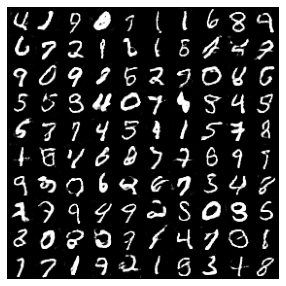

In [16]:
latent_dim = 64
z = Input(shape=(latent_dim,))

generator = build_generator(z)

generated_image = generator(z)

optimizer = Adam(0.0002, 0.5)

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
                     optimizer=optimizer,
                     metrics=['accuracy'])
discriminator.trainable = False
real_or_fake = discriminator(generated_image)
combined = Model(z, real_or_fake)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

train(generator, discriminator, combined, steps=50000, batch_size=100)
plot_generated_images(generator)